In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn import preprocessing
# from numba import vectorize
# from numba import cuda
from numba import autojit, jit
# import cupy as cp

## Cost/activation

In [2]:
# @cuda.jit
def cost_MSE(t,y_hat, derivative=0):
    if derivative:
            return -(t - y_hat)
    return np.mean(1/2*np.sum(np.power(t - y_hat, 2),\
                      axis=0))

@autojit
def logistic_sigmoid(x, derivative=0):    
    sigm = 1/(1 + np.exp(-x))
    if len(sigm.shape) < 2:
        sigm = sigm.reshape(sigm.shape[0],1) #makes it a column vector
    if derivative:
        return sigm*(1. - sigm)
    return sigm

@autojit
def tanh(x, derivative=0):    
    a = np.tanh(x)
    if len(a.shape) < 2:
        a = a.reshape(a.shape[0],1) #makes it a column vector
    if derivative:
        return 1 - np.power(a,2)
    return a

@autojit
def ReLU(x, derivative=0, alpha=0):    
    rel = x
    if derivative:
        rel[rel > 0] = 1
        if alpha:
            return x[x<=0] = alpha
        else:
            x[x<=0] = 0
            
    else: #not derivative
        rel = np.max(0,x) + alpha*min(0,x)
        
    return rel
    
def activation(X, type_act = 'sigmoid', derivative=0)
#     X_act = 0
    if type_act == 'sigmoid':
        return logistic_sigmoid(X, derivative)
    elif type_act == 'tanh':
        return tanh(x, derivative=0)
    elif type_act == 'relu'.lower():
        return ReLU(x, derivative=0, alpha=0)
    else #string passed is not a proper argument
        return None #failed 

## NN backend

In [45]:
# >>>>>>>>>>>>>>>>>>> init_weights_biases >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# W, B = init_weights_biases(4, 3, [2,2])
#no_hidden_units: needs a list with at least one element
# @cuda.jit(device=True)
def init_weights_biases(no_of_features, no_outputs, no_hidden_units, seed=1, epsilon=.55):
    
    W = []
    B = []
    rows, columns = 0, 0 
    last = len(no_hidden_units)
    np.random.seed(seed)
    
    if no_hidden_units: #list is not empty
        for i in range(last+1):
            if i == 0: #first weight
                rows = no_hidden_units[i]
                columns = no_of_features
            elif i > 0 and i < last:
                rows = no_hidden_units[i]
                columns = no_hidden_units[i-1]
            else: #last
                columns = rows # list ran out of indeces, so use last one
                rows = no_outputs            

            W.insert(i, np.random.randn(rows, columns)*2*epsilon - epsilon )
            B.insert(i, np.random.randn(rows, 1))
    else: # no hidden units (perceptron)
        W.insert(0, np.random.randn(no_outputs, no_of_features)*2*epsilon - epsilon)
        B.insert(0, np.random.randn(no_outputs, 1))
    
    dummy_param = 0
    param = 0
    for i in range(len(W)):
        dummy_param = W[i].shape[0] * W[i].shape[1]
        param += dummy_param
        
#     W.append(param) #number of learnable weights
    
    return W, B, param

# >>>>>>>>>>>>>>>>>>> forward_prop >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # W1, b1, W2, b2 = init_weights_biases(no_hidden_units=8)
    # Z, A, Y = forward_prop(W, B, X)
    # X has n features x M samples
@autojit
# @cuda.jit
# @jit(nopython=True)
def forward_prop(W, B, X):
    no_of_samples = X.shape[1]
     #last weight matrix, rows correspond to outputs
    no_of_outputs = W[-2].shape[0] #index -1 is the number of learnable weights
    
    Z = []
    A = []
    A.append(X) #first layer is an activation
    
    for i in range(len(W)): #to avoid the last two indeces
        bias = np.mean(B[i],axis=1)
        bias = bias.reshape(bias.shape[0],1)
        Z.insert(i, W[i] @ A[i] + bias)
        A.insert(i+1, logistic_sigmoid(Z[i]))
    
    Y = np.zeros((no_of_samples, no_of_outputs))
    #scaling to making the pair a probability
    
#      #comuns are the samples now, so rows are features/outputs
#     if A[i+1].shape[0] > 1: #multiclass classification/normalized (all samples add up to 1)
#         Y = np.divide(A[i+1], np.sum(A[i+1], axis=0))
#     else:  #there's only one output per sample, so no normalization needed
    Y = A[i+1]
        
    return Z, A, Y

# >>>>>>>>>>>>>>>>>>> backprop >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# W1, b1, W2, b2 = init_weights_biases(no_hidden_units=8)
# A1, A2, Y = forward_prop(W1, b1, W2, b2, X)
# grad_mid_layer, grad_output = backprop(W2, A1, A2, X, Y, t)
# backprop(W2, A1, A2, X, Y, t)
# @cuda.jit(device=True)

# @cuda.jit
@autojit
# @jit(nopython=True)
def backprop(W, Z, A, Y_hat, T):
    
    output_index = len(W)-1 # if 3, starts at 2
    error = {}
    
    error_output = cost_MSE(T,Y_hat, derivative=1) * logistic_sigmoid(Z[-1], derivative=1)
    error[output_index] = error_output
    
    dJ_dW = {}
    dJ_dB = {}
    for i in range(output_index-1,-1,-1):
         # doesn't get to W[0], so updated after the foor loop again
        dJ_dW[i+1] = error[i+1] @ A[i+1].T
        deriv_B = np.mean(logistic_sigmoid(Z[i], derivative=1),axis=1)
        deriv_B = deriv_B.reshape(deriv_B.shape[0],1)
        
        dJ_dB[i+1] = dJ_dW[i+1] @ deriv_B #not sure if this is right
        
        error_dummy = (W[i+1].T @ error[i+1]) * logistic_sigmoid(Z[i], derivative=1)
        error[i] = error_dummy
        
    
    dJ_dW[0] = error[0] @ A[0].T
    dJ_dB[0] = dJ_dW[0]
    
    return dJ_dW, dJ_dB

## NN frontend 1 

    train, predict functions

In [42]:
# >>>>>>>>>>>>>>>>>>> train >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # all samples (X), 4 x 2, are fed
    # X: dataset, n samples x N features
    # T: binary labels, n labels x L number of ouputs
    # hidden_layers : list with number of neurons for each inner layer.
        # e.g. [3, 4] will yield two layers with 3 and 4 units respectively
    # this function needs n samples > 1 (batch optimization).
# @cuda.jit(device=True)
# @autojit
def train(X, T, hidden_layers=[2], epochs=500,\
          rho=.1, normalize_data=False, show_cost=0, seed=1, w_transfer=[], epsilon=.55):
    
    if normalize_data:
        scaler = preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    no_of_features = X.shape[1]
    no_samples = X.shape[0]
    no_outputs = T.shape[1]
    
    W, B, param = init_weights_biases(no_of_features,\
                                      no_outputs, hidden_layers, seed=1)
    
    if w_transfer:
        W=w_transfer
        
    Y_hat = np.zeros((no_outputs, X.shape[0]))    

    N = int(np.round(epochs/20))
    i_for_show_cost = np.round(np.linspace(0,epochs,N))
    
    ###NESTED function
    def display_NN_info():
        print("* NN ************************************")
        print("   no. inputs (layer 1): " + str(no_of_features) )
        for k in range(len(hidden_layers)):
            print("   layer " + str(k+2) + ": " + str(hidden_layers[k]) + " units")
        print("   output layer ("+ str(k+3) + "): " + str(no_outputs) )
        print("   learnable weights: " + str(param) )
        print("   max epochs: " + "{:,}".format(epochs) )
        print("   learning rate(rho): " + str(rho) )
        
    display_NN_info()
    time.sleep(4)
    #loop variables, along with other variables and lists (cost, accuracy)
    # that are returned by the function
    cost_final = []
    accuracy = []
    iter_passed = []
    match = 0
    idx_done = 0
    converged = False
    k_cost = 0
    acc_count = 0
    for i in range(epochs):
        Z, A, Y_hat = forward_prop(W, B, X.T)
        dJ_dW, dJ_dB = backprop(W, Z, A, Y_hat, T.T)
    
        #grad descent
        for a in range(len(W)):
            W[a] = W[a] - rho*dJ_dW[a]
            B[a] = B[a] - rho*dJ_dB[a]
        
        if match <=5:
            idx_done = i + 1
        
        if is_equal_in_boolean_terms(Y_hat.T, T):
            match += 1            
                
            if match > 6 and match < 7:
                idx_done = i + 1 # already predicts corretly all the time
            
        if match > 100: #seeing the match 100 times (for robustness)
            converged = True #makes the predictions more confident
            break        
        
        cost_final.insert(i,cost_MSE(T, Y_hat.T))
        accuracy.insert(i,calc_accuracy(T, Y_hat.T))
        iter_passed.insert(i,i)
            
        if show_cost and i_for_show_cost[k_cost] == i:
            print("   " + str(i) + " iteration, accuracy: "+ str(accuracy[i])+ "%")
            print("   cost: " + str(cost_final[i]))
            k_cost += 1        
        
    if converged:
        print("   Converged in " + str(idx_done) + " iterations")
    else:
        print("   Did not converge.")
    print()
    if show_cost:
        plt.scatter(iter_passed, cost_final, s=1, color="red")
        plt.title("iterations X cost")
        plt.xlabel("iterations")
        plt.ylabel("cost")
        
    return [W, B, Y_hat.T, X, cost_final, epochs,\
            idx_done, converged, rho, normalize_data, accuracy]

# >>>>>>>>>>>>>>>>>>> predict >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # X: dataset, n samples x N features
    #  train_pkg: list with [W, B, Y, X, cost_final, epochs, idx_done, converged, rho, normalize_data, accuracy]
def predict(X, T, train_pkg):
    if len(X.shape) < 2:
        X = X.reshape(1,X.shape[0]) #for one sample
    
    normalized = train_pkg[-1]
    if normalized: #if the data has been normalized
        scaler = preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    Z, A, Y_hat = forward_prop(train_pkg[0], train_pkg[1], X.T)
    
    del Z, A
#     return Y_hat.T, calc_accuracy(T, Y_hat.T)
    return Y_hat.T

def is_equal_in_boolean_terms(Y_hat, T):
    return np.array_equal(np.round(Y_hat), T)

def calc_accuracy(T, Y): #only for logic gates
    matches = np.argmax(Y, axis=1) == np.argmax(T, axis=1)
    return len(matches[matches == True])/len(matches)*100

### NN functions 2 (helpers)

In [43]:
# >>>>>>>>>>>>>>>>>>> train_all_gates >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
def train_all_gates(X, t, hidden_layers=[3], iterations=500, rho=.01, normalize_data=False, print_cost=0):
    train_pkg_all_gates = {} #init dictionary

    for i in t:
        # hidden_layers = list of number of units for each layer. Minimum 1 [1]
                #train_gates[i] : [W, B, Y, X, cost_final, epochs, idx_done, \
                            #  converged, rho, normalize_data, accuracy]
        train_pkg_all_gates[i] = train(X, t[i],\
                                       hidden_layers = hidden_layers, \
                               epochs=iterations, rho=rho, \
                                       normalize_data=normalize_data, \
                                       show_cost=print_cost, seed=1)

    return train_pkg_all_gates

# >>>>>>>>>>>>>>>>>>> match >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
def match(X, t, train_pkg):
    #y_hat is returned transposed already from predict
    Y_hat = predict(X, t, train_pkg)
#   train_pkg : [W, B, Y, X, cost_final, epochs, idx_done,\
#                converged, rho, normalize_data, accuracy]
    # indeces used, especially:
    #                                 7. converged
    #                                 6. idx_done, 
    #                                 5. epochs
    #                                 8. rho
    match_pkg = [train_pkg[7], train_pkg[6],\
                  train_pkg[5], train_pkg[8],\
                  is_equal_in_boolean_terms(Y_hat, t), Y_hat]
    return match_pkg
# >>>>>>>>>>>>>>>>>>> match >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
def match_regress(X, t, train_pkg):
    #y_hat is returned transposed already from predict
    Y_hat = predict(X, t, train_pkg)
#   train_pkg : [W, B, Y, X, cost_final, epochs, idx_done,\
#                converged, rho, normalize_data, accuracy]
    # indeces used, especially:
    #                                 7. converged
    #                                 6. idx_done, 
    #                                 5. epochs
    #                                 8. rho
    match_pkg = [train_pkg[7], train_pkg[6],\
                  train_pkg[5], train_pkg[8],\
                  Y_hat]
    return match_pkg

# >>>>>>>>>>>>>>>>>>> match_all_gate_outputs >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
def match_all_gate_outputs(X, t, train_pkg_all_gates):
    matches = {}

    for i in t:
        matches[i] = match(X, t[i], train_pkg_all_gates[i])

    return matches

def print_match(match):
    print(i + " converged: " + str(match[0]))
    print("===========================================")
    if match[1]:
        print("  iter. to converge: " + str(match[1]))
    else:
        print("  reached max. iter")
    print("  iter. max: " + str(match[2]))
    if match[4]:
        print("  ==== CORRECT prediction ==== ")
    else:
        print("  ==== INCORRECT prediction ==== ")
    print("  predicted y (y_hat): ")
    print(np.round(match[5]))
    print()

#### dataset / targets

X: possible inputs of a binary logic function.

t: dictionary with possible outputs for each logic gates. 
    4 binary ouputs to match NN's output probabilities of 0 or 1. 
    - if [p(0) p(1)] == [1 0] then probability of 0 == 1 && probability of 1 == 1

In [9]:
X = np.array([[0,0],\
              [0,1],\
              [1,0],\
              [1,1]], dtype=np.float32)


t = { #dictionary for getting both the target logic values and the correlated string 
    # binary labels to represent the probabilities of 1 or 0 (first column is 0, 2nd 1)
    "AND": np.array([[1, 0],\
                     [1, 0],\
                     [1, 0],\
                     [0, 1]], dtype=np.float32),
    
    "NAND": np.array([[0, 1],\
                      [0, 1],\
                      [0, 1],\
                      [1, 0]], dtype=np.float32),
    
    "OR": np.array([[1, 0],\
                    [0, 1],\
                    [0, 1],\
                    [0, 1]], dtype=np.float32),
    
    "NOR": np.array([[0, 1],\
                     [1, 0],\
                     [1, 0],\
                     [1, 0]], dtype=np.float32),
    
#     "XOR": np.array([[1, 0],\
#                      [0, 1],\
#                      [0, 1],\
#                      [1, 0]], dtype=np.float32) }

#     "XOR": np.array([[1, 0],\
#                      [0, 1],\
#                      [0, 1],\
#                      [1, 0]], dtype=np.float32) }
    "XOR": np.array([[0],\
                     [1],\
                     [1],\
                     [0]], dtype=np.float32) }

## NN run

The Neural Network can be run with train() and then feeding the train_package to predict()

* NN ************************************
   no. inputs (layer 1): 2
   layer 2: 2 units
   output layer (3): 2
   learnable weights: 8
   max epochs: 30,000
   learning rate(rho): 1
   0 iteration, accuracy: 25.0%
   cost: 0.7456554077740192
   20 iteration, accuracy: 75.0%
   cost: 0.2915404165343277
   40 iteration, accuracy: 75.0%
   cost: 0.2286973808407464
   60 iteration, accuracy: 100.0%
   cost: 0.1587142035879391
   80 iteration, accuracy: 100.0%
   cost: 0.12144525862641181
   100 iteration, accuracy: 100.0%
   cost: 0.10125832028908965
   120 iteration, accuracy: 100.0%
   cost: 0.08980784762987207
   140 iteration, accuracy: 100.0%
   cost: 0.08256595806624803
   Converged in 60 iterations

* NN ************************************
   no. inputs (layer 1): 2
   layer 2: 2 units
   output layer (3): 2
   learnable weights: 8
   max epochs: 30,000
   learning rate(rho): 1
   0 iteration, accuracy: 75.0%
   cost: 0.4110723550457661
   20 iteration, accuracy: 75.0%
   cost: 0.

   3362 iteration, accuracy: 75.0%
   cost: 0.23202679203064439
   3382 iteration, accuracy: 75.0%
   cost: 0.23204824719219974
   3402 iteration, accuracy: 75.0%
   cost: 0.2320695541481761
   3422 iteration, accuracy: 75.0%
   cost: 0.23209071478891127
   3442 iteration, accuracy: 75.0%
   cost: 0.2321117309697611
   3462 iteration, accuracy: 75.0%
   cost: 0.23213260451194462
   3482 iteration, accuracy: 75.0%
   cost: 0.23215333720336434
   3502 iteration, accuracy: 75.0%
   cost: 0.23217393079940246
   3522 iteration, accuracy: 75.0%
   cost: 0.23219438702369338
   3542 iteration, accuracy: 75.0%
   cost: 0.23221470756887408
   3562 iteration, accuracy: 75.0%
   cost: 0.23223489409731146
   3582 iteration, accuracy: 75.0%
   cost: 0.2322549482418106
   3602 iteration, accuracy: 75.0%
   cost: 0.23227487160630084
   3622 iteration, accuracy: 75.0%
   cost: 0.2322946657665032
   3642 iteration, accuracy: 75.0%
   cost: 0.2323143322705784
   3662 iteration, accuracy: 75.0%
   cost: 0

   6805 iteration, accuracy: 75.0%
   cost: 0.2344311786502809
   6825 iteration, accuracy: 75.0%
   cost: 0.23444059862856598
   6845 iteration, accuracy: 75.0%
   cost: 0.2344499864331067
   6865 iteration, accuracy: 75.0%
   cost: 0.2344593422678006
   6885 iteration, accuracy: 75.0%
   cost: 0.23446866633466149
   6905 iteration, accuracy: 75.0%
   cost: 0.2344779588338416
   6925 iteration, accuracy: 75.0%
   cost: 0.23448721996365465
   6945 iteration, accuracy: 75.0%
   cost: 0.23449644992059773
   6965 iteration, accuracy: 75.0%
   cost: 0.23450564889937323
   6985 iteration, accuracy: 75.0%
   cost: 0.23451481709291028
   7005 iteration, accuracy: 75.0%
   cost: 0.2345239546923859
   7025 iteration, accuracy: 75.0%
   cost: 0.23453306188724593
   7045 iteration, accuracy: 75.0%
   cost: 0.23454213886522585
   7065 iteration, accuracy: 75.0%
   cost: 0.23455118581237033
   7085 iteration, accuracy: 75.0%
   cost: 0.2345602029130541
   7105 iteration, accuracy: 75.0%
   cost: 0.

   10247 iteration, accuracy: 75.0%
   cost: 0.2357015258071336
   10267 iteration, accuracy: 75.0%
   cost: 0.23570737294812072
   10287 iteration, accuracy: 75.0%
   cost: 0.23571320682901006
   10307 iteration, accuracy: 75.0%
   cost: 0.23571902750564855
   10327 iteration, accuracy: 75.0%
   cost: 0.23572483503353997
   10347 iteration, accuracy: 75.0%
   cost: 0.23573062946784723
   10367 iteration, accuracy: 75.0%
   cost: 0.23573641086339542
   10387 iteration, accuracy: 75.0%
   cost: 0.2357421792746744
   10407 iteration, accuracy: 75.0%
   cost: 0.23574793475584133
   10427 iteration, accuracy: 75.0%
   cost: 0.23575367736072383
   10447 iteration, accuracy: 75.0%
   cost: 0.2357594071428221
   10467 iteration, accuracy: 75.0%
   cost: 0.2357651241553118
   10487 iteration, accuracy: 75.0%
   cost: 0.2357708284510467
   10507 iteration, accuracy: 75.0%
   cost: 0.23577652008256073
   10527 iteration, accuracy: 75.0%
   cost: 0.23578219910207143
   10547 iteration, accuracy: 

   13709 iteration, accuracy: 75.0%
   cost: 0.23655383982384665
   13729 iteration, accuracy: 75.0%
   cost: 0.23655800657409884
   13749 iteration, accuracy: 75.0%
   cost: 0.23656216626089038
   13769 iteration, accuracy: 75.0%
   cost: 0.23656631890646146
   13789 iteration, accuracy: 75.0%
   cost: 0.23657046453295016
   13809 iteration, accuracy: 75.0%
   cost: 0.2365746031623927
   13829 iteration, accuracy: 75.0%
   cost: 0.23657873481672426
   13849 iteration, accuracy: 75.0%
   cost: 0.23658285951777963
   13869 iteration, accuracy: 75.0%
   cost: 0.2365869772872937
   13889 iteration, accuracy: 75.0%
   cost: 0.23659108814690213
   13909 iteration, accuracy: 75.0%
   cost: 0.23659519211814184
   13929 iteration, accuracy: 75.0%
   cost: 0.23659928922245183
   13949 iteration, accuracy: 75.0%
   cost: 0.23660337948117344
   13969 iteration, accuracy: 75.0%
   cost: 0.23660746291555113
   13989 iteration, accuracy: 75.0%
   cost: 0.2366115395467332
   14009 iteration, accuracy

   17151 iteration, accuracy: 75.0%
   cost: 0.23718250454542228
   17171 iteration, accuracy: 75.0%
   cost: 0.23718571514923437
   17191 iteration, accuracy: 75.0%
   cost: 0.23718892140185568
   17211 iteration, accuracy: 75.0%
   cost: 0.23719212331423858
   17231 iteration, accuracy: 75.0%
   cost: 0.23719532089729536
   17252 iteration, accuracy: 75.0%
   cost: 0.2371986737119631
   17272 iteration, accuracy: 75.0%
   cost: 0.23720186245384628
   17292 iteration, accuracy: 75.0%
   cost: 0.23720504689943833
   17312 iteration, accuracy: 75.0%
   cost: 0.23720822705949038
   17332 iteration, accuracy: 75.0%
   cost: 0.23721140294471402
   17352 iteration, accuracy: 75.0%
   cost: 0.23721457456578188
   17372 iteration, accuracy: 75.0%
   cost: 0.23721774193332743
   17392 iteration, accuracy: 75.0%
   cost: 0.23722090505794566
   17412 iteration, accuracy: 75.0%
   cost: 0.2372240639501927
   17432 iteration, accuracy: 75.0%
   cost: 0.2372272186205866
   17452 iteration, accuracy

   20594 iteration, accuracy: 75.0%
   cost: 0.23767903568703092
   20614 iteration, accuracy: 75.0%
   cost: 0.23768163065130976
   20634 iteration, accuracy: 75.0%
   cost: 0.23768422268600692
   20654 iteration, accuracy: 75.0%
   cost: 0.2376868117972647
   20674 iteration, accuracy: 75.0%
   cost: 0.23768939799120656
   20694 iteration, accuracy: 75.0%
   cost: 0.23769198127393742
   20714 iteration, accuracy: 75.0%
   cost: 0.23769456165154318
   20734 iteration, accuracy: 75.0%
   cost: 0.23769713913009144
   20754 iteration, accuracy: 75.0%
   cost: 0.23769971371563128
   20774 iteration, accuracy: 75.0%
   cost: 0.23770228541419314
   20794 iteration, accuracy: 75.0%
   cost: 0.23770485423178925
   20814 iteration, accuracy: 75.0%
   cost: 0.2377074201744135
   20834 iteration, accuracy: 75.0%
   cost: 0.23770998324804143
   20854 iteration, accuracy: 75.0%
   cost: 0.2377125434586307
   20874 iteration, accuracy: 75.0%
   cost: 0.23771510081212072
   20894 iteration, accuracy

   24036 iteration, accuracy: 75.0%
   cost: 0.23808703887524074
   24056 iteration, accuracy: 75.0%
   cost: 0.23808920667434347
   24076 iteration, accuracy: 75.0%
   cost: 0.23809137237607797
   24096 iteration, accuracy: 75.0%
   cost: 0.23809353598421262
   24116 iteration, accuracy: 75.0%
   cost: 0.2380956975025063
   24136 iteration, accuracy: 75.0%
   cost: 0.23809785693470759
   24156 iteration, accuracy: 75.0%
   cost: 0.23810001428455538
   24176 iteration, accuracy: 75.0%
   cost: 0.23810216955577898
   24196 iteration, accuracy: 75.0%
   cost: 0.2381043227520976
   24216 iteration, accuracy: 75.0%
   cost: 0.23810647387722103
   24236 iteration, accuracy: 75.0%
   cost: 0.23810862293484913
   24256 iteration, accuracy: 75.0%
   cost: 0.23811076992867225
   24276 iteration, accuracy: 75.0%
   cost: 0.23811291486237113
   24296 iteration, accuracy: 75.0%
   cost: 0.23811505773961683
   24316 iteration, accuracy: 75.0%
   cost: 0.23811719856407082
   24336 iteration, accurac

   27478 iteration, accuracy: 75.0%
   cost: 0.23843207024826257
   27498 iteration, accuracy: 75.0%
   cost: 0.23843392536916258
   27518 iteration, accuracy: 75.0%
   cost: 0.23843577891970827
   27538 iteration, accuracy: 75.0%
   cost: 0.23843763090236836
   27558 iteration, accuracy: 75.0%
   cost: 0.2384394813196059
   27578 iteration, accuracy: 75.0%
   cost: 0.23844133017387809
   27598 iteration, accuracy: 75.0%
   cost: 0.23844317746763694
   27618 iteration, accuracy: 75.0%
   cost: 0.23844502320332828
   27638 iteration, accuracy: 75.0%
   cost: 0.23844686738339266
   27658 iteration, accuracy: 75.0%
   cost: 0.23844871001026519
   27678 iteration, accuracy: 75.0%
   cost: 0.23845055108637508
   27698 iteration, accuracy: 75.0%
   cost: 0.2384523906141462
   27718 iteration, accuracy: 75.0%
   cost: 0.2384542285959967
   27738 iteration, accuracy: 75.0%
   cost: 0.23845606503433947
   27759 iteration, accuracy: 75.0%
   cost: 0.23845799163603285
   27779 iteration, accuracy

   0 iteration, accuracy: 75.0%
   cost: 0.46278056265575696
   20 iteration, accuracy: 75.0%
   cost: 0.26680488584152195
   40 iteration, accuracy: 75.0%
   cost: 0.18242543174506792
   60 iteration, accuracy: 100.0%
   cost: 0.13279987093331547
   80 iteration, accuracy: 100.0%
   cost: 0.08032235558239613
   100 iteration, accuracy: 100.0%
   cost: 0.03853200781191784
   120 iteration, accuracy: 100.0%
   cost: 0.0209036656751646
   140 iteration, accuracy: 100.0%
   cost: 0.013537450792414979
   160 iteration, accuracy: 100.0%
   cost: 0.00977866051943326
   Converged in 79 iterations

* NN ************************************
   no. inputs (layer 1): 2
   layer 2: 2 units
   output layer (3): 2
   learnable weights: 8
   max epochs: 30,000
   learning rate(rho): 1
   0 iteration, accuracy: 25.0%
   cost: 0.6939472001640283
   20 iteration, accuracy: 75.0%
   cost: 0.26669502714291415
   40 iteration, accuracy: 100.0%
   cost: 0.08942030509715791
   60 iteration, accuracy: 100.0%


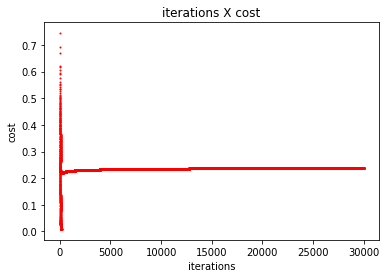

In [10]:
train_pkg_all_gates = train_all_gates(X, t, hidden_layers=[2],\
                    iterations=30_000, normalize_data=True, rho=1, print_cost=1)

# (X, t, hidden_layers=[3], iterations=500, rho=.01, print_cost=0)
matches = match_all_gate_outputs(X, t, train_pkg_all_gates)

### matches
matches is a Python dictionary holding a list of numbers for each logic gate. For ex: 

    matches["OR"]
    returns a list:
            matches["OR"][0] == boolean (converged or not, True or False)
            matches["OR"][1] == idx_done, no. of iterations to converge
            matches["OR"][2] == total iterations (epochs)
            matches["OR"][3] == learning rate used(rho)
            matches["OR"][4] == matches with target (comparing both p(0) and p(1))
            matches["OR"][5] == predicted Y

In [11]:
for i in matches:
    print_match(matches[i])

AND converged: True
  iter. to converge: 60
  iter. max: 30000
  ==== CORRECT prediction ==== 
  predicted y (y_hat): 
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]

NAND converged: False
  iter. to converge: 30000
  iter. max: 30000
  ==== INCORRECT prediction ==== 
  predicted y (y_hat): 
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]

OR converged: True
  iter. to converge: 79
  iter. max: 30000
  ==== CORRECT prediction ==== 
  predicted y (y_hat): 
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]

NOR converged: True
  iter. to converge: 40
  iter. max: 30000
  ==== CORRECT prediction ==== 
  predicted y (y_hat): 
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]

XOR converged: True
  iter. to converge: 47
  iter. max: 30000
  ==== CORRECT prediction ==== 
  predicted y (y_hat): 
[[0.]
 [1.]
 [1.]
 [0.]]



In [12]:
matches[i]

[True, 47, 30000, 1, True, array([[0.32926094],
        [0.57341142],
        [0.65220838],
        [0.3292607 ]])]

## another dataset

* NN ************************************
   no. inputs (layer 1): 1
   layer 2: 20 units
   layer 3: 20 units
   output layer (4): 1
   learnable weights: 440
   max epochs: 1,000,000
   learning rate(rho): 0.001
   0 iteration, accuracy: 100.0%
   cost: 24.65051867661685
   20 iteration, accuracy: 100.0%
   cost: 22.5041804298159
   40 iteration, accuracy: 100.0%
   cost: 20.95873613312681
   60 iteration, accuracy: 100.0%
   cost: 19.885947702261532
   80 iteration, accuracy: 100.0%
   cost: 19.136187593629828
   100 iteration, accuracy: 100.0%
   cost: 18.598519754264302
   120 iteration, accuracy: 100.0%
   cost: 18.2008798206665
   140 iteration, accuracy: 100.0%
   cost: 17.897891630256066
   160 iteration, accuracy: 100.0%
   cost: 17.660754137275703
   180 iteration, accuracy: 100.0%
   cost: 17.47076498853895
   200 iteration, accuracy: 100.0%
   cost: 17.31544301250576
   220 iteration, accuracy: 100.0%
   cost: 17.186226547898336
   240 iteration, accuracy: 100.0%
   cost: 

   2640 iteration, accuracy: 100.0%
   cost: 15.575194895537642
   2660 iteration, accuracy: 100.0%
   cost: 15.57277793900215
   2680 iteration, accuracy: 100.0%
   cost: 15.570388214294152
   2700 iteration, accuracy: 100.0%
   cost: 15.568024881746554
   2720 iteration, accuracy: 100.0%
   cost: 15.565687131047293
   2740 iteration, accuracy: 100.0%
   cost: 15.563374180059217
   2760 iteration, accuracy: 100.0%
   cost: 15.561085273695458
   2780 iteration, accuracy: 100.0%
   cost: 15.558819682847279
   2800 iteration, accuracy: 100.0%
   cost: 15.556576703361506
   2820 iteration, accuracy: 100.0%
   cost: 15.554355655064871
   2840 iteration, accuracy: 100.0%
   cost: 15.552155880832766
   2860 iteration, accuracy: 100.0%
   cost: 15.54997674570002
   2880 iteration, accuracy: 100.0%
   cost: 15.547817636011496
   2900 iteration, accuracy: 100.0%
   cost: 15.545677958610417
   2920 iteration, accuracy: 100.0%
   cost: 15.543557140062484
   2940 iteration, accuracy: 100.0%
   cos

   5420 iteration, accuracy: 100.0%
   cost: 15.339914274631605
   5440 iteration, accuracy: 100.0%
   cost: 15.338494815714647
   5460 iteration, accuracy: 100.0%
   cost: 15.337077514859335
   5480 iteration, accuracy: 100.0%
   cost: 15.335662381666344
   5500 iteration, accuracy: 100.0%
   cost: 15.334249426064341
   5520 iteration, accuracy: 100.0%
   cost: 15.332838658282526
   5540 iteration, accuracy: 100.0%
   cost: 15.331430088823344
   5560 iteration, accuracy: 100.0%
   cost: 15.33002372843536
   5580 iteration, accuracy: 100.0%
   cost: 15.328619588086344
   5600 iteration, accuracy: 100.0%
   cost: 15.327217678936552
   5620 iteration, accuracy: 100.0%
   cost: 15.325818012312293
   5640 iteration, accuracy: 100.0%
   cost: 15.324420599679682
   5660 iteration, accuracy: 100.0%
   cost: 15.323025452618722
   5680 iteration, accuracy: 100.0%
   cost: 15.321632582797662
   5700 iteration, accuracy: 100.0%
   cost: 15.320242001947674
   5720 iteration, accuracy: 100.0%
   co

   8200 iteration, accuracy: 100.0%
   cost: 15.165460367718888
   8220 iteration, accuracy: 100.0%
   cost: 15.16435741420742
   8240 iteration, accuracy: 100.0%
   cost: 15.163256160246608
   8260 iteration, accuracy: 100.0%
   cost: 15.162156597192507
   8280 iteration, accuracy: 100.0%
   cost: 15.161058716567926
   8300 iteration, accuracy: 100.0%
   cost: 15.159962510062003
   8320 iteration, accuracy: 100.0%
   cost: 15.158867969529535
   8340 iteration, accuracy: 100.0%
   cost: 15.157775086990245
   8360 iteration, accuracy: 100.0%
   cost: 15.156683854627865
   8380 iteration, accuracy: 100.0%
   cost: 15.15559426478912
   8400 iteration, accuracy: 100.0%
   cost: 15.154506309982592
   8420 iteration, accuracy: 100.0%
   cost: 15.15341998287747
   8440 iteration, accuracy: 100.0%
   cost: 15.152335276302177
   8460 iteration, accuracy: 100.0%
   cost: 15.15125218324291
   8480 iteration, accuracy: 100.0%
   cost: 15.150170696842098
   8500 iteration, accuracy: 100.0%
   cost:

   10920 iteration, accuracy: 100.0%
   cost: 15.029157129147416
   10940 iteration, accuracy: 100.0%
   cost: 15.028249987659532
   10960 iteration, accuracy: 100.0%
   cost: 15.027344174942852
   10980 iteration, accuracy: 100.0%
   cost: 15.026439689855557
   11000 iteration, accuracy: 100.0%
   cost: 15.025536531248612
   11020 iteration, accuracy: 100.0%
   cost: 15.024634697965697
   11040 iteration, accuracy: 100.0%
   cost: 15.023734188843122
   11060 iteration, accuracy: 100.0%
   cost: 15.022835002709785
   11080 iteration, accuracy: 100.0%
   cost: 15.0219371383871
   11100 iteration, accuracy: 100.0%
   cost: 15.021040594688952
   11120 iteration, accuracy: 100.0%
   cost: 15.020145370421652
   11140 iteration, accuracy: 100.0%
   cost: 15.019251464383908
   11160 iteration, accuracy: 100.0%
   cost: 15.018358875366774
   11180 iteration, accuracy: 100.0%
   cost: 15.01746760215365
   11200 iteration, accuracy: 100.0%
   cost: 15.016577643520238
   11220 iteration, accuracy

   13640 iteration, accuracy: 100.0%
   cost: 14.917421317593494
   13660 iteration, accuracy: 100.0%
   cost: 14.916681715503987
   13680 iteration, accuracy: 100.0%
   cost: 14.915943232880146
   13700 iteration, accuracy: 100.0%
   cost: 14.91520586797687
   13720 iteration, accuracy: 100.0%
   cost: 14.914469619048848
   13740 iteration, accuracy: 100.0%
   cost: 14.913734484350607
   13760 iteration, accuracy: 100.0%
   cost: 14.913000462136532
   13780 iteration, accuracy: 100.0%
   cost: 14.912267550660935
   13800 iteration, accuracy: 100.0%
   cost: 14.91153574817808
   13820 iteration, accuracy: 100.0%
   cost: 14.910805052942232
   13840 iteration, accuracy: 100.0%
   cost: 14.910075463207706
   13860 iteration, accuracy: 100.0%
   cost: 14.909346977228882
   13880 iteration, accuracy: 100.0%
   cost: 14.908619593260278
   13900 iteration, accuracy: 100.0%
   cost: 14.907893309556565
   13920 iteration, accuracy: 100.0%
   cost: 14.90716812437262
   13940 iteration, accuracy

   16400 iteration, accuracy: 100.0%
   cost: 14.825200629520007
   16420 iteration, accuracy: 100.0%
   cost: 14.824599385254752
   16440 iteration, accuracy: 100.0%
   cost: 14.823999030130802
   16460 iteration, accuracy: 100.0%
   cost: 14.823399562612801
   16480 iteration, accuracy: 100.0%
   cost: 14.822800981167761
   16500 iteration, accuracy: 100.0%
   cost: 14.82220328426502
   16520 iteration, accuracy: 100.0%
   cost: 14.821606470376269
   16540 iteration, accuracy: 100.0%
   cost: 14.82101053797555
   16560 iteration, accuracy: 100.0%
   cost: 14.820415485539245
   16580 iteration, accuracy: 100.0%
   cost: 14.819821311546102
   16600 iteration, accuracy: 100.0%
   cost: 14.81922801447722
   16620 iteration, accuracy: 100.0%
   cost: 14.818635592816054
   16640 iteration, accuracy: 100.0%
   cost: 14.818044045048422
   16660 iteration, accuracy: 100.0%
   cost: 14.817453369662495
   16680 iteration, accuracy: 100.0%
   cost: 14.816863565148816
   16700 iteration, accuracy

   18960 iteration, accuracy: 100.0%
   cost: 14.75496933276562
   18980 iteration, accuracy: 100.0%
   cost: 14.754470222376712
   19000 iteration, accuracy: 100.0%
   cost: 14.753971823601574
   19020 iteration, accuracy: 100.0%
   cost: 14.753474135198255
   19040 iteration, accuracy: 100.0%
   cost: 14.75297715592691
   19060 iteration, accuracy: 100.0%
   cost: 14.752480884549783
   19080 iteration, accuracy: 100.0%
   cost: 14.75198531983121
   19100 iteration, accuracy: 100.0%
   cost: 14.751490460537607
   19120 iteration, accuracy: 100.0%
   cost: 14.750996305437479
   19140 iteration, accuracy: 100.0%
   cost: 14.750502853301391
   19160 iteration, accuracy: 100.0%
   cost: 14.750010102902001
   19180 iteration, accuracy: 100.0%
   cost: 14.749518053014018
   19200 iteration, accuracy: 100.0%
   cost: 14.749026702414225
   19220 iteration, accuracy: 100.0%
   cost: 14.748536049881453
   19240 iteration, accuracy: 100.0%
   cost: 14.748046094196596
   19260 iteration, accuracy

   21780 iteration, accuracy: 100.0%
   cost: 14.691081582035762
   21800 iteration, accuracy: 100.0%
   cost: 14.690671438740237
   21820 iteration, accuracy: 100.0%
   cost: 14.690261850556364
   21840 iteration, accuracy: 100.0%
   cost: 14.689852816492538
   21860 iteration, accuracy: 100.0%
   cost: 14.689444335558598
   21880 iteration, accuracy: 100.0%
   cost: 14.689036406765828
   21900 iteration, accuracy: 100.0%
   cost: 14.688629029126949
   21920 iteration, accuracy: 100.0%
   cost: 14.688222201656108
   21940 iteration, accuracy: 100.0%
   cost: 14.687815923368895
   21960 iteration, accuracy: 100.0%
   cost: 14.6874101932823
   21980 iteration, accuracy: 100.0%
   cost: 14.687005010414765
   22000 iteration, accuracy: 100.0%
   cost: 14.686600373786113
   22020 iteration, accuracy: 100.0%
   cost: 14.686196282417606
   22040 iteration, accuracy: 100.0%
   cost: 14.685792735331896
   22060 iteration, accuracy: 100.0%
   cost: 14.685389731553036
   22080 iteration, accurac

   24340 iteration, accuracy: 100.0%
   cost: 14.642770936980185
   24360 iteration, accuracy: 100.0%
   cost: 14.642424234936092
   24380 iteration, accuracy: 100.0%
   cost: 14.642077971336779
   24400 iteration, accuracy: 100.0%
   cost: 14.641732145340393
   24420 iteration, accuracy: 100.0%
   cost: 14.641386756105973
   24440 iteration, accuracy: 100.0%
   cost: 14.641041802793447
   24460 iteration, accuracy: 100.0%
   cost: 14.640697284563636
   24480 iteration, accuracy: 100.0%
   cost: 14.640353200578245
   24500 iteration, accuracy: 100.0%
   cost: 14.640009549999853
   24520 iteration, accuracy: 100.0%
   cost: 14.639666331991922
   24540 iteration, accuracy: 100.0%
   cost: 14.639323545718772
   24560 iteration, accuracy: 100.0%
   cost: 14.638981190345602
   24580 iteration, accuracy: 100.0%
   cost: 14.638639265038472
   24600 iteration, accuracy: 100.0%
   cost: 14.638297768964293
   24620 iteration, accuracy: 100.0%
   cost: 14.63795670129084
   24640 iteration, accura

   27241 iteration, accuracy: 100.0%
   cost: 14.596656691467478
   27261 iteration, accuracy: 100.0%
   cost: 14.59636516167828
   27281 iteration, accuracy: 100.0%
   cost: 14.596073955442812
   27301 iteration, accuracy: 100.0%
   cost: 14.595783072003632
   27321 iteration, accuracy: 100.0%
   cost: 14.595492510603558
   27341 iteration, accuracy: 100.0%
   cost: 14.59520227048562
   27361 iteration, accuracy: 100.0%
   cost: 14.594912350893098
   27381 iteration, accuracy: 100.0%
   cost: 14.594622751069492
   27401 iteration, accuracy: 100.0%
   cost: 14.594333470258519
   27421 iteration, accuracy: 100.0%
   cost: 14.594044507704112
   27441 iteration, accuracy: 100.0%
   cost: 14.593755862650427
   27461 iteration, accuracy: 100.0%
   cost: 14.593467534341805
   27481 iteration, accuracy: 100.0%
   cost: 14.593179522022801
   27501 iteration, accuracy: 100.0%
   cost: 14.59289182493816
   27521 iteration, accuracy: 100.0%
   cost: 14.592604442332823
   27541 iteration, accuracy

   30041 iteration, accuracy: 100.0%
   cost: 14.558653111066956
   30061 iteration, accuracy: 100.0%
   cost: 14.558399532168224
   30081 iteration, accuracy: 100.0%
   cost: 14.558146170600518
   30101 iteration, accuracy: 100.0%
   cost: 14.55789302558313
   30121 iteration, accuracy: 100.0%
   cost: 14.557640096334717
   30141 iteration, accuracy: 100.0%
   cost: 14.557387382073282
   30161 iteration, accuracy: 100.0%
   cost: 14.557134882016163
   30181 iteration, accuracy: 100.0%
   cost: 14.556882595380044
   30201 iteration, accuracy: 100.0%
   cost: 14.556630521380917
   30221 iteration, accuracy: 100.0%
   cost: 14.556378659234113
   30241 iteration, accuracy: 100.0%
   cost: 14.556127008154258
   30261 iteration, accuracy: 100.0%
   cost: 14.555875567355278
   30281 iteration, accuracy: 100.0%
   cost: 14.555624336050403
   30301 iteration, accuracy: 100.0%
   cost: 14.555373313452145
   30321 iteration, accuracy: 100.0%
   cost: 14.555122498772286
   30341 iteration, accura

   32921 iteration, accuracy: 100.0%
   cost: 14.523979812349587
   32941 iteration, accuracy: 100.0%
   cost: 14.523749030356145
   32961 iteration, accuracy: 100.0%
   cost: 14.523518342376374
   32981 iteration, accuracy: 100.0%
   cost: 14.523287747443145
   33001 iteration, accuracy: 100.0%
   cost: 14.523057244587275
   33021 iteration, accuracy: 100.0%
   cost: 14.522826832837513
   33041 iteration, accuracy: 100.0%
   cost: 14.522596511220524
   33061 iteration, accuracy: 100.0%
   cost: 14.522366278760877
   33081 iteration, accuracy: 100.0%
   cost: 14.522136134481054
   33101 iteration, accuracy: 100.0%
   cost: 14.521906077401395
   33121 iteration, accuracy: 100.0%
   cost: 14.521676106540136
   33141 iteration, accuracy: 100.0%
   cost: 14.52144622091335
   33161 iteration, accuracy: 100.0%
   cost: 14.521216419534975
   33181 iteration, accuracy: 100.0%
   cost: 14.52098670141677
   33201 iteration, accuracy: 100.0%
   cost: 14.52075706556832
   33221 iteration, accuracy

   35961 iteration, accuracy: 100.0%
   cost: 14.489372543244178
   35981 iteration, accuracy: 100.0%
   cost: 14.489143479880118
   36001 iteration, accuracy: 100.0%
   cost: 14.48891433166527
   36021 iteration, accuracy: 100.0%
   cost: 14.488685097137479
   36041 iteration, accuracy: 100.0%
   cost: 14.488455774829468
   36061 iteration, accuracy: 100.0%
   cost: 14.488226363268772
   36081 iteration, accuracy: 100.0%
   cost: 14.487996860977733
   36101 iteration, accuracy: 100.0%
   cost: 14.487767266473412
   36121 iteration, accuracy: 100.0%
   cost: 14.487537578267592
   36141 iteration, accuracy: 100.0%
   cost: 14.487307794866686
   36161 iteration, accuracy: 100.0%
   cost: 14.487077914771726
   36181 iteration, accuracy: 100.0%
   cost: 14.486847936478302
   36201 iteration, accuracy: 100.0%
   cost: 14.486617858476507
   36221 iteration, accuracy: 100.0%
   cost: 14.486387679250901
   36241 iteration, accuracy: 100.0%
   cost: 14.486157397280461
   36261 iteration, accura

   38861 iteration, accuracy: 100.0%
   cost: 14.454420435163518
   38881 iteration, accuracy: 100.0%
   cost: 14.454159908173153
   38901 iteration, accuracy: 100.0%
   cost: 14.453898985914652
   38921 iteration, accuracy: 100.0%
   cost: 14.453637664939295
   38941 iteration, accuracy: 100.0%
   cost: 14.453375941764767
   38961 iteration, accuracy: 100.0%
   cost: 14.453113812874586
   38981 iteration, accuracy: 100.0%
   cost: 14.452851274717553
   39001 iteration, accuracy: 100.0%
   cost: 14.452588323707174
   39021 iteration, accuracy: 100.0%
   cost: 14.452324956221085
   39041 iteration, accuracy: 100.0%
   cost: 14.452061168600423
   39061 iteration, accuracy: 100.0%
   cost: 14.451796957149266
   39081 iteration, accuracy: 100.0%
   cost: 14.451532318133983
   39101 iteration, accuracy: 100.0%
   cost: 14.451267247782612
   39121 iteration, accuracy: 100.0%
   cost: 14.451001742284236
   39141 iteration, accuracy: 100.0%
   cost: 14.450735797788312
   39161 iteration, accur

   41881 iteration, accuracy: 100.0%
   cost: 14.407394993713767
   41901 iteration, accuracy: 100.0%
   cost: 14.4069948939329
   41921 iteration, accuracy: 100.0%
   cost: 14.406592783898095
   41941 iteration, accuracy: 100.0%
   cost: 14.406188635648121
   41961 iteration, accuracy: 100.0%
   cost: 14.405782420745599
   41981 iteration, accuracy: 100.0%
   cost: 14.405374110268555
   42001 iteration, accuracy: 100.0%
   cost: 14.404963674801845
   42021 iteration, accuracy: 100.0%
   cost: 14.404551084428476
   42041 iteration, accuracy: 100.0%
   cost: 14.404136308720794
   42061 iteration, accuracy: 100.0%
   cost: 14.403719316731554
   42081 iteration, accuracy: 100.0%
   cost: 14.403300076984893
   42101 iteration, accuracy: 100.0%
   cost: 14.402878557467165
   42121 iteration, accuracy: 100.0%
   cost: 14.402454725617696
   42141 iteration, accuracy: 100.0%
   cost: 14.402028548319386
   42161 iteration, accuracy: 100.0%
   cost: 14.401599991889256
   42181 iteration, accurac

   44561 iteration, accuracy: 100.0%
   cost: 14.316600157321542
   44581 iteration, accuracy: 100.0%
   cost: 14.315450074010787
   44601 iteration, accuracy: 100.0%
   cost: 14.314291411784923
   44621 iteration, accuracy: 100.0%
   cost: 14.313124268009625
   44641 iteration, accuracy: 100.0%
   cost: 14.311948748192004
   44661 iteration, accuracy: 100.0%
   cost: 14.310764966023324
   44681 iteration, accuracy: 100.0%
   cost: 14.309573043400103
   44701 iteration, accuracy: 100.0%
   cost: 14.308373110422517
   44721 iteration, accuracy: 100.0%
   cost: 14.307165305369088
   44741 iteration, accuracy: 100.0%
   cost: 14.305949774646756
   44761 iteration, accuracy: 100.0%
   cost: 14.304726672715509
   44781 iteration, accuracy: 100.0%
   cost: 14.303496161986871
   44801 iteration, accuracy: 100.0%
   cost: 14.302258412695652
   44821 iteration, accuracy: 100.0%
   cost: 14.301013602744566
   44841 iteration, accuracy: 100.0%
   cost: 14.299761917521382
   44861 iteration, accur

   47281 iteration, accuracy: 100.0%
   cost: 14.14879012562247
   47301 iteration, accuracy: 100.0%
   cost: 14.147709113154807
   47321 iteration, accuracy: 100.0%
   cost: 14.146629526100925
   47341 iteration, accuracy: 100.0%
   cost: 14.145551317174627
   47361 iteration, accuracy: 100.0%
   cost: 14.144474439581778
   47381 iteration, accuracy: 100.0%
   cost: 14.143398847031868
   47401 iteration, accuracy: 100.0%
   cost: 14.142324493748749
   47421 iteration, accuracy: 100.0%
   cost: 14.141251334480648
   47441 iteration, accuracy: 100.0%
   cost: 14.140179324509427
   47461 iteration, accuracy: 100.0%
   cost: 14.139108419659127
   47481 iteration, accuracy: 100.0%
   cost: 14.138038576303831
   47501 iteration, accuracy: 100.0%
   cost: 14.136969751374838
   47521 iteration, accuracy: 100.0%
   cost: 14.135901902367191
   47541 iteration, accuracy: 100.0%
   cost: 14.134834987345549
   47561 iteration, accuracy: 100.0%
   cost: 14.13376896494949
   47581 iteration, accurac

   49981 iteration, accuracy: 100.0%
   cost: 14.003840535369218
   50001 iteration, accuracy: 100.0%
   cost: 14.002729013280394
   50021 iteration, accuracy: 100.0%
   cost: 14.00161674848552
   50041 iteration, accuracy: 100.0%
   cost: 14.000503743554642
   50061 iteration, accuracy: 100.0%
   cost: 13.999390001158728
   50081 iteration, accuracy: 100.0%
   cost: 13.998275524067559
   50101 iteration, accuracy: 100.0%
   cost: 13.997160315147687
   50121 iteration, accuracy: 100.0%
   cost: 13.996044377360414
   50141 iteration, accuracy: 100.0%
   cost: 13.994927713759814
   50161 iteration, accuracy: 100.0%
   cost: 13.993810327490813
   50181 iteration, accuracy: 100.0%
   cost: 13.992692221787285
   50201 iteration, accuracy: 100.0%
   cost: 13.991573399970179
   50221 iteration, accuracy: 100.0%
   cost: 13.990453865445717
   50241 iteration, accuracy: 100.0%
   cost: 13.989333621703583
   50261 iteration, accuracy: 100.0%
   cost: 13.988212672315186
   50281 iteration, accura

   52921 iteration, accuracy: 100.0%
   cost: 13.834938082032773
   52941 iteration, accuracy: 100.0%
   cost: 13.8337726630634
   52961 iteration, accuracy: 100.0%
   cost: 13.832607343652803
   52981 iteration, accuracy: 100.0%
   cost: 13.831442130320484
   53001 iteration, accuracy: 100.0%
   cost: 13.830277029577958
   53021 iteration, accuracy: 100.0%
   cost: 13.829112047928529
   53041 iteration, accuracy: 100.0%
   cost: 13.82794719186707
   53061 iteration, accuracy: 100.0%
   cost: 13.826782467879825
   53081 iteration, accuracy: 100.0%
   cost: 13.825617882444165
   53101 iteration, accuracy: 100.0%
   cost: 13.824453442028403
   53121 iteration, accuracy: 100.0%
   cost: 13.823289153091562
   53141 iteration, accuracy: 100.0%
   cost: 13.82212502208319
   53161 iteration, accuracy: 100.0%
   cost: 13.820961055443139
   53181 iteration, accuracy: 100.0%
   cost: 13.81979725960136
   53201 iteration, accuracy: 100.0%
   cost: 13.818633640977719
   53221 iteration, accuracy: 

   55861 iteration, accuracy: 100.0%
   cost: 13.667829051597622
   55881 iteration, accuracy: 100.0%
   cost: 13.666740988997784
   55901 iteration, accuracy: 100.0%
   cost: 13.665653818939049
   55921 iteration, accuracy: 100.0%
   cost: 13.664567545325546
   55941 iteration, accuracy: 100.0%
   cost: 13.66348217203892
   55961 iteration, accuracy: 100.0%
   cost: 13.662397702938279
   55981 iteration, accuracy: 100.0%
   cost: 13.661314141860231
   56001 iteration, accuracy: 100.0%
   cost: 13.66023149261885
   56021 iteration, accuracy: 100.0%
   cost: 13.659149759005686
   56041 iteration, accuracy: 100.0%
   cost: 13.658068944789756
   56061 iteration, accuracy: 100.0%
   cost: 13.656989053717545
   56081 iteration, accuracy: 100.0%
   cost: 13.655910089513005
   56101 iteration, accuracy: 100.0%
   cost: 13.654832055877549
   56121 iteration, accuracy: 100.0%
   cost: 13.653754956490065
   56141 iteration, accuracy: 100.0%
   cost: 13.65267879500689
   56161 iteration, accuracy

   58421 iteration, accuracy: 100.0%
   cost: 13.536906734825386
   58441 iteration, accuracy: 100.0%
   cost: 13.535957096043706
   58461 iteration, accuracy: 100.0%
   cost: 13.535008672107361
   58481 iteration, accuracy: 100.0%
   cost: 13.534061464221464
   58501 iteration, accuracy: 100.0%
   cost: 13.533115473572893
   58521 iteration, accuracy: 100.0%
   cost: 13.53217070133035
   58541 iteration, accuracy: 100.0%
   cost: 13.531227148644408
   58561 iteration, accuracy: 100.0%
   cost: 13.530284816647598
   58581 iteration, accuracy: 100.0%
   cost: 13.52934370645445
   58601 iteration, accuracy: 100.0%
   cost: 13.528403819161548
   58621 iteration, accuracy: 100.0%
   cost: 13.52746515584761
   58641 iteration, accuracy: 100.0%
   cost: 13.526527717573533
   58661 iteration, accuracy: 100.0%
   cost: 13.525591505382458
   58681 iteration, accuracy: 100.0%
   cost: 13.52465652029984
   58701 iteration, accuracy: 100.0%
   cost: 13.523722763333486
   58721 iteration, accuracy:

   61401 iteration, accuracy: 100.0%
   cost: 13.409132845287695
   61421 iteration, accuracy: 100.0%
   cost: 13.408368900327329
   61441 iteration, accuracy: 100.0%
   cost: 13.407606183105084
   61461 iteration, accuracy: 100.0%
   cost: 13.406844692815719
   61481 iteration, accuracy: 100.0%
   cost: 13.406084428645306
   61501 iteration, accuracy: 100.0%
   cost: 13.40532538977128
   61521 iteration, accuracy: 100.0%
   cost: 13.404567575362517
   61541 iteration, accuracy: 100.0%
   cost: 13.403810984579373
   61561 iteration, accuracy: 100.0%
   cost: 13.403055616573758
   61581 iteration, accuracy: 100.0%
   cost: 13.402301470489189
   61601 iteration, accuracy: 100.0%
   cost: 13.401548545460852
   61621 iteration, accuracy: 100.0%
   cost: 13.40079684061566
   61641 iteration, accuracy: 100.0%
   cost: 13.400046355072307
   61661 iteration, accuracy: 100.0%
   cost: 13.399297087941342
   61681 iteration, accuracy: 100.0%
   cost: 13.398549038325203
   61701 iteration, accurac

   64401 iteration, accuracy: 100.0%
   cost: 13.30767425488763
   64421 iteration, accuracy: 100.0%
   cost: 13.307081799350307
   64441 iteration, accuracy: 100.0%
   cost: 13.306490383332747
   64461 iteration, accuracy: 100.0%
   cost: 13.30590000530213
   64481 iteration, accuracy: 100.0%
   cost: 13.305310663723958
   64501 iteration, accuracy: 100.0%
   cost: 13.30472235706211
   64521 iteration, accuracy: 100.0%
   cost: 13.304135083778865
   64541 iteration, accuracy: 100.0%
   cost: 13.303548842334937
   64561 iteration, accuracy: 100.0%
   cost: 13.302963631189503
   64581 iteration, accuracy: 100.0%
   cost: 13.30237944880024
   64601 iteration, accuracy: 100.0%
   cost: 13.301796293623354
   64621 iteration, accuracy: 100.0%
   cost: 13.301214164113613
   64641 iteration, accuracy: 100.0%
   cost: 13.30063305872438
   64661 iteration, accuracy: 100.0%
   cost: 13.30005297590763
   64681 iteration, accuracy: 100.0%
   cost: 13.299473914114005
   64701 iteration, accuracy: 1

   66941 iteration, accuracy: 100.0%
   cost: 13.240228768117106
   66961 iteration, accuracy: 100.0%
   cost: 13.239755804869189
   66981 iteration, accuracy: 100.0%
   cost: 13.239283682227457
   67001 iteration, accuracy: 100.0%
   cost: 13.238812398651607
   67021 iteration, accuracy: 100.0%
   cost: 13.23834195260249
   67041 iteration, accuracy: 100.0%
   cost: 13.237872342542119
   67061 iteration, accuracy: 100.0%
   cost: 13.237403566933697
   67081 iteration, accuracy: 100.0%
   cost: 13.236935624241603
   67101 iteration, accuracy: 100.0%
   cost: 13.236468512931433
   67121 iteration, accuracy: 100.0%
   cost: 13.236002231469998
   67141 iteration, accuracy: 100.0%
   cost: 13.235536778325336
   67161 iteration, accuracy: 100.0%
   cost: 13.23507215196673
   67181 iteration, accuracy: 100.0%
   cost: 13.234608350864711
   67201 iteration, accuracy: 100.0%
   cost: 13.234145373491083
   67221 iteration, accuracy: 100.0%
   cost: 13.23368321831893
   67241 iteration, accuracy

   69841 iteration, accuracy: 100.0%
   cost: 13.179684150848136
   69861 iteration, accuracy: 100.0%
   cost: 13.17931774721817
   69881 iteration, accuracy: 100.0%
   cost: 13.178951977585996
   69901 iteration, accuracy: 100.0%
   cost: 13.178586840665945
   69921 iteration, accuracy: 100.0%
   cost: 13.178222335174429
   69941 iteration, accuracy: 100.0%
   cost: 13.177858459829956
   69961 iteration, accuracy: 100.0%
   cost: 13.177495213353103
   69981 iteration, accuracy: 100.0%
   cost: 13.177132594466547
   70001 iteration, accuracy: 100.0%
   cost: 13.176770601895054
   70021 iteration, accuracy: 100.0%
   cost: 13.176409234365476
   70041 iteration, accuracy: 100.0%
   cost: 13.176048490606757
   70061 iteration, accuracy: 100.0%
   cost: 13.175688369349933
   70081 iteration, accuracy: 100.0%
   cost: 13.175328869328135
   70101 iteration, accuracy: 100.0%
   cost: 13.17496998927659
   70121 iteration, accuracy: 100.0%
   cost: 13.174611727932614
   70141 iteration, accurac

   72781 iteration, accuracy: 100.0%
   cost: 13.13199851702615
   72801 iteration, accuracy: 100.0%
   cost: 13.131712598717336
   72821 iteration, accuracy: 100.0%
   cost: 13.131427147734753
   72841 iteration, accuracy: 100.0%
   cost: 13.131142163093978
   72861 iteration, accuracy: 100.0%
   cost: 13.130857643812497
   72881 iteration, accuracy: 100.0%
   cost: 13.130573588909696
   72901 iteration, accuracy: 100.0%
   cost: 13.130289997406878
   72921 iteration, accuracy: 100.0%
   cost: 13.13000686832724
   72941 iteration, accuracy: 100.0%
   cost: 13.129724200695877
   72961 iteration, accuracy: 100.0%
   cost: 13.12944199353978
   72981 iteration, accuracy: 100.0%
   cost: 13.129160245887828
   73001 iteration, accuracy: 100.0%
   cost: 13.128878956770803
   73021 iteration, accuracy: 100.0%
   cost: 13.128598125221364
   73041 iteration, accuracy: 100.0%
   cost: 13.128317750274048
   73061 iteration, accuracy: 100.0%
   cost: 13.128037830965283
   73081 iteration, accuracy

   75802 iteration, accuracy: 100.0%
   cost: 13.093590110595127
   75822 iteration, accuracy: 100.0%
   cost: 13.093364633293431
   75842 iteration, accuracy: 100.0%
   cost: 13.093139494386813
   75862 iteration, accuracy: 100.0%
   cost: 13.09291469314026
   75882 iteration, accuracy: 100.0%
   cost: 13.092690228820105
   75902 iteration, accuracy: 100.0%
   cost: 13.092466100694052
   75922 iteration, accuracy: 100.0%
   cost: 13.09224230803114
   75942 iteration, accuracy: 100.0%
   cost: 13.092018850101763
   75962 iteration, accuracy: 100.0%
   cost: 13.091795726177649
   75982 iteration, accuracy: 100.0%
   cost: 13.091572935531882
   76002 iteration, accuracy: 100.0%
   cost: 13.091350477438855
   76022 iteration, accuracy: 100.0%
   cost: 13.091128351174309
   76042 iteration, accuracy: 100.0%
   cost: 13.090906556015302
   76062 iteration, accuracy: 100.0%
   cost: 13.09068509124022
   76082 iteration, accuracy: 100.0%
   cost: 13.090463956128758
   76102 iteration, accuracy

   78762 iteration, accuracy: 100.0%
   cost: 13.06353514874462
   78782 iteration, accuracy: 100.0%
   cost: 13.063352396027794
   78802 iteration, accuracy: 100.0%
   cost: 13.063169885436901
   78822 iteration, accuracy: 100.0%
   cost: 13.06298761639099
   78842 iteration, accuracy: 100.0%
   cost: 13.062805588309809
   78862 iteration, accuracy: 100.0%
   cost: 13.06262380061382
   78882 iteration, accuracy: 100.0%
   cost: 13.062442252724171
   78902 iteration, accuracy: 100.0%
   cost: 13.062260944062716
   78922 iteration, accuracy: 100.0%
   cost: 13.062079874051989
   78942 iteration, accuracy: 100.0%
   cost: 13.061899042115215
   78962 iteration, accuracy: 100.0%
   cost: 13.061718447676299
   78982 iteration, accuracy: 100.0%
   cost: 13.06153809015981
   79002 iteration, accuracy: 100.0%
   cost: 13.061357968991011
   79022 iteration, accuracy: 100.0%
   cost: 13.061178083595815
   79042 iteration, accuracy: 100.0%
   cost: 13.060998433400796
   79062 iteration, accuracy:

   81762 iteration, accuracy: 100.0%
   cost: 13.038519392674637
   81782 iteration, accuracy: 100.0%
   cost: 13.038366766250359
   81802 iteration, accuracy: 100.0%
   cost: 13.038214300285796
   81822 iteration, accuracy: 100.0%
   cost: 13.03806199425837
   81842 iteration, accuracy: 100.0%
   cost: 13.037909847645627
   81862 iteration, accuracy: 100.0%
   cost: 13.03775785992524
   81882 iteration, accuracy: 100.0%
   cost: 13.037606030575
   81902 iteration, accuracy: 100.0%
   cost: 13.037454359072816
   81922 iteration, accuracy: 100.0%
   cost: 13.037302844896715
   81942 iteration, accuracy: 100.0%
   cost: 13.037151487524842
   81962 iteration, accuracy: 100.0%
   cost: 13.03700028643545
   81982 iteration, accuracy: 100.0%
   cost: 13.036849241106914
   82002 iteration, accuracy: 100.0%
   cost: 13.036698351017714
   82022 iteration, accuracy: 100.0%
   cost: 13.036547615646434
   82042 iteration, accuracy: 100.0%
   cost: 13.036397034471776
   82062 iteration, accuracy: 1

   84742 iteration, accuracy: 100.0%
   cost: 13.01726720888961
   84762 iteration, accuracy: 100.0%
   cost: 13.017132797910934
   84782 iteration, accuracy: 100.0%
   cost: 13.016998471316098
   84802 iteration, accuracy: 100.0%
   cost: 13.016864228623437
   84822 iteration, accuracy: 100.0%
   cost: 13.016730069352109
   84842 iteration, accuracy: 100.0%
   cost: 13.016595993022154
   84862 iteration, accuracy: 100.0%
   cost: 13.016461999154478
   84882 iteration, accuracy: 100.0%
   cost: 13.016328087270889
   84902 iteration, accuracy: 100.0%
   cost: 13.016194256894101
   84922 iteration, accuracy: 100.0%
   cost: 13.016060507547747
   84942 iteration, accuracy: 100.0%
   cost: 13.015926838756409
   84962 iteration, accuracy: 100.0%
   cost: 13.015793250045613
   84982 iteration, accuracy: 100.0%
   cost: 13.015659740941857
   85002 iteration, accuracy: 100.0%
   cost: 13.015526310972634
   85022 iteration, accuracy: 100.0%
   cost: 13.015392959666432
   85042 iteration, accura

   87702 iteration, accuracy: 100.0%
   cost: 12.998063319348358
   87722 iteration, accuracy: 100.0%
   cost: 12.997936951119115
   87742 iteration, accuracy: 100.0%
   cost: 12.997810614903692
   87762 iteration, accuracy: 100.0%
   cost: 12.997684310546257
   87782 iteration, accuracy: 100.0%
   cost: 12.997558037894347
   87802 iteration, accuracy: 100.0%
   cost: 12.997431796798873
   87822 iteration, accuracy: 100.0%
   cost: 12.997305587114107
   87842 iteration, accuracy: 100.0%
   cost: 12.997179408697717
   87862 iteration, accuracy: 100.0%
   cost: 12.997053261410736
   87882 iteration, accuracy: 100.0%
   cost: 12.99692714511758
   87902 iteration, accuracy: 100.0%
   cost: 12.996801059686048
   87922 iteration, accuracy: 100.0%
   cost: 12.996675004987328
   87942 iteration, accuracy: 100.0%
   cost: 12.99654898089599
   87962 iteration, accuracy: 100.0%
   cost: 12.996422987289984
   87982 iteration, accuracy: 100.0%
   cost: 12.99629702405065
   88002 iteration, accuracy

   90722 iteration, accuracy: 100.0%
   cost: 12.979322004528138
   90742 iteration, accuracy: 100.0%
   cost: 12.97920039305506
   90762 iteration, accuracy: 100.0%
   cost: 12.979078820847615
   90782 iteration, accuracy: 100.0%
   cost: 12.97895728805878
   90802 iteration, accuracy: 100.0%
   cost: 12.978835794841237
   90822 iteration, accuracy: 100.0%
   cost: 12.978714341347363
   90842 iteration, accuracy: 100.0%
   cost: 12.978592927729187
   90862 iteration, accuracy: 100.0%
   cost: 12.978471554138373
   90882 iteration, accuracy: 100.0%
   cost: 12.978350220726183
   90902 iteration, accuracy: 100.0%
   cost: 12.978228927643457
   90922 iteration, accuracy: 100.0%
   cost: 12.978107675040585
   90942 iteration, accuracy: 100.0%
   cost: 12.977986463067472
   90962 iteration, accuracy: 100.0%
   cost: 12.977865291873533
   90982 iteration, accuracy: 100.0%
   cost: 12.97774416160764
   91002 iteration, accuracy: 100.0%
   cost: 12.977623072418124
   91022 iteration, accuracy

   93742 iteration, accuracy: 100.0%
   cost: 12.961472297057135
   93762 iteration, accuracy: 100.0%
   cost: 12.961357850612414
   93782 iteration, accuracy: 100.0%
   cost: 12.9612434558938
   93802 iteration, accuracy: 100.0%
   cost: 12.961129112912571
   93822 iteration, accuracy: 100.0%
   cost: 12.961014821679475
   93842 iteration, accuracy: 100.0%
   cost: 12.960900582204752
   93862 iteration, accuracy: 100.0%
   cost: 12.960786394498145
   93882 iteration, accuracy: 100.0%
   cost: 12.96067225856891
   93902 iteration, accuracy: 100.0%
   cost: 12.960558174425815
   93922 iteration, accuracy: 100.0%
   cost: 12.96044414207717
   93942 iteration, accuracy: 100.0%
   cost: 12.960330161530822
   93962 iteration, accuracy: 100.0%
   cost: 12.960216232794162
   93982 iteration, accuracy: 100.0%
   cost: 12.960102355874154
   94002 iteration, accuracy: 100.0%
   cost: 12.95998853077732
   94022 iteration, accuracy: 100.0%
   cost: 12.959874757509764
   94042 iteration, accuracy: 

   96642 iteration, accuracy: 100.0%
   cost: 12.945417887503357
   96662 iteration, accuracy: 100.0%
   cost: 12.945310928356836
   96682 iteration, accuracy: 100.0%
   cost: 12.945204020363214
   96702 iteration, accuracy: 100.0%
   cost: 12.945097163513374
   96722 iteration, accuracy: 100.0%
   cost: 12.94499035779815
   96742 iteration, accuracy: 100.0%
   cost: 12.944883603208316
   96762 iteration, accuracy: 100.0%
   cost: 12.944776899734588
   96782 iteration, accuracy: 100.0%
   cost: 12.94467024736763
   96802 iteration, accuracy: 100.0%
   cost: 12.944563646098034
   96822 iteration, accuracy: 100.0%
   cost: 12.944457095916356
   96842 iteration, accuracy: 100.0%
   cost: 12.944350596813065
   96862 iteration, accuracy: 100.0%
   cost: 12.944244148778589
   96882 iteration, accuracy: 100.0%
   cost: 12.944137751803272
   96902 iteration, accuracy: 100.0%
   cost: 12.94403140587741
   96922 iteration, accuracy: 100.0%
   cost: 12.943925110991236
   96942 iteration, accuracy

   99622 iteration, accuracy: 100.0%
   cost: 12.930038466942227
   99642 iteration, accuracy: 100.0%
   cost: 12.929938982790109
   99662 iteration, accuracy: 100.0%
   cost: 12.929839547418592
   99682 iteration, accuracy: 100.0%
   cost: 12.92974016080372
   99702 iteration, accuracy: 100.0%
   cost: 12.929640822921433
   99722 iteration, accuracy: 100.0%
   cost: 12.929541533747585
   99742 iteration, accuracy: 100.0%
   cost: 12.929442293257923
   99762 iteration, accuracy: 100.0%
   cost: 12.9293431014281
   99782 iteration, accuracy: 100.0%
   cost: 12.929243958233668
   99802 iteration, accuracy: 100.0%
   cost: 12.929144863650087
   99822 iteration, accuracy: 100.0%
   cost: 12.929045817652728
   99842 iteration, accuracy: 100.0%
   cost: 12.92894682021685
   99862 iteration, accuracy: 100.0%
   cost: 12.928847871317629
   99882 iteration, accuracy: 100.0%
   cost: 12.928748970930144
   99902 iteration, accuracy: 100.0%
   cost: 12.928650119029388
   99922 iteration, accuracy:

   102202 iteration, accuracy: 100.0%
   cost: 12.917598445868851
   102222 iteration, accuracy: 100.0%
   cost: 12.917505028671767
   102242 iteration, accuracy: 100.0%
   cost: 12.917411656560112
   102262 iteration, accuracy: 100.0%
   cost: 12.917318329502194
   102282 iteration, accuracy: 100.0%
   cost: 12.9172250474663
   102302 iteration, accuracy: 100.0%
   cost: 12.917131810420683
   102322 iteration, accuracy: 100.0%
   cost: 12.917038618333601
   102342 iteration, accuracy: 100.0%
   cost: 12.916945471173268
   102362 iteration, accuracy: 100.0%
   cost: 12.916852368907886
   102382 iteration, accuracy: 100.0%
   cost: 12.916759311505645
   102402 iteration, accuracy: 100.0%
   cost: 12.9166662989347
   102422 iteration, accuracy: 100.0%
   cost: 12.916573331163201
   102442 iteration, accuracy: 100.0%
   cost: 12.916480408159275
   102462 iteration, accuracy: 100.0%
   cost: 12.916387529891031
   102482 iteration, accuracy: 100.0%
   cost: 12.916294696326556
   102502 iter

   105162 iteration, accuracy: 100.0%
   cost: 12.904246169352385
   105182 iteration, accuracy: 100.0%
   cost: 12.904159076102632
   105202 iteration, accuracy: 100.0%
   cost: 12.904072023210219
   105222 iteration, accuracy: 100.0%
   cost: 12.903985010643991
   105242 iteration, accuracy: 100.0%
   cost: 12.903898038372809
   105262 iteration, accuracy: 100.0%
   cost: 12.903811106365556
   105282 iteration, accuracy: 100.0%
   cost: 12.903724214591136
   105302 iteration, accuracy: 100.0%
   cost: 12.903637363018472
   105322 iteration, accuracy: 100.0%
   cost: 12.90355055161651
   105342 iteration, accuracy: 100.0%
   cost: 12.903463780354217
   105362 iteration, accuracy: 100.0%
   cost: 12.90337704920058
   105382 iteration, accuracy: 100.0%
   cost: 12.90329035812461
   105402 iteration, accuracy: 100.0%
   cost: 12.903203707095335
   105422 iteration, accuracy: 100.0%
   cost: 12.903117096081806
   105442 iteration, accuracy: 100.0%
   cost: 12.9030305250531
   105462 itera

   108082 iteration, accuracy: 100.0%
   cost: 12.891942328981221
   108102 iteration, accuracy: 100.0%
   cost: 12.891860810177917
   108122 iteration, accuracy: 100.0%
   cost: 12.891779327442691
   108142 iteration, accuracy: 100.0%
   cost: 12.89169788074816
   108162 iteration, accuracy: 100.0%
   cost: 12.891616470066946
   108182 iteration, accuracy: 100.0%
   cost: 12.891535095371717
   108202 iteration, accuracy: 100.0%
   cost: 12.891453756635164
   108222 iteration, accuracy: 100.0%
   cost: 12.891372453830002
   108242 iteration, accuracy: 100.0%
   cost: 12.891291186928976
   108262 iteration, accuracy: 100.0%
   cost: 12.891209955904865
   108282 iteration, accuracy: 100.0%
   cost: 12.89112876073047
   108302 iteration, accuracy: 100.0%
   cost: 12.89104760137862
   108322 iteration, accuracy: 100.0%
   cost: 12.890966477822177
   108342 iteration, accuracy: 100.0%
   cost: 12.89088539003403
   108362 iteration, accuracy: 100.0%
   cost: 12.890804337987092
   108382 iter

   111082 iteration, accuracy: 100.0%
   cost: 12.880103036164261
   111102 iteration, accuracy: 100.0%
   cost: 12.880026636899315
   111122 iteration, accuracy: 100.0%
   cost: 12.879950269905164
   111142 iteration, accuracy: 100.0%
   cost: 12.879873935158553
   111162 iteration, accuracy: 100.0%
   cost: 12.879797632636256
   111182 iteration, accuracy: 100.0%
   cost: 12.879721362315061
   111202 iteration, accuracy: 100.0%
   cost: 12.879645124171793
   111222 iteration, accuracy: 100.0%
   cost: 12.879568918183297
   111242 iteration, accuracy: 100.0%
   cost: 12.87949274432645
   111262 iteration, accuracy: 100.0%
   cost: 12.87941660257815
   111282 iteration, accuracy: 100.0%
   cost: 12.879340492915324
   111302 iteration, accuracy: 100.0%
   cost: 12.879264415314923
   111322 iteration, accuracy: 100.0%
   cost: 12.879188369753923
   111342 iteration, accuracy: 100.0%
   cost: 12.879112356209337
   111362 iteration, accuracy: 100.0%
   cost: 12.879036374658181
   111382 it

   114002 iteration, accuracy: 100.0%
   cost: 12.8692789789052
   114022 iteration, accuracy: 100.0%
   cost: 12.869207057931414
   114042 iteration, accuracy: 100.0%
   cost: 12.869135166099113
   114062 iteration, accuracy: 100.0%
   cost: 12.869063303388621
   114082 iteration, accuracy: 100.0%
   cost: 12.868991469780285
   114102 iteration, accuracy: 100.0%
   cost: 12.868919665254479
   114122 iteration, accuracy: 100.0%
   cost: 12.868847889791594
   114142 iteration, accuracy: 100.0%
   cost: 12.868776143372049
   114162 iteration, accuracy: 100.0%
   cost: 12.86870442597628
   114182 iteration, accuracy: 100.0%
   cost: 12.868632737584749
   114202 iteration, accuracy: 100.0%
   cost: 12.868561078177938
   114222 iteration, accuracy: 100.0%
   cost: 12.868489447736353
   114242 iteration, accuracy: 100.0%
   cost: 12.86841784624053
   114262 iteration, accuracy: 100.0%
   cost: 12.868346273671012
   114282 iteration, accuracy: 100.0%
   cost: 12.868274730008375
   114302 iter

   116962 iteration, accuracy: 100.0%
   cost: 12.858941680939015
   116982 iteration, accuracy: 100.0%
   cost: 12.858873870388738
   117002 iteration, accuracy: 100.0%
   cost: 12.858806086300993
   117022 iteration, accuracy: 100.0%
   cost: 12.858738328659191
   117042 iteration, accuracy: 100.0%
   cost: 12.858670597446745
   117062 iteration, accuracy: 100.0%
   cost: 12.858602892647092
   117082 iteration, accuracy: 100.0%
   cost: 12.858535214243691
   117102 iteration, accuracy: 100.0%
   cost: 12.858467562220017
   117122 iteration, accuracy: 100.0%
   cost: 12.858399936559561
   117142 iteration, accuracy: 100.0%
   cost: 12.858332337245836
   117162 iteration, accuracy: 100.0%
   cost: 12.858264764262378
   117182 iteration, accuracy: 100.0%
   cost: 12.858197217592734
   117202 iteration, accuracy: 100.0%
   cost: 12.858129697220473
   117222 iteration, accuracy: 100.0%
   cost: 12.858062203129181
   117242 iteration, accuracy: 100.0%
   cost: 12.857994735302466
   117262 

   119882 iteration, accuracy: 100.0%
   cost: 12.849313342828028
   119902 iteration, accuracy: 100.0%
   cost: 12.849249229250635
   119922 iteration, accuracy: 100.0%
   cost: 12.849185139899813
   119942 iteration, accuracy: 100.0%
   cost: 12.849121074761474
   119962 iteration, accuracy: 100.0%
   cost: 12.849057033821529
   119982 iteration, accuracy: 100.0%
   cost: 12.848993017065924
   120002 iteration, accuracy: 100.0%
   cost: 12.8489290244806
   120022 iteration, accuracy: 100.0%
   cost: 12.848865056051528
   120042 iteration, accuracy: 100.0%
   cost: 12.84880111176469
   120062 iteration, accuracy: 100.0%
   cost: 12.84873719160608
   120082 iteration, accuracy: 100.0%
   cost: 12.848673295561715
   120102 iteration, accuracy: 100.0%
   cost: 12.848609423617619
   120122 iteration, accuracy: 100.0%
   cost: 12.848545575759834
   120142 iteration, accuracy: 100.0%
   cost: 12.84848175197442
   120162 iteration, accuracy: 100.0%
   cost: 12.848417952247448
   120182 itera

   122722 iteration, accuracy: 100.0%
   cost: 12.840445403330893
   122742 iteration, accuracy: 100.0%
   cost: 12.840384595693063
   122762 iteration, accuracy: 100.0%
   cost: 12.840323810425092
   122782 iteration, accuracy: 100.0%
   cost: 12.840263047514876
   122802 iteration, accuracy: 100.0%
   cost: 12.84020230695031
   122822 iteration, accuracy: 100.0%
   cost: 12.840141588719312
   122842 iteration, accuracy: 100.0%
   cost: 12.84008089280981
   122862 iteration, accuracy: 100.0%
   cost: 12.84002021920974
   122882 iteration, accuracy: 100.0%
   cost: 12.839959567907053
   122902 iteration, accuracy: 100.0%
   cost: 12.83989893888972
   122922 iteration, accuracy: 100.0%
   cost: 12.839838332145707
   122942 iteration, accuracy: 100.0%
   cost: 12.83977774766301
   122962 iteration, accuracy: 100.0%
   cost: 12.839717185429631
   122982 iteration, accuracy: 100.0%
   cost: 12.839656645433582
   123002 iteration, accuracy: 100.0%
   cost: 12.839596127662887
   123022 itera

   125643 iteration, accuracy: 100.0%
   cost: 12.831795454356314
   125663 iteration, accuracy: 100.0%
   cost: 12.831737791594547
   125683 iteration, accuracy: 100.0%
   cost: 12.831680149557291
   125703 iteration, accuracy: 100.0%
   cost: 12.83162252823406
   125723 iteration, accuracy: 100.0%
   cost: 12.831564927614405
   125743 iteration, accuracy: 100.0%
   cost: 12.831507347687861
   125763 iteration, accuracy: 100.0%
   cost: 12.831449788443992
   125783 iteration, accuracy: 100.0%
   cost: 12.831392249872364
   125803 iteration, accuracy: 100.0%
   cost: 12.831334731962558
   125823 iteration, accuracy: 100.0%
   cost: 12.831277234704155
   125843 iteration, accuracy: 100.0%
   cost: 12.831219758086757
   125863 iteration, accuracy: 100.0%
   cost: 12.831162302099967
   125883 iteration, accuracy: 100.0%
   cost: 12.831104866733403
   125903 iteration, accuracy: 100.0%
   cost: 12.831047451976694
   125923 iteration, accuracy: 100.0%
   cost: 12.830990057819474
   125943 i

   128163 iteration, accuracy: 100.0%
   cost: 12.824689838906373
   128183 iteration, accuracy: 100.0%
   cost: 12.824634708046508
   128203 iteration, accuracy: 100.0%
   cost: 12.824579596664979
   128223 iteration, accuracy: 100.0%
   cost: 12.824524504752452
   128243 iteration, accuracy: 100.0%
   cost: 12.824469432299594
   128263 iteration, accuracy: 100.0%
   cost: 12.824414379297089
   128283 iteration, accuracy: 100.0%
   cost: 12.824359345735614
   128303 iteration, accuracy: 100.0%
   cost: 12.82430433160587
   128323 iteration, accuracy: 100.0%
   cost: 12.824249336898552
   128343 iteration, accuracy: 100.0%
   cost: 12.824194361604375
   128363 iteration, accuracy: 100.0%
   cost: 12.824139405714057
   128383 iteration, accuracy: 100.0%
   cost: 12.824084469218322
   128403 iteration, accuracy: 100.0%
   cost: 12.824029552107902
   128423 iteration, accuracy: 100.0%
   cost: 12.823974654373544
   128443 iteration, accuracy: 100.0%
   cost: 12.823919776005992
   128463 i

   131063 iteration, accuracy: 100.0%
   cost: 12.81689470707015
   131083 iteration, accuracy: 100.0%
   cost: 12.816842306865679
   131103 iteration, accuracy: 100.0%
   cost: 12.816789924863382
   131123 iteration, accuracy: 100.0%
   cost: 12.816737561054964
   131143 iteration, accuracy: 100.0%
   cost: 12.816685215432134
   131163 iteration, accuracy: 100.0%
   cost: 12.8166328879866
   131183 iteration, accuracy: 100.0%
   cost: 12.816580578710084
   131203 iteration, accuracy: 100.0%
   cost: 12.81652828759431
   131223 iteration, accuracy: 100.0%
   cost: 12.816476014631014
   131243 iteration, accuracy: 100.0%
   cost: 12.816423759811927
   131263 iteration, accuracy: 100.0%
   cost: 12.816371523128797
   131283 iteration, accuracy: 100.0%
   cost: 12.816319304573378
   131303 iteration, accuracy: 100.0%
   cost: 12.816267104137424
   131323 iteration, accuracy: 100.0%
   cost: 12.816214921812698
   131343 iteration, accuracy: 100.0%
   cost: 12.81616275759097
   131363 itera

   134003 iteration, accuracy: 100.0%
   cost: 12.809383012093969
   134023 iteration, accuracy: 100.0%
   cost: 12.809333201625128
   134043 iteration, accuracy: 100.0%
   cost: 12.809283408200812
   134063 iteration, accuracy: 100.0%
   cost: 12.80923363181353
   134083 iteration, accuracy: 100.0%
   cost: 12.809183872455819
   134103 iteration, accuracy: 100.0%
   cost: 12.809134130120201
   134123 iteration, accuracy: 100.0%
   cost: 12.809084404799211
   134143 iteration, accuracy: 100.0%
   cost: 12.80903469648539
   134163 iteration, accuracy: 100.0%
   cost: 12.808985005171285
   134183 iteration, accuracy: 100.0%
   cost: 12.808935330849442
   134203 iteration, accuracy: 100.0%
   cost: 12.808885673512414
   134223 iteration, accuracy: 100.0%
   cost: 12.808836033152765
   134243 iteration, accuracy: 100.0%
   cost: 12.808786409763057
   134263 iteration, accuracy: 100.0%
   cost: 12.808736803335856
   134283 iteration, accuracy: 100.0%
   cost: 12.808687213863736
   134303 it

   136503 iteration, accuracy: 100.0%
   cost: 12.80328646737972
   136523 iteration, accuracy: 100.0%
   cost: 12.803238730986331
   136543 iteration, accuracy: 100.0%
   cost: 12.803191010737951
   136563 iteration, accuracy: 100.0%
   cost: 12.803143306627646
   136583 iteration, accuracy: 100.0%
   cost: 12.8030956186485
   136603 iteration, accuracy: 100.0%
   cost: 12.803047946793596
   136623 iteration, accuracy: 100.0%
   cost: 12.803000291056014
   136643 iteration, accuracy: 100.0%
   cost: 12.802952651428841
   136663 iteration, accuracy: 100.0%
   cost: 12.802905027905178
   136683 iteration, accuracy: 100.0%
   cost: 12.802857420478118
   136703 iteration, accuracy: 100.0%
   cost: 12.802809829140754
   136723 iteration, accuracy: 100.0%
   cost: 12.802762253886206
   136743 iteration, accuracy: 100.0%
   cost: 12.802714694707568
   136763 iteration, accuracy: 100.0%
   cost: 12.80266715159796
   136783 iteration, accuracy: 100.0%
   cost: 12.802619624550498
   136803 iter

   139003 iteration, accuracy: 100.0%
   cost: 12.79744237809765
   139023 iteration, accuracy: 100.0%
   cost: 12.797396607351898
   139043 iteration, accuracy: 100.0%
   cost: 12.797350851914223
   139063 iteration, accuracy: 100.0%
   cost: 12.797305111778158
   139083 iteration, accuracy: 100.0%
   cost: 12.797259386937224
   139103 iteration, accuracy: 100.0%
   cost: 12.79721367738496
   139123 iteration, accuracy: 100.0%
   cost: 12.797167983114894
   139143 iteration, accuracy: 100.0%
   cost: 12.79712230412057
   139163 iteration, accuracy: 100.0%
   cost: 12.797076640395531
   139183 iteration, accuracy: 100.0%
   cost: 12.797030991933314
   139203 iteration, accuracy: 100.0%
   cost: 12.796985358727472
   139223 iteration, accuracy: 100.0%
   cost: 12.796939740771558
   139243 iteration, accuracy: 100.0%
   cost: 12.796894138059123
   139263 iteration, accuracy: 100.0%
   cost: 12.79684855058373
   139283 iteration, accuracy: 100.0%
   cost: 12.796802978338937
   139303 iter

   141523 iteration, accuracy: 100.0%
   cost: 12.791793739555064
   141543 iteration, accuracy: 100.0%
   cost: 12.791749847664537
   141563 iteration, accuracy: 100.0%
   cost: 12.791705970290732
   141583 iteration, accuracy: 100.0%
   cost: 12.791662107427564
   141603 iteration, accuracy: 100.0%
   cost: 12.79161825906893
   141623 iteration, accuracy: 100.0%
   cost: 12.791574425208749
   141643 iteration, accuracy: 100.0%
   cost: 12.791530605840933
   141663 iteration, accuracy: 100.0%
   cost: 12.791486800959401
   141683 iteration, accuracy: 100.0%
   cost: 12.79144301055807
   141703 iteration, accuracy: 100.0%
   cost: 12.791399234630862
   141723 iteration, accuracy: 100.0%
   cost: 12.791355473171704
   141743 iteration, accuracy: 100.0%
   cost: 12.791311726174523
   141763 iteration, accuracy: 100.0%
   cost: 12.791267993633253
   141783 iteration, accuracy: 100.0%
   cost: 12.791224275541824
   141803 iteration, accuracy: 100.0%
   cost: 12.791180571894172
   141823 it

   144443 iteration, accuracy: 100.0%
   cost: 12.785536135602866
   144463 iteration, accuracy: 100.0%
   cost: 12.785494300003082
   144483 iteration, accuracy: 100.0%
   cost: 12.785452478058152
   144503 iteration, accuracy: 100.0%
   cost: 12.785410669762353
   144523 iteration, accuracy: 100.0%
   cost: 12.785368875109969
   144543 iteration, accuracy: 100.0%
   cost: 12.785327094095289
   144563 iteration, accuracy: 100.0%
   cost: 12.785285326712597
   144583 iteration, accuracy: 100.0%
   cost: 12.785243572956182
   144603 iteration, accuracy: 100.0%
   cost: 12.785201832820341
   144623 iteration, accuracy: 100.0%
   cost: 12.785160106299369
   144643 iteration, accuracy: 100.0%
   cost: 12.785118393387556
   144663 iteration, accuracy: 100.0%
   cost: 12.785076694079207
   144683 iteration, accuracy: 100.0%
   cost: 12.785035008368625
   144703 iteration, accuracy: 100.0%
   cost: 12.784993336250112
   144723 iteration, accuracy: 100.0%
   cost: 12.784951677717977
   144743 

   147383 iteration, accuracy: 100.0%
   cost: 12.779529909697342
   147403 iteration, accuracy: 100.0%
   cost: 12.779490021187144
   147423 iteration, accuracy: 100.0%
   cost: 12.779450145515666
   147443 iteration, accuracy: 100.0%
   cost: 12.77941028267752
   147463 iteration, accuracy: 100.0%
   cost: 12.779370432667324
   147483 iteration, accuracy: 100.0%
   cost: 12.779330595479689
   147503 iteration, accuracy: 100.0%
   cost: 12.779290771109233
   147523 iteration, accuracy: 100.0%
   cost: 12.77925095955058
   147543 iteration, accuracy: 100.0%
   cost: 12.779211160798353
   147563 iteration, accuracy: 100.0%
   cost: 12.779171374847172
   147583 iteration, accuracy: 100.0%
   cost: 12.77913160169167
   147603 iteration, accuracy: 100.0%
   cost: 12.77909184132647
   147623 iteration, accuracy: 100.0%
   cost: 12.779052093746204
   147643 iteration, accuracy: 100.0%
   cost: 12.779012358945508
   147663 iteration, accuracy: 100.0%
   cost: 12.778972636919018
   147683 iter

   150283 iteration, accuracy: 100.0%
   cost: 12.77387746792697
   150303 iteration, accuracy: 100.0%
   cost: 12.77383938582657
   150323 iteration, accuracy: 100.0%
   cost: 12.773801315805457
   150343 iteration, accuracy: 100.0%
   cost: 12.773763257858546
   150363 iteration, accuracy: 100.0%
   cost: 12.773725211980754
   150383 iteration, accuracy: 100.0%
   cost: 12.773687178166995
   150403 iteration, accuracy: 100.0%
   cost: 12.773649156412187
   150423 iteration, accuracy: 100.0%
   cost: 12.77361114671125
   150443 iteration, accuracy: 100.0%
   cost: 12.773573149059107
   150463 iteration, accuracy: 100.0%
   cost: 12.77353516345068
   150483 iteration, accuracy: 100.0%
   cost: 12.773497189880898
   150503 iteration, accuracy: 100.0%
   cost: 12.773459228344688
   150523 iteration, accuracy: 100.0%
   cost: 12.773421278836977
   150543 iteration, accuracy: 100.0%
   cost: 12.773383341352703
   150563 iteration, accuracy: 100.0%
   cost: 12.7733454158868
   150583 iterat

   153223 iteration, accuracy: 100.0%
   cost: 12.768406420346519
   153243 iteration, accuracy: 100.0%
   cost: 12.768370060335627
   153263 iteration, accuracy: 100.0%
   cost: 12.768333711677391
   153283 iteration, accuracy: 100.0%
   cost: 12.76829737436701
   153303 iteration, accuracy: 100.0%
   cost: 12.76826104839969
   153323 iteration, accuracy: 100.0%
   cost: 12.768224733770637
   153343 iteration, accuracy: 100.0%
   cost: 12.768188430475057
   153363 iteration, accuracy: 100.0%
   cost: 12.76815213850816
   153383 iteration, accuracy: 100.0%
   cost: 12.768115857865164
   153403 iteration, accuracy: 100.0%
   cost: 12.768079588541276
   153423 iteration, accuracy: 100.0%
   cost: 12.768043330531713
   153443 iteration, accuracy: 100.0%
   cost: 12.768007083831689
   153463 iteration, accuracy: 100.0%
   cost: 12.767970848436429
   153483 iteration, accuracy: 100.0%
   cost: 12.767934624341152
   153503 iteration, accuracy: 100.0%
   cost: 12.76789841154108
   153523 iter

   155743 iteration, accuracy: 100.0%
   cost: 12.763912918718296
   155763 iteration, accuracy: 100.0%
   cost: 12.763877951985972
   155783 iteration, accuracy: 100.0%
   cost: 12.763842996016933
   155803 iteration, accuracy: 100.0%
   cost: 12.76380805080663
   155823 iteration, accuracy: 100.0%
   cost: 12.763773116350501
   155843 iteration, accuracy: 100.0%
   cost: 12.763738192643993
   155863 iteration, accuracy: 100.0%
   cost: 12.763703279682568
   155883 iteration, accuracy: 100.0%
   cost: 12.763668377461666
   155903 iteration, accuracy: 100.0%
   cost: 12.763633485976742
   155923 iteration, accuracy: 100.0%
   cost: 12.763598605223258
   155943 iteration, accuracy: 100.0%
   cost: 12.763563735196666
   155963 iteration, accuracy: 100.0%
   cost: 12.763528875892426
   155983 iteration, accuracy: 100.0%
   cost: 12.763494027306
   156003 iteration, accuracy: 100.0%
   cost: 12.763459189432854
   156023 iteration, accuracy: 100.0%
   cost: 12.76342436226845
   156043 itera

   158303 iteration, accuracy: 100.0%
   cost: 12.75952312601644
   158323 iteration, accuracy: 100.0%
   cost: 12.759489500603857
   158343 iteration, accuracy: 100.0%
   cost: 12.759455885386846
   158363 iteration, accuracy: 100.0%
   cost: 12.75942228036109
   158383 iteration, accuracy: 100.0%
   cost: 12.75938868552228
   158403 iteration, accuracy: 100.0%
   cost: 12.7593551008661
   158423 iteration, accuracy: 100.0%
   cost: 12.759321526388254
   158443 iteration, accuracy: 100.0%
   cost: 12.759287962084422
   158463 iteration, accuracy: 100.0%
   cost: 12.75925440795031
   158483 iteration, accuracy: 100.0%
   cost: 12.759220863981612
   158503 iteration, accuracy: 100.0%
   cost: 12.75918733017403
   158523 iteration, accuracy: 100.0%
   cost: 12.759153806523262
   158543 iteration, accuracy: 100.0%
   cost: 12.759120293025012
   158563 iteration, accuracy: 100.0%
   cost: 12.75908678967499
   158583 iteration, accuracy: 100.0%
   cost: 12.759053296468895
   158603 iteratio

   161243 iteration, accuracy: 100.0%
   cost: 12.754687396785
   161263 iteration, accuracy: 100.0%
   cost: 12.754655224804825
   161283 iteration, accuracy: 100.0%
   cost: 12.754623062406212
   161303 iteration, accuracy: 100.0%
   cost: 12.754590909585117
   161323 iteration, accuracy: 100.0%
   cost: 12.754558766337503
   161343 iteration, accuracy: 100.0%
   cost: 12.754526632659333
   161363 iteration, accuracy: 100.0%
   cost: 12.754494508546582
   161383 iteration, accuracy: 100.0%
   cost: 12.754462393995208
   161403 iteration, accuracy: 100.0%
   cost: 12.754430289001185
   161423 iteration, accuracy: 100.0%
   cost: 12.754398193560485
   161443 iteration, accuracy: 100.0%
   cost: 12.754366107669082
   161463 iteration, accuracy: 100.0%
   cost: 12.75433403132295
   161483 iteration, accuracy: 100.0%
   cost: 12.754301964518064
   161503 iteration, accuracy: 100.0%
   cost: 12.754269907250405
   161523 iteration, accuracy: 100.0%
   cost: 12.754237859515959
   161543 iter

   164143 iteration, accuracy: 100.0%
   cost: 12.750120513455599
   164163 iteration, accuracy: 100.0%
   cost: 12.750089689544122
   164183 iteration, accuracy: 100.0%
   cost: 12.750058874647625
   164203 iteration, accuracy: 100.0%
   cost: 12.75002806876233
   164223 iteration, accuracy: 100.0%
   cost: 12.749997271884471
   164243 iteration, accuracy: 100.0%
   cost: 12.749966484010274
   164263 iteration, accuracy: 100.0%
   cost: 12.749935705135966
   164283 iteration, accuracy: 100.0%
   cost: 12.749904935257787
   164303 iteration, accuracy: 100.0%
   cost: 12.749874174371966
   164323 iteration, accuracy: 100.0%
   cost: 12.74984342247474
   164343 iteration, accuracy: 100.0%
   cost: 12.749812679562346
   164363 iteration, accuracy: 100.0%
   cost: 12.749781945631025
   164383 iteration, accuracy: 100.0%
   cost: 12.749751220677018
   164403 iteration, accuracy: 100.0%
   cost: 12.74972050469657
   164423 iteration, accuracy: 100.0%
   cost: 12.749689797685924
   164443 ite

   166723 iteration, accuracy: 100.0%
   cost: 12.746217356978754
   166743 iteration, accuracy: 100.0%
   cost: 12.746187665460422
   166763 iteration, accuracy: 100.0%
   cost: 12.746157982484851
   166783 iteration, accuracy: 100.0%
   cost: 12.746128308048505
   166803 iteration, accuracy: 100.0%
   cost: 12.74609864214783
   166823 iteration, accuracy: 100.0%
   cost: 12.746068984779292
   166843 iteration, accuracy: 100.0%
   cost: 12.746039335939344
   166863 iteration, accuracy: 100.0%
   cost: 12.746009695624453
   166883 iteration, accuracy: 100.0%
   cost: 12.745980063831077
   166903 iteration, accuracy: 100.0%
   cost: 12.745950440555685
   166923 iteration, accuracy: 100.0%
   cost: 12.745920825794741
   166943 iteration, accuracy: 100.0%
   cost: 12.74589121954471
   166963 iteration, accuracy: 100.0%
   cost: 12.74586162180207
   166983 iteration, accuracy: 100.0%
   cost: 12.745832032563287
   167003 iteration, accuracy: 100.0%
   cost: 12.745802451824837
   167023 ite

   169683 iteration, accuracy: 100.0%
   cost: 12.741914096603912
   169703 iteration, accuracy: 100.0%
   cost: 12.741885631759303
   169723 iteration, accuracy: 100.0%
   cost: 12.74185717495142
   169743 iteration, accuracy: 100.0%
   cost: 12.74182872617698
   169763 iteration, accuracy: 100.0%
   cost: 12.741800285432683
   169783 iteration, accuracy: 100.0%
   cost: 12.741771852715244
   169803 iteration, accuracy: 100.0%
   cost: 12.741743428021376
   169823 iteration, accuracy: 100.0%
   cost: 12.741715011347791
   169843 iteration, accuracy: 100.0%
   cost: 12.741686602691207
   169863 iteration, accuracy: 100.0%
   cost: 12.74165820204834
   169883 iteration, accuracy: 100.0%
   cost: 12.741629809415906
   169903 iteration, accuracy: 100.0%
   cost: 12.741601424790632
   169923 iteration, accuracy: 100.0%
   cost: 12.741573048169233
   169943 iteration, accuracy: 100.0%
   cost: 12.74154467954844
   169963 iteration, accuracy: 100.0%
   cost: 12.74151631892497
   169983 itera

   172623 iteration, accuracy: 100.0%
   cost: 12.737814329652396
   172643 iteration, accuracy: 100.0%
   cost: 12.73778701172815
   172663 iteration, accuracy: 100.0%
   cost: 12.737759701374216
   172683 iteration, accuracy: 100.0%
   cost: 12.737732398587543
   172703 iteration, accuracy: 100.0%
   cost: 12.737705103365077
   172723 iteration, accuracy: 100.0%
   cost: 12.737677815703764
   172743 iteration, accuracy: 100.0%
   cost: 12.737650535600562
   172763 iteration, accuracy: 100.0%
   cost: 12.737623263052422
   172783 iteration, accuracy: 100.0%
   cost: 12.737595998056294
   172803 iteration, accuracy: 100.0%
   cost: 12.737568740609136
   172823 iteration, accuracy: 100.0%
   cost: 12.737541490707908
   172843 iteration, accuracy: 100.0%
   cost: 12.737514248349568
   172863 iteration, accuracy: 100.0%
   cost: 12.737487013531073
   172883 iteration, accuracy: 100.0%
   cost: 12.737459786249389
   172903 iteration, accuracy: 100.0%
   cost: 12.737432566501477
   172923 i

   175184 iteration, accuracy: 100.0%
   cost: 12.734376822251008
   175204 iteration, accuracy: 100.0%
   cost: 12.734350449398539
   175224 iteration, accuracy: 100.0%
   cost: 12.734324083737988
   175244 iteration, accuracy: 100.0%
   cost: 12.734297725266494
   175264 iteration, accuracy: 100.0%
   cost: 12.734271373981201
   175284 iteration, accuracy: 100.0%
   cost: 12.734245029879263
   175304 iteration, accuracy: 100.0%
   cost: 12.734218692957821
   175324 iteration, accuracy: 100.0%
   cost: 12.734192363214024
   175344 iteration, accuracy: 100.0%
   cost: 12.734166040645022
   175364 iteration, accuracy: 100.0%
   cost: 12.734139725247973
   175384 iteration, accuracy: 100.0%
   cost: 12.734113417020023
   175404 iteration, accuracy: 100.0%
   cost: 12.734087115958333
   175424 iteration, accuracy: 100.0%
   cost: 12.734060822060055
   175444 iteration, accuracy: 100.0%
   cost: 12.734034535322355
   175464 iteration, accuracy: 100.0%
   cost: 12.734008255742385
   175484 

   177704 iteration, accuracy: 100.0%
   cost: 12.731109564070255
   177724 iteration, accuracy: 100.0%
   cost: 12.731084075381139
   177744 iteration, accuracy: 100.0%
   cost: 12.731058593535522
   177764 iteration, accuracy: 100.0%
   cost: 12.731033118530723
   177784 iteration, accuracy: 100.0%
   cost: 12.731007650364077
   177804 iteration, accuracy: 100.0%
   cost: 12.730982189032904
   177824 iteration, accuracy: 100.0%
   cost: 12.730956734534539
   177844 iteration, accuracy: 100.0%
   cost: 12.730931286866316
   177864 iteration, accuracy: 100.0%
   cost: 12.730905846025557
   177884 iteration, accuracy: 100.0%
   cost: 12.730880412009608
   177904 iteration, accuracy: 100.0%
   cost: 12.730854984815801
   177924 iteration, accuracy: 100.0%
   cost: 12.730829564441473
   177944 iteration, accuracy: 100.0%
   cost: 12.73080415088396
   177964 iteration, accuracy: 100.0%
   cost: 12.730778744140606
   177984 iteration, accuracy: 100.0%
   cost: 12.73075334420875
   178004 it

   180324 iteration, accuracy: 100.0%
   cost: 12.727827855283985
   180344 iteration, accuracy: 100.0%
   cost: 12.727803240828429
   180364 iteration, accuracy: 100.0%
   cost: 12.72777863287775
   180384 iteration, accuracy: 100.0%
   cost: 12.727754031429457
   180404 iteration, accuracy: 100.0%
   cost: 12.727729436481052
   180424 iteration, accuracy: 100.0%
   cost: 12.727704848030044
   180444 iteration, accuracy: 100.0%
   cost: 12.72768026607394
   180464 iteration, accuracy: 100.0%
   cost: 12.727655690610248
   180484 iteration, accuracy: 100.0%
   cost: 12.727631121636483
   180504 iteration, accuracy: 100.0%
   cost: 12.727606559150148
   180524 iteration, accuracy: 100.0%
   cost: 12.727582003148761
   180544 iteration, accuracy: 100.0%
   cost: 12.727557453629837
   180564 iteration, accuracy: 100.0%
   cost: 12.727532910590892
   180584 iteration, accuracy: 100.0%
   cost: 12.727508374029437
   180604 iteration, accuracy: 100.0%
   cost: 12.727483843943
   180624 itera

   183264 iteration, accuracy: 100.0%
   cost: 12.724278063542585
   183284 iteration, accuracy: 100.0%
   cost: 12.724254379183048
   183304 iteration, accuracy: 100.0%
   cost: 12.724230700975125
   183324 iteration, accuracy: 100.0%
   cost: 12.724207028916506
   183344 iteration, accuracy: 100.0%
   cost: 12.724183363004872
   183364 iteration, accuracy: 100.0%
   cost: 12.724159703237925
   183384 iteration, accuracy: 100.0%
   cost: 12.72413604961335
   183404 iteration, accuracy: 100.0%
   cost: 12.724112402128846
   183424 iteration, accuracy: 100.0%
   cost: 12.724088760782102
   183444 iteration, accuracy: 100.0%
   cost: 12.724065125570817
   183464 iteration, accuracy: 100.0%
   cost: 12.724041496492687
   183484 iteration, accuracy: 100.0%
   cost: 12.72401787354541
   183504 iteration, accuracy: 100.0%
   cost: 12.723994256726689
   183524 iteration, accuracy: 100.0%
   cost: 12.723970646034218
   183544 iteration, accuracy: 100.0%
   cost: 12.723947041465703
   183564 it

   185784 iteration, accuracy: 100.0%
   cost: 12.721341537708842
   185804 iteration, accuracy: 100.0%
   cost: 12.721318610635107
   185824 iteration, accuracy: 100.0%
   cost: 12.721295689431003
   185844 iteration, accuracy: 100.0%
   cost: 12.721272774094366
   185864 iteration, accuracy: 100.0%
   cost: 12.721249864623033
   185884 iteration, accuracy: 100.0%
   cost: 12.721226961014835
   185904 iteration, accuracy: 100.0%
   cost: 12.721204063267617
   185924 iteration, accuracy: 100.0%
   cost: 12.721181171379211
   185944 iteration, accuracy: 100.0%
   cost: 12.721158285347464
   185964 iteration, accuracy: 100.0%
   cost: 12.721135405170216
   185984 iteration, accuracy: 100.0%
   cost: 12.721112530845305
   186004 iteration, accuracy: 100.0%
   cost: 12.721089662370582
   186024 iteration, accuracy: 100.0%
   cost: 12.721066799743884
   186044 iteration, accuracy: 100.0%
   cost: 12.721043942963066
   186064 iteration, accuracy: 100.0%
   cost: 12.72102109202597
   186084 i

   188744 iteration, accuracy: 100.0%
   cost: 12.718011055469821
   188764 iteration, accuracy: 100.0%
   cost: 12.7179889741271
   188784 iteration, accuracy: 100.0%
   cost: 12.717966898345358
   188804 iteration, accuracy: 100.0%
   cost: 12.717944828122587
   188824 iteration, accuracy: 100.0%
   cost: 12.717922763456782
   188844 iteration, accuracy: 100.0%
   cost: 12.71790070434594
   188864 iteration, accuracy: 100.0%
   cost: 12.717878650788053
   188884 iteration, accuracy: 100.0%
   cost: 12.717856602781124
   188904 iteration, accuracy: 100.0%
   cost: 12.717834560323146
   188924 iteration, accuracy: 100.0%
   cost: 12.717812523412114
   188944 iteration, accuracy: 100.0%
   cost: 12.717790492046039
   188964 iteration, accuracy: 100.0%
   cost: 12.717768466222914
   188984 iteration, accuracy: 100.0%
   cost: 12.717746445940746
   189004 iteration, accuracy: 100.0%
   cost: 12.71772443119753
   189024 iteration, accuracy: 100.0%
   cost: 12.717702421991275
   189044 iter

   191724 iteration, accuracy: 100.0%
   cost: 12.714781186084746
   191744 iteration, accuracy: 100.0%
   cost: 12.714759911735152
   191764 iteration, accuracy: 100.0%
   cost: 12.71473864265837
   191784 iteration, accuracy: 100.0%
   cost: 12.714717378852528
   191804 iteration, accuracy: 100.0%
   cost: 12.714696120315773
   191824 iteration, accuracy: 100.0%
   cost: 12.714674867046243
   191844 iteration, accuracy: 100.0%
   cost: 12.714653619042075
   191864 iteration, accuracy: 100.0%
   cost: 12.714632376301417
   191884 iteration, accuracy: 100.0%
   cost: 12.714611138822402
   191904 iteration, accuracy: 100.0%
   cost: 12.714589906603182
   191924 iteration, accuracy: 100.0%
   cost: 12.714568679641896
   191944 iteration, accuracy: 100.0%
   cost: 12.71454745793669
   191964 iteration, accuracy: 100.0%
   cost: 12.714526241485714
   191984 iteration, accuracy: 100.0%
   cost: 12.71450503028711
   192004 iteration, accuracy: 100.0%
   cost: 12.71448382433903
   192024 iter

   194604 iteration, accuracy: 100.0%
   cost: 12.71177107665759
   194624 iteration, accuracy: 100.0%
   cost: 12.711750542860266
   194644 iteration, accuracy: 100.0%
   cost: 12.711730014076844
   194664 iteration, accuracy: 100.0%
   cost: 12.711709490305589
   194684 iteration, accuracy: 100.0%
   cost: 12.711688971544772
   194704 iteration, accuracy: 100.0%
   cost: 12.711668457792655
   194724 iteration, accuracy: 100.0%
   cost: 12.711647949047507
   194744 iteration, accuracy: 100.0%
   cost: 12.711627445307595
   194764 iteration, accuracy: 100.0%
   cost: 12.711606946571194
   194784 iteration, accuracy: 100.0%
   cost: 12.711586452836569
   194804 iteration, accuracy: 100.0%
   cost: 12.711565964101991
   194824 iteration, accuracy: 100.0%
   cost: 12.711545480365734
   194844 iteration, accuracy: 100.0%
   cost: 12.711525001626073
   194864 iteration, accuracy: 100.0%
   cost: 12.711504527881278
   194884 iteration, accuracy: 100.0%
   cost: 12.711484059129624
   194904 i

   197104 iteration, accuracy: 100.0%
   cost: 12.709242666590693
   197124 iteration, accuracy: 100.0%
   cost: 12.70922274635032
   197144 iteration, accuracy: 100.0%
   cost: 12.709202830913384
   197164 iteration, accuracy: 100.0%
   cost: 12.709182920278254
   197184 iteration, accuracy: 100.0%
   cost: 12.709163014443297
   197204 iteration, accuracy: 100.0%
   cost: 12.709143113406887
   197224 iteration, accuracy: 100.0%
   cost: 12.709123217167381
   197244 iteration, accuracy: 100.0%
   cost: 12.709103325723161
   197264 iteration, accuracy: 100.0%
   cost: 12.70908343907259
   197284 iteration, accuracy: 100.0%
   cost: 12.70906355721404
   197304 iteration, accuracy: 100.0%
   cost: 12.709043680145887
   197324 iteration, accuracy: 100.0%
   cost: 12.709023807866506
   197344 iteration, accuracy: 100.0%
   cost: 12.709003940374263
   197364 iteration, accuracy: 100.0%
   cost: 12.70898407766754
   197384 iteration, accuracy: 100.0%
   cost: 12.708964219744704
   197404 iter

   199664 iteration, accuracy: 100.0%
   cost: 12.70673136881551
   199684 iteration, accuracy: 100.0%
   cost: 12.70671205040129
   199704 iteration, accuracy: 100.0%
   cost: 12.706692736587625
   199724 iteration, accuracy: 100.0%
   cost: 12.70667342737298
   199744 iteration, accuracy: 100.0%
   cost: 12.706654122755811
   199764 iteration, accuracy: 100.0%
   cost: 12.70663482273459
   199784 iteration, accuracy: 100.0%
   cost: 12.706615527307775
   199804 iteration, accuracy: 100.0%
   cost: 12.706596236473835
   199824 iteration, accuracy: 100.0%
   cost: 12.706576950231236
   199844 iteration, accuracy: 100.0%
   cost: 12.706557668578442
   199864 iteration, accuracy: 100.0%
   cost: 12.706538391513925
   199884 iteration, accuracy: 100.0%
   cost: 12.706519119036152
   199904 iteration, accuracy: 100.0%
   cost: 12.706499851143587
   199924 iteration, accuracy: 100.0%
   cost: 12.706480587834706
   199944 iteration, accuracy: 100.0%
   cost: 12.706461329107977
   199964 iter

   202604 iteration, accuracy: 100.0%
   cost: 12.703940146239013
   202624 iteration, accuracy: 100.0%
   cost: 12.703921487972403
   202644 iteration, accuracy: 100.0%
   cost: 12.70390283408783
   202664 iteration, accuracy: 100.0%
   cost: 12.703884184583849
   202684 iteration, accuracy: 100.0%
   cost: 12.703865539459025
   202704 iteration, accuracy: 100.0%
   cost: 12.703846898711923
   202724 iteration, accuracy: 100.0%
   cost: 12.703828262341109
   202744 iteration, accuracy: 100.0%
   cost: 12.70380963034515
   202764 iteration, accuracy: 100.0%
   cost: 12.703791002722609
   202784 iteration, accuracy: 100.0%
   cost: 12.70377237947206
   202804 iteration, accuracy: 100.0%
   cost: 12.703753760592063
   202824 iteration, accuracy: 100.0%
   cost: 12.703735146081193
   202844 iteration, accuracy: 100.0%
   cost: 12.703716535938016
   202864 iteration, accuracy: 100.0%
   cost: 12.703697930161102
   202884 iteration, accuracy: 100.0%
   cost: 12.703679328749024
   202904 ite

   205544 iteration, accuracy: 100.0%
   cost: 12.701243671511941
   205564 iteration, accuracy: 100.0%
   cost: 12.701225642319693
   205584 iteration, accuracy: 100.0%
   cost: 12.701207617305112
   205604 iteration, accuracy: 100.0%
   cost: 12.701189596466854
   205624 iteration, accuracy: 100.0%
   cost: 12.701171579803574
   205644 iteration, accuracy: 100.0%
   cost: 12.70115356731393
   205664 iteration, accuracy: 100.0%
   cost: 12.701135558996578
   205684 iteration, accuracy: 100.0%
   cost: 12.701117554850173
   205704 iteration, accuracy: 100.0%
   cost: 12.701099554873377
   205724 iteration, accuracy: 100.0%
   cost: 12.701081559064848
   205744 iteration, accuracy: 100.0%
   cost: 12.70106356742325
   205764 iteration, accuracy: 100.0%
   cost: 12.70104557994723
   205784 iteration, accuracy: 100.0%
   cost: 12.701027596635464
   205804 iteration, accuracy: 100.0%
   cost: 12.701009617486605
   205824 iteration, accuracy: 100.0%
   cost: 12.700991642499316
   205844 ite

   208044 iteration, accuracy: 100.0%
   cost: 12.699021977839758
   208064 iteration, accuracy: 100.0%
   cost: 12.699004460621088
   208084 iteration, accuracy: 100.0%
   cost: 12.698986947416518
   208104 iteration, accuracy: 100.0%
   cost: 12.698969438224776
   208124 iteration, accuracy: 100.0%
   cost: 12.698951933044585
   208144 iteration, accuracy: 100.0%
   cost: 12.698934431874681
   208164 iteration, accuracy: 100.0%
   cost: 12.698916934713784
   208184 iteration, accuracy: 100.0%
   cost: 12.69889944156063
   208204 iteration, accuracy: 100.0%
   cost: 12.698881952413947
   208224 iteration, accuracy: 100.0%
   cost: 12.698864467272468
   208244 iteration, accuracy: 100.0%
   cost: 12.69884698613492
   208264 iteration, accuracy: 100.0%
   cost: 12.698829509000033
   208284 iteration, accuracy: 100.0%
   cost: 12.698812035866547
   208304 iteration, accuracy: 100.0%
   cost: 12.698794566733188
   208324 iteration, accuracy: 100.0%
   cost: 12.69877710159869
   208344 ite

   210564 iteration, accuracy: 100.0%
   cost: 12.696846010489667
   210584 iteration, accuracy: 100.0%
   cost: 12.696828989201233
   210604 iteration, accuracy: 100.0%
   cost: 12.696811971770781
   210624 iteration, accuracy: 100.0%
   cost: 12.696794958197104
   210644 iteration, accuracy: 100.0%
   cost: 12.696777948478998
   210664 iteration, accuracy: 100.0%
   cost: 12.696760942615258
   210684 iteration, accuracy: 100.0%
   cost: 12.696743940604675
   210704 iteration, accuracy: 100.0%
   cost: 12.696726942446054
   210724 iteration, accuracy: 100.0%
   cost: 12.696709948138183
   210744 iteration, accuracy: 100.0%
   cost: 12.696692957679868
   210764 iteration, accuracy: 100.0%
   cost: 12.696675971069903
   210784 iteration, accuracy: 100.0%
   cost: 12.696658988307087
   210804 iteration, accuracy: 100.0%
   cost: 12.696642009390217
   210824 iteration, accuracy: 100.0%
   cost: 12.696625034318092
   210844 iteration, accuracy: 100.0%
   cost: 12.696608063089519
   210864 

   213064 iteration, accuracy: 100.0%
   cost: 12.69474787060431
   213084 iteration, accuracy: 100.0%
   cost: 12.694731322380102
   213104 iteration, accuracy: 100.0%
   cost: 12.694714777867054
   213124 iteration, accuracy: 100.0%
   cost: 12.694698237064024
   213144 iteration, accuracy: 100.0%
   cost: 12.69468169996987
   213164 iteration, accuracy: 100.0%
   cost: 12.694665166583444
   213184 iteration, accuracy: 100.0%
   cost: 12.694648636903606
   213204 iteration, accuracy: 100.0%
   cost: 12.69463211092922
   213224 iteration, accuracy: 100.0%
   cost: 12.694615588659138
   213244 iteration, accuracy: 100.0%
   cost: 12.694599070092222
   213264 iteration, accuracy: 100.0%
   cost: 12.69458255522733
   213284 iteration, accuracy: 100.0%
   cost: 12.694566044063322
   213304 iteration, accuracy: 100.0%
   cost: 12.69454953659906
   213324 iteration, accuracy: 100.0%
   cost: 12.694533032833403
   213344 iteration, accuracy: 100.0%
   cost: 12.694516532765213
   213364 itera

   215984 iteration, accuracy: 100.0%
   cost: 12.692370539915897
   216004 iteration, accuracy: 100.0%
   cost: 12.692354521652002
   216024 iteration, accuracy: 100.0%
   cost: 12.692338506937196
   216044 iteration, accuracy: 100.0%
   cost: 12.692322495770396
   216064 iteration, accuracy: 100.0%
   cost: 12.692306488150525
   216084 iteration, accuracy: 100.0%
   cost: 12.692290484076512
   216104 iteration, accuracy: 100.0%
   cost: 12.692274483547278
   216124 iteration, accuracy: 100.0%
   cost: 12.69225848656175
   216144 iteration, accuracy: 100.0%
   cost: 12.69224249311885
   216164 iteration, accuracy: 100.0%
   cost: 12.692226503217508
   216184 iteration, accuracy: 100.0%
   cost: 12.692210516856646
   216204 iteration, accuracy: 100.0%
   cost: 12.692194534035194
   216224 iteration, accuracy: 100.0%
   cost: 12.692178554752076
   216244 iteration, accuracy: 100.0%
   cost: 12.692162579006219
   216264 iteration, accuracy: 100.0%
   cost: 12.692146606796555
   216284 it

   218904 iteration, accuracy: 100.0%
   cost: 12.690068901128857
   218924 iteration, accuracy: 100.0%
   cost: 12.690053389850592
   218944 iteration, accuracy: 100.0%
   cost: 12.690037881968701
   218964 iteration, accuracy: 100.0%
   cost: 12.690022377482176
   218984 iteration, accuracy: 100.0%
   cost: 12.69000687638999
   219004 iteration, accuracy: 100.0%
   cost: 12.689991378691136
   219024 iteration, accuracy: 100.0%
   cost: 12.689975884384602
   219044 iteration, accuracy: 100.0%
   cost: 12.689960393469367
   219064 iteration, accuracy: 100.0%
   cost: 12.689944905944424
   219084 iteration, accuracy: 100.0%
   cost: 12.689929421808753
   219104 iteration, accuracy: 100.0%
   cost: 12.689913941061349
   219124 iteration, accuracy: 100.0%
   cost: 12.689898463701198
   219144 iteration, accuracy: 100.0%
   cost: 12.689882989727286
   219164 iteration, accuracy: 100.0%
   cost: 12.689867519138602
   219184 iteration, accuracy: 100.0%
   cost: 12.689852051934135
   219204 i

   221444 iteration, accuracy: 100.0%
   cost: 12.688125808814805
   221464 iteration, accuracy: 100.0%
   cost: 12.688110720884858
   221484 iteration, accuracy: 100.0%
   cost: 12.688095636225501
   221504 iteration, accuracy: 100.0%
   cost: 12.688080554835764
   221524 iteration, accuracy: 100.0%
   cost: 12.688065476714685
   221544 iteration, accuracy: 100.0%
   cost: 12.6880504018613
   221564 iteration, accuracy: 100.0%
   cost: 12.688035330274639
   221584 iteration, accuracy: 100.0%
   cost: 12.688020261953747
   221604 iteration, accuracy: 100.0%
   cost: 12.688005196897652
   221624 iteration, accuracy: 100.0%
   cost: 12.687990135105395
   221644 iteration, accuracy: 100.0%
   cost: 12.687975076576011
   221664 iteration, accuracy: 100.0%
   cost: 12.68796002130854
   221684 iteration, accuracy: 100.0%
   cost: 12.687944969302015
   221704 iteration, accuracy: 100.0%
   cost: 12.687929920555476
   221724 iteration, accuracy: 100.0%
   cost: 12.687914875067962
   221744 ite

   224344 iteration, accuracy: 100.0%
   cost: 12.685971729927907
   224364 iteration, accuracy: 100.0%
   cost: 12.685957106336074
   224384 iteration, accuracy: 100.0%
   cost: 12.685942485878654
   224404 iteration, accuracy: 100.0%
   cost: 12.685927868554732
   224424 iteration, accuracy: 100.0%
   cost: 12.685913254363395
   224444 iteration, accuracy: 100.0%
   cost: 12.685898643303734
   224464 iteration, accuracy: 100.0%
   cost: 12.685884035374832
   224484 iteration, accuracy: 100.0%
   cost: 12.685869430575783
   224504 iteration, accuracy: 100.0%
   cost: 12.685854828905674
   224524 iteration, accuracy: 100.0%
   cost: 12.685840230363588
   224544 iteration, accuracy: 100.0%
   cost: 12.685825634948628
   224564 iteration, accuracy: 100.0%
   cost: 12.685811042659873
   224584 iteration, accuracy: 100.0%
   cost: 12.685796453496415
   224604 iteration, accuracy: 100.0%
   cost: 12.685781867457344
   224624 iteration, accuracy: 100.0%
   cost: 12.685767284541758
   224644 

   227265 iteration, accuracy: 100.0%
   cost: 12.683868696859726
   227285 iteration, accuracy: 100.0%
   cost: 12.68385452155379
   227305 iteration, accuracy: 100.0%
   cost: 12.683840349252556
   227325 iteration, accuracy: 100.0%
   cost: 12.683826179955158
   227345 iteration, accuracy: 100.0%
   cost: 12.683812013660734
   227365 iteration, accuracy: 100.0%
   cost: 12.683797850368425
   227385 iteration, accuracy: 100.0%
   cost: 12.683783690077359
   227405 iteration, accuracy: 100.0%
   cost: 12.683769532786682
   227425 iteration, accuracy: 100.0%
   cost: 12.683755378495528
   227445 iteration, accuracy: 100.0%
   cost: 12.683741227203036
   227465 iteration, accuracy: 100.0%
   cost: 12.683727078908348
   227485 iteration, accuracy: 100.0%
   cost: 12.683712933610597
   227505 iteration, accuracy: 100.0%
   cost: 12.68369879130893
   227525 iteration, accuracy: 100.0%
   cost: 12.683684652002476
   227545 iteration, accuracy: 100.0%
   cost: 12.683670515690384
   227565 it

   230225 iteration, accuracy: 100.0%
   cost: 12.681802985678425
   230245 iteration, accuracy: 100.0%
   cost: 12.681789245842964
   230265 iteration, accuracy: 100.0%
   cost: 12.681775508887839
   230285 iteration, accuracy: 100.0%
   cost: 12.681761774812236
   230305 iteration, accuracy: 100.0%
   cost: 12.68174804361534
   230325 iteration, accuracy: 100.0%
   cost: 12.681734315296332
   230345 iteration, accuracy: 100.0%
   cost: 12.6817205898544
   230365 iteration, accuracy: 100.0%
   cost: 12.681706867288721
   230385 iteration, accuracy: 100.0%
   cost: 12.681693147598487
   230405 iteration, accuracy: 100.0%
   cost: 12.681679430782873
   230425 iteration, accuracy: 100.0%
   cost: 12.681665716841074
   230445 iteration, accuracy: 100.0%
   cost: 12.68165200577227
   230465 iteration, accuracy: 100.0%
   cost: 12.681638297575645
   230485 iteration, accuracy: 100.0%
   cost: 12.68162459225039
   230505 iteration, accuracy: 100.0%
   cost: 12.681610889795685
   230525 itera

   233205 iteration, accuracy: 100.0%
   cost: 12.679787073182284
   233225 iteration, accuracy: 100.0%
   cost: 12.679773753667366
   233245 iteration, accuracy: 100.0%
   cost: 12.679760436914277
   233265 iteration, accuracy: 100.0%
   cost: 12.679747122922246
   233285 iteration, accuracy: 100.0%
   cost: 12.679733811690497
   233305 iteration, accuracy: 100.0%
   cost: 12.67972050321826
   233325 iteration, accuracy: 100.0%
   cost: 12.679707197504758
   233345 iteration, accuracy: 100.0%
   cost: 12.679693894549223
   233365 iteration, accuracy: 100.0%
   cost: 12.679680594350879
   233385 iteration, accuracy: 100.0%
   cost: 12.679667296908956
   233405 iteration, accuracy: 100.0%
   cost: 12.679654002222678
   233425 iteration, accuracy: 100.0%
   cost: 12.67964071029128
   233445 iteration, accuracy: 100.0%
   cost: 12.679627421113988
   233465 iteration, accuracy: 100.0%
   cost: 12.67961413469003
   233485 iteration, accuracy: 100.0%
   cost: 12.67960085101864
   233505 iter

   236165 iteration, accuracy: 100.0%
   cost: 12.677845423871643
   236185 iteration, accuracy: 100.0%
   cost: 12.677832504837173
   236205 iteration, accuracy: 100.0%
   cost: 12.677819588453008
   236225 iteration, accuracy: 100.0%
   cost: 12.677806674718415
   236245 iteration, accuracy: 100.0%
   cost: 12.677793763632657
   236265 iteration, accuracy: 100.0%
   cost: 12.677780855195008
   236285 iteration, accuracy: 100.0%
   cost: 12.677767949404734
   236305 iteration, accuracy: 100.0%
   cost: 12.677755046261101
   236325 iteration, accuracy: 100.0%
   cost: 12.677742145763373
   236345 iteration, accuracy: 100.0%
   cost: 12.677729247910822
   236365 iteration, accuracy: 100.0%
   cost: 12.67771635270272
   236385 iteration, accuracy: 100.0%
   cost: 12.677703460138332
   236405 iteration, accuracy: 100.0%
   cost: 12.677690570216921
   236425 iteration, accuracy: 100.0%
   cost: 12.677677682937766
   236445 iteration, accuracy: 100.0%
   cost: 12.67766479830013
   236465 it

   238665 iteration, accuracy: 100.0%
   cost: 12.676250853868707
   238685 iteration, accuracy: 100.0%
   cost: 12.676238260519824
   238705 iteration, accuracy: 100.0%
   cost: 12.67622566973155
   238725 iteration, accuracy: 100.0%
   cost: 12.676213081503185
   238745 iteration, accuracy: 100.0%
   cost: 12.67620049583403
   238765 iteration, accuracy: 100.0%
   cost: 12.676187912723378
   238785 iteration, accuracy: 100.0%
   cost: 12.676175332170533
   238805 iteration, accuracy: 100.0%
   cost: 12.676162754174793
   238825 iteration, accuracy: 100.0%
   cost: 12.676150178735453
   238845 iteration, accuracy: 100.0%
   cost: 12.676137605851823
   238865 iteration, accuracy: 100.0%
   cost: 12.676125035523194
   238885 iteration, accuracy: 100.0%
   cost: 12.676112467748867
   238905 iteration, accuracy: 100.0%
   cost: 12.676099902528145
   238925 iteration, accuracy: 100.0%
   cost: 12.676087339860333
   238945 iteration, accuracy: 100.0%
   cost: 12.676074779744724
   238965 it

   241185 iteration, accuracy: 100.0%
   cost: 12.674684030782425
   241205 iteration, accuracy: 100.0%
   cost: 12.674671754624521
   241225 iteration, accuracy: 100.0%
   cost: 12.674659480940733
   241245 iteration, accuracy: 100.0%
   cost: 12.674647209730395
   241265 iteration, accuracy: 100.0%
   cost: 12.674634940992833
   241285 iteration, accuracy: 100.0%
   cost: 12.674622674727376
   241305 iteration, accuracy: 100.0%
   cost: 12.674610410933354
   241325 iteration, accuracy: 100.0%
   cost: 12.674598149610093
   241345 iteration, accuracy: 100.0%
   cost: 12.67458589075693
   241365 iteration, accuracy: 100.0%
   cost: 12.674573634373191
   241385 iteration, accuracy: 100.0%
   cost: 12.674561380458208
   241405 iteration, accuracy: 100.0%
   cost: 12.674549129011307
   241425 iteration, accuracy: 100.0%
   cost: 12.67453688003182
   241445 iteration, accuracy: 100.0%
   cost: 12.674524633519086
   241465 iteration, accuracy: 100.0%
   cost: 12.67451238947243
   241485 ite

   244105 iteration, accuracy: 100.0%
   cost: 12.672917563407498
   244125 iteration, accuracy: 100.0%
   cost: 12.67290564148249
   244145 iteration, accuracy: 100.0%
   cost: 12.67289372193602
   244165 iteration, accuracy: 100.0%
   cost: 12.672881804767451
   244185 iteration, accuracy: 100.0%
   cost: 12.672869889976141
   244205 iteration, accuracy: 100.0%
   cost: 12.67285797756146
   244225 iteration, accuracy: 100.0%
   cost: 12.672846067522762
   244245 iteration, accuracy: 100.0%
   cost: 12.672834159859416
   244265 iteration, accuracy: 100.0%
   cost: 12.672822254570782
   244285 iteration, accuracy: 100.0%
   cost: 12.672810351656226
   244305 iteration, accuracy: 100.0%
   cost: 12.67279845111511
   244325 iteration, accuracy: 100.0%
   cost: 12.672786552946794
   244345 iteration, accuracy: 100.0%
   cost: 12.672774657150645
   244365 iteration, accuracy: 100.0%
   cost: 12.672762763726029
   244385 iteration, accuracy: 100.0%
   cost: 12.672750872672303
   244405 iter

   246645 iteration, accuracy: 100.0%
   cost: 12.671422299118078
   246665 iteration, accuracy: 100.0%
   cost: 12.671410674233817
   246685 iteration, accuracy: 100.0%
   cost: 12.671399051648777
   246705 iteration, accuracy: 100.0%
   cost: 12.67138743136234
   246725 iteration, accuracy: 100.0%
   cost: 12.671375813373905
   246745 iteration, accuracy: 100.0%
   cost: 12.671364197682854
   246765 iteration, accuracy: 100.0%
   cost: 12.67135258428858
   246785 iteration, accuracy: 100.0%
   cost: 12.671340973190471
   246805 iteration, accuracy: 100.0%
   cost: 12.671329364387919
   246825 iteration, accuracy: 100.0%
   cost: 12.671317757880312
   246845 iteration, accuracy: 100.0%
   cost: 12.671306153667043
   246865 iteration, accuracy: 100.0%
   cost: 12.6712945517475
   246885 iteration, accuracy: 100.0%
   cost: 12.671282952121075
   246905 iteration, accuracy: 100.0%
   cost: 12.671271354787162
   246925 iteration, accuracy: 100.0%
   cost: 12.671259759745148
   246945 iter

   249165 iteration, accuracy: 100.0%
   cost: 12.669975473228876
   249185 iteration, accuracy: 100.0%
   cost: 12.669964133301374
   249205 iteration, accuracy: 100.0%
   cost: 12.669952795597714
   249225 iteration, accuracy: 100.0%
   cost: 12.669941460117311
   249245 iteration, accuracy: 100.0%
   cost: 12.669930126859583
   249265 iteration, accuracy: 100.0%
   cost: 12.669918795823937
   249285 iteration, accuracy: 100.0%
   cost: 12.669907467009795
   249305 iteration, accuracy: 100.0%
   cost: 12.669896140416569
   249325 iteration, accuracy: 100.0%
   cost: 12.669884816043675
   249345 iteration, accuracy: 100.0%
   cost: 12.669873493890531
   249365 iteration, accuracy: 100.0%
   cost: 12.669862173956549
   249385 iteration, accuracy: 100.0%
   cost: 12.669850856241144
   249405 iteration, accuracy: 100.0%
   cost: 12.669839540743741
   249425 iteration, accuracy: 100.0%
   cost: 12.669828227463746
   249445 iteration, accuracy: 100.0%
   cost: 12.669816916400585
   249465 

   252105 iteration, accuracy: 100.0%
   cost: 12.6683320679101
   252125 iteration, accuracy: 100.0%
   cost: 12.668321048705439
   252145 iteration, accuracy: 100.0%
   cost: 12.668310031640626
   252165 iteration, accuracy: 100.0%
   cost: 12.668299016715109
   252185 iteration, accuracy: 100.0%
   cost: 12.668288003928332
   252205 iteration, accuracy: 100.0%
   cost: 12.668276993279733
   252225 iteration, accuracy: 100.0%
   cost: 12.668265984768757
   252245 iteration, accuracy: 100.0%
   cost: 12.668254978394847
   252265 iteration, accuracy: 100.0%
   cost: 12.66824397415745
   252285 iteration, accuracy: 100.0%
   cost: 12.668232972056007
   252305 iteration, accuracy: 100.0%
   cost: 12.668221972089961
   252325 iteration, accuracy: 100.0%
   cost: 12.668210974258757
   252345 iteration, accuracy: 100.0%
   cost: 12.668199978561839
   252365 iteration, accuracy: 100.0%
   cost: 12.668188984998654
   252385 iteration, accuracy: 100.0%
   cost: 12.668177993568642
   252405 ite

   255025 iteration, accuracy: 100.0%
   cost: 12.66674563451464
   255045 iteration, accuracy: 100.0%
   cost: 12.666734921921728
   255065 iteration, accuracy: 100.0%
   cost: 12.66672421138922
   255085 iteration, accuracy: 100.0%
   cost: 12.666713502916588
   255105 iteration, accuracy: 100.0%
   cost: 12.6667027965033
   255125 iteration, accuracy: 100.0%
   cost: 12.66669209214882
   255145 iteration, accuracy: 100.0%
   cost: 12.666681389852627
   255165 iteration, accuracy: 100.0%
   cost: 12.666670689614184
   255185 iteration, accuracy: 100.0%
   cost: 12.666659991432962
   255205 iteration, accuracy: 100.0%
   cost: 12.666649295308433
   255225 iteration, accuracy: 100.0%
   cost: 12.666638601240065
   255245 iteration, accuracy: 100.0%
   cost: 12.666627909227328
   255265 iteration, accuracy: 100.0%
   cost: 12.666617219269696
   255285 iteration, accuracy: 100.0%
   cost: 12.666606531366636
   255305 iteration, accuracy: 100.0%
   cost: 12.66659584551762
   255325 iterat

   257565 iteration, accuracy: 100.0%
   cost: 12.665401445270339
   257585 iteration, accuracy: 100.0%
   cost: 12.665390990157597
   257605 iteration, accuracy: 100.0%
   cost: 12.665380537039194
   257625 iteration, accuracy: 100.0%
   cost: 12.665370085914622
   257645 iteration, accuracy: 100.0%
   cost: 12.665359636783366
   257665 iteration, accuracy: 100.0%
   cost: 12.665349189644925
   257685 iteration, accuracy: 100.0%
   cost: 12.665338744498783
   257705 iteration, accuracy: 100.0%
   cost: 12.665328301344438
   257725 iteration, accuracy: 100.0%
   cost: 12.665317860181375
   257745 iteration, accuracy: 100.0%
   cost: 12.66530742100909
   257765 iteration, accuracy: 100.0%
   cost: 12.66529698382707
   257785 iteration, accuracy: 100.0%
   cost: 12.665286548634814
   257805 iteration, accuracy: 100.0%
   cost: 12.665276115431809
   257825 iteration, accuracy: 100.0%
   cost: 12.665265684217546
   257845 iteration, accuracy: 100.0%
   cost: 12.665255254991525
   257865 it

   cost: 12.66412006368755
   260065 iteration, accuracy: 100.0%
   cost: 12.664109852039124
   260085 iteration, accuracy: 100.0%
   cost: 12.664099642323118
   260105 iteration, accuracy: 100.0%
   cost: 12.66408943453904
   260125 iteration, accuracy: 100.0%
   cost: 12.664079228686411
   260145 iteration, accuracy: 100.0%
   cost: 12.664069024764732
   260165 iteration, accuracy: 100.0%
   cost: 12.66405882277352
   260185 iteration, accuracy: 100.0%
   cost: 12.664048622712283
   260205 iteration, accuracy: 100.0%
   cost: 12.664038424580534
   260225 iteration, accuracy: 100.0%
   cost: 12.66402822837779
   260245 iteration, accuracy: 100.0%
   cost: 12.664018034103552
   260265 iteration, accuracy: 100.0%
   cost: 12.66400784175734
   260285 iteration, accuracy: 100.0%
   cost: 12.663997651338661
   260305 iteration, accuracy: 100.0%
   cost: 12.663987462847029
   260325 iteration, accuracy: 100.0%
   cost: 12.663977276281964
   260345 iteration, accuracy: 100.0%
   cost: 12.663

   263005 iteration, accuracy: 100.0%
   cost: 12.662629504578694
   263025 iteration, accuracy: 100.0%
   cost: 12.662619573688811
   263045 iteration, accuracy: 100.0%
   cost: 12.662609644660625
   263065 iteration, accuracy: 100.0%
   cost: 12.662599717493668
   263085 iteration, accuracy: 100.0%
   cost: 12.662589792187473
   263105 iteration, accuracy: 100.0%
   cost: 12.662579868741577
   263125 iteration, accuracy: 100.0%
   cost: 12.662569947155513
   263145 iteration, accuracy: 100.0%
   cost: 12.662560027428816
   263165 iteration, accuracy: 100.0%
   cost: 12.662550109561012
   263185 iteration, accuracy: 100.0%
   cost: 12.662540193551646
   263205 iteration, accuracy: 100.0%
   cost: 12.662530279400247
   263225 iteration, accuracy: 100.0%
   cost: 12.662520367106353
   263245 iteration, accuracy: 100.0%
   cost: 12.662510456669494
   263265 iteration, accuracy: 100.0%
   cost: 12.662500548089213
   263285 iteration, accuracy: 100.0%
   cost: 12.662490641365036
   263305 

   265985 iteration, accuracy: 100.0%
   cost: 12.661170079910285
   266005 iteration, accuracy: 100.0%
   cost: 12.661160421348784
   266025 iteration, accuracy: 100.0%
   cost: 12.661150764581087
   266045 iteration, accuracy: 100.0%
   cost: 12.661141109606744
   266065 iteration, accuracy: 100.0%
   cost: 12.661131456425311
   266085 iteration, accuracy: 100.0%
   cost: 12.661121805036343
   266105 iteration, accuracy: 100.0%
   cost: 12.661112155439397
   266125 iteration, accuracy: 100.0%
   cost: 12.661102507634023
   266145 iteration, accuracy: 100.0%
   cost: 12.661092861619784
   266165 iteration, accuracy: 100.0%
   cost: 12.661083217396238
   266185 iteration, accuracy: 100.0%
   cost: 12.66107357496293
   266205 iteration, accuracy: 100.0%
   cost: 12.661063934319422
   266225 iteration, accuracy: 100.0%
   cost: 12.661054295465272
   266245 iteration, accuracy: 100.0%
   cost: 12.661044658400037
   266265 iteration, accuracy: 100.0%
   cost: 12.661035023123272
   266285 i

   268945 iteration, accuracy: 100.0%
   cost: 12.659759892905884
   268965 iteration, accuracy: 100.0%
   cost: 12.659750495060674
   268985 iteration, accuracy: 100.0%
   cost: 12.659741098944922
   269005 iteration, accuracy: 100.0%
   cost: 12.659731704558206
   269025 iteration, accuracy: 100.0%
   cost: 12.659722311900099
   269045 iteration, accuracy: 100.0%
   cost: 12.659712920970177
   269065 iteration, accuracy: 100.0%
   cost: 12.659703531768018
   269085 iteration, accuracy: 100.0%
   cost: 12.659694144293198
   269105 iteration, accuracy: 100.0%
   cost: 12.659684758545295
   269125 iteration, accuracy: 100.0%
   cost: 12.659675374523875
   269145 iteration, accuracy: 100.0%
   cost: 12.659665992228524
   269165 iteration, accuracy: 100.0%
   cost: 12.659656611658816
   269185 iteration, accuracy: 100.0%
   cost: 12.659647232814326
   269205 iteration, accuracy: 100.0%
   cost: 12.659637855694633
   269225 iteration, accuracy: 100.0%
   cost: 12.659628480299313
   269245 

   271945 iteration, accuracy: 100.0%
   cost: 12.65836931141538
   271965 iteration, accuracy: 100.0%
   cost: 12.65836016831651
   271985 iteration, accuracy: 100.0%
   cost: 12.65835102688487
   272005 iteration, accuracy: 100.0%
   cost: 12.658341887120052
   272025 iteration, accuracy: 100.0%
   cost: 12.658332749021652
   272045 iteration, accuracy: 100.0%
   cost: 12.658323612589271
   272065 iteration, accuracy: 100.0%
   cost: 12.658314477822499
   272085 iteration, accuracy: 100.0%
   cost: 12.65830534472093
   272105 iteration, accuracy: 100.0%
   cost: 12.658296213284162
   272125 iteration, accuracy: 100.0%
   cost: 12.658287083511793
   272145 iteration, accuracy: 100.0%
   cost: 12.658277955403411
   272165 iteration, accuracy: 100.0%
   cost: 12.65826882895862
   272185 iteration, accuracy: 100.0%
   cost: 12.658259704177013
   272205 iteration, accuracy: 100.0%
   cost: 12.658250581058185
   272225 iteration, accuracy: 100.0%
   cost: 12.658241459601731
   272245 itera

   274865 iteration, accuracy: 100.0%
   cost: 12.657051863009363
   274885 iteration, accuracy: 100.0%
   cost: 12.65704295910041
   274905 iteration, accuracy: 100.0%
   cost: 12.657034056800844
   274925 iteration, accuracy: 100.0%
   cost: 12.657025156110274
   274945 iteration, accuracy: 100.0%
   cost: 12.657016257028316
   274965 iteration, accuracy: 100.0%
   cost: 12.657007359554578
   274985 iteration, accuracy: 100.0%
   cost: 12.656998463688677
   275006 iteration, accuracy: 100.0%
   cost: 12.65698912475949
   275026 iteration, accuracy: 100.0%
   cost: 12.65698023218844
   275046 iteration, accuracy: 100.0%
   cost: 12.65697134122405
   275066 iteration, accuracy: 100.0%
   cost: 12.656962451865928
   275086 iteration, accuracy: 100.0%
   cost: 12.656953564113689
   275106 iteration, accuracy: 100.0%
   cost: 12.65694467796695
   275126 iteration, accuracy: 100.0%
   cost: 12.65693579342532
   275146 iteration, accuracy: 100.0%
   cost: 12.656926910488414
   275166 iterat

   277366 iteration, accuracy: 100.0%
   cost: 12.655950789884988
   277386 iteration, accuracy: 100.0%
   cost: 12.655942084263271
   277406 iteration, accuracy: 100.0%
   cost: 12.655933380203418
   277426 iteration, accuracy: 100.0%
   cost: 12.65592467770506
   277446 iteration, accuracy: 100.0%
   cost: 12.655915976767826
   277466 iteration, accuracy: 100.0%
   cost: 12.655907277391341
   277486 iteration, accuracy: 100.0%
   cost: 12.655898579575235
   277506 iteration, accuracy: 100.0%
   cost: 12.655889883319126
   277526 iteration, accuracy: 100.0%
   cost: 12.655881188622656
   277546 iteration, accuracy: 100.0%
   cost: 12.655872495485445
   277566 iteration, accuracy: 100.0%
   cost: 12.655863803907126
   277586 iteration, accuracy: 100.0%
   cost: 12.65585511388732
   277606 iteration, accuracy: 100.0%
   cost: 12.655846425425658
   277626 iteration, accuracy: 100.0%
   cost: 12.655837738521774
   277646 iteration, accuracy: 100.0%
   cost: 12.65582905317529
   277666 ite

   279886 iteration, accuracy: 100.0%
   cost: 12.654866061070514
   279906 iteration, accuracy: 100.0%
   cost: 12.654857549345763
   279926 iteration, accuracy: 100.0%
   cost: 12.654849039136804
   279946 iteration, accuracy: 100.0%
   cost: 12.654840530443277
   279966 iteration, accuracy: 100.0%
   cost: 12.654832023264824
   279986 iteration, accuracy: 100.0%
   cost: 12.654823517601088
   280006 iteration, accuracy: 100.0%
   cost: 12.654815013451708
   280026 iteration, accuracy: 100.0%
   cost: 12.654806510816329
   280046 iteration, accuracy: 100.0%
   cost: 12.654798009694591
   280066 iteration, accuracy: 100.0%
   cost: 12.654789510086136
   280086 iteration, accuracy: 100.0%
   cost: 12.654781011990606
   280106 iteration, accuracy: 100.0%
   cost: 12.654772515407643
   280126 iteration, accuracy: 100.0%
   cost: 12.654764020336891
   280146 iteration, accuracy: 100.0%
   cost: 12.65475552677799
   280166 iteration, accuracy: 100.0%
   cost: 12.654747034730585
   280186 i

   282466 iteration, accuracy: 100.0%
   cost: 12.653780438785224
   282486 iteration, accuracy: 100.0%
   cost: 12.653772119674048
   282506 iteration, accuracy: 100.0%
   cost: 12.653763802033279
   282526 iteration, accuracy: 100.0%
   cost: 12.653755485862575
   282546 iteration, accuracy: 100.0%
   cost: 12.653747171161587
   282566 iteration, accuracy: 100.0%
   cost: 12.653738857929975
   282586 iteration, accuracy: 100.0%
   cost: 12.653730546167393
   282606 iteration, accuracy: 100.0%
   cost: 12.653722235873495
   282626 iteration, accuracy: 100.0%
   cost: 12.653713927047935
   282646 iteration, accuracy: 100.0%
   cost: 12.653705619690374
   282666 iteration, accuracy: 100.0%
   cost: 12.653697313800462
   282686 iteration, accuracy: 100.0%
   cost: 12.653689009377862
   282706 iteration, accuracy: 100.0%
   cost: 12.653680706422223
   282726 iteration, accuracy: 100.0%
   cost: 12.653672404933204
   282746 iteration, accuracy: 100.0%
   cost: 12.653664104910456
   282766 

   285006 iteration, accuracy: 100.0%
   cost: 12.652735562468349
   285026 iteration, accuracy: 100.0%
   cost: 12.652727427373298
   285046 iteration, accuracy: 100.0%
   cost: 12.652719293705662
   285066 iteration, accuracy: 100.0%
   cost: 12.652711161465115
   285086 iteration, accuracy: 100.0%
   cost: 12.65270303065132
   285106 iteration, accuracy: 100.0%
   cost: 12.65269490126395
   285126 iteration, accuracy: 100.0%
   cost: 12.652686773302664
   285146 iteration, accuracy: 100.0%
   cost: 12.652678646767137
   285166 iteration, accuracy: 100.0%
   cost: 12.652670521657042
   285186 iteration, accuracy: 100.0%
   cost: 12.652662397972039
   285206 iteration, accuracy: 100.0%
   cost: 12.652654275711798
   285226 iteration, accuracy: 100.0%
   cost: 12.65264615487599
   285246 iteration, accuracy: 100.0%
   cost: 12.652638035464285
   285266 iteration, accuracy: 100.0%
   cost: 12.652629917476354
   285286 iteration, accuracy: 100.0%
   cost: 12.652621800911858
   285306 ite

   287946 iteration, accuracy: 100.0%
   cost: 12.651554850715394
   287966 iteration, accuracy: 100.0%
   cost: 12.651546921938095
   287986 iteration, accuracy: 100.0%
   cost: 12.651538994540447
   288006 iteration, accuracy: 100.0%
   cost: 12.651531068522129
   288026 iteration, accuracy: 100.0%
   cost: 12.651523143882828
   288046 iteration, accuracy: 100.0%
   cost: 12.651515220622219
   288066 iteration, accuracy: 100.0%
   cost: 12.651507298739993
   288086 iteration, accuracy: 100.0%
   cost: 12.651499378235824
   288106 iteration, accuracy: 100.0%
   cost: 12.651491459109403
   288126 iteration, accuracy: 100.0%
   cost: 12.651483541360404
   288146 iteration, accuracy: 100.0%
   cost: 12.651475624988517
   288166 iteration, accuracy: 100.0%
   cost: 12.651467709993423
   288186 iteration, accuracy: 100.0%
   cost: 12.651459796374803
   288206 iteration, accuracy: 100.0%
   cost: 12.651451884132342
   288226 iteration, accuracy: 100.0%
   cost: 12.651443973265723
   288246 

   290906 iteration, accuracy: 100.0%
   cost: 12.6503962330135
   290926 iteration, accuracy: 100.0%
   cost: 12.650388505015759
   290946 iteration, accuracy: 100.0%
   cost: 12.650380778351625
   290966 iteration, accuracy: 100.0%
   cost: 12.650373053020802
   290986 iteration, accuracy: 100.0%
   cost: 12.650365329022977
   291006 iteration, accuracy: 100.0%
   cost: 12.650357606357854
   291026 iteration, accuracy: 100.0%
   cost: 12.650349885025125
   291046 iteration, accuracy: 100.0%
   cost: 12.650342165024483
   291066 iteration, accuracy: 100.0%
   cost: 12.650334446355629
   291086 iteration, accuracy: 100.0%
   cost: 12.650326729018259
   291106 iteration, accuracy: 100.0%
   cost: 12.650319013012068
   291126 iteration, accuracy: 100.0%
   cost: 12.650311298336753
   291146 iteration, accuracy: 100.0%
   cost: 12.650303584992011
   291166 iteration, accuracy: 100.0%
   cost: 12.650295872977535
   291186 iteration, accuracy: 100.0%
   cost: 12.650288162293027
   291206 it

   293886 iteration, accuracy: 100.0%
   cost: 12.649259303080521
   293906 iteration, accuracy: 100.0%
   cost: 12.64925177048318
   293926 iteration, accuracy: 100.0%
   cost: 12.649244239175077
   293946 iteration, accuracy: 100.0%
   cost: 12.649236709155923
   293966 iteration, accuracy: 100.0%
   cost: 12.649229180425419
   293986 iteration, accuracy: 100.0%
   cost: 12.64922165298328
   294006 iteration, accuracy: 100.0%
   cost: 12.649214126829218
   294026 iteration, accuracy: 100.0%
   cost: 12.649206601962929
   294046 iteration, accuracy: 100.0%
   cost: 12.649199078384132
   294066 iteration, accuracy: 100.0%
   cost: 12.64919155609254
   294086 iteration, accuracy: 100.0%
   cost: 12.649184035087853
   294106 iteration, accuracy: 100.0%
   cost: 12.649176515369781
   294126 iteration, accuracy: 100.0%
   cost: 12.64916899693804
   294146 iteration, accuracy: 100.0%
   cost: 12.649161479792333
   294166 iteration, accuracy: 100.0%
   cost: 12.649153963932376
   294186 iter

   296386 iteration, accuracy: 100.0%
   cost: 12.648327628237778
   296406 iteration, accuracy: 100.0%
   cost: 12.648320254563735
   296426 iteration, accuracy: 100.0%
   cost: 12.648312882143157
   296446 iteration, accuracy: 100.0%
   cost: 12.648305510975762
   296466 iteration, accuracy: 100.0%
   cost: 12.648298141061272
   296486 iteration, accuracy: 100.0%
   cost: 12.648290772399404
   296506 iteration, accuracy: 100.0%
   cost: 12.64828340498988
   296526 iteration, accuracy: 100.0%
   cost: 12.648276038832412
   296546 iteration, accuracy: 100.0%
   cost: 12.64826867392673
   296566 iteration, accuracy: 100.0%
   cost: 12.648261310272547
   296586 iteration, accuracy: 100.0%
   cost: 12.64825394786958
   296606 iteration, accuracy: 100.0%
   cost: 12.648246586717555
   296626 iteration, accuracy: 100.0%
   cost: 12.64823922681619
   296646 iteration, accuracy: 100.0%
   cost: 12.648231868165201
   296666 iteration, accuracy: 100.0%
   cost: 12.648224510764313
   296686 iter

   299266 iteration, accuracy: 100.0%
   cost: 12.647278589292904
   299286 iteration, accuracy: 100.0%
   cost: 12.647271393263777
   299306 iteration, accuracy: 100.0%
   cost: 12.647264198448473
   299326 iteration, accuracy: 100.0%
   cost: 12.647257004846722
   299346 iteration, accuracy: 100.0%
   cost: 12.647249812458256
   299366 iteration, accuracy: 100.0%
   cost: 12.647242621282807
   299386 iteration, accuracy: 100.0%
   cost: 12.647235431320098
   299406 iteration, accuracy: 100.0%
   cost: 12.647228242569868
   299426 iteration, accuracy: 100.0%
   cost: 12.647221055031844
   299446 iteration, accuracy: 100.0%
   cost: 12.647213868705757
   299466 iteration, accuracy: 100.0%
   cost: 12.647206683591337
   299486 iteration, accuracy: 100.0%
   cost: 12.647199499688318
   299506 iteration, accuracy: 100.0%
   cost: 12.647192316996428
   299526 iteration, accuracy: 100.0%
   cost: 12.647185135515404
   299546 iteration, accuracy: 100.0%
   cost: 12.64717795524497
   299566 i

   301786 iteration, accuracy: 100.0%
   cost: 12.646381361486869
   301806 iteration, accuracy: 100.0%
   cost: 12.646374316301097
   301826 iteration, accuracy: 100.0%
   cost: 12.646367272295777
   301846 iteration, accuracy: 100.0%
   cost: 12.646360229470645
   301866 iteration, accuracy: 100.0%
   cost: 12.646353187825444
   301886 iteration, accuracy: 100.0%
   cost: 12.646346147359916
   301906 iteration, accuracy: 100.0%
   cost: 12.646339108073798
   301926 iteration, accuracy: 100.0%
   cost: 12.646332069966828
   301946 iteration, accuracy: 100.0%
   cost: 12.646325033038753
   301966 iteration, accuracy: 100.0%
   cost: 12.646317997289307
   301986 iteration, accuracy: 100.0%
   cost: 12.646310962718234
   302006 iteration, accuracy: 100.0%
   cost: 12.646303929325269
   302026 iteration, accuracy: 100.0%
   cost: 12.646296897110162
   302046 iteration, accuracy: 100.0%
   cost: 12.646289866072646
   302066 iteration, accuracy: 100.0%
   cost: 12.646282836212464
   302086 

   304286 iteration, accuracy: 100.0%
   cost: 12.645509779817417
   304306 iteration, accuracy: 100.0%
   cost: 12.645502880195334
   304326 iteration, accuracy: 100.0%
   cost: 12.645495981721753
   304346 iteration, accuracy: 100.0%
   cost: 12.645489084396422
   304366 iteration, accuracy: 100.0%
   cost: 12.64548218821909
   304386 iteration, accuracy: 100.0%
   cost: 12.645475293189504
   304406 iteration, accuracy: 100.0%
   cost: 12.645468399307417
   304426 iteration, accuracy: 100.0%
   cost: 12.645461506572575
   304446 iteration, accuracy: 100.0%
   cost: 12.645454614984729
   304466 iteration, accuracy: 100.0%
   cost: 12.645447724543628
   304486 iteration, accuracy: 100.0%
   cost: 12.645440835249023
   304506 iteration, accuracy: 100.0%
   cost: 12.645433947100658
   304526 iteration, accuracy: 100.0%
   cost: 12.645427060098289
   304546 iteration, accuracy: 100.0%
   cost: 12.64542017424166
   304566 iteration, accuracy: 100.0%
   cost: 12.645413289530527
   304586 it

   307286 iteration, accuracy: 100.0%
   cost: 12.644487534000149
   307306 iteration, accuracy: 100.0%
   cost: 12.644480803885859
   307326 iteration, accuracy: 100.0%
   cost: 12.644474074883187
   307346 iteration, accuracy: 100.0%
   cost: 12.644467346991888
   307366 iteration, accuracy: 100.0%
   cost: 12.644460620211724
   307386 iteration, accuracy: 100.0%
   cost: 12.644453894542448
   307406 iteration, accuracy: 100.0%
   cost: 12.644447169983833
   307426 iteration, accuracy: 100.0%
   cost: 12.644440446535626
   307446 iteration, accuracy: 100.0%
   cost: 12.64443372419759
   307466 iteration, accuracy: 100.0%
   cost: 12.644427002969488
   307486 iteration, accuracy: 100.0%
   cost: 12.644420282851074
   307506 iteration, accuracy: 100.0%
   cost: 12.644413563842116
   307526 iteration, accuracy: 100.0%
   cost: 12.644406845942367
   307546 iteration, accuracy: 100.0%
   cost: 12.644400129151586
   307566 iteration, accuracy: 100.0%
   cost: 12.644393413469539
   307586 i

   309846 iteration, accuracy: 100.0%
   cost: 12.64363503310612
   309866 iteration, accuracy: 100.0%
   cost: 12.643628443344488
   309886 iteration, accuracy: 100.0%
   cost: 12.64362185466419
   309906 iteration, accuracy: 100.0%
   cost: 12.643615267064998
   309926 iteration, accuracy: 100.0%
   cost: 12.64360868054668
   309946 iteration, accuracy: 100.0%
   cost: 12.643602095109006
   309966 iteration, accuracy: 100.0%
   cost: 12.643595510751737
   309986 iteration, accuracy: 100.0%
   cost: 12.643588927474646
   310006 iteration, accuracy: 100.0%
   cost: 12.643582345277498
   310026 iteration, accuracy: 100.0%
   cost: 12.643575764160062
   310046 iteration, accuracy: 100.0%
   cost: 12.643569184122109
   310066 iteration, accuracy: 100.0%
   cost: 12.643562605163405
   310086 iteration, accuracy: 100.0%
   cost: 12.643556027283717
   310106 iteration, accuracy: 100.0%
   cost: 12.643549450482816
   310126 iteration, accuracy: 100.0%
   cost: 12.643542874760469
   310146 ite

   cost: 12.642684256976294
   312786 iteration, accuracy: 100.0%
   cost: 12.642677822662911
   312806 iteration, accuracy: 100.0%
   cost: 12.642671389397618
   312826 iteration, accuracy: 100.0%
   cost: 12.642664957180184
   312846 iteration, accuracy: 100.0%
   cost: 12.642658526010395
   312866 iteration, accuracy: 100.0%
   cost: 12.642652095888014
   312886 iteration, accuracy: 100.0%
   cost: 12.642645666812832
   312906 iteration, accuracy: 100.0%
   cost: 12.642639238784616
   312926 iteration, accuracy: 100.0%
   cost: 12.642632811803148
   312946 iteration, accuracy: 100.0%
   cost: 12.642626385868208
   312966 iteration, accuracy: 100.0%
   cost: 12.642619960979568
   312986 iteration, accuracy: 100.0%
   cost: 12.642613537137008
   313006 iteration, accuracy: 100.0%
   cost: 12.642607114340304
   313026 iteration, accuracy: 100.0%
   cost: 12.64260069258923
   313046 iteration, accuracy: 100.0%
   cost: 12.64259427188357
   313066 iteration, accuracy: 100.0%
   cost: 12.

   315786 iteration, accuracy: 100.0%
   cost: 12.641724420949403
   315806 iteration, accuracy: 100.0%
   cost: 12.641718142403361
   315826 iteration, accuracy: 100.0%
   cost: 12.641711864872383
   315846 iteration, accuracy: 100.0%
   cost: 12.641705588356253
   315866 iteration, accuracy: 100.0%
   cost: 12.641699312854763
   315886 iteration, accuracy: 100.0%
   cost: 12.641693038367697
   315906 iteration, accuracy: 100.0%
   cost: 12.641686764894843
   315926 iteration, accuracy: 100.0%
   cost: 12.641680492435977
   315946 iteration, accuracy: 100.0%
   cost: 12.6416742209909
   315966 iteration, accuracy: 100.0%
   cost: 12.64166795055939
   315986 iteration, accuracy: 100.0%
   cost: 12.641661681141233
   316006 iteration, accuracy: 100.0%
   cost: 12.641655412736215
   316026 iteration, accuracy: 100.0%
   cost: 12.641649145344129
   316046 iteration, accuracy: 100.0%
   cost: 12.641642878964753
   316066 iteration, accuracy: 100.0%
   cost: 12.641636613597873
   316086 ite

   318766 iteration, accuracy: 100.0%
   cost: 12.640799995127157
   318786 iteration, accuracy: 100.0%
   cost: 12.640793865495453
   318806 iteration, accuracy: 100.0%
   cost: 12.64078773684753
   318826 iteration, accuracy: 100.0%
   cost: 12.64078160918319
   318846 iteration, accuracy: 100.0%
   cost: 12.640775482502217
   318866 iteration, accuracy: 100.0%
   cost: 12.640769356804416
   318886 iteration, accuracy: 100.0%
   cost: 12.640763232089574
   318906 iteration, accuracy: 100.0%
   cost: 12.640757108357487
   318926 iteration, accuracy: 100.0%
   cost: 12.640750985607951
   318946 iteration, accuracy: 100.0%
   cost: 12.640744863840762
   318966 iteration, accuracy: 100.0%
   cost: 12.640738743055714
   318986 iteration, accuracy: 100.0%
   cost: 12.640732623252598
   319006 iteration, accuracy: 100.0%
   cost: 12.640726504431214
   319026 iteration, accuracy: 100.0%
   cost: 12.64072038659135
   319046 iteration, accuracy: 100.0%
   cost: 12.64071426973281
   319066 iter

   321746 iteration, accuracy: 100.0%
   cost: 12.639897417138263
   321766 iteration, accuracy: 100.0%
   cost: 12.639891431851574
   321786 iteration, accuracy: 100.0%
   cost: 12.639885447518612
   321806 iteration, accuracy: 100.0%
   cost: 12.639879464139186
   321826 iteration, accuracy: 100.0%
   cost: 12.639873481713092
   321846 iteration, accuracy: 100.0%
   cost: 12.63986750024014
   321866 iteration, accuracy: 100.0%
   cost: 12.639861519720125
   321886 iteration, accuracy: 100.0%
   cost: 12.639855540152855
   321906 iteration, accuracy: 100.0%
   cost: 12.639849561538131
   321926 iteration, accuracy: 100.0%
   cost: 12.639843583875756
   321946 iteration, accuracy: 100.0%
   cost: 12.63983760716553
   321966 iteration, accuracy: 100.0%
   cost: 12.639831631407256
   321986 iteration, accuracy: 100.0%
   cost: 12.639825656600738
   322006 iteration, accuracy: 100.0%
   cost: 12.639819682745784
   322026 iteration, accuracy: 100.0%
   cost: 12.63981370984219
   322046 ite

   324246 iteration, accuracy: 100.0%
   cost: 12.639156585407676
   324266 iteration, accuracy: 100.0%
   cost: 12.63915071782184
   324286 iteration, accuracy: 100.0%
   cost: 12.639144851165428
   324306 iteration, accuracy: 100.0%
   cost: 12.63913898543825
   324326 iteration, accuracy: 100.0%
   cost: 12.639133120640109
   324346 iteration, accuracy: 100.0%
   cost: 12.639127256770818
   324366 iteration, accuracy: 100.0%
   cost: 12.639121393830184
   324386 iteration, accuracy: 100.0%
   cost: 12.639115531818021
   324406 iteration, accuracy: 100.0%
   cost: 12.639109670734129
   324426 iteration, accuracy: 100.0%
   cost: 12.639103810578327
   324446 iteration, accuracy: 100.0%
   cost: 12.639097951350417
   324466 iteration, accuracy: 100.0%
   cost: 12.63909209305021
   324486 iteration, accuracy: 100.0%
   cost: 12.639086235677514
   324506 iteration, accuracy: 100.0%
   cost: 12.639080379232142
   324526 iteration, accuracy: 100.0%
   cost: 12.639074523713901
   324546 ite

   327167 iteration, accuracy: 100.0%
   cost: 12.638309372844347
   327187 iteration, accuracy: 100.0%
   cost: 12.63830363900045
   327207 iteration, accuracy: 100.0%
   cost: 12.63829790605857
   327227 iteration, accuracy: 100.0%
   cost: 12.638292174018524
   327247 iteration, accuracy: 100.0%
   cost: 12.638286442880133
   327267 iteration, accuracy: 100.0%
   cost: 12.638280712643208
   327287 iteration, accuracy: 100.0%
   cost: 12.638274983307564
   327307 iteration, accuracy: 100.0%
   cost: 12.638269254873023
   327327 iteration, accuracy: 100.0%
   cost: 12.638263527339396
   327347 iteration, accuracy: 100.0%
   cost: 12.6382578007065
   327367 iteration, accuracy: 100.0%
   cost: 12.638252074974154
   327387 iteration, accuracy: 100.0%
   cost: 12.63824635014217
   327407 iteration, accuracy: 100.0%
   cost: 12.638240626210369
   327427 iteration, accuracy: 100.0%
   cost: 12.638234903178569
   327447 iteration, accuracy: 100.0%
   cost: 12.638229181046578
   327467 itera

   330127 iteration, accuracy: 100.0%
   cost: 12.63747047960095
   330147 iteration, accuracy: 100.0%
   cost: 12.63746487727917
   330167 iteration, accuracy: 100.0%
   cost: 12.637459275832688
   330187 iteration, accuracy: 100.0%
   cost: 12.637453675261327
   330207 iteration, accuracy: 100.0%
   cost: 12.637448075564908
   330227 iteration, accuracy: 100.0%
   cost: 12.637442476743258
   330247 iteration, accuracy: 100.0%
   cost: 12.637436878796198
   330267 iteration, accuracy: 100.0%
   cost: 12.637431281723549
   330287 iteration, accuracy: 100.0%
   cost: 12.637425685525137
   330307 iteration, accuracy: 100.0%
   cost: 12.637420090200784
   330327 iteration, accuracy: 100.0%
   cost: 12.637414495750313
   330347 iteration, accuracy: 100.0%
   cost: 12.63740890217355
   330367 iteration, accuracy: 100.0%
   cost: 12.637403309470315
   330387 iteration, accuracy: 100.0%
   cost: 12.637397717640432
   330407 iteration, accuracy: 100.0%
   cost: 12.637392126683729
   330427 ite

   332647 iteration, accuracy: 100.0%
   cost: 12.636771422845554
   332667 iteration, accuracy: 100.0%
   cost: 12.636765929431638
   332687 iteration, accuracy: 100.0%
   cost: 12.636760436871064
   332707 iteration, accuracy: 100.0%
   cost: 12.636754945163663
   332727 iteration, accuracy: 100.0%
   cost: 12.636749454309264
   332747 iteration, accuracy: 100.0%
   cost: 12.636743964307689
   332767 iteration, accuracy: 100.0%
   cost: 12.636738475158776
   332787 iteration, accuracy: 100.0%
   cost: 12.63673298686235
   332807 iteration, accuracy: 100.0%
   cost: 12.636727499418239
   332827 iteration, accuracy: 100.0%
   cost: 12.63672201282627
   332847 iteration, accuracy: 100.0%
   cost: 12.636716527086277
   332867 iteration, accuracy: 100.0%
   cost: 12.636711042198083
   332887 iteration, accuracy: 100.0%
   cost: 12.63670555816152
   332907 iteration, accuracy: 100.0%
   cost: 12.63670007497642
   332927 iteration, accuracy: 100.0%
   cost: 12.636694592642606
   332947 iter

   335227 iteration, accuracy: 100.0%
   cost: 12.636069758224998
   335247 iteration, accuracy: 100.0%
   cost: 12.636064373492454
   335267 iteration, accuracy: 100.0%
   cost: 12.636058989591497
   335287 iteration, accuracy: 100.0%
   cost: 12.636053606521969
   335307 iteration, accuracy: 100.0%
   cost: 12.636048224283696
   335327 iteration, accuracy: 100.0%
   cost: 12.636042842876519
   335347 iteration, accuracy: 100.0%
   cost: 12.636037462300266
   335367 iteration, accuracy: 100.0%
   cost: 12.636032082554777
   335387 iteration, accuracy: 100.0%
   cost: 12.636026703639883
   335407 iteration, accuracy: 100.0%
   cost: 12.63602132555542
   335427 iteration, accuracy: 100.0%
   cost: 12.63601594830122
   335447 iteration, accuracy: 100.0%
   cost: 12.63601057187712
   335467 iteration, accuracy: 100.0%
   cost: 12.636005196282959
   335487 iteration, accuracy: 100.0%
   cost: 12.635999821518565
   335507 iteration, accuracy: 100.0%
   cost: 12.635994447583768
   335527 ite

   cost: 12.635281776858454
   338207 iteration, accuracy: 100.0%
   cost: 12.635276513419418
   338227 iteration, accuracy: 100.0%
   cost: 12.635271250787884
   338247 iteration, accuracy: 100.0%
   cost: 12.635265988963688
   338267 iteration, accuracy: 100.0%
   cost: 12.635260727946672
   338287 iteration, accuracy: 100.0%
   cost: 12.635255467736675
   338307 iteration, accuracy: 100.0%
   cost: 12.635250208333538
   338327 iteration, accuracy: 100.0%
   cost: 12.635244949737103
   338347 iteration, accuracy: 100.0%
   cost: 12.63523969194721
   338367 iteration, accuracy: 100.0%
   cost: 12.635234434963696
   338387 iteration, accuracy: 100.0%
   cost: 12.635229178786409
   338407 iteration, accuracy: 100.0%
   cost: 12.635223923415179
   338427 iteration, accuracy: 100.0%
   cost: 12.635218668849857
   338447 iteration, accuracy: 100.0%
   cost: 12.635213415090277
   338467 iteration, accuracy: 100.0%
   cost: 12.635208162136284
   338487 iteration, accuracy: 100.0%
   cost: 12

   340707 iteration, accuracy: 100.0%
   cost: 12.634624891004227
   340727 iteration, accuracy: 100.0%
   cost: 12.634619728065212
   340747 iteration, accuracy: 100.0%
   cost: 12.634614565913889
   340767 iteration, accuracy: 100.0%
   cost: 12.634609404550094
   340787 iteration, accuracy: 100.0%
   cost: 12.634604243973682
   340807 iteration, accuracy: 100.0%
   cost: 12.63459908418449
   340827 iteration, accuracy: 100.0%
   cost: 12.634593925182365
   340847 iteration, accuracy: 100.0%
   cost: 12.634588766967154
   340867 iteration, accuracy: 100.0%
   cost: 12.634583609538703
   340887 iteration, accuracy: 100.0%
   cost: 12.634578452896854
   340907 iteration, accuracy: 100.0%
   cost: 12.634573297041456
   340927 iteration, accuracy: 100.0%
   cost: 12.634568141972354
   340947 iteration, accuracy: 100.0%
   cost: 12.634562987689392
   340967 iteration, accuracy: 100.0%
   cost: 12.634557834192417
   340987 iteration, accuracy: 100.0%
   cost: 12.634552681481278
   341007 i

   343647 iteration, accuracy: 100.0%
   cost: 12.63387431209225
   343667 iteration, accuracy: 100.0%
   cost: 12.63386926330249
   343687 iteration, accuracy: 100.0%
   cost: 12.633864215278077
   343707 iteration, accuracy: 100.0%
   cost: 12.633859168018862
   343727 iteration, accuracy: 100.0%
   cost: 12.6338541215247
   343747 iteration, accuracy: 100.0%
   cost: 12.633849075795442
   343767 iteration, accuracy: 100.0%
   cost: 12.633844030830929
   343787 iteration, accuracy: 100.0%
   cost: 12.633838986631025
   343807 iteration, accuracy: 100.0%
   cost: 12.633833943195572
   343827 iteration, accuracy: 100.0%
   cost: 12.633828900524424
   343847 iteration, accuracy: 100.0%
   cost: 12.633823858617436
   343867 iteration, accuracy: 100.0%
   cost: 12.633818817474452
   343887 iteration, accuracy: 100.0%
   cost: 12.633813777095327
   343907 iteration, accuracy: 100.0%
   cost: 12.633808737479912
   343927 iteration, accuracy: 100.0%
   cost: 12.63380369862806
   343947 itera

   346567 iteration, accuracy: 100.0%
   cost: 12.63314521487379
   346587 iteration, accuracy: 100.0%
   cost: 12.63314027626446
   346607 iteration, accuracy: 100.0%
   cost: 12.633135338399084
   346627 iteration, accuracy: 100.0%
   cost: 12.633130401277521
   346647 iteration, accuracy: 100.0%
   cost: 12.633125464899617
   346667 iteration, accuracy: 100.0%
   cost: 12.633120529265245
   346687 iteration, accuracy: 100.0%
   cost: 12.633115594374246
   346707 iteration, accuracy: 100.0%
   cost: 12.633110660226485
   346727 iteration, accuracy: 100.0%
   cost: 12.633105726821814
   346747 iteration, accuracy: 100.0%
   cost: 12.633100794160091
   346767 iteration, accuracy: 100.0%
   cost: 12.633095862241172
   346787 iteration, accuracy: 100.0%
   cost: 12.633090931064915
   346807 iteration, accuracy: 100.0%
   cost: 12.633086000631172
   346827 iteration, accuracy: 100.0%
   cost: 12.633081070939804
   346847 iteration, accuracy: 100.0%
   cost: 12.633076141990667
   346867 it

   349107 iteration, accuracy: 100.0%
   cost: 12.63252391625775
   349127 iteration, accuracy: 100.0%
   cost: 12.632519070990957
   349147 iteration, accuracy: 100.0%
   cost: 12.632514226450123
   349167 iteration, accuracy: 100.0%
   cost: 12.632509382635112
   349187 iteration, accuracy: 100.0%
   cost: 12.632504539545778
   349207 iteration, accuracy: 100.0%
   cost: 12.632499697181984
   349227 iteration, accuracy: 100.0%
   cost: 12.632494855543591
   349247 iteration, accuracy: 100.0%
   cost: 12.632490014630461
   349267 iteration, accuracy: 100.0%
   cost: 12.632485174442452
   349287 iteration, accuracy: 100.0%
   cost: 12.632480334979425
   349307 iteration, accuracy: 100.0%
   cost: 12.632475496241241
   349327 iteration, accuracy: 100.0%
   cost: 12.632470658227763
   349347 iteration, accuracy: 100.0%
   cost: 12.63246582093885
   349367 iteration, accuracy: 100.0%
   cost: 12.63246098437436
   349387 iteration, accuracy: 100.0%
   cost: 12.632456148534159
   349407 ite

   351687 iteration, accuracy: 100.0%
   cost: 12.631904821972052
   351707 iteration, accuracy: 100.0%
   cost: 12.631900069213996
   351727 iteration, accuracy: 100.0%
   cost: 12.631895317164181
   351747 iteration, accuracy: 100.0%
   cost: 12.631890565822474
   351767 iteration, accuracy: 100.0%
   cost: 12.631885815188733
   351787 iteration, accuracy: 100.0%
   cost: 12.631881065262826
   351807 iteration, accuracy: 100.0%
   cost: 12.631876316044623
   351827 iteration, accuracy: 100.0%
   cost: 12.631871567533983
   351847 iteration, accuracy: 100.0%
   cost: 12.631866819730773
   351867 iteration, accuracy: 100.0%
   cost: 12.63186207263486
   351887 iteration, accuracy: 100.0%
   cost: 12.631857326246106
   351907 iteration, accuracy: 100.0%
   cost: 12.631852580564377
   351927 iteration, accuracy: 100.0%
   cost: 12.631847835589536
   351947 iteration, accuracy: 100.0%
   cost: 12.631843091321452
   351967 iteration, accuracy: 100.0%
   cost: 12.631838347759988
   351987 i

   354207 iteration, accuracy: 100.0%
   cost: 12.631311508170032
   354227 iteration, accuracy: 100.0%
   cost: 12.631306843596159
   354247 iteration, accuracy: 100.0%
   cost: 12.631302179713746
   354267 iteration, accuracy: 100.0%
   cost: 12.631297516522661
   354287 iteration, accuracy: 100.0%
   cost: 12.631292854022773
   354307 iteration, accuracy: 100.0%
   cost: 12.631288192213955
   354327 iteration, accuracy: 100.0%
   cost: 12.63128353109607
   354347 iteration, accuracy: 100.0%
   cost: 12.631278870668991
   354367 iteration, accuracy: 100.0%
   cost: 12.631274210932585
   354387 iteration, accuracy: 100.0%
   cost: 12.631269551886719
   354407 iteration, accuracy: 100.0%
   cost: 12.631264893531268
   354427 iteration, accuracy: 100.0%
   cost: 12.631260235866097
   354447 iteration, accuracy: 100.0%
   cost: 12.631255578891075
   354467 iteration, accuracy: 100.0%
   cost: 12.631250922606071
   354487 iteration, accuracy: 100.0%
   cost: 12.631246267010956
   354507 i

   357127 iteration, accuracy: 100.0%
   cost: 12.630637733416384
   357147 iteration, accuracy: 100.0%
   cost: 12.63063316842317
   357167 iteration, accuracy: 100.0%
   cost: 12.6306286041026
   357187 iteration, accuracy: 100.0%
   cost: 12.630624040454542
   357207 iteration, accuracy: 100.0%
   cost: 12.630619477478866
   357227 iteration, accuracy: 100.0%
   cost: 12.630614915175453
   357247 iteration, accuracy: 100.0%
   cost: 12.63061035354417
   357267 iteration, accuracy: 100.0%
   cost: 12.630605792584893
   357287 iteration, accuracy: 100.0%
   cost: 12.630601232297497
   357307 iteration, accuracy: 100.0%
   cost: 12.630596672681854
   357327 iteration, accuracy: 100.0%
   cost: 12.630592113737837
   357347 iteration, accuracy: 100.0%
   cost: 12.630587555465318
   357367 iteration, accuracy: 100.0%
   cost: 12.630582997864176
   357387 iteration, accuracy: 100.0%
   cost: 12.630578440934281
   357407 iteration, accuracy: 100.0%
   cost: 12.630573884675506
   357427 iter

   360047 iteration, accuracy: 100.0%
   cost: 12.629978300476948
   360067 iteration, accuracy: 100.0%
   cost: 12.629973832363394
   360087 iteration, accuracy: 100.0%
   cost: 12.6299693649043
   360107 iteration, accuracy: 100.0%
   cost: 12.629964898099542
   360127 iteration, accuracy: 100.0%
   cost: 12.629960431949002
   360147 iteration, accuracy: 100.0%
   cost: 12.62995596645255
   360167 iteration, accuracy: 100.0%
   cost: 12.629951501610071
   360187 iteration, accuracy: 100.0%
   cost: 12.629947037421442
   360207 iteration, accuracy: 100.0%
   cost: 12.629942573886536
   360227 iteration, accuracy: 100.0%
   cost: 12.629938111005234
   360247 iteration, accuracy: 100.0%
   cost: 12.629933648777415
   360267 iteration, accuracy: 100.0%
   cost: 12.629929187202954
   360287 iteration, accuracy: 100.0%
   cost: 12.629924726281729
   360307 iteration, accuracy: 100.0%
   cost: 12.62992026601362
   360327 iteration, accuracy: 100.0%
   cost: 12.629915806398504
   360347 iter

   363027 iteration, accuracy: 100.0%
   cost: 12.629319702079226
   363047 iteration, accuracy: 100.0%
   cost: 12.629315330146305
   363067 iteration, accuracy: 100.0%
   cost: 12.629310958849919
   363087 iteration, accuracy: 100.0%
   cost: 12.629306588189957
   363107 iteration, accuracy: 100.0%
   cost: 12.629302218166297
   363127 iteration, accuracy: 100.0%
   cost: 12.629297848778823
   363147 iteration, accuracy: 100.0%
   cost: 12.629293480027416
   363167 iteration, accuracy: 100.0%
   cost: 12.629289111911957
   363187 iteration, accuracy: 100.0%
   cost: 12.629284744432328
   363207 iteration, accuracy: 100.0%
   cost: 12.629280377588412
   363227 iteration, accuracy: 100.0%
   cost: 12.629276011380094
   363247 iteration, accuracy: 100.0%
   cost: 12.62927164580725
   363267 iteration, accuracy: 100.0%
   cost: 12.629267280869767
   363287 iteration, accuracy: 100.0%
   cost: 12.629262916567523
   363307 iteration, accuracy: 100.0%
   cost: 12.629258552900401
   363327 i

   365987 iteration, accuracy: 100.0%
   cost: 12.628679518247777
   366007 iteration, accuracy: 100.0%
   cost: 12.628675239251656
   366027 iteration, accuracy: 100.0%
   cost: 12.62867096087488
   366047 iteration, accuracy: 100.0%
   cost: 12.628666683117334
   366067 iteration, accuracy: 100.0%
   cost: 12.628662405978908
   366087 iteration, accuracy: 100.0%
   cost: 12.628658129459483
   366107 iteration, accuracy: 100.0%
   cost: 12.628653853558944
   366127 iteration, accuracy: 100.0%
   cost: 12.628649578277185
   366147 iteration, accuracy: 100.0%
   cost: 12.628645303614084
   366167 iteration, accuracy: 100.0%
   cost: 12.628641029569529
   366187 iteration, accuracy: 100.0%
   cost: 12.62863675614341
   366207 iteration, accuracy: 100.0%
   cost: 12.628632483335608
   366227 iteration, accuracy: 100.0%
   cost: 12.62862821114601
   366247 iteration, accuracy: 100.0%
   cost: 12.628623939574503
   366267 iteration, accuracy: 100.0%
   cost: 12.628619668620974
   366287 ite

   368887 iteration, accuracy: 100.0%
   cost: 12.628065473417083
   368907 iteration, accuracy: 100.0%
   cost: 12.628061283046979
   368927 iteration, accuracy: 100.0%
   cost: 12.628057093279937
   368947 iteration, accuracy: 100.0%
   cost: 12.628052904115842
   368967 iteration, accuracy: 100.0%
   cost: 12.628048715554584
   368987 iteration, accuracy: 100.0%
   cost: 12.628044527596062
   369007 iteration, accuracy: 100.0%
   cost: 12.628040340240153
   369027 iteration, accuracy: 100.0%
   cost: 12.628036153486754
   369047 iteration, accuracy: 100.0%
   cost: 12.628031967335755
   369067 iteration, accuracy: 100.0%
   cost: 12.628027781787043
   369087 iteration, accuracy: 100.0%
   cost: 12.628023596840508
   369107 iteration, accuracy: 100.0%
   cost: 12.628019412496043
   369127 iteration, accuracy: 100.0%
   cost: 12.628015228753535
   369147 iteration, accuracy: 100.0%
   cost: 12.628011045612872
   369167 iteration, accuracy: 100.0%
   cost: 12.628006863073946
   369187 

   371447 iteration, accuracy: 100.0%
   cost: 12.627533970286768
   371467 iteration, accuracy: 100.0%
   cost: 12.627529856219327
   371487 iteration, accuracy: 100.0%
   cost: 12.627525742741016
   371507 iteration, accuracy: 100.0%
   cost: 12.627521629851723
   371527 iteration, accuracy: 100.0%
   cost: 12.627517517551345
   371547 iteration, accuracy: 100.0%
   cost: 12.627513405839771
   371567 iteration, accuracy: 100.0%
   cost: 12.627509294716898
   371587 iteration, accuracy: 100.0%
   cost: 12.627505184182613
   371607 iteration, accuracy: 100.0%
   cost: 12.627501074236816
   371627 iteration, accuracy: 100.0%
   cost: 12.627496964879397
   371647 iteration, accuracy: 100.0%
   cost: 12.627492856110244
   371667 iteration, accuracy: 100.0%
   cost: 12.627488747929256
   371687 iteration, accuracy: 100.0%
   cost: 12.627484640336322
   371707 iteration, accuracy: 100.0%
   cost: 12.627480533331342
   371727 iteration, accuracy: 100.0%
   cost: 12.627476426914196
   371747 

   374027 iteration, accuracy: 100.0%
   cost: 12.627008082202227
   374047 iteration, accuracy: 100.0%
   cost: 12.627004043255134
   374067 iteration, accuracy: 100.0%
   cost: 12.62700000488353
   374087 iteration, accuracy: 100.0%
   cost: 12.62699596708731
   374107 iteration, accuracy: 100.0%
   cost: 12.626991929866374
   374127 iteration, accuracy: 100.0%
   cost: 12.626987893220614
   374147 iteration, accuracy: 100.0%
   cost: 12.626983857149929
   374167 iteration, accuracy: 100.0%
   cost: 12.626979821654208
   374187 iteration, accuracy: 100.0%
   cost: 12.626975786733357
   374207 iteration, accuracy: 100.0%
   cost: 12.626971752387263
   374227 iteration, accuracy: 100.0%
   cost: 12.626967718615829
   374247 iteration, accuracy: 100.0%
   cost: 12.626963685418945
   374267 iteration, accuracy: 100.0%
   cost: 12.626959652796515
   374287 iteration, accuracy: 100.0%
   cost: 12.626955620748426
   374307 iteration, accuracy: 100.0%
   cost: 12.626951589274578
   374327 it

   376868 iteration, accuracy: 100.0%
   cost: 12.626440066725003
   376888 iteration, accuracy: 100.0%
   cost: 12.62643610849345
   376908 iteration, accuracy: 100.0%
   cost: 12.626432150822822
   376928 iteration, accuracy: 100.0%
   cost: 12.626428193713014
   376948 iteration, accuracy: 100.0%
   cost: 12.626424237163931
   376968 iteration, accuracy: 100.0%
   cost: 12.626420281175466
   376988 iteration, accuracy: 100.0%
   cost: 12.626416325747524
   377008 iteration, accuracy: 100.0%
   cost: 12.626412370880002
   377028 iteration, accuracy: 100.0%
   cost: 12.626408416572799
   377048 iteration, accuracy: 100.0%
   cost: 12.62640446282581
   377068 iteration, accuracy: 100.0%
   cost: 12.62640050963894
   377088 iteration, accuracy: 100.0%
   cost: 12.626396557012086
   377108 iteration, accuracy: 100.0%
   cost: 12.62639260494515
   377128 iteration, accuracy: 100.0%
   cost: 12.626388653438026
   377148 iteration, accuracy: 100.0%
   cost: 12.626384702490615
   377168 iter

   379808 iteration, accuracy: 100.0%
   cost: 12.62586417404013
   379828 iteration, accuracy: 100.0%
   cost: 12.625860297193116
   379848 iteration, accuracy: 100.0%
   cost: 12.625856420892433
   379868 iteration, accuracy: 100.0%
   cost: 12.625852545137978
   379888 iteration, accuracy: 100.0%
   cost: 12.62584866992966
   379908 iteration, accuracy: 100.0%
   cost: 12.625844795267374
   379928 iteration, accuracy: 100.0%
   cost: 12.62584092115103
   379948 iteration, accuracy: 100.0%
   cost: 12.625837047580527
   379968 iteration, accuracy: 100.0%
   cost: 12.625833174555765
   379988 iteration, accuracy: 100.0%
   cost: 12.625829302076651
   380008 iteration, accuracy: 100.0%
   cost: 12.625825430143085
   380028 iteration, accuracy: 100.0%
   cost: 12.62582155875497
   380048 iteration, accuracy: 100.0%
   cost: 12.62581768791221
   380068 iteration, accuracy: 100.0%
   cost: 12.625813817614706
   380088 iteration, accuracy: 100.0%
   cost: 12.62580994786236
   380108 iterat

   cost: 12.62538377139203
   382328 iteration, accuracy: 100.0%
   cost: 12.625379962086129
   382348 iteration, accuracy: 100.0%
   cost: 12.625376153314518
   382368 iteration, accuracy: 100.0%
   cost: 12.625372345077102
   382388 iteration, accuracy: 100.0%
   cost: 12.62536853737378
   382408 iteration, accuracy: 100.0%
   cost: 12.62536473020446
   382428 iteration, accuracy: 100.0%
   cost: 12.625360923569051
   382448 iteration, accuracy: 100.0%
   cost: 12.625357117467452
   382468 iteration, accuracy: 100.0%
   cost: 12.625353311899572
   382488 iteration, accuracy: 100.0%
   cost: 12.625349506865316
   382508 iteration, accuracy: 100.0%
   cost: 12.62534570236459
   382528 iteration, accuracy: 100.0%
   cost: 12.625341898397293
   382548 iteration, accuracy: 100.0%
   cost: 12.625338094963338
   382568 iteration, accuracy: 100.0%
   cost: 12.625334292062625
   382588 iteration, accuracy: 100.0%
   cost: 12.62533048969506
   382608 iteration, accuracy: 100.0%
   cost: 12.625

   384848 iteration, accuracy: 100.0%
   cost: 12.624904232922331
   384868 iteration, accuracy: 100.0%
   cost: 12.624900490717776
   384888 iteration, accuracy: 100.0%
   cost: 12.624896749035607
   384908 iteration, accuracy: 100.0%
   cost: 12.624893007875738
   384928 iteration, accuracy: 100.0%
   cost: 12.62488926723807
   384948 iteration, accuracy: 100.0%
   cost: 12.62488552712251
   384968 iteration, accuracy: 100.0%
   cost: 12.62488178752897
   384988 iteration, accuracy: 100.0%
   cost: 12.62487804845736
   385008 iteration, accuracy: 100.0%
   cost: 12.624874309907579
   385028 iteration, accuracy: 100.0%
   cost: 12.624870571879542
   385048 iteration, accuracy: 100.0%
   cost: 12.624866834373153
   385068 iteration, accuracy: 100.0%
   cost: 12.624863097388321
   385088 iteration, accuracy: 100.0%
   cost: 12.624859360924955
   385108 iteration, accuracy: 100.0%
   cost: 12.624855624982963
   385128 iteration, accuracy: 100.0%
   cost: 12.62485188956225
   385148 itera

   387348 iteration, accuracy: 100.0%
   cost: 12.624440476695685
   387368 iteration, accuracy: 100.0%
   cost: 12.624436799079934
   387388 iteration, accuracy: 100.0%
   cost: 12.624433121975176
   387408 iteration, accuracy: 100.0%
   cost: 12.624429445381317
   387428 iteration, accuracy: 100.0%
   cost: 12.624425769298279
   387448 iteration, accuracy: 100.0%
   cost: 12.62442209372596
   387468 iteration, accuracy: 100.0%
   cost: 12.624418418664273
   387488 iteration, accuracy: 100.0%
   cost: 12.624414744113132
   387508 iteration, accuracy: 100.0%
   cost: 12.624411070072448
   387528 iteration, accuracy: 100.0%
   cost: 12.624407396542127
   387548 iteration, accuracy: 100.0%
   cost: 12.624403723522079
   387568 iteration, accuracy: 100.0%
   cost: 12.624400051012216
   387588 iteration, accuracy: 100.0%
   cost: 12.624396379012452
   387608 iteration, accuracy: 100.0%
   cost: 12.624392707522688
   387628 iteration, accuracy: 100.0%
   cost: 12.624389036542842
   387648 i

   390308 iteration, accuracy: 100.0%
   cost: 12.623901700922332
   390328 iteration, accuracy: 100.0%
   cost: 12.62389809796575
   390348 iteration, accuracy: 100.0%
   cost: 12.623894495507065
   390368 iteration, accuracy: 100.0%
   cost: 12.623890893546186
   390388 iteration, accuracy: 100.0%
   cost: 12.623887292083028
   390408 iteration, accuracy: 100.0%
   cost: 12.62388369111751
   390428 iteration, accuracy: 100.0%
   cost: 12.623880090649532
   390448 iteration, accuracy: 100.0%
   cost: 12.623876490679017
   390468 iteration, accuracy: 100.0%
   cost: 12.623872891205878
   390488 iteration, accuracy: 100.0%
   cost: 12.62386929223002
   390508 iteration, accuracy: 100.0%
   cost: 12.623865693751366
   390528 iteration, accuracy: 100.0%
   cost: 12.623862095769821
   390548 iteration, accuracy: 100.0%
   cost: 12.623858498285303
   390568 iteration, accuracy: 100.0%
   cost: 12.623854901297726
   390588 iteration, accuracy: 100.0%
   cost: 12.623851304806996
   390608 ite

   393268 iteration, accuracy: 100.0%
   cost: 12.623373833709921
   393288 iteration, accuracy: 100.0%
   cost: 12.623370303504384
   393308 iteration, accuracy: 100.0%
   cost: 12.623366773784054
   393328 iteration, accuracy: 100.0%
   cost: 12.623363244548848
   393348 iteration, accuracy: 100.0%
   cost: 12.623359715798681
   393368 iteration, accuracy: 100.0%
   cost: 12.623356187533469
   393388 iteration, accuracy: 100.0%
   cost: 12.623352659753127
   393408 iteration, accuracy: 100.0%
   cost: 12.623349132457573
   393428 iteration, accuracy: 100.0%
   cost: 12.62334560564672
   393448 iteration, accuracy: 100.0%
   cost: 12.623342079320487
   393468 iteration, accuracy: 100.0%
   cost: 12.623338553478785
   393488 iteration, accuracy: 100.0%
   cost: 12.623335028121534
   393508 iteration, accuracy: 100.0%
   cost: 12.623331503248648
   393528 iteration, accuracy: 100.0%
   cost: 12.62332797886004
   393548 iteration, accuracy: 100.0%
   cost: 12.62332445495563
   393568 ite

   395768 iteration, accuracy: 100.0%
   cost: 12.622936291745045
   395788 iteration, accuracy: 100.0%
   cost: 12.622932821542324
   395808 iteration, accuracy: 100.0%
   cost: 12.622929351814406
   395828 iteration, accuracy: 100.0%
   cost: 12.622925882561207
   395848 iteration, accuracy: 100.0%
   cost: 12.62292241378264
   395868 iteration, accuracy: 100.0%
   cost: 12.622918945478627
   395888 iteration, accuracy: 100.0%
   cost: 12.622915477649089
   395908 iteration, accuracy: 100.0%
   cost: 12.62291201029394
   395928 iteration, accuracy: 100.0%
   cost: 12.622908543413093
   395948 iteration, accuracy: 100.0%
   cost: 12.622905077006477
   395968 iteration, accuracy: 100.0%
   cost: 12.622901611074003
   395988 iteration, accuracy: 100.0%
   cost: 12.622898145615588
   396008 iteration, accuracy: 100.0%
   cost: 12.622894680631152
   396028 iteration, accuracy: 100.0%
   cost: 12.622891216120616
   396048 iteration, accuracy: 100.0%
   cost: 12.622887752083892
   396068 it

   398328 iteration, accuracy: 100.0%
   cost: 12.622495937109639
   398348 iteration, accuracy: 100.0%
   cost: 12.622492527019448
   398368 iteration, accuracy: 100.0%
   cost: 12.622489117393679
   398388 iteration, accuracy: 100.0%
   cost: 12.622485708232256
   398408 iteration, accuracy: 100.0%
   cost: 12.622482299535095
   398428 iteration, accuracy: 100.0%
   cost: 12.622478891302121
   398448 iteration, accuracy: 100.0%
   cost: 12.622475483533249
   398468 iteration, accuracy: 100.0%
   cost: 12.622472076228405
   398488 iteration, accuracy: 100.0%
   cost: 12.622468669387501
   398508 iteration, accuracy: 100.0%
   cost: 12.622465263010465
   398528 iteration, accuracy: 100.0%
   cost: 12.62246185709721
   398548 iteration, accuracy: 100.0%
   cost: 12.622458451647663
   398568 iteration, accuracy: 100.0%
   cost: 12.62245504666174
   398588 iteration, accuracy: 100.0%
   cost: 12.622451642139362
   398608 iteration, accuracy: 100.0%
   cost: 12.622448238080448
   398628 it

   400868 iteration, accuracy: 100.0%
   cost: 12.622066545026119
   400888 iteration, accuracy: 100.0%
   cost: 12.622063193283541
   400908 iteration, accuracy: 100.0%
   cost: 12.622059841995362
   400928 iteration, accuracy: 100.0%
   cost: 12.622056491161509
   400948 iteration, accuracy: 100.0%
   cost: 12.622053140781903
   400968 iteration, accuracy: 100.0%
   cost: 12.62204979085646
   400988 iteration, accuracy: 100.0%
   cost: 12.62204644138511
   401008 iteration, accuracy: 100.0%
   cost: 12.622043092367775
   401028 iteration, accuracy: 100.0%
   cost: 12.622039743804372
   401048 iteration, accuracy: 100.0%
   cost: 12.62203639569483
   401068 iteration, accuracy: 100.0%
   cost: 12.62203304803906
   401088 iteration, accuracy: 100.0%
   cost: 12.622029700836995
   401108 iteration, accuracy: 100.0%
   cost: 12.622026354088556
   401128 iteration, accuracy: 100.0%
   cost: 12.622023007793663
   401148 iteration, accuracy: 100.0%
   cost: 12.622019661952235
   401168 iter

   403748 iteration, accuracy: 100.0%
   cost: 12.62158853494582
   403768 iteration, accuracy: 100.0%
   cost: 12.621585247843266
   403788 iteration, accuracy: 100.0%
   cost: 12.621581961184065
   403808 iteration, accuracy: 100.0%
   cost: 12.621578674968141
   403828 iteration, accuracy: 100.0%
   cost: 12.621575389195426
   403848 iteration, accuracy: 100.0%
   cost: 12.621572103865839
   403868 iteration, accuracy: 100.0%
   cost: 12.621568818979304
   403888 iteration, accuracy: 100.0%
   cost: 12.621565534535746
   403908 iteration, accuracy: 100.0%
   cost: 12.621562250535092
   403928 iteration, accuracy: 100.0%
   cost: 12.621558966977261
   403948 iteration, accuracy: 100.0%
   cost: 12.621555683862184
   403968 iteration, accuracy: 100.0%
   cost: 12.621552401189778
   403988 iteration, accuracy: 100.0%
   cost: 12.621549118959976
   404008 iteration, accuracy: 100.0%
   cost: 12.621545837172699
   404028 iteration, accuracy: 100.0%
   cost: 12.621542555827869
   404048 i

   406688 iteration, accuracy: 100.0%
   cost: 12.621110049611977
   406708 iteration, accuracy: 100.0%
   cost: 12.621106826879808
   406728 iteration, accuracy: 100.0%
   cost: 12.621103604580055
   406748 iteration, accuracy: 100.0%
   cost: 12.621100382712639
   406768 iteration, accuracy: 100.0%
   cost: 12.621097161277493
   406788 iteration, accuracy: 100.0%
   cost: 12.62109394027454
   406808 iteration, accuracy: 100.0%
   cost: 12.621090719703705
   406828 iteration, accuracy: 100.0%
   cost: 12.621087499564917
   406848 iteration, accuracy: 100.0%
   cost: 12.621084279858108
   406868 iteration, accuracy: 100.0%
   cost: 12.621081060583197
   406888 iteration, accuracy: 100.0%
   cost: 12.621077841740112
   406908 iteration, accuracy: 100.0%
   cost: 12.621074623328786
   406928 iteration, accuracy: 100.0%
   cost: 12.621071405349134
   406948 iteration, accuracy: 100.0%
   cost: 12.621068187801095
   406968 iteration, accuracy: 100.0%
   cost: 12.62106497068459
   406988 it

   409668 iteration, accuracy: 100.0%
   cost: 12.620634591004583
   409688 iteration, accuracy: 100.0%
   cost: 12.620631431901918
   409708 iteration, accuracy: 100.0%
   cost: 12.620628273220907
   409728 iteration, accuracy: 100.0%
   cost: 12.620625114961483
   409748 iteration, accuracy: 100.0%
   cost: 12.62062195712357
   409768 iteration, accuracy: 100.0%
   cost: 12.6206187997071
   409788 iteration, accuracy: 100.0%
   cost: 12.620615642712005
   409808 iteration, accuracy: 100.0%
   cost: 12.620612486138212
   409828 iteration, accuracy: 100.0%
   cost: 12.620609329985646
   409848 iteration, accuracy: 100.0%
   cost: 12.62060617425424
   409868 iteration, accuracy: 100.0%
   cost: 12.62060301894392
   409888 iteration, accuracy: 100.0%
   cost: 12.620599864054618
   409908 iteration, accuracy: 100.0%
   cost: 12.620596709586266
   409928 iteration, accuracy: 100.0%
   cost: 12.620593555538784
   409948 iteration, accuracy: 100.0%
   cost: 12.620590401912107
   409968 itera

   412208 iteration, accuracy: 100.0%
   cost: 12.620236735087019
   412228 iteration, accuracy: 100.0%
   cost: 12.620233628970702
   412248 iteration, accuracy: 100.0%
   cost: 12.620230523267132
   412268 iteration, accuracy: 100.0%
   cost: 12.620227417976231
   412288 iteration, accuracy: 100.0%
   cost: 12.620224313097937
   412308 iteration, accuracy: 100.0%
   cost: 12.620221208632177
   412328 iteration, accuracy: 100.0%
   cost: 12.620218104578884
   412348 iteration, accuracy: 100.0%
   cost: 12.620215000937986
   412368 iteration, accuracy: 100.0%
   cost: 12.620211897709419
   412388 iteration, accuracy: 100.0%
   cost: 12.620208794893106
   412408 iteration, accuracy: 100.0%
   cost: 12.62020569248898
   412428 iteration, accuracy: 100.0%
   cost: 12.620202590496977
   412448 iteration, accuracy: 100.0%
   cost: 12.620199488917024
   412468 iteration, accuracy: 100.0%
   cost: 12.620196387749052
   412488 iteration, accuracy: 100.0%
   cost: 12.620193286992995
   412508 i

   415148 iteration, accuracy: 100.0%
   cost: 12.619784529461018
   415168 iteration, accuracy: 100.0%
   cost: 12.619781483281727
   415188 iteration, accuracy: 100.0%
   cost: 12.61977843750514
   415208 iteration, accuracy: 100.0%
   cost: 12.619775392131196
   415228 iteration, accuracy: 100.0%
   cost: 12.619772347159829
   415248 iteration, accuracy: 100.0%
   cost: 12.619769302590964
   415268 iteration, accuracy: 100.0%
   cost: 12.619766258424539
   415288 iteration, accuracy: 100.0%
   cost: 12.619763214660487
   415308 iteration, accuracy: 100.0%
   cost: 12.619760171298742
   415328 iteration, accuracy: 100.0%
   cost: 12.619757128339236
   415348 iteration, accuracy: 100.0%
   cost: 12.619754085781898
   415368 iteration, accuracy: 100.0%
   cost: 12.619751043626666
   415388 iteration, accuracy: 100.0%
   cost: 12.619748001873466
   415408 iteration, accuracy: 100.0%
   cost: 12.61974496052224
   415428 iteration, accuracy: 100.0%
   cost: 12.619741919572919
   415448 it

   418068 iteration, accuracy: 100.0%
   cost: 12.619344016033454
   418088 iteration, accuracy: 100.0%
   cost: 12.619341027944666
   418108 iteration, accuracy: 100.0%
   cost: 12.61933804024891
   418128 iteration, accuracy: 100.0%
   cost: 12.619335052946122
   418148 iteration, accuracy: 100.0%
   cost: 12.61933206603624
   418168 iteration, accuracy: 100.0%
   cost: 12.619329079519188
   418188 iteration, accuracy: 100.0%
   cost: 12.619326093394914
   418208 iteration, accuracy: 100.0%
   cost: 12.619323107663346
   418228 iteration, accuracy: 100.0%
   cost: 12.619320122324417
   418248 iteration, accuracy: 100.0%
   cost: 12.619317137378065
   418268 iteration, accuracy: 100.0%
   cost: 12.619314152824225
   418288 iteration, accuracy: 100.0%
   cost: 12.619311168662827
   418308 iteration, accuracy: 100.0%
   cost: 12.619308184893812
   418328 iteration, accuracy: 100.0%
   cost: 12.619305201517115
   418348 iteration, accuracy: 100.0%
   cost: 12.619302218532665
   418368 it

   421008 iteration, accuracy: 100.0%
   cost: 12.618908950993404
   421028 iteration, accuracy: 100.0%
   cost: 12.618906019986483
   421048 iteration, accuracy: 100.0%
   cost: 12.618903089363135
   421068 iteration, accuracy: 100.0%
   cost: 12.618900159123296
   421088 iteration, accuracy: 100.0%
   cost: 12.618897229266903
   421108 iteration, accuracy: 100.0%
   cost: 12.618894299793894
   421128 iteration, accuracy: 100.0%
   cost: 12.618891370704205
   421148 iteration, accuracy: 100.0%
   cost: 12.618888441997768
   421168 iteration, accuracy: 100.0%
   cost: 12.618885513674527
   421188 iteration, accuracy: 100.0%
   cost: 12.618882585734417
   421208 iteration, accuracy: 100.0%
   cost: 12.618879658177372
   421228 iteration, accuracy: 100.0%
   cost: 12.618876731003327
   421248 iteration, accuracy: 100.0%
   cost: 12.618873804212225
   421268 iteration, accuracy: 100.0%
   cost: 12.618870877803996
   421288 iteration, accuracy: 100.0%
   cost: 12.618867951778583
   421308 

   cost: 12.618545527793241
   423528 iteration, accuracy: 100.0%
   cost: 12.618542644245526
   423548 iteration, accuracy: 100.0%
   cost: 12.618539761073553
   423568 iteration, accuracy: 100.0%
   cost: 12.618536878277261
   423588 iteration, accuracy: 100.0%
   cost: 12.618533995856591
   423608 iteration, accuracy: 100.0%
   cost: 12.61853111381148
   423628 iteration, accuracy: 100.0%
   cost: 12.618528232141864
   423648 iteration, accuracy: 100.0%
   cost: 12.618525350847683
   423668 iteration, accuracy: 100.0%
   cost: 12.61852246992888
   423688 iteration, accuracy: 100.0%
   cost: 12.618519589385382
   423708 iteration, accuracy: 100.0%
   cost: 12.618516709217134
   423728 iteration, accuracy: 100.0%
   cost: 12.618513829424078
   423748 iteration, accuracy: 100.0%
   cost: 12.618510950006145
   423768 iteration, accuracy: 100.0%
   cost: 12.618508070963278
   423788 iteration, accuracy: 100.0%
   cost: 12.61850519229541
   423808 iteration, accuracy: 100.0%
   cost: 12.6

   426529 iteration, accuracy: 100.0%
   cost: 12.618114191467223
   426549 iteration, accuracy: 100.0%
   cost: 12.618111363981521
   426569 iteration, accuracy: 100.0%
   cost: 12.618108536862358
   426589 iteration, accuracy: 100.0%
   cost: 12.618105710109672
   426609 iteration, accuracy: 100.0%
   cost: 12.618102883723404
   426629 iteration, accuracy: 100.0%
   cost: 12.618100057703495
   426649 iteration, accuracy: 100.0%
   cost: 12.618097232049884
   426669 iteration, accuracy: 100.0%
   cost: 12.618094406762511
   426689 iteration, accuracy: 100.0%
   cost: 12.618091581841316
   426709 iteration, accuracy: 100.0%
   cost: 12.618088757286241
   426729 iteration, accuracy: 100.0%
   cost: 12.618085933097221
   426749 iteration, accuracy: 100.0%
   cost: 12.6180831092742
   426769 iteration, accuracy: 100.0%
   cost: 12.618080285817122
   426789 iteration, accuracy: 100.0%
   cost: 12.61807746272592
   426809 iteration, accuracy: 100.0%
   cost: 12.618074640000533
   426829 ite

   429429 iteration, accuracy: 100.0%
   cost: 12.617708003030545
   429449 iteration, accuracy: 100.0%
   cost: 12.617705228071937
   429469 iteration, accuracy: 100.0%
   cost: 12.617702453471287
   429489 iteration, accuracy: 100.0%
   cost: 12.61769967922853
   429509 iteration, accuracy: 100.0%
   cost: 12.617696905343614
   429529 iteration, accuracy: 100.0%
   cost: 12.617694131816476
   429549 iteration, accuracy: 100.0%
   cost: 12.617691358647061
   429569 iteration, accuracy: 100.0%
   cost: 12.617688585835307
   429589 iteration, accuracy: 100.0%
   cost: 12.61768581338116
   429609 iteration, accuracy: 100.0%
   cost: 12.617683041284558
   429629 iteration, accuracy: 100.0%
   cost: 12.617680269545446
   429649 iteration, accuracy: 100.0%
   cost: 12.617677498163763
   429669 iteration, accuracy: 100.0%
   cost: 12.617674727139452
   429689 iteration, accuracy: 100.0%
   cost: 12.617671956472456
   429709 iteration, accuracy: 100.0%
   cost: 12.617669186162713
   429729 it

   432409 iteration, accuracy: 100.0%
   cost: 12.617298449705523
   432429 iteration, accuracy: 100.0%
   cost: 12.617295727444905
   432449 iteration, accuracy: 100.0%
   cost: 12.61729300553367
   432469 iteration, accuracy: 100.0%
   cost: 12.617290283971764
   432489 iteration, accuracy: 100.0%
   cost: 12.617287562759127
   432509 iteration, accuracy: 100.0%
   cost: 12.617284841895708
   432529 iteration, accuracy: 100.0%
   cost: 12.617282121381445
   432549 iteration, accuracy: 100.0%
   cost: 12.617279401216285
   432569 iteration, accuracy: 100.0%
   cost: 12.617276681400167
   432589 iteration, accuracy: 100.0%
   cost: 12.617273961933039
   432609 iteration, accuracy: 100.0%
   cost: 12.617271242814843
   432629 iteration, accuracy: 100.0%
   cost: 12.617268524045521
   432649 iteration, accuracy: 100.0%
   cost: 12.617265805625017
   432669 iteration, accuracy: 100.0%
   cost: 12.617263087553276
   432689 iteration, accuracy: 100.0%
   cost: 12.61726036983024
   432709 it

   434909 iteration, accuracy: 100.0%
   cost: 12.616960856954023
   434929 iteration, accuracy: 100.0%
   cost: 12.616958177930663
   434949 iteration, accuracy: 100.0%
   cost: 12.616955499249684
   434969 iteration, accuracy: 100.0%
   cost: 12.616952820911038
   434989 iteration, accuracy: 100.0%
   cost: 12.61695014291466
   435009 iteration, accuracy: 100.0%
   cost: 12.616947465260505
   435029 iteration, accuracy: 100.0%
   cost: 12.616944787948507
   435049 iteration, accuracy: 100.0%
   cost: 12.616942110978618
   435069 iteration, accuracy: 100.0%
   cost: 12.616939434350783
   435089 iteration, accuracy: 100.0%
   cost: 12.616936758064945
   435109 iteration, accuracy: 100.0%
   cost: 12.616934082121048
   435129 iteration, accuracy: 100.0%
   cost: 12.616931406519035
   435149 iteration, accuracy: 100.0%
   cost: 12.616928731258856
   435169 iteration, accuracy: 100.0%
   cost: 12.616926056340448
   435189 iteration, accuracy: 100.0%
   cost: 12.616923381763767
   435209 i

   437469 iteration, accuracy: 100.0%
   cost: 12.616620706085467
   437489 iteration, accuracy: 100.0%
   cost: 12.61661807044116
   437509 iteration, accuracy: 100.0%
   cost: 12.616615435132244
   437529 iteration, accuracy: 100.0%
   cost: 12.616612800158657
   437549 iteration, accuracy: 100.0%
   cost: 12.616610165520356
   437569 iteration, accuracy: 100.0%
   cost: 12.616607531217275
   437589 iteration, accuracy: 100.0%
   cost: 12.61660489724937
   437609 iteration, accuracy: 100.0%
   cost: 12.616602263616581
   437629 iteration, accuracy: 100.0%
   cost: 12.61659963031886
   437649 iteration, accuracy: 100.0%
   cost: 12.616596997356147
   437669 iteration, accuracy: 100.0%
   cost: 12.61659436472839
   437689 iteration, accuracy: 100.0%
   cost: 12.616591732435538
   437709 iteration, accuracy: 100.0%
   cost: 12.616589100477535
   437729 iteration, accuracy: 100.0%
   cost: 12.616586468854324
   437749 iteration, accuracy: 100.0%
   cost: 12.616583837565855
   437769 iter

   439989 iteration, accuracy: 100.0%
   cost: 12.616291238617507
   440009 iteration, accuracy: 100.0%
   cost: 12.616288644810378
   440029 iteration, accuracy: 100.0%
   cost: 12.616286051331915
   440049 iteration, accuracy: 100.0%
   cost: 12.61628345818207
   440069 iteration, accuracy: 100.0%
   cost: 12.616280865360785
   440089 iteration, accuracy: 100.0%
   cost: 12.616278272868012
   440109 iteration, accuracy: 100.0%
   cost: 12.616275680703698
   440129 iteration, accuracy: 100.0%
   cost: 12.616273088867786
   440149 iteration, accuracy: 100.0%
   cost: 12.616270497360224
   440169 iteration, accuracy: 100.0%
   cost: 12.616267906180965
   440189 iteration, accuracy: 100.0%
   cost: 12.61626531532995
   440209 iteration, accuracy: 100.0%
   cost: 12.616262724807129
   440229 iteration, accuracy: 100.0%
   cost: 12.616260134612453
   440249 iteration, accuracy: 100.0%
   cost: 12.616257544745862
   440269 iteration, accuracy: 100.0%
   cost: 12.616254955207308
   440289 it

   442489 iteration, accuracy: 100.0%
   cost: 12.615969543257554
   442509 iteration, accuracy: 100.0%
   cost: 12.615966990128749
   442529 iteration, accuracy: 100.0%
   cost: 12.615964437322104
   442549 iteration, accuracy: 100.0%
   cost: 12.615961884837565
   442569 iteration, accuracy: 100.0%
   cost: 12.615959332675084
   442589 iteration, accuracy: 100.0%
   cost: 12.615956780834608
   442609 iteration, accuracy: 100.0%
   cost: 12.615954229316086
   442629 iteration, accuracy: 100.0%
   cost: 12.615951678119467
   442649 iteration, accuracy: 100.0%
   cost: 12.615949127244695
   442669 iteration, accuracy: 100.0%
   cost: 12.615946576691726
   442689 iteration, accuracy: 100.0%
   cost: 12.615944026460502
   442709 iteration, accuracy: 100.0%
   cost: 12.615941476550976
   442729 iteration, accuracy: 100.0%
   cost: 12.615938926963095
   442749 iteration, accuracy: 100.0%
   cost: 12.615936377696807
   442769 iteration, accuracy: 100.0%
   cost: 12.61593382875206
   442789 i

   445489 iteration, accuracy: 100.0%
   cost: 12.615590145900377
   445509 iteration, accuracy: 100.0%
   cost: 12.615587640525893
   445529 iteration, accuracy: 100.0%
   cost: 12.615585135465956
   445549 iteration, accuracy: 100.0%
   cost: 12.61558263072052
   445569 iteration, accuracy: 100.0%
   cost: 12.615580126289537
   445589 iteration, accuracy: 100.0%
   cost: 12.61557762217295
   445609 iteration, accuracy: 100.0%
   cost: 12.615575118370717
   445629 iteration, accuracy: 100.0%
   cost: 12.615572614882783
   445649 iteration, accuracy: 100.0%
   cost: 12.615570111709097
   445669 iteration, accuracy: 100.0%
   cost: 12.615567608849615
   445689 iteration, accuracy: 100.0%
   cost: 12.615565106304286
   445709 iteration, accuracy: 100.0%
   cost: 12.615562604073052
   445729 iteration, accuracy: 100.0%
   cost: 12.615560102155872
   445749 iteration, accuracy: 100.0%
   cost: 12.615557600552695
   445769 iteration, accuracy: 100.0%
   cost: 12.615555099263464
   445789 it

   448029 iteration, accuracy: 100.0%
   cost: 12.615274463486822
   448049 iteration, accuracy: 100.0%
   cost: 12.615271997663317
   448069 iteration, accuracy: 100.0%
   cost: 12.615269532148082
   448089 iteration, accuracy: 100.0%
   cost: 12.61526706694108
   448109 iteration, accuracy: 100.0%
   cost: 12.61526460204225
   448129 iteration, accuracy: 100.0%
   cost: 12.615262137451552
   448149 iteration, accuracy: 100.0%
   cost: 12.615259673168934
   448169 iteration, accuracy: 100.0%
   cost: 12.615257209194345
   448189 iteration, accuracy: 100.0%
   cost: 12.61525474552774
   448209 iteration, accuracy: 100.0%
   cost: 12.615252282169072
   448229 iteration, accuracy: 100.0%
   cost: 12.615249819118286
   448249 iteration, accuracy: 100.0%
   cost: 12.615247356375335
   448269 iteration, accuracy: 100.0%
   cost: 12.615244893940174
   448289 iteration, accuracy: 100.0%
   cost: 12.61524243181275
   448309 iteration, accuracy: 100.0%
   cost: 12.615239969993018
   448329 iter

   450569 iteration, accuracy: 100.0%
   cost: 12.614963754232466
   450589 iteration, accuracy: 100.0%
   cost: 12.614961327172388
   450609 iteration, accuracy: 100.0%
   cost: 12.614958900414457
   450629 iteration, accuracy: 100.0%
   cost: 12.614956473958626
   450649 iteration, accuracy: 100.0%
   cost: 12.614954047804854
   450669 iteration, accuracy: 100.0%
   cost: 12.61495162195308
   450689 iteration, accuracy: 100.0%
   cost: 12.614949196403268
   450709 iteration, accuracy: 100.0%
   cost: 12.614946771155365
   450729 iteration, accuracy: 100.0%
   cost: 12.61494434620933
   450749 iteration, accuracy: 100.0%
   cost: 12.614941921565102
   450769 iteration, accuracy: 100.0%
   cost: 12.614939497222645
   450789 iteration, accuracy: 100.0%
   cost: 12.61493707318191
   450809 iteration, accuracy: 100.0%
   cost: 12.614934649442846
   450829 iteration, accuracy: 100.0%
   cost: 12.614932226005402
   450849 iteration, accuracy: 100.0%
   cost: 12.614929802869543
   450869 ite

   453129 iteration, accuracy: 100.0%
   cost: 12.614655530229056
   453149 iteration, accuracy: 100.0%
   cost: 12.614653141459605
   453169 iteration, accuracy: 100.0%
   cost: 12.614650752986273
   453189 iteration, accuracy: 100.0%
   cost: 12.614648364809014
   453209 iteration, accuracy: 100.0%
   cost: 12.614645976927783
   453229 iteration, accuracy: 100.0%
   cost: 12.61464358934253
   453249 iteration, accuracy: 100.0%
   cost: 12.614641202053209
   453269 iteration, accuracy: 100.0%
   cost: 12.614638815059777
   453289 iteration, accuracy: 100.0%
   cost: 12.614636428362186
   453309 iteration, accuracy: 100.0%
   cost: 12.614634041960388
   453329 iteration, accuracy: 100.0%
   cost: 12.614631655854337
   453349 iteration, accuracy: 100.0%
   cost: 12.614629270043984
   453369 iteration, accuracy: 100.0%
   cost: 12.614626884529288
   453389 iteration, accuracy: 100.0%
   cost: 12.614624499310203
   453409 iteration, accuracy: 100.0%
   cost: 12.614622114386677
   453429 i

   456089 iteration, accuracy: 100.0%
   cost: 12.61430518906755
   456109 iteration, accuracy: 100.0%
   cost: 12.614302843622124
   456129 iteration, accuracy: 100.0%
   cost: 12.614300498466026
   456149 iteration, accuracy: 100.0%
   cost: 12.614298153599206
   456169 iteration, accuracy: 100.0%
   cost: 12.61429580902162
   456189 iteration, accuracy: 100.0%
   cost: 12.614293464733226
   456209 iteration, accuracy: 100.0%
   cost: 12.614291120733975
   456229 iteration, accuracy: 100.0%
   cost: 12.614288777023823
   456249 iteration, accuracy: 100.0%
   cost: 12.614286433602729
   456269 iteration, accuracy: 100.0%
   cost: 12.614284090470642
   456289 iteration, accuracy: 100.0%
   cost: 12.614281747627519
   456309 iteration, accuracy: 100.0%
   cost: 12.614279405073312
   456329 iteration, accuracy: 100.0%
   cost: 12.614277062807979
   456349 iteration, accuracy: 100.0%
   cost: 12.614274720831474
   456369 iteration, accuracy: 100.0%
   cost: 12.614272379143754
   456389 it

   459009 iteration, accuracy: 100.0%
   cost: 12.613965793697831
   459029 iteration, accuracy: 100.0%
   cost: 12.613963490018998
   459049 iteration, accuracy: 100.0%
   cost: 12.613961186622964
   459069 iteration, accuracy: 100.0%
   cost: 12.613958883509692
   459089 iteration, accuracy: 100.0%
   cost: 12.613956580679138
   459109 iteration, accuracy: 100.0%
   cost: 12.613954278131253
   459129 iteration, accuracy: 100.0%
   cost: 12.613951975865998
   459149 iteration, accuracy: 100.0%
   cost: 12.613949673883328
   459169 iteration, accuracy: 100.0%
   cost: 12.613947372183192
   459189 iteration, accuracy: 100.0%
   cost: 12.613945070765558
   459209 iteration, accuracy: 100.0%
   cost: 12.613942769630375
   459229 iteration, accuracy: 100.0%
   cost: 12.6139404687776
   459249 iteration, accuracy: 100.0%
   cost: 12.613938168207186
   459269 iteration, accuracy: 100.0%
   cost: 12.613935867919096
   459289 iteration, accuracy: 100.0%
   cost: 12.613933567913277
   459309 it

   461969 iteration, accuracy: 100.0%
   cost: 12.613627902402534
   461989 iteration, accuracy: 100.0%
   cost: 12.61362564010368
   462009 iteration, accuracy: 100.0%
   cost: 12.613623378081195
   462029 iteration, accuracy: 100.0%
   cost: 12.613621116335038
   462049 iteration, accuracy: 100.0%
   cost: 12.613618854865164
   462069 iteration, accuracy: 100.0%
   cost: 12.613616593671534
   462089 iteration, accuracy: 100.0%
   cost: 12.613614332754103
   462109 iteration, accuracy: 100.0%
   cost: 12.613612072112828
   462129 iteration, accuracy: 100.0%
   cost: 12.613609811747665
   462149 iteration, accuracy: 100.0%
   cost: 12.613607551658575
   462169 iteration, accuracy: 100.0%
   cost: 12.613605291845513
   462189 iteration, accuracy: 100.0%
   cost: 12.613603032308434
   462209 iteration, accuracy: 100.0%
   cost: 12.613600773047295
   462229 iteration, accuracy: 100.0%
   cost: 12.61359851406206
   462249 iteration, accuracy: 100.0%
   cost: 12.613596255352677
   462269 it

   464489 iteration, accuracy: 100.0%
   cost: 12.613345015287077
   464509 iteration, accuracy: 100.0%
   cost: 12.61334278747581
   464529 iteration, accuracy: 100.0%
   cost: 12.613340559935573
   464549 iteration, accuracy: 100.0%
   cost: 12.613338332666318
   464569 iteration, accuracy: 100.0%
   cost: 12.613336105668015
   464589 iteration, accuracy: 100.0%
   cost: 12.613333878940614
   464609 iteration, accuracy: 100.0%
   cost: 12.613331652484074
   464629 iteration, accuracy: 100.0%
   cost: 12.613329426298359
   464649 iteration, accuracy: 100.0%
   cost: 12.613327200383416
   464669 iteration, accuracy: 100.0%
   cost: 12.613324974739212
   464689 iteration, accuracy: 100.0%
   cost: 12.613322749365706
   464709 iteration, accuracy: 100.0%
   cost: 12.613320524262848
   464729 iteration, accuracy: 100.0%
   cost: 12.613318299430604
   464749 iteration, accuracy: 100.0%
   cost: 12.613316074868928
   464769 iteration, accuracy: 100.0%
   cost: 12.613313850577779
   464789 i

   467029 iteration, accuracy: 100.0%
   cost: 12.613064237876014
   467049 iteration, accuracy: 100.0%
   cost: 12.613062044152839
   467069 iteration, accuracy: 100.0%
   cost: 12.613059850695436
   467089 iteration, accuracy: 100.0%
   cost: 12.613057657503763
   467109 iteration, accuracy: 100.0%
   cost: 12.613055464577776
   467129 iteration, accuracy: 100.0%
   cost: 12.613053271917439
   467149 iteration, accuracy: 100.0%
   cost: 12.613051079522704
   467169 iteration, accuracy: 100.0%
   cost: 12.613048887393536
   467189 iteration, accuracy: 100.0%
   cost: 12.61304669552989
   467209 iteration, accuracy: 100.0%
   cost: 12.613044503931729
   467229 iteration, accuracy: 100.0%
   cost: 12.613042312599012
   467249 iteration, accuracy: 100.0%
   cost: 12.613040121531693
   467269 iteration, accuracy: 100.0%
   cost: 12.613037930729735
   467289 iteration, accuracy: 100.0%
   cost: 12.6130357401931
   467309 iteration, accuracy: 100.0%
   cost: 12.613033549921742
   467329 ite

   469609 iteration, accuracy: 100.0%
   cost: 12.612783427555957
   469629 iteration, accuracy: 100.0%
   cost: 12.612781267781704
   469649 iteration, accuracy: 100.0%
   cost: 12.612779108268002
   469669 iteration, accuracy: 100.0%
   cost: 12.61277694901481
   469689 iteration, accuracy: 100.0%
   cost: 12.612774790022087
   469709 iteration, accuracy: 100.0%
   cost: 12.612772631289795
   469729 iteration, accuracy: 100.0%
   cost: 12.612770472817894
   469749 iteration, accuracy: 100.0%
   cost: 12.612768314606344
   469769 iteration, accuracy: 100.0%
   cost: 12.612766156655102
   469789 iteration, accuracy: 100.0%
   cost: 12.612763998964132
   469809 iteration, accuracy: 100.0%
   cost: 12.612761841533395
   469829 iteration, accuracy: 100.0%
   cost: 12.612759684362842
   469849 iteration, accuracy: 100.0%
   cost: 12.612757527452445
   469869 iteration, accuracy: 100.0%
   cost: 12.612755370802157
   469889 iteration, accuracy: 100.0%
   cost: 12.612753214411939
   469909 i

   472109 iteration, accuracy: 100.0%
   cost: 12.61251546240283
   472129 iteration, accuracy: 100.0%
   cost: 12.612513334889753
   472149 iteration, accuracy: 100.0%
   cost: 12.612511207632288
   472169 iteration, accuracy: 100.0%
   cost: 12.612509080630389
   472189 iteration, accuracy: 100.0%
   cost: 12.61250695388402
   472209 iteration, accuracy: 100.0%
   cost: 12.61250482739314
   472229 iteration, accuracy: 100.0%
   cost: 12.612502701157716
   472249 iteration, accuracy: 100.0%
   cost: 12.612500575177702
   472269 iteration, accuracy: 100.0%
   cost: 12.61249844945306
   472289 iteration, accuracy: 100.0%
   cost: 12.612496323983752
   472309 iteration, accuracy: 100.0%
   cost: 12.612494198769742
   472329 iteration, accuracy: 100.0%
   cost: 12.612492073810989
   472349 iteration, accuracy: 100.0%
   cost: 12.61248994910745
   472369 iteration, accuracy: 100.0%
   cost: 12.612487824659087
   472389 iteration, accuracy: 100.0%
   cost: 12.612485700465868
   472409 itera

   475090 iteration, accuracy: 100.0%
   cost: 12.612201155807657
   475110 iteration, accuracy: 100.0%
   cost: 12.612199065965438
   475130 iteration, accuracy: 100.0%
   cost: 12.61219697637308
   475150 iteration, accuracy: 100.0%
   cost: 12.612194887030537
   475170 iteration, accuracy: 100.0%
   cost: 12.61219279793778
   475190 iteration, accuracy: 100.0%
   cost: 12.612190709094769
   475210 iteration, accuracy: 100.0%
   cost: 12.612188620501463
   475230 iteration, accuracy: 100.0%
   cost: 12.612186532157825
   475250 iteration, accuracy: 100.0%
   cost: 12.61218444406382
   475270 iteration, accuracy: 100.0%
   cost: 12.612182356219405
   475290 iteration, accuracy: 100.0%
   cost: 12.612180268624547
   475310 iteration, accuracy: 100.0%
   cost: 12.612178181279203
   475330 iteration, accuracy: 100.0%
   cost: 12.61217609418334
   475350 iteration, accuracy: 100.0%
   cost: 12.612174007336913
   475370 iteration, accuracy: 100.0%
   cost: 12.612171920739895
   475390 iter

   477990 iteration, accuracy: 100.0%
   cost: 12.611900718396537
   478010 iteration, accuracy: 100.0%
   cost: 12.611898664389978
   478030 iteration, accuracy: 100.0%
   cost: 12.611896610627834
   478050 iteration, accuracy: 100.0%
   cost: 12.611894557110059
   478070 iteration, accuracy: 100.0%
   cost: 12.611892503836629
   478090 iteration, accuracy: 100.0%
   cost: 12.611890450807495
   478110 iteration, accuracy: 100.0%
   cost: 12.611888398022627
   478130 iteration, accuracy: 100.0%
   cost: 12.611886345481985
   478150 iteration, accuracy: 100.0%
   cost: 12.611884293185533
   478170 iteration, accuracy: 100.0%
   cost: 12.611882241133232
   478190 iteration, accuracy: 100.0%
   cost: 12.611880189325051
   478210 iteration, accuracy: 100.0%
   cost: 12.611878137760945
   478230 iteration, accuracy: 100.0%
   cost: 12.611876086440883
   478250 iteration, accuracy: 100.0%
   cost: 12.611874035364824
   478270 iteration, accuracy: 100.0%
   cost: 12.611871984532735
   478290 

   480510 iteration, accuracy: 100.0%
   cost: 12.611643826315484
   480530 iteration, accuracy: 100.0%
   cost: 12.61164180281507
   480550 iteration, accuracy: 100.0%
   cost: 12.611639779554451
   480570 iteration, accuracy: 100.0%
   cost: 12.611637756533582
   480590 iteration, accuracy: 100.0%
   cost: 12.611635733752443
   480610 iteration, accuracy: 100.0%
   cost: 12.611633711210983
   480630 iteration, accuracy: 100.0%
   cost: 12.611631688909172
   480650 iteration, accuracy: 100.0%
   cost: 12.61162966684697
   480670 iteration, accuracy: 100.0%
   cost: 12.611627645024345
   480690 iteration, accuracy: 100.0%
   cost: 12.61162562344126
   480710 iteration, accuracy: 100.0%
   cost: 12.61162360209768
   480730 iteration, accuracy: 100.0%
   cost: 12.611621580993564
   480750 iteration, accuracy: 100.0%
   cost: 12.61161956012888
   480770 iteration, accuracy: 100.0%
   cost: 12.611617539503593
   480790 iteration, accuracy: 100.0%
   cost: 12.611615519117661
   480810 itera

   483070 iteration, accuracy: 100.0%
   cost: 12.6113867549952
   483090 iteration, accuracy: 100.0%
   cost: 12.611384761895877
   483110 iteration, accuracy: 100.0%
   cost: 12.611382769031762
   483130 iteration, accuracy: 100.0%
   cost: 12.61138077640282
   483150 iteration, accuracy: 100.0%
   cost: 12.611378784009007
   483170 iteration, accuracy: 100.0%
   cost: 12.611376791850297
   483190 iteration, accuracy: 100.0%
   cost: 12.611374799926653
   483210 iteration, accuracy: 100.0%
   cost: 12.611372808238036
   483230 iteration, accuracy: 100.0%
   cost: 12.611370816784412
   483250 iteration, accuracy: 100.0%
   cost: 12.611368825565743
   483270 iteration, accuracy: 100.0%
   cost: 12.611366834582
   483290 iteration, accuracy: 100.0%
   cost: 12.611364843833144
   483310 iteration, accuracy: 100.0%
   cost: 12.611362853319136
   483330 iteration, accuracy: 100.0%
   cost: 12.611360863039947
   483350 iteration, accuracy: 100.0%
   cost: 12.611358872995542
   483370 iterat

   486030 iteration, accuracy: 100.0%
   cost: 12.611094316228318
   486050 iteration, accuracy: 100.0%
   cost: 12.611092357557368
   486070 iteration, accuracy: 100.0%
   cost: 12.611090399116453
   486090 iteration, accuracy: 100.0%
   cost: 12.611088440905531
   486110 iteration, accuracy: 100.0%
   cost: 12.611086482924572
   486130 iteration, accuracy: 100.0%
   cost: 12.611084525173538
   486150 iteration, accuracy: 100.0%
   cost: 12.611082567652398
   486170 iteration, accuracy: 100.0%
   cost: 12.61108061036111
   486190 iteration, accuracy: 100.0%
   cost: 12.611078653299652
   486210 iteration, accuracy: 100.0%
   cost: 12.611076696467983
   486230 iteration, accuracy: 100.0%
   cost: 12.611074739866064
   486250 iteration, accuracy: 100.0%
   cost: 12.611072783493869
   486270 iteration, accuracy: 100.0%
   cost: 12.611070827351357
   486290 iteration, accuracy: 100.0%
   cost: 12.611068871438496
   486310 iteration, accuracy: 100.0%
   cost: 12.61106691575525
   486330 it

   488970 iteration, accuracy: 100.0%
   cost: 12.610808842268998
   488990 iteration, accuracy: 100.0%
   cost: 12.610806917045336
   489010 iteration, accuracy: 100.0%
   cost: 12.610804992046699
   489030 iteration, accuracy: 100.0%
   cost: 12.610803067273048
   489050 iteration, accuracy: 100.0%
   cost: 12.610801142724354
   489070 iteration, accuracy: 100.0%
   cost: 12.61079921840058
   489090 iteration, accuracy: 100.0%
   cost: 12.610797294301696
   489110 iteration, accuracy: 100.0%
   cost: 12.610795370427665
   489130 iteration, accuracy: 100.0%
   cost: 12.610793446778455
   489150 iteration, accuracy: 100.0%
   cost: 12.61079152335403
   489170 iteration, accuracy: 100.0%
   cost: 12.610789600154362
   489190 iteration, accuracy: 100.0%
   cost: 12.610787677179415
   489210 iteration, accuracy: 100.0%
   cost: 12.61078575442915
   489230 iteration, accuracy: 100.0%
   cost: 12.610783831903541
   489250 iteration, accuracy: 100.0%
   cost: 12.610781909602553
   489270 ite

   491950 iteration, accuracy: 100.0%
   cost: 12.610524446991768
   491970 iteration, accuracy: 100.0%
   cost: 12.610522554928908
   491990 iteration, accuracy: 100.0%
   cost: 12.610520663086124
   492010 iteration, accuracy: 100.0%
   cost: 12.610518771463386
   492030 iteration, accuracy: 100.0%
   cost: 12.610516880060658
   492050 iteration, accuracy: 100.0%
   cost: 12.61051498887791
   492070 iteration, accuracy: 100.0%
   cost: 12.610513097915108
   492090 iteration, accuracy: 100.0%
   cost: 12.610511207172221
   492110 iteration, accuracy: 100.0%
   cost: 12.610509316649214
   492130 iteration, accuracy: 100.0%
   cost: 12.610507426346055
   492150 iteration, accuracy: 100.0%
   cost: 12.61050553626271
   492170 iteration, accuracy: 100.0%
   cost: 12.61050364639915
   492190 iteration, accuracy: 100.0%
   cost: 12.610501756755342
   492210 iteration, accuracy: 100.0%
   cost: 12.610499867331248
   492230 iteration, accuracy: 100.0%
   cost: 12.61049797812684
   492250 iter

   494930 iteration, accuracy: 100.0%
   cost: 12.610244938616326
   494950 iteration, accuracy: 100.0%
   cost: 12.610243078986954
   494970 iteration, accuracy: 100.0%
   cost: 12.610241219572842
   494990 iteration, accuracy: 100.0%
   cost: 12.61023936037396
   495010 iteration, accuracy: 100.0%
   cost: 12.610237501390273
   495030 iteration, accuracy: 100.0%
   cost: 12.610235642621753
   495050 iteration, accuracy: 100.0%
   cost: 12.61023378406836
   495070 iteration, accuracy: 100.0%
   cost: 12.610231925730071
   495090 iteration, accuracy: 100.0%
   cost: 12.610230067606853
   495110 iteration, accuracy: 100.0%
   cost: 12.610228209698668
   495130 iteration, accuracy: 100.0%
   cost: 12.610226352005494
   495150 iteration, accuracy: 100.0%
   cost: 12.610224494527285
   495170 iteration, accuracy: 100.0%
   cost: 12.610222637264023
   495190 iteration, accuracy: 100.0%
   cost: 12.610220780215668
   495210 iteration, accuracy: 100.0%
   cost: 12.610218923382192
   495230 it

   497910 iteration, accuracy: 100.0%
   cost: 12.609970210168822
   497930 iteration, accuracy: 100.0%
   cost: 12.609968382264393
   497950 iteration, accuracy: 100.0%
   cost: 12.609966554570528
   497970 iteration, accuracy: 100.0%
   cost: 12.609964727087203
   497990 iteration, accuracy: 100.0%
   cost: 12.609962899814379
   498010 iteration, accuracy: 100.0%
   cost: 12.60996107275203
   498030 iteration, accuracy: 100.0%
   cost: 12.609959245900123
   498050 iteration, accuracy: 100.0%
   cost: 12.60995741925863
   498070 iteration, accuracy: 100.0%
   cost: 12.609955592827516
   498090 iteration, accuracy: 100.0%
   cost: 12.609953766606749
   498110 iteration, accuracy: 100.0%
   cost: 12.609951940596302
   498130 iteration, accuracy: 100.0%
   cost: 12.609950114796142
   498150 iteration, accuracy: 100.0%
   cost: 12.609948289206239
   498170 iteration, accuracy: 100.0%
   cost: 12.60994646382656
   498190 iteration, accuracy: 100.0%
   cost: 12.609944638657078
   498210 ite

   500430 iteration, accuracy: 100.0%
   cost: 12.609741542359696
   500450 iteration, accuracy: 100.0%
   cost: 12.60973974074363
   500470 iteration, accuracy: 100.0%
   cost: 12.609737939334256
   500490 iteration, accuracy: 100.0%
   cost: 12.609736138131543
   500510 iteration, accuracy: 100.0%
   cost: 12.609734337135462
   500530 iteration, accuracy: 100.0%
   cost: 12.60973253634598
   500550 iteration, accuracy: 100.0%
   cost: 12.609730735763069
   500570 iteration, accuracy: 100.0%
   cost: 12.6097289353867
   500590 iteration, accuracy: 100.0%
   cost: 12.609727135216842
   500610 iteration, accuracy: 100.0%
   cost: 12.60972533525346
   500630 iteration, accuracy: 100.0%
   cost: 12.609723535496528
   500650 iteration, accuracy: 100.0%
   cost: 12.609721735946014
   500670 iteration, accuracy: 100.0%
   cost: 12.60971993660189
   500690 iteration, accuracy: 100.0%
   cost: 12.609718137464123
   500710 iteration, accuracy: 100.0%
   cost: 12.609716338532683
   500730 iterat

   503350 iteration, accuracy: 100.0%
   cost: 12.609480678893249
   503370 iteration, accuracy: 100.0%
   cost: 12.60947890713497
   503390 iteration, accuracy: 100.0%
   cost: 12.609477135579004
   503410 iteration, accuracy: 100.0%
   cost: 12.609475364225315
   503430 iteration, accuracy: 100.0%
   cost: 12.609473593073872
   503450 iteration, accuracy: 100.0%
   cost: 12.609471822124648
   503470 iteration, accuracy: 100.0%
   cost: 12.609470051377615
   503490 iteration, accuracy: 100.0%
   cost: 12.609468280832736
   503510 iteration, accuracy: 100.0%
   cost: 12.60946651048999
   503530 iteration, accuracy: 100.0%
   cost: 12.609464740349342
   503550 iteration, accuracy: 100.0%
   cost: 12.609462970410764
   503570 iteration, accuracy: 100.0%
   cost: 12.609461200674227
   503590 iteration, accuracy: 100.0%
   cost: 12.609459431139701
   503610 iteration, accuracy: 100.0%
   cost: 12.609457661807154
   503630 iteration, accuracy: 100.0%
   cost: 12.609455892676564
   503650 it

   506250 iteration, accuracy: 100.0%
   cost: 12.60922587136385
   506270 iteration, accuracy: 100.0%
   cost: 12.609224128633075
   506290 iteration, accuracy: 100.0%
   cost: 12.609222386100356
   506310 iteration, accuracy: 100.0%
   cost: 12.609220643765672
   506330 iteration, accuracy: 100.0%
   cost: 12.609218901628989
   506350 iteration, accuracy: 100.0%
   cost: 12.609217159690282
   506370 iteration, accuracy: 100.0%
   cost: 12.609215417949516
   506390 iteration, accuracy: 100.0%
   cost: 12.609213676406668
   506410 iteration, accuracy: 100.0%
   cost: 12.609211935061708
   506430 iteration, accuracy: 100.0%
   cost: 12.609210193914604
   506450 iteration, accuracy: 100.0%
   cost: 12.609208452965332
   506470 iteration, accuracy: 100.0%
   cost: 12.609206712213856
   506490 iteration, accuracy: 100.0%
   cost: 12.609204971660157
   506510 iteration, accuracy: 100.0%
   cost: 12.609203231304198
   506530 iteration, accuracy: 100.0%
   cost: 12.609201491145955
   506550 i

   509190 iteration, accuracy: 100.0%
   cost: 12.608971800420239
   509210 iteration, accuracy: 100.0%
   cost: 12.608970086496596
   509230 iteration, accuracy: 100.0%
   cost: 12.608968372766812
   509250 iteration, accuracy: 100.0%
   cost: 12.608966659230862
   509270 iteration, accuracy: 100.0%
   cost: 12.60896494588872
   509290 iteration, accuracy: 100.0%
   cost: 12.608963232740352
   509310 iteration, accuracy: 100.0%
   cost: 12.608961519785735
   509330 iteration, accuracy: 100.0%
   cost: 12.608959807024842
   509350 iteration, accuracy: 100.0%
   cost: 12.608958094457641
   509370 iteration, accuracy: 100.0%
   cost: 12.608956382084106
   509390 iteration, accuracy: 100.0%
   cost: 12.608954669904204
   509410 iteration, accuracy: 100.0%
   cost: 12.608952957917914
   509430 iteration, accuracy: 100.0%
   cost: 12.608951246125203
   509450 iteration, accuracy: 100.0%
   cost: 12.60894953452605
   509470 iteration, accuracy: 100.0%
   cost: 12.608947823120415
   509490 it

   511710 iteration, accuracy: 100.0%
   cost: 12.608757363577022
   511730 iteration, accuracy: 100.0%
   cost: 12.608755673859546
   511750 iteration, accuracy: 100.0%
   cost: 12.608753984332422
   511770 iteration, accuracy: 100.0%
   cost: 12.608752294995615
   511790 iteration, accuracy: 100.0%
   cost: 12.608750605849098
   511810 iteration, accuracy: 100.0%
   cost: 12.608748916892848
   511830 iteration, accuracy: 100.0%
   cost: 12.608747228126836
   511850 iteration, accuracy: 100.0%
   cost: 12.60874553955103
   511870 iteration, accuracy: 100.0%
   cost: 12.608743851165409
   511890 iteration, accuracy: 100.0%
   cost: 12.608742162969945
   511910 iteration, accuracy: 100.0%
   cost: 12.608740474964602
   511930 iteration, accuracy: 100.0%
   cost: 12.608738787149361
   511950 iteration, accuracy: 100.0%
   cost: 12.608737099524193
   511970 iteration, accuracy: 100.0%
   cost: 12.608735412089066
   511990 iteration, accuracy: 100.0%
   cost: 12.608733724843956
   512010 i

   514650 iteration, accuracy: 100.0%
   cost: 12.608511003501306
   514670 iteration, accuracy: 100.0%
   cost: 12.60850934147121
   514690 iteration, accuracy: 100.0%
   cost: 12.608507679627458
   514710 iteration, accuracy: 100.0%
   cost: 12.608506017970019
   514730 iteration, accuracy: 100.0%
   cost: 12.608504356498868
   514750 iteration, accuracy: 100.0%
   cost: 12.608502695213975
   514770 iteration, accuracy: 100.0%
   cost: 12.608501034115315
   514790 iteration, accuracy: 100.0%
   cost: 12.608499373202868
   514810 iteration, accuracy: 100.0%
   cost: 12.608497712476595
   514830 iteration, accuracy: 100.0%
   cost: 12.608496051936477
   514850 iteration, accuracy: 100.0%
   cost: 12.608494391582484
   514870 iteration, accuracy: 100.0%
   cost: 12.608492731414591
   514890 iteration, accuracy: 100.0%
   cost: 12.60849107143277
   514910 iteration, accuracy: 100.0%
   cost: 12.608489411636995
   514930 iteration, accuracy: 100.0%
   cost: 12.608487752027239
   514950 it

   517510 iteration, accuracy: 100.0%
   cost: 12.608275212355172
   517530 iteration, accuracy: 100.0%
   cost: 12.608273576700832
   517550 iteration, accuracy: 100.0%
   cost: 12.60827194122903
   517570 iteration, accuracy: 100.0%
   cost: 12.608270305939739
   517590 iteration, accuracy: 100.0%
   cost: 12.608268670832937
   517610 iteration, accuracy: 100.0%
   cost: 12.608267035908597
   517630 iteration, accuracy: 100.0%
   cost: 12.608265401166687
   517650 iteration, accuracy: 100.0%
   cost: 12.608263766607188
   517670 iteration, accuracy: 100.0%
   cost: 12.60826213223007
   517690 iteration, accuracy: 100.0%
   cost: 12.608260498035307
   517710 iteration, accuracy: 100.0%
   cost: 12.608258864022874
   517730 iteration, accuracy: 100.0%
   cost: 12.608257230192747
   517750 iteration, accuracy: 100.0%
   cost: 12.608255596544895
   517770 iteration, accuracy: 100.0%
   cost: 12.60825396307929
   517790 iteration, accuracy: 100.0%
   cost: 12.608252329795913
   517810 ite

   520470 iteration, accuracy: 100.0%
   cost: 12.608035107357068
   520490 iteration, accuracy: 100.0%
   cost: 12.608033498435208
   520510 iteration, accuracy: 100.0%
   cost: 12.608031889692047
   520530 iteration, accuracy: 100.0%
   cost: 12.608030281127562
   520550 iteration, accuracy: 100.0%
   cost: 12.608028672741726
   520570 iteration, accuracy: 100.0%
   cost: 12.608027064534513
   520590 iteration, accuracy: 100.0%
   cost: 12.608025456505898
   520610 iteration, accuracy: 100.0%
   cost: 12.608023848655856
   520630 iteration, accuracy: 100.0%
   cost: 12.60802224098436
   520650 iteration, accuracy: 100.0%
   cost: 12.608020633491389
   520670 iteration, accuracy: 100.0%
   cost: 12.60801902617691
   520690 iteration, accuracy: 100.0%
   cost: 12.608017419040902
   520710 iteration, accuracy: 100.0%
   cost: 12.608015812083341
   520730 iteration, accuracy: 100.0%
   cost: 12.608014205304196
   520750 iteration, accuracy: 100.0%
   cost: 12.608012598703445
   520770 it

   522990 iteration, accuracy: 100.0%
   cost: 12.607833782176336
   523010 iteration, accuracy: 100.0%
   cost: 12.607832195570467
   523030 iteration, accuracy: 100.0%
   cost: 12.607830609140098
   523050 iteration, accuracy: 100.0%
   cost: 12.607829022885216
   523070 iteration, accuracy: 100.0%
   cost: 12.607827436805788
   523090 iteration, accuracy: 100.0%
   cost: 12.607825850901795
   523110 iteration, accuracy: 100.0%
   cost: 12.60782426517321
   523130 iteration, accuracy: 100.0%
   cost: 12.607822679620005
   523150 iteration, accuracy: 100.0%
   cost: 12.607821094242157
   523170 iteration, accuracy: 100.0%
   cost: 12.607819509039643
   523190 iteration, accuracy: 100.0%
   cost: 12.607817924012434
   523210 iteration, accuracy: 100.0%
   cost: 12.60781633916051
   523230 iteration, accuracy: 100.0%
   cost: 12.607814754483838
   523250 iteration, accuracy: 100.0%
   cost: 12.6078131699824
   523270 iteration, accuracy: 100.0%
   cost: 12.60781158565617
   523290 itera

   525491 iteration, accuracy: 100.0%
   cost: 12.6076367304524
   525511 iteration, accuracy: 100.0%
   cost: 12.607635165600616
   525531 iteration, accuracy: 100.0%
   cost: 12.607633600921238
   525551 iteration, accuracy: 100.0%
   cost: 12.60763203641424
   525571 iteration, accuracy: 100.0%
   cost: 12.607630472079597
   525591 iteration, accuracy: 100.0%
   cost: 12.607628907917286
   525611 iteration, accuracy: 100.0%
   cost: 12.607627343927282
   525631 iteration, accuracy: 100.0%
   cost: 12.607625780109558
   525651 iteration, accuracy: 100.0%
   cost: 12.607624216464098
   525671 iteration, accuracy: 100.0%
   cost: 12.607622652990864
   525691 iteration, accuracy: 100.0%
   cost: 12.607621089689843
   525711 iteration, accuracy: 100.0%
   cost: 12.607619526561
   525731 iteration, accuracy: 100.0%
   cost: 12.607617963604323
   525751 iteration, accuracy: 100.0%
   cost: 12.60761640081978
   525771 iteration, accuracy: 100.0%
   cost: 12.607614838207347
   525791 iterati

   528031 iteration, accuracy: 100.0%
   cost: 12.607439365546284
   528051 iteration, accuracy: 100.0%
   cost: 12.607437822394882
   528071 iteration, accuracy: 100.0%
   cost: 12.6074362794128
   528091 iteration, accuracy: 100.0%
   cost: 12.607434736600016
   528111 iteration, accuracy: 100.0%
   cost: 12.607433193956503
   528131 iteration, accuracy: 100.0%
   cost: 12.607431651482237
   528151 iteration, accuracy: 100.0%
   cost: 12.607430109177196
   528171 iteration, accuracy: 100.0%
   cost: 12.607428567041355
   528191 iteration, accuracy: 100.0%
   cost: 12.607427025074688
   528211 iteration, accuracy: 100.0%
   cost: 12.607425483277176
   528231 iteration, accuracy: 100.0%
   cost: 12.607423941648792
   528251 iteration, accuracy: 100.0%
   cost: 12.607422400189511
   528271 iteration, accuracy: 100.0%
   cost: 12.607420858899312
   528291 iteration, accuracy: 100.0%
   cost: 12.607419317778167
   528311 iteration, accuracy: 100.0%
   cost: 12.607417776826054
   528331 it

   530551 iteration, accuracy: 100.0%
   cost: 12.607246254084007
   530571 iteration, accuracy: 100.0%
   cost: 12.607244732079009
   530591 iteration, accuracy: 100.0%
   cost: 12.607243210240334
   530611 iteration, accuracy: 100.0%
   cost: 12.607241688567962
   530631 iteration, accuracy: 100.0%
   cost: 12.607240167061864
   530651 iteration, accuracy: 100.0%
   cost: 12.607238645722022
   530671 iteration, accuracy: 100.0%
   cost: 12.60723712454841
   530691 iteration, accuracy: 100.0%
   cost: 12.607235603541001
   530711 iteration, accuracy: 100.0%
   cost: 12.607234082699774
   530731 iteration, accuracy: 100.0%
   cost: 12.607232562024713
   530751 iteration, accuracy: 100.0%
   cost: 12.607231041515782
   530771 iteration, accuracy: 100.0%
   cost: 12.607229521172963
   530791 iteration, accuracy: 100.0%
   cost: 12.607228000996237
   530811 iteration, accuracy: 100.0%
   cost: 12.607226480985572
   530831 iteration, accuracy: 100.0%
   cost: 12.607224961140954
   530851 i

   533531 iteration, accuracy: 100.0%
   cost: 12.607021296592281
   533551 iteration, accuracy: 100.0%
   cost: 12.607019799112239
   533571 iteration, accuracy: 100.0%
   cost: 12.607018301795058
   533591 iteration, accuracy: 100.0%
   cost: 12.607016804640713
   533611 iteration, accuracy: 100.0%
   cost: 12.607015307649187
   533631 iteration, accuracy: 100.0%
   cost: 12.607013810820453
   533651 iteration, accuracy: 100.0%
   cost: 12.607012314154485
   533671 iteration, accuracy: 100.0%
   cost: 12.607010817651265
   533691 iteration, accuracy: 100.0%
   cost: 12.60700932131077
   533711 iteration, accuracy: 100.0%
   cost: 12.607007825132973
   533731 iteration, accuracy: 100.0%
   cost: 12.607006329117857
   533751 iteration, accuracy: 100.0%
   cost: 12.607004833265396
   533771 iteration, accuracy: 100.0%
   cost: 12.607003337575565
   533791 iteration, accuracy: 100.0%
   cost: 12.607001842048344
   533811 iteration, accuracy: 100.0%
   cost: 12.607000346683709
   533831 i

   536471 iteration, accuracy: 100.0%
   cost: 12.60680290285846
   536491 iteration, accuracy: 100.0%
   cost: 12.606801429074729
   536511 iteration, accuracy: 100.0%
   cost: 12.606799955450523
   536531 iteration, accuracy: 100.0%
   cost: 12.606798481985829
   536551 iteration, accuracy: 100.0%
   cost: 12.606797008680614
   536571 iteration, accuracy: 100.0%
   cost: 12.60679553553486
   536591 iteration, accuracy: 100.0%
   cost: 12.606794062548547
   536611 iteration, accuracy: 100.0%
   cost: 12.606792589721652
   536631 iteration, accuracy: 100.0%
   cost: 12.606791117054149
   536651 iteration, accuracy: 100.0%
   cost: 12.606789644546017
   536671 iteration, accuracy: 100.0%
   cost: 12.606788172197232
   536691 iteration, accuracy: 100.0%
   cost: 12.606786700007781
   536711 iteration, accuracy: 100.0%
   cost: 12.60678522797763
   536731 iteration, accuracy: 100.0%
   cost: 12.606783756106763
   536751 iteration, accuracy: 100.0%
   cost: 12.606782284395154
   536771 ite

   539451 iteration, accuracy: 100.0%
   cost: 12.60658505601677
   539471 iteration, accuracy: 100.0%
   cost: 12.606583605757848
   539491 iteration, accuracy: 100.0%
   cost: 12.606582155655165
   539511 iteration, accuracy: 100.0%
   cost: 12.606580705708687
   539531 iteration, accuracy: 100.0%
   cost: 12.606579255918398
   539551 iteration, accuracy: 100.0%
   cost: 12.606577806284276
   539571 iteration, accuracy: 100.0%
   cost: 12.606576356806299
   539591 iteration, accuracy: 100.0%
   cost: 12.606574907484447
   539611 iteration, accuracy: 100.0%
   cost: 12.606573458318694
   539631 iteration, accuracy: 100.0%
   cost: 12.606572009309021
   539651 iteration, accuracy: 100.0%
   cost: 12.606570560455406
   539671 iteration, accuracy: 100.0%
   cost: 12.606569111757825
   539691 iteration, accuracy: 100.0%
   cost: 12.606567663216259
   539711 iteration, accuracy: 100.0%
   cost: 12.606566214830687
   539731 iteration, accuracy: 100.0%
   cost: 12.606564766601085
   539751 i

   542051 iteration, accuracy: 100.0%
   cost: 12.606397824589802
   542071 iteration, accuracy: 100.0%
   cost: 12.606396394459175
   542091 iteration, accuracy: 100.0%
   cost: 12.606394964481973
   542111 iteration, accuracy: 100.0%
   cost: 12.60639353465817
   542131 iteration, accuracy: 100.0%
   cost: 12.606392104987746
   542151 iteration, accuracy: 100.0%
   cost: 12.606390675470683
   542171 iteration, accuracy: 100.0%
   cost: 12.606389246106952
   542191 iteration, accuracy: 100.0%
   cost: 12.60638781689654
   542211 iteration, accuracy: 100.0%
   cost: 12.60638638783942
   542231 iteration, accuracy: 100.0%
   cost: 12.606384958935573
   542251 iteration, accuracy: 100.0%
   cost: 12.60638353018498
   542271 iteration, accuracy: 100.0%
   cost: 12.606382101587611
   542291 iteration, accuracy: 100.0%
   cost: 12.606380673143457
   542311 iteration, accuracy: 100.0%
   cost: 12.606379244852485
   542331 iteration, accuracy: 100.0%
   cost: 12.606377816714684
   542351 iter

   544991 iteration, accuracy: 100.0%
   cost: 12.606189230736382
   545011 iteration, accuracy: 100.0%
   cost: 12.606187822931176
   545031 iteration, accuracy: 100.0%
   cost: 12.606186415276284
   545051 iteration, accuracy: 100.0%
   cost: 12.606185007771693
   545071 iteration, accuracy: 100.0%
   cost: 12.606183600417376
   545091 iteration, accuracy: 100.0%
   cost: 12.60618219321331
   545111 iteration, accuracy: 100.0%
   cost: 12.606180786159475
   545131 iteration, accuracy: 100.0%
   cost: 12.606179379255858
   545151 iteration, accuracy: 100.0%
   cost: 12.60617797250243
   545171 iteration, accuracy: 100.0%
   cost: 12.606176565899172
   545191 iteration, accuracy: 100.0%
   cost: 12.606175159446064
   545211 iteration, accuracy: 100.0%
   cost: 12.606173753143082
   545231 iteration, accuracy: 100.0%
   cost: 12.606172346990212
   545251 iteration, accuracy: 100.0%
   cost: 12.606170940987425
   545271 iteration, accuracy: 100.0%
   cost: 12.606169535134708
   545291 it

   547971 iteration, accuracy: 100.0%
   cost: 12.605981113940901
   547991 iteration, accuracy: 100.0%
   cost: 12.605979728304561
   548011 iteration, accuracy: 100.0%
   cost: 12.605978342815462
   548031 iteration, accuracy: 100.0%
   cost: 12.605976957473588
   548051 iteration, accuracy: 100.0%
   cost: 12.60597557227892
   548071 iteration, accuracy: 100.0%
   cost: 12.605974187231434
   548091 iteration, accuracy: 100.0%
   cost: 12.60597280233111
   548111 iteration, accuracy: 100.0%
   cost: 12.605971417577928
   548131 iteration, accuracy: 100.0%
   cost: 12.60597003297187
   548151 iteration, accuracy: 100.0%
   cost: 12.605968648512908
   548171 iteration, accuracy: 100.0%
   cost: 12.605967264201032
   548191 iteration, accuracy: 100.0%
   cost: 12.605965880036216
   548211 iteration, accuracy: 100.0%
   cost: 12.60596449601844
   548231 iteration, accuracy: 100.0%
   cost: 12.605963112147688
   548251 iteration, accuracy: 100.0%
   cost: 12.605961728423932
   548271 iter

   550471 iteration, accuracy: 100.0%
   cost: 12.605809044101061
   550491 iteration, accuracy: 100.0%
   cost: 12.605807676713447
   550511 iteration, accuracy: 100.0%
   cost: 12.605806309470562
   550531 iteration, accuracy: 100.0%
   cost: 12.60580494237238
   550551 iteration, accuracy: 100.0%
   cost: 12.605803575418884
   550571 iteration, accuracy: 100.0%
   cost: 12.605802208610047
   550591 iteration, accuracy: 100.0%
   cost: 12.60580084194586
   550611 iteration, accuracy: 100.0%
   cost: 12.605799475426295
   550631 iteration, accuracy: 100.0%
   cost: 12.605798109051333
   550651 iteration, accuracy: 100.0%
   cost: 12.605796742820958
   550671 iteration, accuracy: 100.0%
   cost: 12.605795376735143
   550691 iteration, accuracy: 100.0%
   cost: 12.605794010793877
   550711 iteration, accuracy: 100.0%
   cost: 12.605792644997134
   550731 iteration, accuracy: 100.0%
   cost: 12.605791279344896
   550751 iteration, accuracy: 100.0%
   cost: 12.605789913837144
   550771 it

   552991 iteration, accuracy: 100.0%
   cost: 12.605637886501183
   553011 iteration, accuracy: 100.0%
   cost: 12.60563653719272
   553031 iteration, accuracy: 100.0%
   cost: 12.605635188026486
   553051 iteration, accuracy: 100.0%
   cost: 12.605633839002468
   553071 iteration, accuracy: 100.0%
   cost: 12.605632490120646
   553091 iteration, accuracy: 100.0%
   cost: 12.605631141381004
   553111 iteration, accuracy: 100.0%
   cost: 12.605629792783517
   553131 iteration, accuracy: 100.0%
   cost: 12.605628444328167
   553151 iteration, accuracy: 100.0%
   cost: 12.60562709601494
   553171 iteration, accuracy: 100.0%
   cost: 12.605625747843806
   553191 iteration, accuracy: 100.0%
   cost: 12.605624399814753
   553211 iteration, accuracy: 100.0%
   cost: 12.605623051927758
   553231 iteration, accuracy: 100.0%
   cost: 12.605621704182806
   553251 iteration, accuracy: 100.0%
   cost: 12.605620356579871
   553271 iteration, accuracy: 100.0%
   cost: 12.60561900911894
   553291 ite

   555511 iteration, accuracy: 100.0%
   cost: 12.605468987406299
   555531 iteration, accuracy: 100.0%
   cost: 12.605467655866576
   555551 iteration, accuracy: 100.0%
   cost: 12.605466324466647
   555571 iteration, accuracy: 100.0%
   cost: 12.605464993206498
   555591 iteration, accuracy: 100.0%
   cost: 12.605463662086109
   555611 iteration, accuracy: 100.0%
   cost: 12.605462331105457
   555631 iteration, accuracy: 100.0%
   cost: 12.605461000264526
   555651 iteration, accuracy: 100.0%
   cost: 12.605459669563297
   555671 iteration, accuracy: 100.0%
   cost: 12.605458339001752
   555691 iteration, accuracy: 100.0%
   cost: 12.605457008579867
   555711 iteration, accuracy: 100.0%
   cost: 12.605455678297627
   555731 iteration, accuracy: 100.0%
   cost: 12.605454348155014
   555751 iteration, accuracy: 100.0%
   cost: 12.605453018152003
   555771 iteration, accuracy: 100.0%
   cost: 12.605451688288584
   555791 iteration, accuracy: 100.0%
   cost: 12.60545035856473
   555811 i

   558491 iteration, accuracy: 100.0%
   cost: 12.605272119105889
   558511 iteration, accuracy: 100.0%
   cost: 12.605270808186466
   558531 iteration, accuracy: 100.0%
   cost: 12.605269497404022
   558551 iteration, accuracy: 100.0%
   cost: 12.605268186758535
   558571 iteration, accuracy: 100.0%
   cost: 12.605266876249987
   558591 iteration, accuracy: 100.0%
   cost: 12.605265565878364
   558611 iteration, accuracy: 100.0%
   cost: 12.605264255643643
   558631 iteration, accuracy: 100.0%
   cost: 12.605262945545807
   558651 iteration, accuracy: 100.0%
   cost: 12.605261635584835
   558671 iteration, accuracy: 100.0%
   cost: 12.60526032576071
   558691 iteration, accuracy: 100.0%
   cost: 12.605259016073413
   558711 iteration, accuracy: 100.0%
   cost: 12.605257706522929
   558731 iteration, accuracy: 100.0%
   cost: 12.605256397109235
   558751 iteration, accuracy: 100.0%
   cost: 12.605255087832312
   558771 iteration, accuracy: 100.0%
   cost: 12.605253778692143
   558791 i

   561471 iteration, accuracy: 100.0%
   cost: 12.605078292389182
   561491 iteration, accuracy: 100.0%
   cost: 12.605077001674967
   561511 iteration, accuracy: 100.0%
   cost: 12.605075711094983
   561531 iteration, accuracy: 100.0%
   cost: 12.605074420649201
   561551 iteration, accuracy: 100.0%
   cost: 12.605073130337608
   561571 iteration, accuracy: 100.0%
   cost: 12.605071840160187
   561591 iteration, accuracy: 100.0%
   cost: 12.60507055011692
   561611 iteration, accuracy: 100.0%
   cost: 12.605069260207785
   561631 iteration, accuracy: 100.0%
   cost: 12.605067970432772
   561651 iteration, accuracy: 100.0%
   cost: 12.605066680791852
   561671 iteration, accuracy: 100.0%
   cost: 12.605065391285011
   561691 iteration, accuracy: 100.0%
   cost: 12.605064101912236
   561711 iteration, accuracy: 100.0%
   cost: 12.6050628126735
   561731 iteration, accuracy: 100.0%
   cost: 12.605061523568793
   561751 iteration, accuracy: 100.0%
   cost: 12.605060234598087
   561771 ite

   cost: 12.604916713515056
   564011 iteration, accuracy: 100.0%
   cost: 12.604915439570526
   564031 iteration, accuracy: 100.0%
   cost: 12.604914165757949
   564051 iteration, accuracy: 100.0%
   cost: 12.6049128920773
   564071 iteration, accuracy: 100.0%
   cost: 12.60491161852857
   564091 iteration, accuracy: 100.0%
   cost: 12.604910345111731
   564111 iteration, accuracy: 100.0%
   cost: 12.604909071826773
   564131 iteration, accuracy: 100.0%
   cost: 12.604907798673676
   564151 iteration, accuracy: 100.0%
   cost: 12.604906525652417
   564171 iteration, accuracy: 100.0%
   cost: 12.604905252762984
   564191 iteration, accuracy: 100.0%
   cost: 12.604903980005359
   564211 iteration, accuracy: 100.0%
   cost: 12.604902707379525
   564231 iteration, accuracy: 100.0%
   cost: 12.604901434885456
   564251 iteration, accuracy: 100.0%
   cost: 12.604900162523142
   564271 iteration, accuracy: 100.0%
   cost: 12.604898890292564
   564291 iteration, accuracy: 100.0%
   cost: 12.6

   566511 iteration, accuracy: 100.0%
   cost: 12.60475722981529
   566531 iteration, accuracy: 100.0%
   cost: 12.604755972356523
   566551 iteration, accuracy: 100.0%
   cost: 12.604754715027468
   566571 iteration, accuracy: 100.0%
   cost: 12.604753457828119
   566591 iteration, accuracy: 100.0%
   cost: 12.604752200758455
   566611 iteration, accuracy: 100.0%
   cost: 12.604750943818456
   566631 iteration, accuracy: 100.0%
   cost: 12.604749687008104
   566651 iteration, accuracy: 100.0%
   cost: 12.604748430327385
   566671 iteration, accuracy: 100.0%
   cost: 12.60474717377628
   566691 iteration, accuracy: 100.0%
   cost: 12.604745917354771
   566711 iteration, accuracy: 100.0%
   cost: 12.604744661062842
   566731 iteration, accuracy: 100.0%
   cost: 12.604743404900473
   566751 iteration, accuracy: 100.0%
   cost: 12.604742148867647
   566771 iteration, accuracy: 100.0%
   cost: 12.604740892964351
   566791 iteration, accuracy: 100.0%
   cost: 12.60473963719056
   566811 ite

   569471 iteration, accuracy: 100.0%
   cost: 12.604572527778686
   569491 iteration, accuracy: 100.0%
   cost: 12.604571289329208
   569511 iteration, accuracy: 100.0%
   cost: 12.60457005100689
   569531 iteration, accuracy: 100.0%
   cost: 12.604568812811708
   569551 iteration, accuracy: 100.0%
   cost: 12.604567574743651
   569571 iteration, accuracy: 100.0%
   cost: 12.604566336802698
   569591 iteration, accuracy: 100.0%
   cost: 12.604565098988832
   569611 iteration, accuracy: 100.0%
   cost: 12.604563861302037
   569631 iteration, accuracy: 100.0%
   cost: 12.604562623742297
   569651 iteration, accuracy: 100.0%
   cost: 12.60456138630959
   569671 iteration, accuracy: 100.0%
   cost: 12.604560149003907
   569691 iteration, accuracy: 100.0%
   cost: 12.60455891182522
   569711 iteration, accuracy: 100.0%
   cost: 12.604557674773522
   569731 iteration, accuracy: 100.0%
   cost: 12.604556437848792
   569751 iteration, accuracy: 100.0%
   cost: 12.604555201051014
   569771 ite

   572431 iteration, accuracy: 100.0%
   cost: 12.60439061145485
   572451 iteration, accuracy: 100.0%
   cost: 12.604389391639794
   572471 iteration, accuracy: 100.0%
   cost: 12.604388171949392
   572491 iteration, accuracy: 100.0%
   cost: 12.604386952383624
   572511 iteration, accuracy: 100.0%
   cost: 12.604385732942479
   572531 iteration, accuracy: 100.0%
   cost: 12.604384513625936
   572551 iteration, accuracy: 100.0%
   cost: 12.604383294433982
   572571 iteration, accuracy: 100.0%
   cost: 12.604382075366592
   572591 iteration, accuracy: 100.0%
   cost: 12.60438085642376
   572611 iteration, accuracy: 100.0%
   cost: 12.604379637605465
   572631 iteration, accuracy: 100.0%
   cost: 12.604378418911686
   572651 iteration, accuracy: 100.0%
   cost: 12.604377200342412
   572671 iteration, accuracy: 100.0%
   cost: 12.604375981897622
   572691 iteration, accuracy: 100.0%
   cost: 12.604374763577303
   572711 iteration, accuracy: 100.0%
   cost: 12.604373545381437
   572731 it

   574931 iteration, accuracy: 100.0%
   cost: 12.60423909535171
   574951 iteration, accuracy: 100.0%
   cost: 12.604237890989648
   574971 iteration, accuracy: 100.0%
   cost: 12.604236686750172
   574991 iteration, accuracy: 100.0%
   cost: 12.604235482633268
   575012 iteration, accuracy: 100.0%
   cost: 12.604234218442407
   575032 iteration, accuracy: 100.0%
   cost: 12.604233014576717
   575052 iteration, accuracy: 100.0%
   cost: 12.604231810833541
   575072 iteration, accuracy: 100.0%
   cost: 12.60423060721287
   575092 iteration, accuracy: 100.0%
   cost: 12.604229403714681
   575112 iteration, accuracy: 100.0%
   cost: 12.604228200338968
   575132 iteration, accuracy: 100.0%
   cost: 12.604226997085702
   575152 iteration, accuracy: 100.0%
   cost: 12.604225793954877
   575172 iteration, accuracy: 100.0%
   cost: 12.604224590946469
   575192 iteration, accuracy: 100.0%
   cost: 12.604223388060468
   575212 iteration, accuracy: 100.0%
   cost: 12.60422218529685
   575232 ite

   577452 iteration, accuracy: 100.0%
   cost: 12.604088246327313
   577472 iteration, accuracy: 100.0%
   cost: 12.604087057288822
   577492 iteration, accuracy: 100.0%
   cost: 12.604085868370875
   577512 iteration, accuracy: 100.0%
   cost: 12.604084679573454
   577532 iteration, accuracy: 100.0%
   cost: 12.60408349089654
   577552 iteration, accuracy: 100.0%
   cost: 12.604082302340117
   577572 iteration, accuracy: 100.0%
   cost: 12.60408111390417
   577592 iteration, accuracy: 100.0%
   cost: 12.604079925588685
   577612 iteration, accuracy: 100.0%
   cost: 12.604078737393642
   577632 iteration, accuracy: 100.0%
   cost: 12.60407754931903
   577652 iteration, accuracy: 100.0%
   cost: 12.604076361364829
   577672 iteration, accuracy: 100.0%
   cost: 12.604075173531022
   577692 iteration, accuracy: 100.0%
   cost: 12.6040739858176
   577712 iteration, accuracy: 100.0%
   cost: 12.604072798224538
   577732 iteration, accuracy: 100.0%
   cost: 12.604071610751825
   577752 itera

   580032 iteration, accuracy: 100.0%
   cost: 12.603935849960923
   580052 iteration, accuracy: 100.0%
   cost: 12.603934676340483
   580072 iteration, accuracy: 100.0%
   cost: 12.603933502838535
   580092 iteration, accuracy: 100.0%
   cost: 12.603932329455063
   580112 iteration, accuracy: 100.0%
   cost: 12.603931156190045
   580132 iteration, accuracy: 100.0%
   cost: 12.603929983043475
   580152 iteration, accuracy: 100.0%
   cost: 12.603928810015327
   580172 iteration, accuracy: 100.0%
   cost: 12.603927637105592
   580192 iteration, accuracy: 100.0%
   cost: 12.603926464314258
   580212 iteration, accuracy: 100.0%
   cost: 12.603925291641296
   580232 iteration, accuracy: 100.0%
   cost: 12.603924119086706
   580252 iteration, accuracy: 100.0%
   cost: 12.603922946650458
   580272 iteration, accuracy: 100.0%
   cost: 12.603921774332548
   580292 iteration, accuracy: 100.0%
   cost: 12.60392060213295
   580312 iteration, accuracy: 100.0%
   cost: 12.60391943005166
   580332 it

   582972 iteration, accuracy: 100.0%
   cost: 12.603764591160862
   582992 iteration, accuracy: 100.0%
   cost: 12.60376343479094
   583012 iteration, accuracy: 100.0%
   cost: 12.603762278537223
   583032 iteration, accuracy: 100.0%
   cost: 12.603761122399694
   583052 iteration, accuracy: 100.0%
   cost: 12.60375996637834
   583072 iteration, accuracy: 100.0%
   cost: 12.603758810473142
   583092 iteration, accuracy: 100.0%
   cost: 12.603757654684086
   583112 iteration, accuracy: 100.0%
   cost: 12.60375649901116
   583132 iteration, accuracy: 100.0%
   cost: 12.603755343454347
   583152 iteration, accuracy: 100.0%
   cost: 12.603754188013628
   583172 iteration, accuracy: 100.0%
   cost: 12.60375303268899
   583192 iteration, accuracy: 100.0%
   cost: 12.60375187748042
   583212 iteration, accuracy: 100.0%
   cost: 12.6037507223879
   583232 iteration, accuracy: 100.0%
   cost: 12.603749567411413
   583252 iteration, accuracy: 100.0%
   cost: 12.603748412550948
   583272 iterati

   585832 iteration, accuracy: 100.0%
   cost: 12.603600402788226
   585852 iteration, accuracy: 100.0%
   cost: 12.603599262880588
   585872 iteration, accuracy: 100.0%
   cost: 12.60359812308698
   585892 iteration, accuracy: 100.0%
   cost: 12.603596983407387
   585912 iteration, accuracy: 100.0%
   cost: 12.603595843841799
   585932 iteration, accuracy: 100.0%
   cost: 12.603594704390193
   585952 iteration, accuracy: 100.0%
   cost: 12.60359356505256
   585972 iteration, accuracy: 100.0%
   cost: 12.60359242582888
   585992 iteration, accuracy: 100.0%
   cost: 12.603591286719142
   586012 iteration, accuracy: 100.0%
   cost: 12.603590147723331
   586032 iteration, accuracy: 100.0%
   cost: 12.603589008841427
   586052 iteration, accuracy: 100.0%
   cost: 12.60358787007342
   586072 iteration, accuracy: 100.0%
   cost: 12.603586731419291
   586092 iteration, accuracy: 100.0%
   cost: 12.60358559287903
   586112 iteration, accuracy: 100.0%
   cost: 12.603584454452621
   586132 itera

   588352 iteration, accuracy: 100.0%
   cost: 12.603457667548872
   588372 iteration, accuracy: 100.0%
   cost: 12.60345654189151
   588392 iteration, accuracy: 100.0%
   cost: 12.603455416346305
   588412 iteration, accuracy: 100.0%
   cost: 12.60345429091324
   588432 iteration, accuracy: 100.0%
   cost: 12.603453165592303
   588452 iteration, accuracy: 100.0%
   cost: 12.603452040383475
   588472 iteration, accuracy: 100.0%
   cost: 12.603450915286745
   588492 iteration, accuracy: 100.0%
   cost: 12.603449790302097
   588512 iteration, accuracy: 100.0%
   cost: 12.603448665429514
   588532 iteration, accuracy: 100.0%
   cost: 12.603447540668986
   588552 iteration, accuracy: 100.0%
   cost: 12.603446416020494
   588572 iteration, accuracy: 100.0%
   cost: 12.603445291484025
   588592 iteration, accuracy: 100.0%
   cost: 12.603444167059568
   588612 iteration, accuracy: 100.0%
   cost: 12.6034430427471
   588632 iteration, accuracy: 100.0%
   cost: 12.603441918546613
   588652 iter

   590852 iteration, accuracy: 100.0%
   cost: 12.603317824925249
   590872 iteration, accuracy: 100.0%
   cost: 12.603316713173882
   590892 iteration, accuracy: 100.0%
   cost: 12.603315601532849
   590912 iteration, accuracy: 100.0%
   cost: 12.60331449000213
   590932 iteration, accuracy: 100.0%
   cost: 12.603313378581715
   590952 iteration, accuracy: 100.0%
   cost: 12.603312267271587
   590972 iteration, accuracy: 100.0%
   cost: 12.603311156071735
   590992 iteration, accuracy: 100.0%
   cost: 12.603310044982141
   591012 iteration, accuracy: 100.0%
   cost: 12.603308934002794
   591032 iteration, accuracy: 100.0%
   cost: 12.603307823133676
   591052 iteration, accuracy: 100.0%
   cost: 12.603306712374774
   591072 iteration, accuracy: 100.0%
   cost: 12.603305601726078
   591092 iteration, accuracy: 100.0%
   cost: 12.603304491187561
   591112 iteration, accuracy: 100.0%
   cost: 12.603303380759222
   591132 iteration, accuracy: 100.0%
   cost: 12.603302270441041
   591152 i

   593372 iteration, accuracy: 100.0%
   cost: 12.603178608434987
   593392 iteration, accuracy: 100.0%
   cost: 12.60317751047237
   593412 iteration, accuracy: 100.0%
   cost: 12.603176412618286
   593432 iteration, accuracy: 100.0%
   cost: 12.603175314872713
   593452 iteration, accuracy: 100.0%
   cost: 12.60317421723564
   593472 iteration, accuracy: 100.0%
   cost: 12.603173119707055
   593492 iteration, accuracy: 100.0%
   cost: 12.603172022286945
   593512 iteration, accuracy: 100.0%
   cost: 12.603170924975288
   593532 iteration, accuracy: 100.0%
   cost: 12.603169827772078
   593552 iteration, accuracy: 100.0%
   cost: 12.603168730677297
   593572 iteration, accuracy: 100.0%
   cost: 12.603167633690934
   593592 iteration, accuracy: 100.0%
   cost: 12.603166536812967
   593612 iteration, accuracy: 100.0%
   cost: 12.603165440043394
   593632 iteration, accuracy: 100.0%
   cost: 12.60316434338219
   593652 iteration, accuracy: 100.0%
   cost: 12.603163246829347
   593672 ite

   595912 iteration, accuracy: 100.0%
   cost: 12.603040030823209
   595932 iteration, accuracy: 100.0%
   cost: 12.60303894653116
   595952 iteration, accuracy: 100.0%
   cost: 12.603037862345863
   595972 iteration, accuracy: 100.0%
   cost: 12.6030367782673
   595992 iteration, accuracy: 100.0%
   cost: 12.603035694295455
   596012 iteration, accuracy: 100.0%
   cost: 12.603034610430317
   596032 iteration, accuracy: 100.0%
   cost: 12.603033526671867
   596052 iteration, accuracy: 100.0%
   cost: 12.603032443020098
   596072 iteration, accuracy: 100.0%
   cost: 12.603031359474992
   596092 iteration, accuracy: 100.0%
   cost: 12.603030276036536
   596112 iteration, accuracy: 100.0%
   cost: 12.60302919270472
   596132 iteration, accuracy: 100.0%
   cost: 12.603028109479522
   596152 iteration, accuracy: 100.0%
   cost: 12.603027026360936
   596172 iteration, accuracy: 100.0%
   cost: 12.60302594334894
   596192 iteration, accuracy: 100.0%
   cost: 12.60302486044353
   596212 iterat

   598472 iteration, accuracy: 100.0%
   cost: 12.602902104366333
   598492 iteration, accuracy: 100.0%
   cost: 12.602901033625809
   598512 iteration, accuracy: 100.0%
   cost: 12.602899962990268
   598532 iteration, accuracy: 100.0%
   cost: 12.602898892459706
   598552 iteration, accuracy: 100.0%
   cost: 12.602897822034102
   598572 iteration, accuracy: 100.0%
   cost: 12.602896751713445
   598592 iteration, accuracy: 100.0%
   cost: 12.602895681497719
   598612 iteration, accuracy: 100.0%
   cost: 12.602894611386912
   598632 iteration, accuracy: 100.0%
   cost: 12.602893541381011
   598652 iteration, accuracy: 100.0%
   cost: 12.602892471480006
   598672 iteration, accuracy: 100.0%
   cost: 12.602891401683873
   598692 iteration, accuracy: 100.0%
   cost: 12.602890331992608
   598712 iteration, accuracy: 100.0%
   cost: 12.602889262406194
   598732 iteration, accuracy: 100.0%
   cost: 12.602888192924619
   598752 iteration, accuracy: 100.0%
   cost: 12.602887123547864
   598772 

   601412 iteration, accuracy: 100.0%
   cost: 12.602745825104055
   601432 iteration, accuracy: 100.0%
   cost: 12.60274476965163
   601452 iteration, accuracy: 100.0%
   cost: 12.602743714302214
   601472 iteration, accuracy: 100.0%
   cost: 12.60274265905579
   601492 iteration, accuracy: 100.0%
   cost: 12.602741603912351
   601512 iteration, accuracy: 100.0%
   cost: 12.602740548871877
   601532 iteration, accuracy: 100.0%
   cost: 12.602739493934362
   601552 iteration, accuracy: 100.0%
   cost: 12.602738439099785
   601572 iteration, accuracy: 100.0%
   cost: 12.602737384368135
   601592 iteration, accuracy: 100.0%
   cost: 12.602736329739404
   601612 iteration, accuracy: 100.0%
   cost: 12.602735275213574
   601632 iteration, accuracy: 100.0%
   cost: 12.602734220790632
   601652 iteration, accuracy: 100.0%
   cost: 12.602733166470564
   601672 iteration, accuracy: 100.0%
   cost: 12.602732112253362
   601692 iteration, accuracy: 100.0%
   cost: 12.602731058139005
   601712 it

   604372 iteration, accuracy: 100.0%
   cost: 12.602590731662538
   604392 iteration, accuracy: 100.0%
   cost: 12.602589691311639
   604412 iteration, accuracy: 100.0%
   cost: 12.602588651061811
   604432 iteration, accuracy: 100.0%
   cost: 12.602587610913027
   604452 iteration, accuracy: 100.0%
   cost: 12.602586570865277
   604472 iteration, accuracy: 100.0%
   cost: 12.602585530918548
   604492 iteration, accuracy: 100.0%
   cost: 12.60258449107283
   604512 iteration, accuracy: 100.0%
   cost: 12.602583451328107
   604532 iteration, accuracy: 100.0%
   cost: 12.602582411684367
   604552 iteration, accuracy: 100.0%
   cost: 12.602581372141595
   604572 iteration, accuracy: 100.0%
   cost: 12.602580332699784
   604592 iteration, accuracy: 100.0%
   cost: 12.602579293358913
   604612 iteration, accuracy: 100.0%
   cost: 12.602578254118972
   604632 iteration, accuracy: 100.0%
   cost: 12.60257721497995
   604652 iteration, accuracy: 100.0%
   cost: 12.602576175941834
   604672 it

   607312 iteration, accuracy: 100.0%
   cost: 12.602438877855255
   607332 iteration, accuracy: 100.0%
   cost: 12.602437852221751
   607352 iteration, accuracy: 100.0%
   cost: 12.602436826687411
   607372 iteration, accuracy: 100.0%
   cost: 12.602435801252229
   607392 iteration, accuracy: 100.0%
   cost: 12.60243477591619
   607412 iteration, accuracy: 100.0%
   cost: 12.602433750679287
   607432 iteration, accuracy: 100.0%
   cost: 12.602432725541501
   607452 iteration, accuracy: 100.0%
   cost: 12.602431700502823
   607472 iteration, accuracy: 100.0%
   cost: 12.602430675563236
   607492 iteration, accuracy: 100.0%
   cost: 12.602429650722732
   607512 iteration, accuracy: 100.0%
   cost: 12.602428625981295
   607532 iteration, accuracy: 100.0%
   cost: 12.602427601338915
   607552 iteration, accuracy: 100.0%
   cost: 12.602426576795576
   607572 iteration, accuracy: 100.0%
   cost: 12.60242555235127
   607592 iteration, accuracy: 100.0%
   cost: 12.60242452800598
   607612 ite

   609832 iteration, accuracy: 100.0%
   cost: 12.602310424877114
   609852 iteration, accuracy: 100.0%
   cost: 12.602309411639514
   609872 iteration, accuracy: 100.0%
   cost: 12.602308398499497
   609892 iteration, accuracy: 100.0%
   cost: 12.60230738545705
   609912 iteration, accuracy: 100.0%
   cost: 12.602306372512162
   609932 iteration, accuracy: 100.0%
   cost: 12.602305359664818
   609952 iteration, accuracy: 100.0%
   cost: 12.602304346915009
   609972 iteration, accuracy: 100.0%
   cost: 12.602303334262722
   609992 iteration, accuracy: 100.0%
   cost: 12.60230232170794
   610012 iteration, accuracy: 100.0%
   cost: 12.602301309250656
   610032 iteration, accuracy: 100.0%
   cost: 12.602300296890855
   610052 iteration, accuracy: 100.0%
   cost: 12.602299284628522
   610072 iteration, accuracy: 100.0%
   cost: 12.60229827246365
   610092 iteration, accuracy: 100.0%
   cost: 12.602297260396224
   610112 iteration, accuracy: 100.0%
   cost: 12.602296248426228
   610132 ite

   612412 iteration, accuracy: 100.0%
   cost: 12.60218051853337
   612432 iteration, accuracy: 100.0%
   cost: 12.60217951778166
   612452 iteration, accuracy: 100.0%
   cost: 12.602178517125944
   612472 iteration, accuracy: 100.0%
   cost: 12.6021775165662
   612492 iteration, accuracy: 100.0%
   cost: 12.602176516102425
   612512 iteration, accuracy: 100.0%
   cost: 12.602175515734599
   612532 iteration, accuracy: 100.0%
   cost: 12.602174515462716
   612552 iteration, accuracy: 100.0%
   cost: 12.60217351528676
   612572 iteration, accuracy: 100.0%
   cost: 12.602172515206723
   612592 iteration, accuracy: 100.0%
   cost: 12.602171515222588
   612612 iteration, accuracy: 100.0%
   cost: 12.602170515334347
   612632 iteration, accuracy: 100.0%
   cost: 12.602169515541984
   612652 iteration, accuracy: 100.0%
   cost: 12.602168515845488
   612672 iteration, accuracy: 100.0%
   cost: 12.602167516244847
   612692 iteration, accuracy: 100.0%
   cost: 12.602166516740052
   612712 itera

   614912 iteration, accuracy: 100.0%
   cost: 12.602056164621501
   614932 iteration, accuracy: 100.0%
   cost: 12.602055175774309
   614952 iteration, accuracy: 100.0%
   cost: 12.602054187021594
   614972 iteration, accuracy: 100.0%
   cost: 12.602053198363338
   614992 iteration, accuracy: 100.0%
   cost: 12.602052209799536
   615012 iteration, accuracy: 100.0%
   cost: 12.602051221330171
   615032 iteration, accuracy: 100.0%
   cost: 12.602050232955238
   615052 iteration, accuracy: 100.0%
   cost: 12.602049244674719
   615072 iteration, accuracy: 100.0%
   cost: 12.602048256488603
   615092 iteration, accuracy: 100.0%
   cost: 12.602047268396877
   615112 iteration, accuracy: 100.0%
   cost: 12.602046280399533
   615132 iteration, accuracy: 100.0%
   cost: 12.602045292496552
   615152 iteration, accuracy: 100.0%
   cost: 12.602044304687928
   615172 iteration, accuracy: 100.0%
   cost: 12.60204331697365
   615192 iteration, accuracy: 100.0%
   cost: 12.602042329353702
   615212 i

   617852 iteration, accuracy: 100.0%
   cost: 12.601911811710217
   617872 iteration, accuracy: 100.0%
   cost: 12.601910836623091
   617892 iteration, accuracy: 100.0%
   cost: 12.601909861628698
   617912 iteration, accuracy: 100.0%
   cost: 12.601908886727024
   617932 iteration, accuracy: 100.0%
   cost: 12.60190791191806
   617952 iteration, accuracy: 100.0%
   cost: 12.601906937201788
   617972 iteration, accuracy: 100.0%
   cost: 12.6019059625782
   617992 iteration, accuracy: 100.0%
   cost: 12.601904988047286
   618012 iteration, accuracy: 100.0%
   cost: 12.601904013609033
   618032 iteration, accuracy: 100.0%
   cost: 12.60190303926343
   618052 iteration, accuracy: 100.0%
   cost: 12.601902065010464
   618072 iteration, accuracy: 100.0%
   cost: 12.601901090850124
   618092 iteration, accuracy: 100.0%
   cost: 12.601900116782398
   618112 iteration, accuracy: 100.0%
   cost: 12.60189914280727
   618132 iteration, accuracy: 100.0%
   cost: 12.601898168924738
   618152 itera

   620832 iteration, accuracy: 100.0%
   cost: 12.601767539877912
   620852 iteration, accuracy: 100.0%
   cost: 12.601766578479314
   620872 iteration, accuracy: 100.0%
   cost: 12.60176561717172
   620892 iteration, accuracy: 100.0%
   cost: 12.601764655955115
   620912 iteration, accuracy: 100.0%
   cost: 12.60176369482949
   620932 iteration, accuracy: 100.0%
   cost: 12.601762733794837
   620952 iteration, accuracy: 100.0%
   cost: 12.601761772851134
   620972 iteration, accuracy: 100.0%
   cost: 12.60176081199838
   620992 iteration, accuracy: 100.0%
   cost: 12.601759851236558
   621012 iteration, accuracy: 100.0%
   cost: 12.601758890565659
   621032 iteration, accuracy: 100.0%
   cost: 12.601757929985672
   621052 iteration, accuracy: 100.0%
   cost: 12.601756969496584
   621072 iteration, accuracy: 100.0%
   cost: 12.601756009098382
   621092 iteration, accuracy: 100.0%
   cost: 12.601755048791055
   621112 iteration, accuracy: 100.0%
   cost: 12.601754088574598
   621132 ite

   623792 iteration, accuracy: 100.0%
   cost: 12.601626236770787
   623812 iteration, accuracy: 100.0%
   cost: 12.60162528871669
   623832 iteration, accuracy: 100.0%
   cost: 12.601624340751917
   623852 iteration, accuracy: 100.0%
   cost: 12.601623392876455
   623872 iteration, accuracy: 100.0%
   cost: 12.601622445090293
   623892 iteration, accuracy: 100.0%
   cost: 12.601621497393422
   623912 iteration, accuracy: 100.0%
   cost: 12.60162054978583
   623932 iteration, accuracy: 100.0%
   cost: 12.601619602267508
   623952 iteration, accuracy: 100.0%
   cost: 12.601618654838441
   623972 iteration, accuracy: 100.0%
   cost: 12.601617707498617
   623992 iteration, accuracy: 100.0%
   cost: 12.601616760248024
   624012 iteration, accuracy: 100.0%
   cost: 12.601615813086664
   624032 iteration, accuracy: 100.0%
   cost: 12.601614866014506
   624052 iteration, accuracy: 100.0%
   cost: 12.601613919031552
   624072 iteration, accuracy: 100.0%
   cost: 12.601612972137787
   624092 it

   626373 iteration, accuracy: 100.0%
   cost: 12.601504624512714
   626393 iteration, accuracy: 100.0%
   cost: 12.60150368789374
   626413 iteration, accuracy: 100.0%
   cost: 12.601502751362652
   626433 iteration, accuracy: 100.0%
   cost: 12.601501814919445
   626453 iteration, accuracy: 100.0%
   cost: 12.601500878564105
   626473 iteration, accuracy: 100.0%
   cost: 12.601499942296623
   626493 iteration, accuracy: 100.0%
   cost: 12.601499006116985
   626513 iteration, accuracy: 100.0%
   cost: 12.601498070025185
   626533 iteration, accuracy: 100.0%
   cost: 12.601497134021207
   626553 iteration, accuracy: 100.0%
   cost: 12.601496198105043
   626573 iteration, accuracy: 100.0%
   cost: 12.60149526227668
   626593 iteration, accuracy: 100.0%
   cost: 12.601494326536107
   626613 iteration, accuracy: 100.0%
   cost: 12.601493390883316
   626633 iteration, accuracy: 100.0%
   cost: 12.601492455318295
   626653 iteration, accuracy: 100.0%
   cost: 12.601491519841032
   626673 it

   628913 iteration, accuracy: 100.0%
   cost: 12.6013863734603
   628933 iteration, accuracy: 100.0%
   cost: 12.601385447915886
   628953 iteration, accuracy: 100.0%
   cost: 12.601384522457982
   628973 iteration, accuracy: 100.0%
   cost: 12.60138359708657
   628993 iteration, accuracy: 100.0%
   cost: 12.601382671801643
   629013 iteration, accuracy: 100.0%
   cost: 12.601381746603192
   629033 iteration, accuracy: 100.0%
   cost: 12.601380821491201
   629053 iteration, accuracy: 100.0%
   cost: 12.601379896465666
   629073 iteration, accuracy: 100.0%
   cost: 12.601378971526566
   629093 iteration, accuracy: 100.0%
   cost: 12.601378046673902
   629113 iteration, accuracy: 100.0%
   cost: 12.601377121907657
   629133 iteration, accuracy: 100.0%
   cost: 12.60137619722782
   629153 iteration, accuracy: 100.0%
   cost: 12.601375272634382
   629173 iteration, accuracy: 100.0%
   cost: 12.601374348127331
   629193 iteration, accuracy: 100.0%
   cost: 12.601373423706658
   629213 iter

   631893 iteration, accuracy: 100.0%
   cost: 12.601249415360346
   631913 iteration, accuracy: 100.0%
   cost: 12.60124850258722
   631933 iteration, accuracy: 100.0%
   cost: 12.60124758989901
   631953 iteration, accuracy: 100.0%
   cost: 12.601246677295707
   631973 iteration, accuracy: 100.0%
   cost: 12.601245764777294
   631993 iteration, accuracy: 100.0%
   cost: 12.601244852343772
   632013 iteration, accuracy: 100.0%
   cost: 12.601243939995118
   632033 iteration, accuracy: 100.0%
   cost: 12.60124302773133
   632053 iteration, accuracy: 100.0%
   cost: 12.601242115552393
   632073 iteration, accuracy: 100.0%
   cost: 12.601241203458299
   632093 iteration, accuracy: 100.0%
   cost: 12.601240291449036
   632113 iteration, accuracy: 100.0%
   cost: 12.601239379524594
   632133 iteration, accuracy: 100.0%
   cost: 12.601238467684961
   632153 iteration, accuracy: 100.0%
   cost: 12.60123755593013
   632173 iteration, accuracy: 100.0%
   cost: 12.601236644260087
   632193 iter

   634893 iteration, accuracy: 100.0%
   cost: 12.601113442539233
   634913 iteration, accuracy: 100.0%
   cost: 12.60111254238641
   634933 iteration, accuracy: 100.0%
   cost: 12.601111642316933
   634953 iteration, accuracy: 100.0%
   cost: 12.601110742330798
   634973 iteration, accuracy: 100.0%
   cost: 12.60110984242799
   634993 iteration, accuracy: 100.0%
   cost: 12.601108942608501
   635013 iteration, accuracy: 100.0%
   cost: 12.60110804287232
   635033 iteration, accuracy: 100.0%
   cost: 12.601107143219442
   635053 iteration, accuracy: 100.0%
   cost: 12.601106243649852
   635073 iteration, accuracy: 100.0%
   cost: 12.601105344163537
   635093 iteration, accuracy: 100.0%
   cost: 12.601104444760493
   635113 iteration, accuracy: 100.0%
   cost: 12.601103545440706
   635133 iteration, accuracy: 100.0%
   cost: 12.601102646204165
   635153 iteration, accuracy: 100.0%
   cost: 12.601101747050857
   635173 iteration, accuracy: 100.0%
   cost: 12.601100847980781
   635193 ite

   637793 iteration, accuracy: 100.0%
   cost: 12.600983785447662
   637813 iteration, accuracy: 100.0%
   cost: 12.60098289727365
   637833 iteration, accuracy: 100.0%
   cost: 12.600982009181504
   637853 iteration, accuracy: 100.0%
   cost: 12.600981121171218
   637873 iteration, accuracy: 100.0%
   cost: 12.600980233242781
   637893 iteration, accuracy: 100.0%
   cost: 12.600979345396185
   637913 iteration, accuracy: 100.0%
   cost: 12.600978457631419
   637933 iteration, accuracy: 100.0%
   cost: 12.600977569948473
   637953 iteration, accuracy: 100.0%
   cost: 12.600976682347333
   637973 iteration, accuracy: 100.0%
   cost: 12.600975794827995
   637993 iteration, accuracy: 100.0%
   cost: 12.600974907390444
   638013 iteration, accuracy: 100.0%
   cost: 12.600974020034675
   638033 iteration, accuracy: 100.0%
   cost: 12.600973132760673
   638053 iteration, accuracy: 100.0%
   cost: 12.60097224556843
   638073 iteration, accuracy: 100.0%
   cost: 12.600971358457935
   638093 it

   640593 iteration, accuracy: 100.0%
   cost: 12.600860233181988
   640613 iteration, accuracy: 100.0%
   cost: 12.600859356372156
   640633 iteration, accuracy: 100.0%
   cost: 12.600858479642797
   640653 iteration, accuracy: 100.0%
   cost: 12.600857602993894
   640673 iteration, accuracy: 100.0%
   cost: 12.600856726425446
   640693 iteration, accuracy: 100.0%
   cost: 12.600855849937439
   640713 iteration, accuracy: 100.0%
   cost: 12.60085497352986
   640733 iteration, accuracy: 100.0%
   cost: 12.600854097202701
   640753 iteration, accuracy: 100.0%
   cost: 12.600853220955955
   640773 iteration, accuracy: 100.0%
   cost: 12.60085234478961
   640793 iteration, accuracy: 100.0%
   cost: 12.600851468703656
   640813 iteration, accuracy: 100.0%
   cost: 12.600850592698087
   640833 iteration, accuracy: 100.0%
   cost: 12.600849716772887
   640853 iteration, accuracy: 100.0%
   cost: 12.600848840928046
   640873 iteration, accuracy: 100.0%
   cost: 12.60084796516356
   640893 ite

   643533 iteration, accuracy: 100.0%
   cost: 12.600732200562437
   643553 iteration, accuracy: 100.0%
   cost: 12.600731335476377
   643573 iteration, accuracy: 100.0%
   cost: 12.600730470469351
   643593 iteration, accuracy: 100.0%
   cost: 12.600729605541346
   643613 iteration, accuracy: 100.0%
   cost: 12.600728740692356
   643633 iteration, accuracy: 100.0%
   cost: 12.600727875922365
   643653 iteration, accuracy: 100.0%
   cost: 12.600727011231374
   643673 iteration, accuracy: 100.0%
   cost: 12.600726146619362
   643693 iteration, accuracy: 100.0%
   cost: 12.600725282086325
   643713 iteration, accuracy: 100.0%
   cost: 12.600724417632252
   643733 iteration, accuracy: 100.0%
   cost: 12.600723553257133
   643753 iteration, accuracy: 100.0%
   cost: 12.600722688960962
   643773 iteration, accuracy: 100.0%
   cost: 12.600721824743724
   643793 iteration, accuracy: 100.0%
   cost: 12.600720960605413
   643813 iteration, accuracy: 100.0%
   cost: 12.600720096546016
   643833 

   646473 iteration, accuracy: 100.0%
   cost: 12.60060587601188
   646493 iteration, accuracy: 100.0%
   cost: 12.60060502244042
   646513 iteration, accuracy: 100.0%
   cost: 12.600604168946578
   646533 iteration, accuracy: 100.0%
   cost: 12.600603315530355
   646553 iteration, accuracy: 100.0%
   cost: 12.60060246219174
   646573 iteration, accuracy: 100.0%
   cost: 12.600601608930718
   646593 iteration, accuracy: 100.0%
   cost: 12.600600755747283
   646613 iteration, accuracy: 100.0%
   cost: 12.600599902641425
   646633 iteration, accuracy: 100.0%
   cost: 12.600599049613136
   646653 iteration, accuracy: 100.0%
   cost: 12.600598196662403
   646673 iteration, accuracy: 100.0%
   cost: 12.600597343789223
   646693 iteration, accuracy: 100.0%
   cost: 12.600596490993583
   646713 iteration, accuracy: 100.0%
   cost: 12.600595638275466
   646733 iteration, accuracy: 100.0%
   cost: 12.600594785634874
   646753 iteration, accuracy: 100.0%
   cost: 12.600593933071794
   646773 ite

   649433 iteration, accuracy: 100.0%
   cost: 12.600480386848814
   649453 iteration, accuracy: 100.0%
   cost: 12.600479544663505
   649473 iteration, accuracy: 100.0%
   cost: 12.600478702554438
   649493 iteration, accuracy: 100.0%
   cost: 12.600477860521597
   649513 iteration, accuracy: 100.0%
   cost: 12.600477018564975
   649533 iteration, accuracy: 100.0%
   cost: 12.600476176684564
   649553 iteration, accuracy: 100.0%
   cost: 12.600475334880354
   649573 iteration, accuracy: 100.0%
   cost: 12.600474493152335
   649593 iteration, accuracy: 100.0%
   cost: 12.6004736515005
   649613 iteration, accuracy: 100.0%
   cost: 12.60047280992484
   649633 iteration, accuracy: 100.0%
   cost: 12.600471968425339
   649653 iteration, accuracy: 100.0%
   cost: 12.600471127001995
   649673 iteration, accuracy: 100.0%
   cost: 12.600470285654797
   649693 iteration, accuracy: 100.0%
   cost: 12.600469444383736
   649713 iteration, accuracy: 100.0%
   cost: 12.600468603188798
   649733 ite

   652013 iteration, accuracy: 100.0%
   cost: 12.600372371141605
   652033 iteration, accuracy: 100.0%
   cost: 12.60037153871497
   652053 iteration, accuracy: 100.0%
   cost: 12.600370706363393
   652073 iteration, accuracy: 100.0%
   cost: 12.60036987408686
   652093 iteration, accuracy: 100.0%
   cost: 12.600369041885362
   652113 iteration, accuracy: 100.0%
   cost: 12.60036820975889
   652133 iteration, accuracy: 100.0%
   cost: 12.600367377707435
   652153 iteration, accuracy: 100.0%
   cost: 12.600366545730992
   652173 iteration, accuracy: 100.0%
   cost: 12.600365713829547
   652193 iteration, accuracy: 100.0%
   cost: 12.600364882003092
   652213 iteration, accuracy: 100.0%
   cost: 12.600364050251613
   652233 iteration, accuracy: 100.0%
   cost: 12.600363218575112
   652253 iteration, accuracy: 100.0%
   cost: 12.600362386973572
   652273 iteration, accuracy: 100.0%
   cost: 12.600361555446987
   652293 iteration, accuracy: 100.0%
   cost: 12.600360723995346
   652313 ite

   654533 iteration, accuracy: 100.0%
   cost: 12.60026807348839
   654553 iteration, accuracy: 100.0%
   cost: 12.600267250447367
   654573 iteration, accuracy: 100.0%
   cost: 12.60026642748026
   654593 iteration, accuracy: 100.0%
   cost: 12.600265604587067
   654613 iteration, accuracy: 100.0%
   cost: 12.600264781767768
   654633 iteration, accuracy: 100.0%
   cost: 12.600263959022364
   654653 iteration, accuracy: 100.0%
   cost: 12.600263136350843
   654673 iteration, accuracy: 100.0%
   cost: 12.600262313753195
   654693 iteration, accuracy: 100.0%
   cost: 12.600261491229414
   654713 iteration, accuracy: 100.0%
   cost: 12.60026066877949
   654733 iteration, accuracy: 100.0%
   cost: 12.60025984640341
   654753 iteration, accuracy: 100.0%
   cost: 12.600259024101168
   654773 iteration, accuracy: 100.0%
   cost: 12.600258201872759
   654793 iteration, accuracy: 100.0%
   cost: 12.600257379718169
   654813 iteration, accuracy: 100.0%
   cost: 12.600256557637387
   654833 iter

   657073 iteration, accuracy: 100.0%
   cost: 12.600164135738158
   657093 iteration, accuracy: 100.0%
   cost: 12.600163322013799
   657113 iteration, accuracy: 100.0%
   cost: 12.600162508362237
   657133 iteration, accuracy: 100.0%
   cost: 12.600161694783464
   657153 iteration, accuracy: 100.0%
   cost: 12.600160881277466
   657173 iteration, accuracy: 100.0%
   cost: 12.600160067844238
   657193 iteration, accuracy: 100.0%
   cost: 12.600159254483769
   657213 iteration, accuracy: 100.0%
   cost: 12.600158441196053
   657233 iteration, accuracy: 100.0%
   cost: 12.600157627981076
   657253 iteration, accuracy: 100.0%
   cost: 12.600156814838838
   657273 iteration, accuracy: 100.0%
   cost: 12.600156001769323
   657293 iteration, accuracy: 100.0%
   cost: 12.600155188772524
   657313 iteration, accuracy: 100.0%
   cost: 12.600154375848431
   657333 iteration, accuracy: 100.0%
   cost: 12.60015356299704
   657353 iteration, accuracy: 100.0%
   cost: 12.600152750218337
   657373 i

   659973 iteration, accuracy: 100.0%
   cost: 12.600046901350519
   659993 iteration, accuracy: 100.0%
   cost: 12.600046098090623
   660013 iteration, accuracy: 100.0%
   cost: 12.600045294902262
   660033 iteration, accuracy: 100.0%
   cost: 12.600044491785434
   660053 iteration, accuracy: 100.0%
   cost: 12.600043688740122
   660073 iteration, accuracy: 100.0%
   cost: 12.600042885766326
   660093 iteration, accuracy: 100.0%
   cost: 12.600042082864032
   660113 iteration, accuracy: 100.0%
   cost: 12.600041280033235
   660133 iteration, accuracy: 100.0%
   cost: 12.60004047727392
   660153 iteration, accuracy: 100.0%
   cost: 12.600039674586085
   660173 iteration, accuracy: 100.0%
   cost: 12.600038871969721
   660193 iteration, accuracy: 100.0%
   cost: 12.600038069424816
   660213 iteration, accuracy: 100.0%
   cost: 12.600037266951365
   660233 iteration, accuracy: 100.0%
   cost: 12.600036464549357
   660253 iteration, accuracy: 100.0%
   cost: 12.600035662218781
   660273 i

   662853 iteration, accuracy: 100.0%
   cost: 12.599931964319351
   662873 iteration, accuracy: 100.0%
   cost: 12.59993117127318
   662893 iteration, accuracy: 100.0%
   cost: 12.599930378297318
   662913 iteration, accuracy: 100.0%
   cost: 12.599929585391763
   662933 iteration, accuracy: 100.0%
   cost: 12.599928792556508
   662953 iteration, accuracy: 100.0%
   cost: 12.599927999791545
   662973 iteration, accuracy: 100.0%
   cost: 12.59992720709686
   662993 iteration, accuracy: 100.0%
   cost: 12.599926414472447
   663013 iteration, accuracy: 100.0%
   cost: 12.599925621918302
   663033 iteration, accuracy: 100.0%
   cost: 12.599924829434412
   663053 iteration, accuracy: 100.0%
   cost: 12.59992403702077
   663073 iteration, accuracy: 100.0%
   cost: 12.599923244677367
   663093 iteration, accuracy: 100.0%
   cost: 12.599922452404197
   663113 iteration, accuracy: 100.0%
   cost: 12.59992166020125
   663133 iteration, accuracy: 100.0%
   cost: 12.599920868068516
   663153 iter

   665353 iteration, accuracy: 100.0%
   cost: 12.599833375831592
   665373 iteration, accuracy: 100.0%
   cost: 12.599832591510074
   665393 iteration, accuracy: 100.0%
   cost: 12.599831807257832
   665413 iteration, accuracy: 100.0%
   cost: 12.599831023074854
   665433 iteration, accuracy: 100.0%
   cost: 12.599830238961134
   665453 iteration, accuracy: 100.0%
   cost: 12.599829454916666
   665473 iteration, accuracy: 100.0%
   cost: 12.599828670941434
   665493 iteration, accuracy: 100.0%
   cost: 12.599827887035442
   665513 iteration, accuracy: 100.0%
   cost: 12.599827103198667
   665533 iteration, accuracy: 100.0%
   cost: 12.599826319431115
   665553 iteration, accuracy: 100.0%
   cost: 12.599825535732768
   665573 iteration, accuracy: 100.0%
   cost: 12.599824752103622
   665593 iteration, accuracy: 100.0%
   cost: 12.599823968543665
   665613 iteration, accuracy: 100.0%
   cost: 12.599823185052895
   665633 iteration, accuracy: 100.0%
   cost: 12.5998224016313
   665653 it

   668313 iteration, accuracy: 100.0%
   cost: 12.599718045466098
   668333 iteration, accuracy: 100.0%
   cost: 12.599717271308023
   668353 iteration, accuracy: 100.0%
   cost: 12.599716497218022
   668373 iteration, accuracy: 100.0%
   cost: 12.599715723196073
   668393 iteration, accuracy: 100.0%
   cost: 12.599714949242175
   668413 iteration, accuracy: 100.0%
   cost: 12.59971417535632
   668433 iteration, accuracy: 100.0%
   cost: 12.599713401538496
   668453 iteration, accuracy: 100.0%
   cost: 12.599712627788698
   668473 iteration, accuracy: 100.0%
   cost: 12.599711854106918
   668493 iteration, accuracy: 100.0%
   cost: 12.599711080493147
   668513 iteration, accuracy: 100.0%
   cost: 12.599710306947378
   668533 iteration, accuracy: 100.0%
   cost: 12.599709533469602
   668553 iteration, accuracy: 100.0%
   cost: 12.599708760059809
   668573 iteration, accuracy: 100.0%
   cost: 12.599707986717997
   668593 iteration, accuracy: 100.0%
   cost: 12.599707213444148
   668613 i

   671233 iteration, accuracy: 100.0%
   cost: 12.599605734781173
   671253 iteration, accuracy: 100.0%
   cost: 12.599604970475795
   671273 iteration, accuracy: 100.0%
   cost: 12.599604206237316
   671293 iteration, accuracy: 100.0%
   cost: 12.599603442065726
   671313 iteration, accuracy: 100.0%
   cost: 12.599602677961022
   671333 iteration, accuracy: 100.0%
   cost: 12.599601913923188
   671353 iteration, accuracy: 100.0%
   cost: 12.599601149952228
   671373 iteration, accuracy: 100.0%
   cost: 12.59960038604812
   671393 iteration, accuracy: 100.0%
   cost: 12.599599622210869
   671413 iteration, accuracy: 100.0%
   cost: 12.599598858440459
   671433 iteration, accuracy: 100.0%
   cost: 12.599598094736884
   671453 iteration, accuracy: 100.0%
   cost: 12.599597331100139
   671473 iteration, accuracy: 100.0%
   cost: 12.599596567530213
   671493 iteration, accuracy: 100.0%
   cost: 12.599595804027096
   671513 iteration, accuracy: 100.0%
   cost: 12.599595040590783
   671533 i

   673733 iteration, accuracy: 100.0%
   cost: 12.599510712571409
   673753 iteration, accuracy: 100.0%
   cost: 12.599509956567426
   673773 iteration, accuracy: 100.0%
   cost: 12.599509200629361
   673793 iteration, accuracy: 100.0%
   cost: 12.599508444757207
   673813 iteration, accuracy: 100.0%
   cost: 12.599507688950956
   673833 iteration, accuracy: 100.0%
   cost: 12.599506933210604
   673853 iteration, accuracy: 100.0%
   cost: 12.599506177536133
   673873 iteration, accuracy: 100.0%
   cost: 12.599505421927546
   673893 iteration, accuracy: 100.0%
   cost: 12.599504666384831
   673913 iteration, accuracy: 100.0%
   cost: 12.599503910907982
   673933 iteration, accuracy: 100.0%
   cost: 12.599503155496985
   673953 iteration, accuracy: 100.0%
   cost: 12.599502400151838
   673973 iteration, accuracy: 100.0%
   cost: 12.599501644872534
   673993 iteration, accuracy: 100.0%
   cost: 12.599500889659062
   674013 iteration, accuracy: 100.0%
   cost: 12.599500134511418
   674033 

   676294 iteration, accuracy: 100.0%
   cost: 12.599414439825376
   676314 iteration, accuracy: 100.0%
   cost: 12.59941369219946
   676334 iteration, accuracy: 100.0%
   cost: 12.599412944638482
   676354 iteration, accuracy: 100.0%
   cost: 12.599412197142424
   676374 iteration, accuracy: 100.0%
   cost: 12.599411449711289
   676394 iteration, accuracy: 100.0%
   cost: 12.599410702345061
   676414 iteration, accuracy: 100.0%
   cost: 12.599409955043738
   676434 iteration, accuracy: 100.0%
   cost: 12.599409207807305
   676454 iteration, accuracy: 100.0%
   cost: 12.599408460635763
   676474 iteration, accuracy: 100.0%
   cost: 12.599407713529102
   676494 iteration, accuracy: 100.0%
   cost: 12.599406966487308
   676514 iteration, accuracy: 100.0%
   cost: 12.599406219510382
   676534 iteration, accuracy: 100.0%
   cost: 12.59940547259831
   676554 iteration, accuracy: 100.0%
   cost: 12.59940472575109
   676574 iteration, accuracy: 100.0%
   cost: 12.599403978968708
   676594 ite

   679274 iteration, accuracy: 100.0%
   cost: 12.599303755413793
   679294 iteration, accuracy: 100.0%
   cost: 12.59930301737935
   679314 iteration, accuracy: 100.0%
   cost: 12.599302279408713
   679334 iteration, accuracy: 100.0%
   cost: 12.599301541501875
   679354 iteration, accuracy: 100.0%
   cost: 12.599300803658831
   679374 iteration, accuracy: 100.0%
   cost: 12.599300065879573
   679394 iteration, accuracy: 100.0%
   cost: 12.599299328164093
   679414 iteration, accuracy: 100.0%
   cost: 12.599298590512385
   679434 iteration, accuracy: 100.0%
   cost: 12.59929785292444
   679454 iteration, accuracy: 100.0%
   cost: 12.59929711540025
   679474 iteration, accuracy: 100.0%
   cost: 12.599296377939806
   679494 iteration, accuracy: 100.0%
   cost: 12.599295640543106
   679514 iteration, accuracy: 100.0%
   cost: 12.599294903210142
   679534 iteration, accuracy: 100.0%
   cost: 12.599294165940902
   679554 iteration, accuracy: 100.0%
   cost: 12.599293428735377
   679574 ite

   682214 iteration, accuracy: 100.0%
   cost: 12.59919594522159
   682234 iteration, accuracy: 100.0%
   cost: 12.599195216487345
   682254 iteration, accuracy: 100.0%
   cost: 12.599194487815824
   682274 iteration, accuracy: 100.0%
   cost: 12.599193759207019
   682294 iteration, accuracy: 100.0%
   cost: 12.599193030660917
   682314 iteration, accuracy: 100.0%
   cost: 12.599192302177517
   682334 iteration, accuracy: 100.0%
   cost: 12.599191573756807
   682354 iteration, accuracy: 100.0%
   cost: 12.599190845398784
   682374 iteration, accuracy: 100.0%
   cost: 12.599190117103436
   682394 iteration, accuracy: 100.0%
   cost: 12.599189388870764
   682414 iteration, accuracy: 100.0%
   cost: 12.59918866070075
   682434 iteration, accuracy: 100.0%
   cost: 12.599187932593397
   682454 iteration, accuracy: 100.0%
   cost: 12.599187204548688
   682474 iteration, accuracy: 100.0%
   cost: 12.599186476566622
   682494 iteration, accuracy: 100.0%
   cost: 12.59918574864719
   682514 ite

   685194 iteration, accuracy: 100.0%
   cost: 12.599088051457025
   685214 iteration, accuracy: 100.0%
   cost: 12.59908733198822
   685234 iteration, accuracy: 100.0%
   cost: 12.599086612581061
   685254 iteration, accuracy: 100.0%
   cost: 12.599085893235538
   685274 iteration, accuracy: 100.0%
   cost: 12.599085173951641
   685294 iteration, accuracy: 100.0%
   cost: 12.599084454729368
   685314 iteration, accuracy: 100.0%
   cost: 12.599083735568708
   685334 iteration, accuracy: 100.0%
   cost: 12.599083016469656
   685354 iteration, accuracy: 100.0%
   cost: 12.599082297432206
   685374 iteration, accuracy: 100.0%
   cost: 12.59908157845635
   685394 iteration, accuracy: 100.0%
   cost: 12.599080859542076
   685414 iteration, accuracy: 100.0%
   cost: 12.599080140689383
   685434 iteration, accuracy: 100.0%
   cost: 12.599079421898262
   685454 iteration, accuracy: 100.0%
   cost: 12.599078703168704
   685474 iteration, accuracy: 100.0%
   cost: 12.599077984500703
   685494 it

   687734 iteration, accuracy: 100.0%
   cost: 12.598997169749676
   687754 iteration, accuracy: 100.0%
   cost: 12.598996458052605
   687774 iteration, accuracy: 100.0%
   cost: 12.598995746416277
   687794 iteration, accuracy: 100.0%
   cost: 12.598995034840682
   687814 iteration, accuracy: 100.0%
   cost: 12.598994323325817
   687834 iteration, accuracy: 100.0%
   cost: 12.598993611871672
   687854 iteration, accuracy: 100.0%
   cost: 12.598992900478239
   687874 iteration, accuracy: 100.0%
   cost: 12.598992189145516
   687894 iteration, accuracy: 100.0%
   cost: 12.598991477873488
   687914 iteration, accuracy: 100.0%
   cost: 12.598990766662157
   687934 iteration, accuracy: 100.0%
   cost: 12.598990055511507
   687954 iteration, accuracy: 100.0%
   cost: 12.598989344421538
   687974 iteration, accuracy: 100.0%
   cost: 12.59898863339224
   687994 iteration, accuracy: 100.0%
   cost: 12.598987922423607
   688014 iteration, accuracy: 100.0%
   cost: 12.598987211515633
   688034 i

   690674 iteration, accuracy: 100.0%
   cost: 12.598893198471297
   690694 iteration, accuracy: 100.0%
   cost: 12.59889249562831
   690714 iteration, accuracy: 100.0%
   cost: 12.598891792845043
   690734 iteration, accuracy: 100.0%
   cost: 12.598891090121485
   690754 iteration, accuracy: 100.0%
   cost: 12.598890387457633
   690774 iteration, accuracy: 100.0%
   cost: 12.598889684853479
   690794 iteration, accuracy: 100.0%
   cost: 12.598888982309019
   690814 iteration, accuracy: 100.0%
   cost: 12.598888279824237
   690834 iteration, accuracy: 100.0%
   cost: 12.598887577399134
   690854 iteration, accuracy: 100.0%
   cost: 12.598886875033704
   690874 iteration, accuracy: 100.0%
   cost: 12.598886172727935
   690894 iteration, accuracy: 100.0%
   cost: 12.598885470481822
   690914 iteration, accuracy: 100.0%
   cost: 12.59888476829536
   690934 iteration, accuracy: 100.0%
   cost: 12.59888406616854
   690954 iteration, accuracy: 100.0%
   cost: 12.598883364101358
   690974 ite

   693594 iteration, accuracy: 100.0%
   cost: 12.598791212032129
   693614 iteration, accuracy: 100.0%
   cost: 12.598790517835601
   693634 iteration, accuracy: 100.0%
   cost: 12.598789823697793
   693654 iteration, accuracy: 100.0%
   cost: 12.598789129618703
   693674 iteration, accuracy: 100.0%
   cost: 12.598788435598319
   693694 iteration, accuracy: 100.0%
   cost: 12.598787741636642
   693714 iteration, accuracy: 100.0%
   cost: 12.598787047733659
   693734 iteration, accuracy: 100.0%
   cost: 12.598786353889363
   693754 iteration, accuracy: 100.0%
   cost: 12.598785660103754
   693774 iteration, accuracy: 100.0%
   cost: 12.598784966376815
   693794 iteration, accuracy: 100.0%
   cost: 12.598784272708548
   693814 iteration, accuracy: 100.0%
   cost: 12.59878357909894
   693834 iteration, accuracy: 100.0%
   cost: 12.598782885547992
   693854 iteration, accuracy: 100.0%
   cost: 12.59878219205569
   693874 iteration, accuracy: 100.0%
   cost: 12.59878149862203
   693894 ite

   696094 iteration, accuracy: 100.0%
   cost: 12.598704890431588
   696114 iteration, accuracy: 100.0%
   cost: 12.598704203523388
   696134 iteration, accuracy: 100.0%
   cost: 12.598703516673078
   696154 iteration, accuracy: 100.0%
   cost: 12.598702829880644
   696174 iteration, accuracy: 100.0%
   cost: 12.598702143146083
   696194 iteration, accuracy: 100.0%
   cost: 12.598701456469392
   696214 iteration, accuracy: 100.0%
   cost: 12.598700769850556
   696234 iteration, accuracy: 100.0%
   cost: 12.598700083289575
   696254 iteration, accuracy: 100.0%
   cost: 12.598699396786444
   696274 iteration, accuracy: 100.0%
   cost: 12.59869871034115
   696294 iteration, accuracy: 100.0%
   cost: 12.59869802395369
   696314 iteration, accuracy: 100.0%
   cost: 12.598697337624055
   696334 iteration, accuracy: 100.0%
   cost: 12.598696651352242
   696354 iteration, accuracy: 100.0%
   cost: 12.59869596513824
   696374 iteration, accuracy: 100.0%
   cost: 12.598695278982047
   696394 ite

   698634 iteration, accuracy: 100.0%
   cost: 12.598618114036949
   698654 iteration, accuracy: 100.0%
   cost: 12.59861743442755
   698674 iteration, accuracy: 100.0%
   cost: 12.5986167548752
   698694 iteration, accuracy: 100.0%
   cost: 12.598616075379896
   698714 iteration, accuracy: 100.0%
   cost: 12.598615395941632
   698734 iteration, accuracy: 100.0%
   cost: 12.598614716560396
   698754 iteration, accuracy: 100.0%
   cost: 12.598614037236187
   698774 iteration, accuracy: 100.0%
   cost: 12.598613357968997
   698794 iteration, accuracy: 100.0%
   cost: 12.59861267875882
   698814 iteration, accuracy: 100.0%
   cost: 12.598611999605644
   698834 iteration, accuracy: 100.0%
   cost: 12.598611320509471
   698854 iteration, accuracy: 100.0%
   cost: 12.598610641470293
   698874 iteration, accuracy: 100.0%
   cost: 12.598609962488096
   698894 iteration, accuracy: 100.0%
   cost: 12.598609283562883
   698914 iteration, accuracy: 100.0%
   cost: 12.598608604694641
   698934 iter

   701574 iteration, accuracy: 100.0%
   cost: 12.598518820309648
   701594 iteration, accuracy: 100.0%
   cost: 12.59851814901733
   701614 iteration, accuracy: 100.0%
   cost: 12.598517477781115
   701634 iteration, accuracy: 100.0%
   cost: 12.598516806601
   701654 iteration, accuracy: 100.0%
   cost: 12.59851613547697
   701674 iteration, accuracy: 100.0%
   cost: 12.598515464409026
   701694 iteration, accuracy: 100.0%
   cost: 12.598514793397163
   701714 iteration, accuracy: 100.0%
   cost: 12.598514122441365
   701734 iteration, accuracy: 100.0%
   cost: 12.598513451541637
   701754 iteration, accuracy: 100.0%
   cost: 12.598512780697963
   701774 iteration, accuracy: 100.0%
   cost: 12.598512109910343
   701794 iteration, accuracy: 100.0%
   cost: 12.59851143917877
   701814 iteration, accuracy: 100.0%
   cost: 12.598510768503235
   701834 iteration, accuracy: 100.0%
   cost: 12.59851009788373
   701854 iteration, accuracy: 100.0%
   cost: 12.598509427320256
   701874 iterati

   704494 iteration, accuracy: 100.0%
   cost: 12.598421402254601
   704514 iteration, accuracy: 100.0%
   cost: 12.598420739086203
   704534 iteration, accuracy: 100.0%
   cost: 12.598420075972983
   704554 iteration, accuracy: 100.0%
   cost: 12.598419412914941
   704574 iteration, accuracy: 100.0%
   cost: 12.598418749912064
   704594 iteration, accuracy: 100.0%
   cost: 12.598418086964347
   704614 iteration, accuracy: 100.0%
   cost: 12.598417424071789
   704634 iteration, accuracy: 100.0%
   cost: 12.598416761234379
   704654 iteration, accuracy: 100.0%
   cost: 12.59841609845211
   704674 iteration, accuracy: 100.0%
   cost: 12.598415435724979
   704694 iteration, accuracy: 100.0%
   cost: 12.598414773052975
   704714 iteration, accuracy: 100.0%
   cost: 12.598414110436096
   704734 iteration, accuracy: 100.0%
   cost: 12.59841344787434
   704754 iteration, accuracy: 100.0%
   cost: 12.59841278536769
   704774 iteration, accuracy: 100.0%
   cost: 12.598412122916148
   704794 ite

   707354 iteration, accuracy: 100.0%
   cost: 12.59832712644791
   707374 iteration, accuracy: 100.0%
   cost: 12.598326471107184
   707394 iteration, accuracy: 100.0%
   cost: 12.598325815820749
   707414 iteration, accuracy: 100.0%
   cost: 12.598325160588606
   707434 iteration, accuracy: 100.0%
   cost: 12.59832450541074
   707454 iteration, accuracy: 100.0%
   cost: 12.598323850287152
   707474 iteration, accuracy: 100.0%
   cost: 12.598323195217835
   707494 iteration, accuracy: 100.0%
   cost: 12.598322540202782
   707514 iteration, accuracy: 100.0%
   cost: 12.598321885241983
   707534 iteration, accuracy: 100.0%
   cost: 12.598321230335442
   707554 iteration, accuracy: 100.0%
   cost: 12.59832057548314
   707574 iteration, accuracy: 100.0%
   cost: 12.59831992068508
   707594 iteration, accuracy: 100.0%
   cost: 12.598319265941255
   707614 iteration, accuracy: 100.0%
   cost: 12.598318611251655
   707634 iteration, accuracy: 100.0%
   cost: 12.598317956616274
   707654 iter

   710154 iteration, accuracy: 100.0%
   cost: 12.598235904297633
   710174 iteration, accuracy: 100.0%
   cost: 12.59823525649881
   710194 iteration, accuracy: 100.0%
   cost: 12.598234608753431
   710214 iteration, accuracy: 100.0%
   cost: 12.598233961061492
   710234 iteration, accuracy: 100.0%
   cost: 12.59823331342298
   710254 iteration, accuracy: 100.0%
   cost: 12.598232665837896
   710274 iteration, accuracy: 100.0%
   cost: 12.598232018306232
   710294 iteration, accuracy: 100.0%
   cost: 12.59823137082798
   710314 iteration, accuracy: 100.0%
   cost: 12.598230723403136
   710334 iteration, accuracy: 100.0%
   cost: 12.598230076031697
   710354 iteration, accuracy: 100.0%
   cost: 12.598229428713653
   710374 iteration, accuracy: 100.0%
   cost: 12.598228781448995
   710394 iteration, accuracy: 100.0%
   cost: 12.598228134237726
   710414 iteration, accuracy: 100.0%
   cost: 12.59822748707983
   710434 iteration, accuracy: 100.0%
   cost: 12.598226839975306
   710454 iter

   cost: 12.598147651230635
   712914 iteration, accuracy: 100.0%
   cost: 12.598147010697907
   712934 iteration, accuracy: 100.0%
   cost: 12.598146370217808
   712954 iteration, accuracy: 100.0%
   cost: 12.598145729790328
   712974 iteration, accuracy: 100.0%
   cost: 12.598145089415468
   712994 iteration, accuracy: 100.0%
   cost: 12.59814444909321
   713014 iteration, accuracy: 100.0%
   cost: 12.598143808823561
   713034 iteration, accuracy: 100.0%
   cost: 12.598143168606509
   713054 iteration, accuracy: 100.0%
   cost: 12.598142528442047
   713074 iteration, accuracy: 100.0%
   cost: 12.598141888330172
   713094 iteration, accuracy: 100.0%
   cost: 12.598141248270876
   713114 iteration, accuracy: 100.0%
   cost: 12.598140608264154
   713134 iteration, accuracy: 100.0%
   cost: 12.598139968310003
   713154 iteration, accuracy: 100.0%
   cost: 12.598139328408413
   713174 iteration, accuracy: 100.0%
   cost: 12.59813868855938
   713194 iteration, accuracy: 100.0%
   cost: 12.

   715574 iteration, accuracy: 100.0%
   cost: 12.59806228650145
   715594 iteration, accuracy: 100.0%
   cost: 12.59806165296847
   715614 iteration, accuracy: 100.0%
   cost: 12.598061019487332
   715634 iteration, accuracy: 100.0%
   cost: 12.59806038605803
   715654 iteration, accuracy: 100.0%
   cost: 12.598059752680562
   715674 iteration, accuracy: 100.0%
   cost: 12.598059119354918
   715694 iteration, accuracy: 100.0%
   cost: 12.598058486081097
   715714 iteration, accuracy: 100.0%
   cost: 12.598057852859087
   715734 iteration, accuracy: 100.0%
   cost: 12.598057219688886
   715754 iteration, accuracy: 100.0%
   cost: 12.59805658657049
   715774 iteration, accuracy: 100.0%
   cost: 12.598055953503888
   715794 iteration, accuracy: 100.0%
   cost: 12.598055320489078
   715814 iteration, accuracy: 100.0%
   cost: 12.598054687526053
   715834 iteration, accuracy: 100.0%
   cost: 12.598054054614808
   715854 iteration, accuracy: 100.0%
   cost: 12.598053421755335
   715874 iter

   718354 iteration, accuracy: 100.0%
   cost: 12.597974720117845
   718374 iteration, accuracy: 100.0%
   cost: 12.597974093735814
   718394 iteration, accuracy: 100.0%
   cost: 12.597973467404827
   718414 iteration, accuracy: 100.0%
   cost: 12.597972841124884
   718434 iteration, accuracy: 100.0%
   cost: 12.597972214895968
   718454 iteration, accuracy: 100.0%
   cost: 12.597971588718083
   718474 iteration, accuracy: 100.0%
   cost: 12.597970962591221
   718494 iteration, accuracy: 100.0%
   cost: 12.597970336515374
   718514 iteration, accuracy: 100.0%
   cost: 12.597969710490538
   718534 iteration, accuracy: 100.0%
   cost: 12.597969084516707
   718554 iteration, accuracy: 100.0%
   cost: 12.597968458593877
   718574 iteration, accuracy: 100.0%
   cost: 12.597967832722041
   718594 iteration, accuracy: 100.0%
   cost: 12.597967206901192
   718614 iteration, accuracy: 100.0%
   cost: 12.597966581131324
   718634 iteration, accuracy: 100.0%
   cost: 12.597965955412432
   718654 

   721294 iteration, accuracy: 100.0%
   cost: 12.597883186787207
   721314 iteration, accuracy: 100.0%
   cost: 12.597882567848151
   721334 iteration, accuracy: 100.0%
   cost: 12.597881948959312
   721354 iteration, accuracy: 100.0%
   cost: 12.597881330120686
   721374 iteration, accuracy: 100.0%
   cost: 12.59788071133226
   721394 iteration, accuracy: 100.0%
   cost: 12.597880092594043
   721414 iteration, accuracy: 100.0%
   cost: 12.597879473906014
   721434 iteration, accuracy: 100.0%
   cost: 12.597878855268176
   721454 iteration, accuracy: 100.0%
   cost: 12.597878236680524
   721474 iteration, accuracy: 100.0%
   cost: 12.597877618143047
   721494 iteration, accuracy: 100.0%
   cost: 12.597876999655744
   721514 iteration, accuracy: 100.0%
   cost: 12.59787638121861
   721534 iteration, accuracy: 100.0%
   cost: 12.597875762831634
   721554 iteration, accuracy: 100.0%
   cost: 12.597875144494816
   721574 iteration, accuracy: 100.0%
   cost: 12.597874526208148
   721594 it

   724074 iteration, accuracy: 100.0%
   cost: 12.59779763346025
   724094 iteration, accuracy: 100.0%
   cost: 12.597797021448235
   724114 iteration, accuracy: 100.0%
   cost: 12.597796409485667
   724134 iteration, accuracy: 100.0%
   cost: 12.597795797572546
   724154 iteration, accuracy: 100.0%
   cost: 12.597795185708863
   724174 iteration, accuracy: 100.0%
   cost: 12.59779457389461
   724194 iteration, accuracy: 100.0%
   cost: 12.597793962129787
   724214 iteration, accuracy: 100.0%
   cost: 12.597793350414387
   724234 iteration, accuracy: 100.0%
   cost: 12.597792738748401
   724254 iteration, accuracy: 100.0%
   cost: 12.597792127131825
   724274 iteration, accuracy: 100.0%
   cost: 12.597791515564658
   724294 iteration, accuracy: 100.0%
   cost: 12.59779090404689
   724314 iteration, accuracy: 100.0%
   cost: 12.597790292578518
   724334 iteration, accuracy: 100.0%
   cost: 12.597789681159533
   724354 iteration, accuracy: 100.0%
   cost: 12.597789069789936
   724374 ite

   726935 iteration, accuracy: 100.0%
   cost: 12.597710584952612
   726955 iteration, accuracy: 100.0%
   cost: 12.597709979959102
   726975 iteration, accuracy: 100.0%
   cost: 12.597709375014267
   726995 iteration, accuracy: 100.0%
   cost: 12.597708770118103
   727015 iteration, accuracy: 100.0%
   cost: 12.597708165270602
   727035 iteration, accuracy: 100.0%
   cost: 12.597707560471754
   727055 iteration, accuracy: 100.0%
   cost: 12.597706955721565
   727075 iteration, accuracy: 100.0%
   cost: 12.597706351020019
   727095 iteration, accuracy: 100.0%
   cost: 12.59770574636712
   727115 iteration, accuracy: 100.0%
   cost: 12.597705141762855
   727135 iteration, accuracy: 100.0%
   cost: 12.597704537207221
   727155 iteration, accuracy: 100.0%
   cost: 12.597703932700213
   727175 iteration, accuracy: 100.0%
   cost: 12.597703328241824
   727195 iteration, accuracy: 100.0%
   cost: 12.597702723832052
   727215 iteration, accuracy: 100.0%
   cost: 12.597702119470892
   727235 i

   729715 iteration, accuracy: 100.0%
   cost: 12.597626955350588
   729735 iteration, accuracy: 100.0%
   cost: 12.59762635707166
   729755 iteration, accuracy: 100.0%
   cost: 12.597625758840666
   729775 iteration, accuracy: 100.0%
   cost: 12.5976251606576
   729795 iteration, accuracy: 100.0%
   cost: 12.597624562522462
   729815 iteration, accuracy: 100.0%
   cost: 12.59762396443524
   729835 iteration, accuracy: 100.0%
   cost: 12.597623366395934
   729855 iteration, accuracy: 100.0%
   cost: 12.59762276840454
   729875 iteration, accuracy: 100.0%
   cost: 12.597622170461044
   729895 iteration, accuracy: 100.0%
   cost: 12.597621572565451
   729915 iteration, accuracy: 100.0%
   cost: 12.597620974717751
   729935 iteration, accuracy: 100.0%
   cost: 12.597620376917938
   729955 iteration, accuracy: 100.0%
   cost: 12.597619779166006
   729975 iteration, accuracy: 100.0%
   cost: 12.597619181461953
   729995 iteration, accuracy: 100.0%
   cost: 12.597618583805769
   730015 itera

   732675 iteration, accuracy: 100.0%
   cost: 12.597538928735403
   732695 iteration, accuracy: 100.0%
   cost: 12.597538337493997
   732715 iteration, accuracy: 100.0%
   cost: 12.597537746299746
   732735 iteration, accuracy: 100.0%
   cost: 12.59753715515266
   732755 iteration, accuracy: 100.0%
   cost: 12.597536564052726
   732775 iteration, accuracy: 100.0%
   cost: 12.59753597299994
   732795 iteration, accuracy: 100.0%
   cost: 12.597535381994298
   732815 iteration, accuracy: 100.0%
   cost: 12.597534791035795
   732835 iteration, accuracy: 100.0%
   cost: 12.59753420012442
   732855 iteration, accuracy: 100.0%
   cost: 12.597533609260175
   732875 iteration, accuracy: 100.0%
   cost: 12.597533018443054
   732895 iteration, accuracy: 100.0%
   cost: 12.597532427673052
   732915 iteration, accuracy: 100.0%
   cost: 12.597531836950155
   732935 iteration, accuracy: 100.0%
   cost: 12.59753124627437
   732955 iteration, accuracy: 100.0%
   cost: 12.597530655645684
   732975 iter

   735175 iteration, accuracy: 100.0%
   cost: 12.597465387443727
   735195 iteration, accuracy: 100.0%
   cost: 12.597464802057981
   735215 iteration, accuracy: 100.0%
   cost: 12.597464216718759
   735235 iteration, accuracy: 100.0%
   cost: 12.59746363142606
   735255 iteration, accuracy: 100.0%
   cost: 12.59746304617987
   735275 iteration, accuracy: 100.0%
   cost: 12.59746246098019
   735295 iteration, accuracy: 100.0%
   cost: 12.597461875827012
   735315 iteration, accuracy: 100.0%
   cost: 12.597461290720334
   735335 iteration, accuracy: 100.0%
   cost: 12.597460705660149
   735355 iteration, accuracy: 100.0%
   cost: 12.597460120646451
   735375 iteration, accuracy: 100.0%
   cost: 12.597459535679237
   735395 iteration, accuracy: 100.0%
   cost: 12.5974589507585
   735415 iteration, accuracy: 100.0%
   cost: 12.597458365884238
   735435 iteration, accuracy: 100.0%
   cost: 12.597457781056445
   735455 iteration, accuracy: 100.0%
   cost: 12.59745719627511
   735475 iterat

   738095 iteration, accuracy: 100.0%
   cost: 12.59738041101129
   738115 iteration, accuracy: 100.0%
   cost: 12.59737983236461
   738135 iteration, accuracy: 100.0%
   cost: 12.597379253763725
   738155 iteration, accuracy: 100.0%
   cost: 12.59737867520862
   738175 iteration, accuracy: 100.0%
   cost: 12.5973780966993
   738195 iteration, accuracy: 100.0%
   cost: 12.597377518235753
   738215 iteration, accuracy: 100.0%
   cost: 12.597376939817972
   738235 iteration, accuracy: 100.0%
   cost: 12.597376361445956
   738255 iteration, accuracy: 100.0%
   cost: 12.597375783119704
   738275 iteration, accuracy: 100.0%
   cost: 12.597375204839205
   738295 iteration, accuracy: 100.0%
   cost: 12.597374626604454
   738315 iteration, accuracy: 100.0%
   cost: 12.59737404841545
   738335 iteration, accuracy: 100.0%
   cost: 12.597373470272185
   738355 iteration, accuracy: 100.0%
   cost: 12.597372892174658
   738375 iteration, accuracy: 100.0%
   cost: 12.597372314122856
   738395 iterat

   cost: 12.597296410762759
   741035 iteration, accuracy: 100.0%
   cost: 12.597295838749016
   741055 iteration, accuracy: 100.0%
   cost: 12.59729526678034
   741075 iteration, accuracy: 100.0%
   cost: 12.597294694856732
   741095 iteration, accuracy: 100.0%
   cost: 12.597294122978184
   741115 iteration, accuracy: 100.0%
   cost: 12.597293551144688
   741135 iteration, accuracy: 100.0%
   cost: 12.597292979356245
   741155 iteration, accuracy: 100.0%
   cost: 12.597292407612844
   741175 iteration, accuracy: 100.0%
   cost: 12.597291835914488
   741195 iteration, accuracy: 100.0%
   cost: 12.597291264261164
   741215 iteration, accuracy: 100.0%
   cost: 12.597290692652876
   741235 iteration, accuracy: 100.0%
   cost: 12.59729012108961
   741255 iteration, accuracy: 100.0%
   cost: 12.597289549571366
   741275 iteration, accuracy: 100.0%
   cost: 12.597288978098137
   741295 iteration, accuracy: 100.0%
   cost: 12.59728840666992
   741315 iteration, accuracy: 100.0%
   cost: 12.5

   743615 iteration, accuracy: 100.0%
   cost: 12.59722242514725
   743635 iteration, accuracy: 100.0%
   cost: 12.597221858951876
   743655 iteration, accuracy: 100.0%
   cost: 12.597221292800945
   743675 iteration, accuracy: 100.0%
   cost: 12.597220726694449
   743695 iteration, accuracy: 100.0%
   cost: 12.597220160632384
   743715 iteration, accuracy: 100.0%
   cost: 12.597219594614744
   743735 iteration, accuracy: 100.0%
   cost: 12.597219028641527
   743755 iteration, accuracy: 100.0%
   cost: 12.597218462712727
   743775 iteration, accuracy: 100.0%
   cost: 12.597217896828338
   743795 iteration, accuracy: 100.0%
   cost: 12.597217330988355
   743815 iteration, accuracy: 100.0%
   cost: 12.597216765192776
   743835 iteration, accuracy: 100.0%
   cost: 12.597216199441595
   743855 iteration, accuracy: 100.0%
   cost: 12.5972156337348
   743875 iteration, accuracy: 100.0%
   cost: 12.597215068072401
   743895 iteration, accuracy: 100.0%
   cost: 12.597214502454383
   743915 ite

   746115 iteration, accuracy: 100.0%
   cost: 12.59715199362141
   746135 iteration, accuracy: 100.0%
   cost: 12.59715143294412
   746155 iteration, accuracy: 100.0%
   cost: 12.597150872310673
   746175 iteration, accuracy: 100.0%
   cost: 12.597150311721071
   746195 iteration, accuracy: 100.0%
   cost: 12.597149751175301
   746215 iteration, accuracy: 100.0%
   cost: 12.597149190673367
   746235 iteration, accuracy: 100.0%
   cost: 12.597148630215257
   746255 iteration, accuracy: 100.0%
   cost: 12.59714806980097
   746275 iteration, accuracy: 100.0%
   cost: 12.597147509430497
   746295 iteration, accuracy: 100.0%
   cost: 12.597146949103841
   746315 iteration, accuracy: 100.0%
   cost: 12.597146388820992
   746335 iteration, accuracy: 100.0%
   cost: 12.597145828581946
   746355 iteration, accuracy: 100.0%
   cost: 12.597145268386697
   746375 iteration, accuracy: 100.0%
   cost: 12.597144708235241
   746395 iteration, accuracy: 100.0%
   cost: 12.597144148127574
   746415 ite

   749035 iteration, accuracy: 100.0%
   cost: 12.597070596456337
   749055 iteration, accuracy: 100.0%
   cost: 12.597070042130866
   749075 iteration, accuracy: 100.0%
   cost: 12.597069487848557
   749095 iteration, accuracy: 100.0%
   cost: 12.597068933609409
   749115 iteration, accuracy: 100.0%
   cost: 12.597068379413415
   749135 iteration, accuracy: 100.0%
   cost: 12.597067825260572
   749155 iteration, accuracy: 100.0%
   cost: 12.59706727115087
   749175 iteration, accuracy: 100.0%
   cost: 12.597066717084308
   749195 iteration, accuracy: 100.0%
   cost: 12.597066163060882
   749215 iteration, accuracy: 100.0%
   cost: 12.597065609080586
   749235 iteration, accuracy: 100.0%
   cost: 12.597065055143418
   749255 iteration, accuracy: 100.0%
   cost: 12.597064501249372
   749275 iteration, accuracy: 100.0%
   cost: 12.597063947398441
   749295 iteration, accuracy: 100.0%
   cost: 12.597063393590622
   749315 iteration, accuracy: 100.0%
   cost: 12.597062839825911
   749335 i

   752055 iteration, accuracy: 100.0%
   cost: 12.596987379541364
   752075 iteration, accuracy: 100.0%
   cost: 12.596986831681438
   752095 iteration, accuracy: 100.0%
   cost: 12.59698628386398
   752115 iteration, accuracy: 100.0%
   cost: 12.596985736088993
   752135 iteration, accuracy: 100.0%
   cost: 12.596985188356465
   752155 iteration, accuracy: 100.0%
   cost: 12.596984640666397
   752175 iteration, accuracy: 100.0%
   cost: 12.59698409301878
   752195 iteration, accuracy: 100.0%
   cost: 12.596983545413613
   752215 iteration, accuracy: 100.0%
   cost: 12.596982997850889
   752235 iteration, accuracy: 100.0%
   cost: 12.5969824503306
   752255 iteration, accuracy: 100.0%
   cost: 12.596981902852752
   752275 iteration, accuracy: 100.0%
   cost: 12.596981355417329
   752295 iteration, accuracy: 100.0%
   cost: 12.596980808024334
   752315 iteration, accuracy: 100.0%
   cost: 12.596980260673758
   752335 iteration, accuracy: 100.0%
   cost: 12.5969797133656
   752355 iterat

   754615 iteration, accuracy: 100.0%
   cost: 12.596917597131663
   754635 iteration, accuracy: 100.0%
   cost: 12.596917054671334
   754655 iteration, accuracy: 100.0%
   cost: 12.596916512252898
   754675 iteration, accuracy: 100.0%
   cost: 12.596915969876353
   754695 iteration, accuracy: 100.0%
   cost: 12.596915427541694
   754715 iteration, accuracy: 100.0%
   cost: 12.596914885248916
   754735 iteration, accuracy: 100.0%
   cost: 12.596914342998014
   754755 iteration, accuracy: 100.0%
   cost: 12.596913800788986
   754775 iteration, accuracy: 100.0%
   cost: 12.596913258621825
   754795 iteration, accuracy: 100.0%
   cost: 12.59691271649653
   754815 iteration, accuracy: 100.0%
   cost: 12.59691217441309
   754835 iteration, accuracy: 100.0%
   cost: 12.596911632371507
   754855 iteration, accuracy: 100.0%
   cost: 12.596911090371776
   754875 iteration, accuracy: 100.0%
   cost: 12.59691054841389
   754895 iteration, accuracy: 100.0%
   cost: 12.596910006497842
   754915 ite

   757135 iteration, accuracy: 100.0%
   cost: 12.59684957560524
   757155 iteration, accuracy: 100.0%
   cost: 12.59684903838871
   757175 iteration, accuracy: 100.0%
   cost: 12.596848501213515
   757195 iteration, accuracy: 100.0%
   cost: 12.59684796407965
   757215 iteration, accuracy: 100.0%
   cost: 12.596847426987118
   757235 iteration, accuracy: 100.0%
   cost: 12.59684688993591
   757255 iteration, accuracy: 100.0%
   cost: 12.596846352926018
   757275 iteration, accuracy: 100.0%
   cost: 12.596845815957442
   757295 iteration, accuracy: 100.0%
   cost: 12.596845279030177
   757315 iteration, accuracy: 100.0%
   cost: 12.59684474214422
   757335 iteration, accuracy: 100.0%
   cost: 12.596844205299565
   757355 iteration, accuracy: 100.0%
   cost: 12.596843668496204
   757375 iteration, accuracy: 100.0%
   cost: 12.596843131734142
   757395 iteration, accuracy: 100.0%
   cost: 12.596842595013364
   757415 iteration, accuracy: 100.0%
   cost: 12.596842058333873
   757435 itera

   760115 iteration, accuracy: 100.0%
   cost: 12.596769983765054
   760135 iteration, accuracy: 100.0%
   cost: 12.596769452659668
   760155 iteration, accuracy: 100.0%
   cost: 12.59676892159497
   760175 iteration, accuracy: 100.0%
   cost: 12.596768390570956
   760195 iteration, accuracy: 100.0%
   cost: 12.596767859587622
   760215 iteration, accuracy: 100.0%
   cost: 12.596767328644967
   760235 iteration, accuracy: 100.0%
   cost: 12.596766797742983
   760255 iteration, accuracy: 100.0%
   cost: 12.596766266881668
   760275 iteration, accuracy: 100.0%
   cost: 12.596765736061016
   760295 iteration, accuracy: 100.0%
   cost: 12.596765205281022
   760315 iteration, accuracy: 100.0%
   cost: 12.596764674541685
   760335 iteration, accuracy: 100.0%
   cost: 12.596764143842996
   760355 iteration, accuracy: 100.0%
   cost: 12.596763613184956
   760375 iteration, accuracy: 100.0%
   cost: 12.596763082567557
   760395 iteration, accuracy: 100.0%
   cost: 12.596762551990794
   760415 i

   763075 iteration, accuracy: 100.0%
   cost: 12.59669182051859
   763095 iteration, accuracy: 100.0%
   cost: 12.596691295388698
   763115 iteration, accuracy: 100.0%
   cost: 12.596690770298865
   763135 iteration, accuracy: 100.0%
   cost: 12.59669024524909
   763155 iteration, accuracy: 100.0%
   cost: 12.596689720239358
   763175 iteration, accuracy: 100.0%
   cost: 12.596689195269676
   763195 iteration, accuracy: 100.0%
   cost: 12.596688670340033
   763215 iteration, accuracy: 100.0%
   cost: 12.59668814545043
   763235 iteration, accuracy: 100.0%
   cost: 12.596687620600859
   763255 iteration, accuracy: 100.0%
   cost: 12.596687095791316
   763275 iteration, accuracy: 100.0%
   cost: 12.596686571021795
   763295 iteration, accuracy: 100.0%
   cost: 12.596686046292296
   763315 iteration, accuracy: 100.0%
   cost: 12.596685521602815
   763335 iteration, accuracy: 100.0%
   cost: 12.596684996953346
   763355 iteration, accuracy: 100.0%
   cost: 12.596684472343883
   763375 ite

   766015 iteration, accuracy: 100.0%
   cost: 12.59661505411044
   766035 iteration, accuracy: 100.0%
   cost: 12.596614534824095
   766055 iteration, accuracy: 100.0%
   cost: 12.596614015577186
   766075 iteration, accuracy: 100.0%
   cost: 12.59661349636972
   766095 iteration, accuracy: 100.0%
   cost: 12.59661297720169
   766115 iteration, accuracy: 100.0%
   cost: 12.596612458073087
   766135 iteration, accuracy: 100.0%
   cost: 12.596611938983916
   766155 iteration, accuracy: 100.0%
   cost: 12.596611419934163
   766175 iteration, accuracy: 100.0%
   cost: 12.596610900923832
   766195 iteration, accuracy: 100.0%
   cost: 12.596610381952917
   766215 iteration, accuracy: 100.0%
   cost: 12.596609863021408
   766235 iteration, accuracy: 100.0%
   cost: 12.596609344129305
   766255 iteration, accuracy: 100.0%
   cost: 12.596608825276608
   766275 iteration, accuracy: 100.0%
   cost: 12.596608306463304
   766295 iteration, accuracy: 100.0%
   cost: 12.596607787689399
   766315 ite

   768555 iteration, accuracy: 100.0%
   cost: 12.596549418955295
   768575 iteration, accuracy: 100.0%
   cost: 12.59654890464529
   768595 iteration, accuracy: 100.0%
   cost: 12.596548390374208
   768615 iteration, accuracy: 100.0%
   cost: 12.596547876142044
   768635 iteration, accuracy: 100.0%
   cost: 12.59654736194879
   768655 iteration, accuracy: 100.0%
   cost: 12.59654684779445
   768675 iteration, accuracy: 100.0%
   cost: 12.59654633367901
   768695 iteration, accuracy: 100.0%
   cost: 12.596545819602474
   768715 iteration, accuracy: 100.0%
   cost: 12.596545305564838
   768735 iteration, accuracy: 100.0%
   cost: 12.59654479156609
   768755 iteration, accuracy: 100.0%
   cost: 12.596544277606233
   768775 iteration, accuracy: 100.0%
   cost: 12.596543763685261
   768795 iteration, accuracy: 100.0%
   cost: 12.596543249803169
   768815 iteration, accuracy: 100.0%
   cost: 12.596542735959957
   768835 iteration, accuracy: 100.0%
   cost: 12.596542222155616
   768855 itera

   771095 iteration, accuracy: 100.0%
   cost: 12.596484411642747
   771115 iteration, accuracy: 100.0%
   cost: 12.596483902243344
   771135 iteration, accuracy: 100.0%
   cost: 12.59648339288235
   771155 iteration, accuracy: 100.0%
   cost: 12.59648288355976
   771175 iteration, accuracy: 100.0%
   cost: 12.596482374275572
   771195 iteration, accuracy: 100.0%
   cost: 12.596481865029778
   771215 iteration, accuracy: 100.0%
   cost: 12.596481355822377
   771235 iteration, accuracy: 100.0%
   cost: 12.596480846653364
   771255 iteration, accuracy: 100.0%
   cost: 12.596480337522735
   771275 iteration, accuracy: 100.0%
   cost: 12.596479828430482
   771295 iteration, accuracy: 100.0%
   cost: 12.596479319376614
   771315 iteration, accuracy: 100.0%
   cost: 12.59647881036111
   771335 iteration, accuracy: 100.0%
   cost: 12.59647830138398
   771355 iteration, accuracy: 100.0%
   cost: 12.59647779244521
   771375 iteration, accuracy: 100.0%
   cost: 12.5964772835448
   771395 iterati

   773995 iteration, accuracy: 100.0%
   cost: 12.596410947724426
   774015 iteration, accuracy: 100.0%
   cost: 12.596410443852605
   774035 iteration, accuracy: 100.0%
   cost: 12.596409940018614
   774055 iteration, accuracy: 100.0%
   cost: 12.596409436222455
   774075 iteration, accuracy: 100.0%
   cost: 12.596408932464119
   774095 iteration, accuracy: 100.0%
   cost: 12.596408428743603
   774115 iteration, accuracy: 100.0%
   cost: 12.5964079250609
   774135 iteration, accuracy: 100.0%
   cost: 12.596407421416014
   774155 iteration, accuracy: 100.0%
   cost: 12.596406917808935
   774175 iteration, accuracy: 100.0%
   cost: 12.596406414239661
   774195 iteration, accuracy: 100.0%
   cost: 12.596405910708187
   774215 iteration, accuracy: 100.0%
   cost: 12.596405407214512
   774235 iteration, accuracy: 100.0%
   cost: 12.596404903758627
   774255 iteration, accuracy: 100.0%
   cost: 12.59640440034053
   774275 iteration, accuracy: 100.0%
   cost: 12.59640389696022
   774295 iter

   776536 iteration, accuracy: 100.0%
   cost: 12.596347232435805
   776556 iteration, accuracy: 100.0%
   cost: 12.596346733339217
   776576 iteration, accuracy: 100.0%
   cost: 12.596346234279968
   776596 iteration, accuracy: 100.0%
   cost: 12.59634573525805
   776616 iteration, accuracy: 100.0%
   cost: 12.59634523627346
   776636 iteration, accuracy: 100.0%
   cost: 12.596344737326195
   776656 iteration, accuracy: 100.0%
   cost: 12.596344238416254
   776676 iteration, accuracy: 100.0%
   cost: 12.596343739543627
   776696 iteration, accuracy: 100.0%
   cost: 12.596343240708311
   776716 iteration, accuracy: 100.0%
   cost: 12.596342741910307
   776736 iteration, accuracy: 100.0%
   cost: 12.596342243149609
   776756 iteration, accuracy: 100.0%
   cost: 12.596341744426212
   776776 iteration, accuracy: 100.0%
   cost: 12.59634124574011
   776796 iteration, accuracy: 100.0%
   cost: 12.596340747091302
   776816 iteration, accuracy: 100.0%
   cost: 12.596340248479786
   776836 ite

   779496 iteration, accuracy: 100.0%
   cost: 12.596273770244583
   779516 iteration, accuracy: 100.0%
   cost: 12.596273276631912
   779536 iteration, accuracy: 100.0%
   cost: 12.596272783056005
   779556 iteration, accuracy: 100.0%
   cost: 12.596272289516863
   779576 iteration, accuracy: 100.0%
   cost: 12.59627179601448
   779596 iteration, accuracy: 100.0%
   cost: 12.59627130254886
   779616 iteration, accuracy: 100.0%
   cost: 12.596270809119988
   779636 iteration, accuracy: 100.0%
   cost: 12.596270315727866
   779656 iteration, accuracy: 100.0%
   cost: 12.596269822372491
   779676 iteration, accuracy: 100.0%
   cost: 12.596269329053861
   779696 iteration, accuracy: 100.0%
   cost: 12.596268835771966
   779716 iteration, accuracy: 100.0%
   cost: 12.596268342526804
   779736 iteration, accuracy: 100.0%
   cost: 12.596267849318373
   779756 iteration, accuracy: 100.0%
   cost: 12.59626735614667
   779776 iteration, accuracy: 100.0%
   cost: 12.59626686301169
   779796 iter

   782416 iteration, accuracy: 100.0%
   cost: 12.59620209006845
   782436 iteration, accuracy: 100.0%
   cost: 12.596201601784026
   782456 iteration, accuracy: 100.0%
   cost: 12.596201113535821
   782476 iteration, accuracy: 100.0%
   cost: 12.596200625323835
   782496 iteration, accuracy: 100.0%
   cost: 12.596200137148056
   782516 iteration, accuracy: 100.0%
   cost: 12.596199649008488
   782536 iteration, accuracy: 100.0%
   cost: 12.596199160905124
   782556 iteration, accuracy: 100.0%
   cost: 12.596198672837959
   782576 iteration, accuracy: 100.0%
   cost: 12.596198184806992
   782596 iteration, accuracy: 100.0%
   cost: 12.596197696812217
   782616 iteration, accuracy: 100.0%
   cost: 12.596197208853631
   782636 iteration, accuracy: 100.0%
   cost: 12.596196720931232
   782656 iteration, accuracy: 100.0%
   cost: 12.596196233045015
   782676 iteration, accuracy: 100.0%
   cost: 12.596195745194974
   782696 iteration, accuracy: 100.0%
   cost: 12.596195257381108
   782716 i

   785376 iteration, accuracy: 100.0%
   cost: 12.59613021600015
   785396 iteration, accuracy: 100.0%
   cost: 12.59612973303584
   785416 iteration, accuracy: 100.0%
   cost: 12.596129250107202
   785436 iteration, accuracy: 100.0%
   cost: 12.596128767214232
   785456 iteration, accuracy: 100.0%
   cost: 12.59612828435693
   785476 iteration, accuracy: 100.0%
   cost: 12.596127801535289
   785496 iteration, accuracy: 100.0%
   cost: 12.596127318749302
   785516 iteration, accuracy: 100.0%
   cost: 12.596126835998971
   785536 iteration, accuracy: 100.0%
   cost: 12.59612635328429
   785556 iteration, accuracy: 100.0%
   cost: 12.59612587060526
   785576 iteration, accuracy: 100.0%
   cost: 12.596125387961866
   785596 iteration, accuracy: 100.0%
   cost: 12.596124905354117
   785616 iteration, accuracy: 100.0%
   cost: 12.596124422782
   785636 iteration, accuracy: 100.0%
   cost: 12.59612394024552
   785656 iteration, accuracy: 100.0%
   cost: 12.596123457744664
   785676 iteration

   788376 iteration, accuracy: 100.0%
   cost: 12.596058167984179
   788396 iteration, accuracy: 100.0%
   cost: 12.596057690330083
   788416 iteration, accuracy: 100.0%
   cost: 12.596057212711115
   788436 iteration, accuracy: 100.0%
   cost: 12.596056735127274
   788456 iteration, accuracy: 100.0%
   cost: 12.596056257578553
   788476 iteration, accuracy: 100.0%
   cost: 12.596055780064953
   788496 iteration, accuracy: 100.0%
   cost: 12.596055302586464
   788516 iteration, accuracy: 100.0%
   cost: 12.596054825143087
   788536 iteration, accuracy: 100.0%
   cost: 12.596054347734817
   788556 iteration, accuracy: 100.0%
   cost: 12.596053870361649
   788576 iteration, accuracy: 100.0%
   cost: 12.596053393023581
   788596 iteration, accuracy: 100.0%
   cost: 12.59605291572061
   788616 iteration, accuracy: 100.0%
   cost: 12.596052438452734
   788636 iteration, accuracy: 100.0%
   cost: 12.596051961219942
   788656 iteration, accuracy: 100.0%
   cost: 12.59605148402224
   788676 it

   791336 iteration, accuracy: 100.0%
   cost: 12.595987855414998
   791356 iteration, accuracy: 100.0%
   cost: 12.595987382921118
   791376 iteration, accuracy: 100.0%
   cost: 12.595986910461841
   791396 iteration, accuracy: 100.0%
   cost: 12.595986438037162
   791416 iteration, accuracy: 100.0%
   cost: 12.595985965647081
   791436 iteration, accuracy: 100.0%
   cost: 12.595985493291586
   791456 iteration, accuracy: 100.0%
   cost: 12.595985020970684
   791476 iteration, accuracy: 100.0%
   cost: 12.595984548684367
   791496 iteration, accuracy: 100.0%
   cost: 12.595984076432629
   791516 iteration, accuracy: 100.0%
   cost: 12.59598360421547
   791536 iteration, accuracy: 100.0%
   cost: 12.595983132032881
   791556 iteration, accuracy: 100.0%
   cost: 12.595982659884868
   791576 iteration, accuracy: 100.0%
   cost: 12.595982187771419
   791596 iteration, accuracy: 100.0%
   cost: 12.595981715692531
   791616 iteration, accuracy: 100.0%
   cost: 12.595981243648206
   791636 i

   794276 iteration, accuracy: 100.0%
   cost: 12.595918768310817
   794296 iteration, accuracy: 100.0%
   cost: 12.595918300865867
   794316 iteration, accuracy: 100.0%
   cost: 12.595917833455005
   794336 iteration, accuracy: 100.0%
   cost: 12.595917366078229
   794356 iteration, accuracy: 100.0%
   cost: 12.595916898735533
   794376 iteration, accuracy: 100.0%
   cost: 12.595916431426913
   794396 iteration, accuracy: 100.0%
   cost: 12.595915964152374
   794416 iteration, accuracy: 100.0%
   cost: 12.595915496911903
   794436 iteration, accuracy: 100.0%
   cost: 12.595915029705502
   794456 iteration, accuracy: 100.0%
   cost: 12.595914562533165
   794476 iteration, accuracy: 100.0%
   cost: 12.595914095394887
   794496 iteration, accuracy: 100.0%
   cost: 12.595913628290672
   794516 iteration, accuracy: 100.0%
   cost: 12.595913161220503
   794536 iteration, accuracy: 100.0%
   cost: 12.595912694184392
   794556 iteration, accuracy: 100.0%
   cost: 12.595912227182328
   794576 

   797236 iteration, accuracy: 100.0%
   cost: 12.595849955453444
   797256 iteration, accuracy: 100.0%
   cost: 12.595849493016239
   797276 iteration, accuracy: 100.0%
   cost: 12.595849030612618
   797296 iteration, accuracy: 100.0%
   cost: 12.595848568242571
   797316 iteration, accuracy: 100.0%
   cost: 12.595848105906104
   797336 iteration, accuracy: 100.0%
   cost: 12.595847643603207
   797356 iteration, accuracy: 100.0%
   cost: 12.595847181333877
   797376 iteration, accuracy: 100.0%
   cost: 12.59584671909811
   797396 iteration, accuracy: 100.0%
   cost: 12.595846256895909
   797416 iteration, accuracy: 100.0%
   cost: 12.59584579472726
   797436 iteration, accuracy: 100.0%
   cost: 12.59584533259217
   797456 iteration, accuracy: 100.0%
   cost: 12.59584487049063
   797476 iteration, accuracy: 100.0%
   cost: 12.595844408422636
   797496 iteration, accuracy: 100.0%
   cost: 12.595843946388188
   797516 iteration, accuracy: 100.0%
   cost: 12.595843484387279
   797536 iter

   799776 iteration, accuracy: 100.0%
   cost: 12.59579149348703
   799796 iteration, accuracy: 100.0%
   cost: 12.595791035287657
   799816 iteration, accuracy: 100.0%
   cost: 12.59579057712144
   799836 iteration, accuracy: 100.0%
   cost: 12.595790118988369
   799856 iteration, accuracy: 100.0%
   cost: 12.595789660888448
   799876 iteration, accuracy: 100.0%
   cost: 12.595789202821672
   799896 iteration, accuracy: 100.0%
   cost: 12.595788744788035
   799916 iteration, accuracy: 100.0%
   cost: 12.595788286787535
   799936 iteration, accuracy: 100.0%
   cost: 12.595787828820168
   799956 iteration, accuracy: 100.0%
   cost: 12.59578737088593
   799976 iteration, accuracy: 100.0%
   cost: 12.595786912984819
   799996 iteration, accuracy: 100.0%
   cost: 12.595786455116835
   800016 iteration, accuracy: 100.0%
   cost: 12.59578599728197
   800036 iteration, accuracy: 100.0%
   cost: 12.59578553948022
   800056 iteration, accuracy: 100.0%
   cost: 12.595785081711586
   800076 itera

   802376 iteration, accuracy: 100.0%
   cost: 12.595732204371394
   802396 iteration, accuracy: 100.0%
   cost: 12.595731750454126
   802416 iteration, accuracy: 100.0%
   cost: 12.595731296569584
   802436 iteration, accuracy: 100.0%
   cost: 12.595730842717758
   802456 iteration, accuracy: 100.0%
   cost: 12.595730388898648
   802476 iteration, accuracy: 100.0%
   cost: 12.595729935112253
   802496 iteration, accuracy: 100.0%
   cost: 12.595729481358568
   802516 iteration, accuracy: 100.0%
   cost: 12.595729027637589
   802536 iteration, accuracy: 100.0%
   cost: 12.595728573949309
   802556 iteration, accuracy: 100.0%
   cost: 12.595728120293732
   802576 iteration, accuracy: 100.0%
   cost: 12.595727666670852
   802596 iteration, accuracy: 100.0%
   cost: 12.595727213080663
   802616 iteration, accuracy: 100.0%
   cost: 12.595726759523165
   802636 iteration, accuracy: 100.0%
   cost: 12.595726305998356
   802656 iteration, accuracy: 100.0%
   cost: 12.595725852506225
   802676 

   804916 iteration, accuracy: 100.0%
   cost: 12.595674817600749
   804936 iteration, accuracy: 100.0%
   cost: 12.595674367813087
   804956 iteration, accuracy: 100.0%
   cost: 12.595673918057738
   804976 iteration, accuracy: 100.0%
   cost: 12.595673468334693
   804996 iteration, accuracy: 100.0%
   cost: 12.59567301864395
   805016 iteration, accuracy: 100.0%
   cost: 12.595672568985503
   805036 iteration, accuracy: 100.0%
   cost: 12.595672119359357
   805056 iteration, accuracy: 100.0%
   cost: 12.5956716697655
   805076 iteration, accuracy: 100.0%
   cost: 12.59567122020393
   805096 iteration, accuracy: 100.0%
   cost: 12.595670770674648
   805116 iteration, accuracy: 100.0%
   cost: 12.595670321177646
   805136 iteration, accuracy: 100.0%
   cost: 12.595669871712927
   805156 iteration, accuracy: 100.0%
   cost: 12.595669422280483
   805176 iteration, accuracy: 100.0%
   cost: 12.59566897288031
   805196 iteration, accuracy: 100.0%
   cost: 12.595668523512407
   805216 itera

   807876 iteration, accuracy: 100.0%
   cost: 12.595608598771445
   807896 iteration, accuracy: 100.0%
   cost: 12.595608153730423
   807916 iteration, accuracy: 100.0%
   cost: 12.595607708721232
   807936 iteration, accuracy: 100.0%
   cost: 12.59560726374387
   807956 iteration, accuracy: 100.0%
   cost: 12.59560681879834
   807976 iteration, accuracy: 100.0%
   cost: 12.59560637388463
   807996 iteration, accuracy: 100.0%
   cost: 12.595605929002744
   808016 iteration, accuracy: 100.0%
   cost: 12.595605484152674
   808036 iteration, accuracy: 100.0%
   cost: 12.595605039334421
   808056 iteration, accuracy: 100.0%
   cost: 12.595604594547975
   808076 iteration, accuracy: 100.0%
   cost: 12.59560414979334
   808096 iteration, accuracy: 100.0%
   cost: 12.59560370507051
   808116 iteration, accuracy: 100.0%
   cost: 12.595603260379482
   808136 iteration, accuracy: 100.0%
   cost: 12.595602815720252
   808156 iteration, accuracy: 100.0%
   cost: 12.595602371092818
   808176 itera

   810816 iteration, accuracy: 100.0%
   cost: 12.595543517706668
   810836 iteration, accuracy: 100.0%
   cost: 12.595543077311289
   810856 iteration, accuracy: 100.0%
   cost: 12.59554263694728
   810876 iteration, accuracy: 100.0%
   cost: 12.595542196614641
   810896 iteration, accuracy: 100.0%
   cost: 12.595541756313363
   810916 iteration, accuracy: 100.0%
   cost: 12.59554131604345
   810936 iteration, accuracy: 100.0%
   cost: 12.59554087580489
   810956 iteration, accuracy: 100.0%
   cost: 12.595540435597687
   810976 iteration, accuracy: 100.0%
   cost: 12.595539995421834
   810996 iteration, accuracy: 100.0%
   cost: 12.595539555277334
   811016 iteration, accuracy: 100.0%
   cost: 12.595539115164177
   811036 iteration, accuracy: 100.0%
   cost: 12.595538675082363
   811056 iteration, accuracy: 100.0%
   cost: 12.595538235031892
   811076 iteration, accuracy: 100.0%
   cost: 12.595537795012755
   811096 iteration, accuracy: 100.0%
   cost: 12.59553735502495
   811116 iter

   813796 iteration, accuracy: 100.0%
   cost: 12.595478243009604
   813816 iteration, accuracy: 100.0%
   cost: 12.595477807254252
   813836 iteration, accuracy: 100.0%
   cost: 12.59547737152981
   813856 iteration, accuracy: 100.0%
   cost: 12.595476935836276
   813876 iteration, accuracy: 100.0%
   cost: 12.595476500173644
   813896 iteration, accuracy: 100.0%
   cost: 12.595476064541915
   813916 iteration, accuracy: 100.0%
   cost: 12.595475628941081
   813936 iteration, accuracy: 100.0%
   cost: 12.59547519337114
   813956 iteration, accuracy: 100.0%
   cost: 12.595474757832097
   813976 iteration, accuracy: 100.0%
   cost: 12.595474322323938
   813996 iteration, accuracy: 100.0%
   cost: 12.595473886846662
   814016 iteration, accuracy: 100.0%
   cost: 12.59547345140027
   814036 iteration, accuracy: 100.0%
   cost: 12.595473015984759
   814056 iteration, accuracy: 100.0%
   cost: 12.595472580600122
   814076 iteration, accuracy: 100.0%
   cost: 12.595472145246362
   814096 ite

   816336 iteration, accuracy: 100.0%
   cost: 12.595423148372467
   816356 iteration, accuracy: 100.0%
   cost: 12.595422716518282
   816376 iteration, accuracy: 100.0%
   cost: 12.595422284694623
   816396 iteration, accuracy: 100.0%
   cost: 12.595421852901485
   816416 iteration, accuracy: 100.0%
   cost: 12.595421421138862
   816436 iteration, accuracy: 100.0%
   cost: 12.595420989406755
   816456 iteration, accuracy: 100.0%
   cost: 12.595420557705161
   816476 iteration, accuracy: 100.0%
   cost: 12.595420126034075
   816496 iteration, accuracy: 100.0%
   cost: 12.595419694393494
   816516 iteration, accuracy: 100.0%
   cost: 12.595419262783416
   816536 iteration, accuracy: 100.0%
   cost: 12.595418831203839
   816556 iteration, accuracy: 100.0%
   cost: 12.595418399654754
   816576 iteration, accuracy: 100.0%
   cost: 12.595417968136166
   816596 iteration, accuracy: 100.0%
   cost: 12.595417536648071
   816616 iteration, accuracy: 100.0%
   cost: 12.59541710519046
   816636 i

   819336 iteration, accuracy: 100.0%
   cost: 12.595358709692702
   819356 iteration, accuracy: 100.0%
   cost: 12.595358282383579
   819376 iteration, accuracy: 100.0%
   cost: 12.595357855104536
   819396 iteration, accuracy: 100.0%
   cost: 12.59535742785556
   819416 iteration, accuracy: 100.0%
   cost: 12.595357000636653
   819436 iteration, accuracy: 100.0%
   cost: 12.595356573447816
   819456 iteration, accuracy: 100.0%
   cost: 12.595356146289042
   819476 iteration, accuracy: 100.0%
   cost: 12.595355719160327
   819496 iteration, accuracy: 100.0%
   cost: 12.595355292061674
   819516 iteration, accuracy: 100.0%
   cost: 12.595354864993071
   819536 iteration, accuracy: 100.0%
   cost: 12.595354437954521
   819556 iteration, accuracy: 100.0%
   cost: 12.595354010946021
   819576 iteration, accuracy: 100.0%
   cost: 12.595353583967565
   819596 iteration, accuracy: 100.0%
   cost: 12.595353157019158
   819616 iteration, accuracy: 100.0%
   cost: 12.595352730100783
   819636 i

   821836 iteration, accuracy: 100.0%
   cost: 12.5953055281995
   821856 iteration, accuracy: 100.0%
   cost: 12.595305104626968
   821876 iteration, accuracy: 100.0%
   cost: 12.595304681084146
   821896 iteration, accuracy: 100.0%
   cost: 12.59530425757103
   821916 iteration, accuracy: 100.0%
   cost: 12.595303834087613
   821936 iteration, accuracy: 100.0%
   cost: 12.595303410633898
   821956 iteration, accuracy: 100.0%
   cost: 12.595302987209875
   821976 iteration, accuracy: 100.0%
   cost: 12.595302563815551
   821996 iteration, accuracy: 100.0%
   cost: 12.595302140450915
   822016 iteration, accuracy: 100.0%
   cost: 12.595301717115966
   822036 iteration, accuracy: 100.0%
   cost: 12.595301293810703
   822056 iteration, accuracy: 100.0%
   cost: 12.595300870535121
   822076 iteration, accuracy: 100.0%
   cost: 12.595300447289219
   822096 iteration, accuracy: 100.0%
   cost: 12.595300024072992
   822116 iteration, accuracy: 100.0%
   cost: 12.59529960088644
   822136 iter

   824796 iteration, accuracy: 100.0%
   cost: 12.595243161091613
   824816 iteration, accuracy: 100.0%
   cost: 12.595242741884332
   824836 iteration, accuracy: 100.0%
   cost: 12.59524232270633
   824856 iteration, accuracy: 100.0%
   cost: 12.595241903557605
   824876 iteration, accuracy: 100.0%
   cost: 12.595241484438155
   824896 iteration, accuracy: 100.0%
   cost: 12.595241065347974
   824916 iteration, accuracy: 100.0%
   cost: 12.595240646287065
   824936 iteration, accuracy: 100.0%
   cost: 12.59524022725542
   824956 iteration, accuracy: 100.0%
   cost: 12.59523980825304
   824976 iteration, accuracy: 100.0%
   cost: 12.595239389279921
   824996 iteration, accuracy: 100.0%
   cost: 12.595238970336059
   825017 iteration, accuracy: 100.0%
   cost: 12.595238530476484
   825037 iteration, accuracy: 100.0%
   cost: 12.59523811159259
   825057 iteration, accuracy: 100.0%
   cost: 12.595237692737943
   825077 iteration, accuracy: 100.0%
   cost: 12.59523727391254
   825097 itera

   827697 iteration, accuracy: 100.0%
   cost: 12.595182659551421
   827717 iteration, accuracy: 100.0%
   cost: 12.595182244561482
   827737 iteration, accuracy: 100.0%
   cost: 12.595181829600408
   827757 iteration, accuracy: 100.0%
   cost: 12.5951814146682
   827777 iteration, accuracy: 100.0%
   cost: 12.595180999764855
   827797 iteration, accuracy: 100.0%
   cost: 12.595180584890368
   827817 iteration, accuracy: 100.0%
   cost: 12.59518017004474
   827837 iteration, accuracy: 100.0%
   cost: 12.595179755227967
   827857 iteration, accuracy: 100.0%
   cost: 12.595179340440044
   827877 iteration, accuracy: 100.0%
   cost: 12.595178925680969
   827897 iteration, accuracy: 100.0%
   cost: 12.595178510950742
   827917 iteration, accuracy: 100.0%
   cost: 12.595178096249358
   827937 iteration, accuracy: 100.0%
   cost: 12.59517768157681
   827957 iteration, accuracy: 100.0%
   cost: 12.595177266933105
   827977 iteration, accuracy: 100.0%
   cost: 12.59517685231823
   827997 itera

   830217 iteration, accuracy: 100.0%
   cost: 12.595130597244108
   830237 iteration, accuracy: 100.0%
   cost: 12.595130185869522
   830257 iteration, accuracy: 100.0%
   cost: 12.595129774523453
   830277 iteration, accuracy: 100.0%
   cost: 12.595129363205896
   830297 iteration, accuracy: 100.0%
   cost: 12.59512895191685
   830317 iteration, accuracy: 100.0%
   cost: 12.595128540656313
   830337 iteration, accuracy: 100.0%
   cost: 12.595128129424282
   830357 iteration, accuracy: 100.0%
   cost: 12.595127718220748
   830377 iteration, accuracy: 100.0%
   cost: 12.59512730704572
   830397 iteration, accuracy: 100.0%
   cost: 12.59512689589919
   830417 iteration, accuracy: 100.0%
   cost: 12.595126484781149
   830437 iteration, accuracy: 100.0%
   cost: 12.5951260736916
   830457 iteration, accuracy: 100.0%
   cost: 12.595125662630542
   830477 iteration, accuracy: 100.0%
   cost: 12.595125251597969
   830497 iteration, accuracy: 100.0%
   cost: 12.59512484059388
   830517 iterat

   833177 iteration, accuracy: 100.0%
   cost: 12.595070022545345
   833197 iteration, accuracy: 100.0%
   cost: 12.595069615361206
   833217 iteration, accuracy: 100.0%
   cost: 12.595069208205173
   833237 iteration, accuracy: 100.0%
   cost: 12.595068801077254
   833257 iteration, accuracy: 100.0%
   cost: 12.59506839397743
   833277 iteration, accuracy: 100.0%
   cost: 12.595067986905711
   833297 iteration, accuracy: 100.0%
   cost: 12.595067579862096
   833317 iteration, accuracy: 100.0%
   cost: 12.595067172846571
   833337 iteration, accuracy: 100.0%
   cost: 12.595066765859142
   833357 iteration, accuracy: 100.0%
   cost: 12.595066358899803
   833377 iteration, accuracy: 100.0%
   cost: 12.595065951968554
   833397 iteration, accuracy: 100.0%
   cost: 12.595065545065388
   833417 iteration, accuracy: 100.0%
   cost: 12.595065138190307
   833437 iteration, accuracy: 100.0%
   cost: 12.595064731343303
   833457 iteration, accuracy: 100.0%
   cost: 12.595064324524378
   833477 i

   836077 iteration, accuracy: 100.0%
   cost: 12.595011272961571
   836097 iteration, accuracy: 100.0%
   cost: 12.595010869825082
   836117 iteration, accuracy: 100.0%
   cost: 12.595010466716309
   836137 iteration, accuracy: 100.0%
   cost: 12.595010063635252
   836157 iteration, accuracy: 100.0%
   cost: 12.59500966058191
   836177 iteration, accuracy: 100.0%
   cost: 12.595009257556274
   836197 iteration, accuracy: 100.0%
   cost: 12.59500885455835
   836217 iteration, accuracy: 100.0%
   cost: 12.59500845158813
   836237 iteration, accuracy: 100.0%
   cost: 12.595008048645612
   836257 iteration, accuracy: 100.0%
   cost: 12.595007645730792
   836277 iteration, accuracy: 100.0%
   cost: 12.595007242843671
   836297 iteration, accuracy: 100.0%
   cost: 12.595006839984244
   836317 iteration, accuracy: 100.0%
   cost: 12.595006437152504
   836337 iteration, accuracy: 100.0%
   cost: 12.59500603434846
   836357 iteration, accuracy: 100.0%
   cost: 12.5950056315721
   836377 iterat

   838577 iteration, accuracy: 100.0%
   cost: 12.594961094870294
   838597 iteration, accuracy: 100.0%
   cost: 12.59496069517796
   838617 iteration, accuracy: 100.0%
   cost: 12.594960295513015
   838637 iteration, accuracy: 100.0%
   cost: 12.594959895875451
   838657 iteration, accuracy: 100.0%
   cost: 12.59495949626527
   838677 iteration, accuracy: 100.0%
   cost: 12.594959096682466
   838697 iteration, accuracy: 100.0%
   cost: 12.594958697127037
   838717 iteration, accuracy: 100.0%
   cost: 12.594958297598984
   838737 iteration, accuracy: 100.0%
   cost: 12.5949578980983
   838757 iteration, accuracy: 100.0%
   cost: 12.594957498624986
   838777 iteration, accuracy: 100.0%
   cost: 12.594957099179034
   838797 iteration, accuracy: 100.0%
   cost: 12.594956699760447
   838817 iteration, accuracy: 100.0%
   cost: 12.594956300369217
   838837 iteration, accuracy: 100.0%
   cost: 12.594955901005347
   838857 iteration, accuracy: 100.0%
   cost: 12.594955501668831
   838877 iter

   841537 iteration, accuracy: 100.0%
   cost: 12.594902236924376
   841557 iteration, accuracy: 100.0%
   cost: 12.594901841256718
   841577 iteration, accuracy: 100.0%
   cost: 12.594901445616054
   841597 iteration, accuracy: 100.0%
   cost: 12.594901050002395
   841617 iteration, accuracy: 100.0%
   cost: 12.594900654415726
   841637 iteration, accuracy: 100.0%
   cost: 12.594900258856049
   841657 iteration, accuracy: 100.0%
   cost: 12.594899863323363
   841677 iteration, accuracy: 100.0%
   cost: 12.59489946781766
   841697 iteration, accuracy: 100.0%
   cost: 12.594899072338947
   841717 iteration, accuracy: 100.0%
   cost: 12.59489867688721
   841737 iteration, accuracy: 100.0%
   cost: 12.594898281462456
   841757 iteration, accuracy: 100.0%
   cost: 12.594897886064674
   841777 iteration, accuracy: 100.0%
   cost: 12.59489749069387
   841797 iteration, accuracy: 100.0%
   cost: 12.594897095350037
   841817 iteration, accuracy: 100.0%
   cost: 12.594896700033168
   841837 ite

   844397 iteration, accuracy: 100.0%
   cost: 12.594845929345968
   844417 iteration, accuracy: 100.0%
   cost: 12.594845537513113
   844437 iteration, accuracy: 100.0%
   cost: 12.594845145706891
   844457 iteration, accuracy: 100.0%
   cost: 12.5948447539273
   844477 iteration, accuracy: 100.0%
   cost: 12.594844362174333
   844497 iteration, accuracy: 100.0%
   cost: 12.594843970447995
   844517 iteration, accuracy: 100.0%
   cost: 12.594843578748277
   844537 iteration, accuracy: 100.0%
   cost: 12.59484318707518
   844557 iteration, accuracy: 100.0%
   cost: 12.594842795428699
   844577 iteration, accuracy: 100.0%
   cost: 12.594842403808832
   844597 iteration, accuracy: 100.0%
   cost: 12.594842012215578
   844617 iteration, accuracy: 100.0%
   cost: 12.594841620648934
   844637 iteration, accuracy: 100.0%
   cost: 12.594841229108898
   844657 iteration, accuracy: 100.0%
   cost: 12.594840837595463
   844677 iteration, accuracy: 100.0%
   cost: 12.594840446108634
   844697 ite

   847317 iteration, accuracy: 100.0%
   cost: 12.594789002365792
   847337 iteration, accuracy: 100.0%
   cost: 12.59478861439448
   847357 iteration, accuracy: 100.0%
   cost: 12.594788226449436
   847377 iteration, accuracy: 100.0%
   cost: 12.594787838530653
   847397 iteration, accuracy: 100.0%
   cost: 12.594787450638126
   847417 iteration, accuracy: 100.0%
   cost: 12.594787062771857
   847437 iteration, accuracy: 100.0%
   cost: 12.59478667493184
   847457 iteration, accuracy: 100.0%
   cost: 12.594786287118078
   847477 iteration, accuracy: 100.0%
   cost: 12.594785899330565
   847497 iteration, accuracy: 100.0%
   cost: 12.594785511569297
   847517 iteration, accuracy: 100.0%
   cost: 12.59478512383427
   847537 iteration, accuracy: 100.0%
   cost: 12.594784736125487
   847557 iteration, accuracy: 100.0%
   cost: 12.594784348442944
   847577 iteration, accuracy: 100.0%
   cost: 12.594783960786636
   847597 iteration, accuracy: 100.0%
   cost: 12.594783573156562
   847617 ite

   850257 iteration, accuracy: 100.0%
   cost: 12.594732251129546
   850277 iteration, accuracy: 100.0%
   cost: 12.59473186699234
   850297 iteration, accuracy: 100.0%
   cost: 12.594731482881038
   850317 iteration, accuracy: 100.0%
   cost: 12.594731098795629
   850337 iteration, accuracy: 100.0%
   cost: 12.594730714736112
   850357 iteration, accuracy: 100.0%
   cost: 12.594730330702493
   850377 iteration, accuracy: 100.0%
   cost: 12.594729946694759
   850397 iteration, accuracy: 100.0%
   cost: 12.594729562712914
   850417 iteration, accuracy: 100.0%
   cost: 12.594729178756953
   850437 iteration, accuracy: 100.0%
   cost: 12.594728794826873
   850457 iteration, accuracy: 100.0%
   cost: 12.594728410922674
   850477 iteration, accuracy: 100.0%
   cost: 12.594728027044352
   850497 iteration, accuracy: 100.0%
   cost: 12.594727643191906
   850517 iteration, accuracy: 100.0%
   cost: 12.594727259365332
   850537 iteration, accuracy: 100.0%
   cost: 12.594726875564625
   850557 i

   852777 iteration, accuracy: 100.0%
   cost: 12.594684053001508
   852797 iteration, accuracy: 100.0%
   cost: 12.59468367210835
   852817 iteration, accuracy: 100.0%
   cost: 12.594683291240782
   852837 iteration, accuracy: 100.0%
   cost: 12.594682910398806
   852857 iteration, accuracy: 100.0%
   cost: 12.594682529582414
   852877 iteration, accuracy: 100.0%
   cost: 12.594682148791607
   852897 iteration, accuracy: 100.0%
   cost: 12.594681768026383
   852917 iteration, accuracy: 100.0%
   cost: 12.594681387286741
   852937 iteration, accuracy: 100.0%
   cost: 12.594681006572673
   852957 iteration, accuracy: 100.0%
   cost: 12.594680625884182
   852977 iteration, accuracy: 100.0%
   cost: 12.594680245221262
   852997 iteration, accuracy: 100.0%
   cost: 12.594679864583913
   853017 iteration, accuracy: 100.0%
   cost: 12.59467948397213
   853037 iteration, accuracy: 100.0%
   cost: 12.594679103385912
   853057 iteration, accuracy: 100.0%
   cost: 12.59467872282526
   853077 ite

   855317 iteration, accuracy: 100.0%
   cost: 12.594635883525653
   855337 iteration, accuracy: 100.0%
   cost: 12.594635505863364
   855357 iteration, accuracy: 100.0%
   cost: 12.594635128226363
   855377 iteration, accuracy: 100.0%
   cost: 12.594634750614643
   855397 iteration, accuracy: 100.0%
   cost: 12.594634373028208
   855417 iteration, accuracy: 100.0%
   cost: 12.594633995467051
   855437 iteration, accuracy: 100.0%
   cost: 12.594633617931171
   855457 iteration, accuracy: 100.0%
   cost: 12.594633240420563
   855477 iteration, accuracy: 100.0%
   cost: 12.594632862935232
   855497 iteration, accuracy: 100.0%
   cost: 12.594632485475168
   855517 iteration, accuracy: 100.0%
   cost: 12.594632108040372
   855537 iteration, accuracy: 100.0%
   cost: 12.59463173063084
   855557 iteration, accuracy: 100.0%
   cost: 12.594631353246571
   855577 iteration, accuracy: 100.0%
   cost: 12.594630975887563
   855597 iteration, accuracy: 100.0%
   cost: 12.594630598553811
   855617 i

   858197 iteration, accuracy: 100.0%
   cost: 12.59458175934684
   858217 iteration, accuracy: 100.0%
   cost: 12.59458138530136
   858237 iteration, accuracy: 100.0%
   cost: 12.594581011280825
   858257 iteration, accuracy: 100.0%
   cost: 12.594580637285237
   858277 iteration, accuracy: 100.0%
   cost: 12.594580263314585
   858297 iteration, accuracy: 100.0%
   cost: 12.594579889368875
   858317 iteration, accuracy: 100.0%
   cost: 12.5945795154481
   858337 iteration, accuracy: 100.0%
   cost: 12.59457914155226
   858357 iteration, accuracy: 100.0%
   cost: 12.594578767681348
   858377 iteration, accuracy: 100.0%
   cost: 12.59457839383537
   858397 iteration, accuracy: 100.0%
   cost: 12.594578020014316
   858417 iteration, accuracy: 100.0%
   cost: 12.594577646218188
   858437 iteration, accuracy: 100.0%
   cost: 12.594577272446982
   858457 iteration, accuracy: 100.0%
   cost: 12.594576898700694
   858477 iteration, accuracy: 100.0%
   cost: 12.594576524979324
   858497 iterat

   861097 iteration, accuracy: 100.0%
   cost: 12.594527782021911
   861117 iteration, accuracy: 100.0%
   cost: 12.594527411569185
   861137 iteration, accuracy: 100.0%
   cost: 12.594527041141072
   861157 iteration, accuracy: 100.0%
   cost: 12.594526670737563
   861177 iteration, accuracy: 100.0%
   cost: 12.594526300358657
   861197 iteration, accuracy: 100.0%
   cost: 12.594525930004359
   861217 iteration, accuracy: 100.0%
   cost: 12.594525559674649
   861237 iteration, accuracy: 100.0%
   cost: 12.594525189369545
   861257 iteration, accuracy: 100.0%
   cost: 12.594524819089031
   861277 iteration, accuracy: 100.0%
   cost: 12.594524448833107
   861297 iteration, accuracy: 100.0%
   cost: 12.59452407860178
   861317 iteration, accuracy: 100.0%
   cost: 12.594523708395036
   861337 iteration, accuracy: 100.0%
   cost: 12.594523338212875
   861357 iteration, accuracy: 100.0%
   cost: 12.594522968055298
   861377 iteration, accuracy: 100.0%
   cost: 12.594522597922305
   861397 i

   863637 iteration, accuracy: 100.0%
   cost: 12.594480930650521
   863657 iteration, accuracy: 100.0%
   cost: 12.594480563304677
   863677 iteration, accuracy: 100.0%
   cost: 12.594480195983156
   863697 iteration, accuracy: 100.0%
   cost: 12.594479828685943
   863717 iteration, accuracy: 100.0%
   cost: 12.594479461413046
   863737 iteration, accuracy: 100.0%
   cost: 12.594479094164463
   863757 iteration, accuracy: 100.0%
   cost: 12.594478726940183
   863777 iteration, accuracy: 100.0%
   cost: 12.594478359740211
   863797 iteration, accuracy: 100.0%
   cost: 12.594477992564546
   863817 iteration, accuracy: 100.0%
   cost: 12.59447762541318
   863837 iteration, accuracy: 100.0%
   cost: 12.594477258286112
   863857 iteration, accuracy: 100.0%
   cost: 12.594476891183344
   863877 iteration, accuracy: 100.0%
   cost: 12.594476524104868
   863897 iteration, accuracy: 100.0%
   cost: 12.594476157050686
   863917 iteration, accuracy: 100.0%
   cost: 12.594475790020793
   863937 i

   866177 iteration, accuracy: 100.0%
   cost: 12.594434471537367
   866197 iteration, accuracy: 100.0%
   cost: 12.59443410726174
   866217 iteration, accuracy: 100.0%
   cost: 12.594433743010146
   866237 iteration, accuracy: 100.0%
   cost: 12.59443337878258
   866257 iteration, accuracy: 100.0%
   cost: 12.594433014579037
   866277 iteration, accuracy: 100.0%
   cost: 12.594432650399524
   866297 iteration, accuracy: 100.0%
   cost: 12.594432286244032
   866317 iteration, accuracy: 100.0%
   cost: 12.594431922112555
   866337 iteration, accuracy: 100.0%
   cost: 12.5944315580051
   866357 iteration, accuracy: 100.0%
   cost: 12.594431193921658
   866377 iteration, accuracy: 100.0%
   cost: 12.59443082986223
   866397 iteration, accuracy: 100.0%
   cost: 12.594430465826814
   866417 iteration, accuracy: 100.0%
   cost: 12.594430101815401
   866437 iteration, accuracy: 100.0%
   cost: 12.594429737828001
   866457 iteration, accuracy: 100.0%
   cost: 12.594429373864603
   866477 itera

   869137 iteration, accuracy: 100.0%
   cost: 12.594380818972015
   869157 iteration, accuracy: 100.0%
   cost: 12.594380458228734
   869177 iteration, accuracy: 100.0%
   cost: 12.594380097509156
   869197 iteration, accuracy: 100.0%
   cost: 12.594379736813273
   869217 iteration, accuracy: 100.0%
   cost: 12.594379376141095
   869237 iteration, accuracy: 100.0%
   cost: 12.594379015492612
   869257 iteration, accuracy: 100.0%
   cost: 12.594378654867821
   869277 iteration, accuracy: 100.0%
   cost: 12.594378294266722
   869297 iteration, accuracy: 100.0%
   cost: 12.59437793368931
   869317 iteration, accuracy: 100.0%
   cost: 12.594377573135585
   869337 iteration, accuracy: 100.0%
   cost: 12.594377212605545
   869357 iteration, accuracy: 100.0%
   cost: 12.594376852099192
   869377 iteration, accuracy: 100.0%
   cost: 12.594376491616512
   869397 iteration, accuracy: 100.0%
   cost: 12.594376131157512
   869417 iteration, accuracy: 100.0%
   cost: 12.594375770722191
   869437 i

   cost: 12.594328042921527
   872097 iteration, accuracy: 100.0%
   cost: 12.594327685638984
   872117 iteration, accuracy: 100.0%
   cost: 12.594327328379824
   872137 iteration, accuracy: 100.0%
   cost: 12.594326971144042
   872157 iteration, accuracy: 100.0%
   cost: 12.594326613931637
   872177 iteration, accuracy: 100.0%
   cost: 12.594326256742608
   872197 iteration, accuracy: 100.0%
   cost: 12.594325899576953
   872217 iteration, accuracy: 100.0%
   cost: 12.594325542434666
   872237 iteration, accuracy: 100.0%
   cost: 12.594325185315746
   872257 iteration, accuracy: 100.0%
   cost: 12.594324828220197
   872277 iteration, accuracy: 100.0%
   cost: 12.594324471148006
   872297 iteration, accuracy: 100.0%
   cost: 12.594324114099182
   872317 iteration, accuracy: 100.0%
   cost: 12.594323757073715
   872337 iteration, accuracy: 100.0%
   cost: 12.594323400071607
   872357 iteration, accuracy: 100.0%
   cost: 12.594323043092853
   872377 iteration, accuracy: 100.0%
   cost: 1

   875018 iteration, accuracy: 100.0%
   cost: 12.594275754481428
   875038 iteration, accuracy: 100.0%
   cost: 12.594275400614004
   875058 iteration, accuracy: 100.0%
   cost: 12.594275046769646
   875078 iteration, accuracy: 100.0%
   cost: 12.594274692948352
   875098 iteration, accuracy: 100.0%
   cost: 12.59427433915012
   875118 iteration, accuracy: 100.0%
   cost: 12.594273985374947
   875138 iteration, accuracy: 100.0%
   cost: 12.594273631622832
   875158 iteration, accuracy: 100.0%
   cost: 12.594273277893771
   875178 iteration, accuracy: 100.0%
   cost: 12.594272924187765
   875198 iteration, accuracy: 100.0%
   cost: 12.594272570504806
   875218 iteration, accuracy: 100.0%
   cost: 12.5942722168449
   875238 iteration, accuracy: 100.0%
   cost: 12.594271863208037
   875258 iteration, accuracy: 100.0%
   cost: 12.59427150959422
   875278 iteration, accuracy: 100.0%
   cost: 12.594271156003446
   875298 iteration, accuracy: 100.0%
   cost: 12.59427080243571
   875318 itera

   877538 iteration, accuracy: 100.0%
   cost: 12.594231348138985
   877558 iteration, accuracy: 100.0%
   cost: 12.594230997161171
   877578 iteration, accuracy: 100.0%
   cost: 12.59423064620616
   877598 iteration, accuracy: 100.0%
   cost: 12.594230295273944
   877618 iteration, accuracy: 100.0%
   cost: 12.594229944364526
   877638 iteration, accuracy: 100.0%
   cost: 12.594229593477902
   877658 iteration, accuracy: 100.0%
   cost: 12.594229242614068
   877678 iteration, accuracy: 100.0%
   cost: 12.594228891773023
   877698 iteration, accuracy: 100.0%
   cost: 12.594228540954765
   877718 iteration, accuracy: 100.0%
   cost: 12.594228190159292
   877738 iteration, accuracy: 100.0%
   cost: 12.5942278393866
   877758 iteration, accuracy: 100.0%
   cost: 12.594227488636692
   877778 iteration, accuracy: 100.0%
   cost: 12.59422713790956
   877798 iteration, accuracy: 100.0%
   cost: 12.594226787205205
   877818 iteration, accuracy: 100.0%
   cost: 12.594226436523625
   877838 iter

   880478 iteration, accuracy: 100.0%
   cost: 12.594179997980037
   880498 iteration, accuracy: 100.0%
   cost: 12.594179650331387
   880518 iteration, accuracy: 100.0%
   cost: 12.59417930270523
   880538 iteration, accuracy: 100.0%
   cost: 12.594178955101569
   880558 iteration, accuracy: 100.0%
   cost: 12.594178607520394
   880578 iteration, accuracy: 100.0%
   cost: 12.594178259961708
   880598 iteration, accuracy: 100.0%
   cost: 12.594177912425508
   880618 iteration, accuracy: 100.0%
   cost: 12.594177564911792
   880638 iteration, accuracy: 100.0%
   cost: 12.594177217420555
   880658 iteration, accuracy: 100.0%
   cost: 12.594176869951799
   880678 iteration, accuracy: 100.0%
   cost: 12.59417652250552
   880698 iteration, accuracy: 100.0%
   cost: 12.594176175081715
   880718 iteration, accuracy: 100.0%
   cost: 12.594175827680388
   880738 iteration, accuracy: 100.0%
   cost: 12.594175480301526
   880758 iteration, accuracy: 100.0%
   cost: 12.59417513294514
   880778 ite

   883378 iteration, accuracy: 100.0%
   cost: 12.594129822740111
   883398 iteration, accuracy: 100.0%
   cost: 12.594129478331666
   883418 iteration, accuracy: 100.0%
   cost: 12.594129133945419
   883438 iteration, accuracy: 100.0%
   cost: 12.594128789581365
   883458 iteration, accuracy: 100.0%
   cost: 12.594128445239505
   883478 iteration, accuracy: 100.0%
   cost: 12.594128100919836
   883498 iteration, accuracy: 100.0%
   cost: 12.594127756622358
   883518 iteration, accuracy: 100.0%
   cost: 12.594127412347063
   883538 iteration, accuracy: 100.0%
   cost: 12.59412706809396
   883558 iteration, accuracy: 100.0%
   cost: 12.594126723863036
   883578 iteration, accuracy: 100.0%
   cost: 12.594126379654293
   883598 iteration, accuracy: 100.0%
   cost: 12.59412603546773
   883618 iteration, accuracy: 100.0%
   cost: 12.594125691303343
   883638 iteration, accuracy: 100.0%
   cost: 12.59412534716113
   883658 iteration, accuracy: 100.0%
   cost: 12.594125003041093
   883678 ite

   886358 iteration, accuracy: 100.0%
   cost: 12.594078749538468
   886378 iteration, accuracy: 100.0%
   cost: 12.594078408415191
   886398 iteration, accuracy: 100.0%
   cost: 12.59407806731381
   886418 iteration, accuracy: 100.0%
   cost: 12.594077726234326
   886438 iteration, accuracy: 100.0%
   cost: 12.594077385176734
   886458 iteration, accuracy: 100.0%
   cost: 12.594077044141033
   886478 iteration, accuracy: 100.0%
   cost: 12.594076703127225
   886498 iteration, accuracy: 100.0%
   cost: 12.5940763621353
   886518 iteration, accuracy: 100.0%
   cost: 12.594076021165264
   886538 iteration, accuracy: 100.0%
   cost: 12.594075680217113
   886558 iteration, accuracy: 100.0%
   cost: 12.59407533929084
   886578 iteration, accuracy: 100.0%
   cost: 12.594074998386448
   886598 iteration, accuracy: 100.0%
   cost: 12.594074657503935
   886618 iteration, accuracy: 100.0%
   cost: 12.594074316643297
   886638 iteration, accuracy: 100.0%
   cost: 12.594073975804534
   886658 iter

   888978 iteration, accuracy: 100.0%
   cost: 12.594034248120439
   888998 iteration, accuracy: 100.0%
   cost: 12.594033909848863
   889018 iteration, accuracy: 100.0%
   cost: 12.594033571598922
   889038 iteration, accuracy: 100.0%
   cost: 12.594033233370624
   889058 iteration, accuracy: 100.0%
   cost: 12.594032895163956
   889078 iteration, accuracy: 100.0%
   cost: 12.594032556978922
   889098 iteration, accuracy: 100.0%
   cost: 12.594032218815517
   889118 iteration, accuracy: 100.0%
   cost: 12.594031880673741
   889138 iteration, accuracy: 100.0%
   cost: 12.594031542553596
   889158 iteration, accuracy: 100.0%
   cost: 12.594031204455069
   889178 iteration, accuracy: 100.0%
   cost: 12.594030866378167
   889198 iteration, accuracy: 100.0%
   cost: 12.594030528322886
   889218 iteration, accuracy: 100.0%
   cost: 12.594030190289226
   889238 iteration, accuracy: 100.0%
   cost: 12.594029852277183
   889258 iteration, accuracy: 100.0%
   cost: 12.594029514286754
   889278 

   891918 iteration, accuracy: 100.0%
   cost: 12.593984753385772
   891938 iteration, accuracy: 100.0%
   cost: 12.593984418274077
   891958 iteration, accuracy: 100.0%
   cost: 12.593984083183733
   891978 iteration, accuracy: 100.0%
   cost: 12.593983748114741
   891998 iteration, accuracy: 100.0%
   cost: 12.593983413067095
   892018 iteration, accuracy: 100.0%
   cost: 12.593983078040797
   892038 iteration, accuracy: 100.0%
   cost: 12.593982743035843
   892058 iteration, accuracy: 100.0%
   cost: 12.593982408052227
   892078 iteration, accuracy: 100.0%
   cost: 12.593982073089956
   892098 iteration, accuracy: 100.0%
   cost: 12.593981738149022
   892118 iteration, accuracy: 100.0%
   cost: 12.593981403229426
   892138 iteration, accuracy: 100.0%
   cost: 12.593981068331164
   892158 iteration, accuracy: 100.0%
   cost: 12.593980733454236
   892178 iteration, accuracy: 100.0%
   cost: 12.593980398598633
   892198 iteration, accuracy: 100.0%
   cost: 12.593980063764365
   892218 

   894878 iteration, accuracy: 100.0%
   cost: 12.593935388103443
   894898 iteration, accuracy: 100.0%
   cost: 12.593935056130945
   894918 iteration, accuracy: 100.0%
   cost: 12.593934724179517
   894938 iteration, accuracy: 100.0%
   cost: 12.593934392249153
   894958 iteration, accuracy: 100.0%
   cost: 12.593934060339853
   894978 iteration, accuracy: 100.0%
   cost: 12.593933728451617
   894998 iteration, accuracy: 100.0%
   cost: 12.593933396584443
   895018 iteration, accuracy: 100.0%
   cost: 12.593933064738328
   895038 iteration, accuracy: 100.0%
   cost: 12.593932732913265
   895058 iteration, accuracy: 100.0%
   cost: 12.593932401109262
   895078 iteration, accuracy: 100.0%
   cost: 12.59393206932631
   895098 iteration, accuracy: 100.0%
   cost: 12.593931737564414
   895118 iteration, accuracy: 100.0%
   cost: 12.593931405823561
   895138 iteration, accuracy: 100.0%
   cost: 12.59393107410376
   895158 iteration, accuracy: 100.0%
   cost: 12.593930742405002
   895178 it

   897378 iteration, accuracy: 100.0%
   cost: 12.593894054219943
   897398 iteration, accuracy: 100.0%
   cost: 12.593893724866343
   897418 iteration, accuracy: 100.0%
   cost: 12.593893395533575
   897438 iteration, accuracy: 100.0%
   cost: 12.59389306622164
   897458 iteration, accuracy: 100.0%
   cost: 12.593892736930533
   897478 iteration, accuracy: 100.0%
   cost: 12.593892407660253
   897498 iteration, accuracy: 100.0%
   cost: 12.593892078410796
   897518 iteration, accuracy: 100.0%
   cost: 12.593891749182163
   897538 iteration, accuracy: 100.0%
   cost: 12.593891419974355
   897558 iteration, accuracy: 100.0%
   cost: 12.593891090787364
   897578 iteration, accuracy: 100.0%
   cost: 12.593890761621187
   897598 iteration, accuracy: 100.0%
   cost: 12.593890432475831
   897618 iteration, accuracy: 100.0%
   cost: 12.593890103351287
   897638 iteration, accuracy: 100.0%
   cost: 12.593889774247552
   897658 iteration, accuracy: 100.0%
   cost: 12.593889445164635
   897678 i

   900318 iteration, accuracy: 100.0%
   cost: 12.593845861827752
   900338 iteration, accuracy: 100.0%
   cost: 12.59384553551655
   900358 iteration, accuracy: 100.0%
   cost: 12.593845209225911
   900378 iteration, accuracy: 100.0%
   cost: 12.593844882955825
   900398 iteration, accuracy: 100.0%
   cost: 12.593844556706298
   900418 iteration, accuracy: 100.0%
   cost: 12.593844230477323
   900438 iteration, accuracy: 100.0%
   cost: 12.5938439042689
   900458 iteration, accuracy: 100.0%
   cost: 12.59384357808103
   900478 iteration, accuracy: 100.0%
   cost: 12.593843251913707
   900498 iteration, accuracy: 100.0%
   cost: 12.59384292576693
   900518 iteration, accuracy: 100.0%
   cost: 12.593842599640697
   900538 iteration, accuracy: 100.0%
   cost: 12.593842273535008
   900558 iteration, accuracy: 100.0%
   cost: 12.593841947449864
   900578 iteration, accuracy: 100.0%
   cost: 12.593841621385252
   900598 iteration, accuracy: 100.0%
   cost: 12.59384129534118
   900618 iterat

   903158 iteration, accuracy: 100.0%
   cost: 12.593799730600582
   903178 iteration, accuracy: 100.0%
   cost: 12.593799407190476
   903198 iteration, accuracy: 100.0%
   cost: 12.593799083800668
   903218 iteration, accuracy: 100.0%
   cost: 12.593798760431161
   903238 iteration, accuracy: 100.0%
   cost: 12.593798437081947
   903258 iteration, accuracy: 100.0%
   cost: 12.593798113753028
   903278 iteration, accuracy: 100.0%
   cost: 12.593797790444402
   903298 iteration, accuracy: 100.0%
   cost: 12.59379746715607
   903318 iteration, accuracy: 100.0%
   cost: 12.593797143888024
   903338 iteration, accuracy: 100.0%
   cost: 12.593796820640264
   903358 iteration, accuracy: 100.0%
   cost: 12.593796497412793
   903378 iteration, accuracy: 100.0%
   cost: 12.5937961742056
   903398 iteration, accuracy: 100.0%
   cost: 12.593795851018697
   903418 iteration, accuracy: 100.0%
   cost: 12.593795527852066
   903438 iteration, accuracy: 100.0%
   cost: 12.593795204705717
   903458 ite

   906058 iteration, accuracy: 100.0%
   cost: 12.593753047166848
   906078 iteration, accuracy: 100.0%
   cost: 12.59375272668139
   906098 iteration, accuracy: 100.0%
   cost: 12.59375240621597
   906118 iteration, accuracy: 100.0%
   cost: 12.59375208577059
   906138 iteration, accuracy: 100.0%
   cost: 12.59375176534524
   906158 iteration, accuracy: 100.0%
   cost: 12.59375144493993
   906178 iteration, accuracy: 100.0%
   cost: 12.593751124554647
   906198 iteration, accuracy: 100.0%
   cost: 12.593750804189396
   906218 iteration, accuracy: 100.0%
   cost: 12.593750483844175
   906238 iteration, accuracy: 100.0%
   cost: 12.593750163518978
   906258 iteration, accuracy: 100.0%
   cost: 12.593749843213807
   906278 iteration, accuracy: 100.0%
   cost: 12.59374952292866
   906298 iteration, accuracy: 100.0%
   cost: 12.593749202663531
   906318 iteration, accuracy: 100.0%
   cost: 12.593748882418422
   906338 iteration, accuracy: 100.0%
   cost: 12.593748562193332
   906358 iterat

   908598 iteration, accuracy: 100.0%
   cost: 12.593712505252936
   908618 iteration, accuracy: 100.0%
   cost: 12.593712187298218
   908638 iteration, accuracy: 100.0%
   cost: 12.59371186936332
   908658 iteration, accuracy: 100.0%
   cost: 12.593711551448228
   908678 iteration, accuracy: 100.0%
   cost: 12.59371123355295
   908698 iteration, accuracy: 100.0%
   cost: 12.593710915677482
   908718 iteration, accuracy: 100.0%
   cost: 12.593710597821818
   908738 iteration, accuracy: 100.0%
   cost: 12.59371027998596
   908758 iteration, accuracy: 100.0%
   cost: 12.593709962169907
   908778 iteration, accuracy: 100.0%
   cost: 12.593709644373652
   908798 iteration, accuracy: 100.0%
   cost: 12.593709326597203
   908818 iteration, accuracy: 100.0%
   cost: 12.593709008840547
   908838 iteration, accuracy: 100.0%
   cost: 12.59370869110369
   908858 iteration, accuracy: 100.0%
   cost: 12.593708373386628
   908878 iteration, accuracy: 100.0%
   cost: 12.593708055689355
   908898 iter

   911578 iteration, accuracy: 100.0%
   cost: 12.59366534752258
   911598 iteration, accuracy: 100.0%
   cost: 12.593665032500851
   911618 iteration, accuracy: 100.0%
   cost: 12.59366471749868
   911638 iteration, accuracy: 100.0%
   cost: 12.593664402516062
   911658 iteration, accuracy: 100.0%
   cost: 12.593664087552991
   911678 iteration, accuracy: 100.0%
   cost: 12.593663772609473
   911698 iteration, accuracy: 100.0%
   cost: 12.593663457685498
   911718 iteration, accuracy: 100.0%
   cost: 12.593663142781066
   911738 iteration, accuracy: 100.0%
   cost: 12.593662827896184
   911758 iteration, accuracy: 100.0%
   cost: 12.593662513030841
   911778 iteration, accuracy: 100.0%
   cost: 12.593662198185038
   911798 iteration, accuracy: 100.0%
   cost: 12.593661883358775
   911818 iteration, accuracy: 100.0%
   cost: 12.593661568552045
   911838 iteration, accuracy: 100.0%
   cost: 12.593661253764852
   911858 iteration, accuracy: 100.0%
   cost: 12.593660938997191
   911878 it

   914118 iteration, accuracy: 100.0%
   cost: 12.593625495639767
   914138 iteration, accuracy: 100.0%
   cost: 12.593625183087614
   914158 iteration, accuracy: 100.0%
   cost: 12.593624870554796
   914178 iteration, accuracy: 100.0%
   cost: 12.593624558041315
   914198 iteration, accuracy: 100.0%
   cost: 12.593624245547161
   914218 iteration, accuracy: 100.0%
   cost: 12.59362393307234
   914238 iteration, accuracy: 100.0%
   cost: 12.59362362061685
   914258 iteration, accuracy: 100.0%
   cost: 12.593623308180685
   914278 iteration, accuracy: 100.0%
   cost: 12.593622995763846
   914298 iteration, accuracy: 100.0%
   cost: 12.593622683366332
   914318 iteration, accuracy: 100.0%
   cost: 12.593622370988138
   914338 iteration, accuracy: 100.0%
   cost: 12.593622058629265
   914358 iteration, accuracy: 100.0%
   cost: 12.593621746289712
   914378 iteration, accuracy: 100.0%
   cost: 12.59362143396947
   914398 iteration, accuracy: 100.0%
   cost: 12.593621121668551
   914418 ite

   917058 iteration, accuracy: 100.0%
   cost: 12.593579757083488
   917078 iteration, accuracy: 100.0%
   cost: 12.593579447355472
   917098 iteration, accuracy: 100.0%
   cost: 12.593579137646547
   917118 iteration, accuracy: 100.0%
   cost: 12.593578827956707
   917138 iteration, accuracy: 100.0%
   cost: 12.593578518285947
   917158 iteration, accuracy: 100.0%
   cost: 12.593578208634273
   917178 iteration, accuracy: 100.0%
   cost: 12.593577899001676
   917198 iteration, accuracy: 100.0%
   cost: 12.593577589388158
   917218 iteration, accuracy: 100.0%
   cost: 12.593577279793719
   917238 iteration, accuracy: 100.0%
   cost: 12.593576970218352
   917258 iteration, accuracy: 100.0%
   cost: 12.593576660662062
   917278 iteration, accuracy: 100.0%
   cost: 12.593576351124842
   917298 iteration, accuracy: 100.0%
   cost: 12.593576041606692
   917318 iteration, accuracy: 100.0%
   cost: 12.59357573210761
   917338 iteration, accuracy: 100.0%
   cost: 12.593575422627596
   917358 i

   920018 iteration, accuracy: 100.0%
   cost: 12.593534124079772
   920038 iteration, accuracy: 100.0%
   cost: 12.593533817158457
   920058 iteration, accuracy: 100.0%
   cost: 12.593533510255986
   920078 iteration, accuracy: 100.0%
   cost: 12.593533203372353
   920098 iteration, accuracy: 100.0%
   cost: 12.593532896507554
   920118 iteration, accuracy: 100.0%
   cost: 12.593532589661592
   920138 iteration, accuracy: 100.0%
   cost: 12.593532282834463
   920158 iteration, accuracy: 100.0%
   cost: 12.593531976026167
   920178 iteration, accuracy: 100.0%
   cost: 12.5935316692367
   920198 iteration, accuracy: 100.0%
   cost: 12.593531362466065
   920218 iteration, accuracy: 100.0%
   cost: 12.593531055714257
   920238 iteration, accuracy: 100.0%
   cost: 12.593530748981271
   920258 iteration, accuracy: 100.0%
   cost: 12.593530442267111
   920278 iteration, accuracy: 100.0%
   cost: 12.593530135571775
   920298 iteration, accuracy: 100.0%
   cost: 12.593529828895255
   920318 it

   922958 iteration, accuracy: 100.0%
   cost: 12.593489207970237
   922978 iteration, accuracy: 100.0%
   cost: 12.593488903800841
   922998 iteration, accuracy: 100.0%
   cost: 12.593488599650042
   923018 iteration, accuracy: 100.0%
   cost: 12.59348829551784
   923038 iteration, accuracy: 100.0%
   cost: 12.593487991404237
   923058 iteration, accuracy: 100.0%
   cost: 12.59348768730923
   923078 iteration, accuracy: 100.0%
   cost: 12.593487383232814
   923098 iteration, accuracy: 100.0%
   cost: 12.593487079174986
   923118 iteration, accuracy: 100.0%
   cost: 12.593486775135752
   923138 iteration, accuracy: 100.0%
   cost: 12.593486471115106
   923158 iteration, accuracy: 100.0%
   cost: 12.593486167113047
   923178 iteration, accuracy: 100.0%
   cost: 12.593485863129573
   923198 iteration, accuracy: 100.0%
   cost: 12.59348555916468
   923218 iteration, accuracy: 100.0%
   cost: 12.593485255218372
   923238 iteration, accuracy: 100.0%
   cost: 12.593484951290641
   923258 ite

   925459 iteration, accuracy: 100.0%
   cost: 12.593451315334407
   925479 iteration, accuracy: 100.0%
   cost: 12.593451013478338
   925499 iteration, accuracy: 100.0%
   cost: 12.593450711640669
   925519 iteration, accuracy: 100.0%
   cost: 12.593450409821395
   925539 iteration, accuracy: 100.0%
   cost: 12.593450108020518
   925559 iteration, accuracy: 100.0%
   cost: 12.593449806238029
   925579 iteration, accuracy: 100.0%
   cost: 12.593449504473936
   925599 iteration, accuracy: 100.0%
   cost: 12.59344920272823
   925619 iteration, accuracy: 100.0%
   cost: 12.593448901000913
   925639 iteration, accuracy: 100.0%
   cost: 12.593448599291982
   925659 iteration, accuracy: 100.0%
   cost: 12.593448297601434
   925679 iteration, accuracy: 100.0%
   cost: 12.593447995929276
   925699 iteration, accuracy: 100.0%
   cost: 12.593447694275493
   925719 iteration, accuracy: 100.0%
   cost: 12.593447392640094
   925739 iteration, accuracy: 100.0%
   cost: 12.593447091023073
   925759 i

   928419 iteration, accuracy: 100.0%
   cost: 12.593406839921581
   928439 iteration, accuracy: 100.0%
   cost: 12.593406540771033
   928459 iteration, accuracy: 100.0%
   cost: 12.593406241638645
   928479 iteration, accuracy: 100.0%
   cost: 12.593405942524416
   928499 iteration, accuracy: 100.0%
   cost: 12.593405643428351
   928519 iteration, accuracy: 100.0%
   cost: 12.59340534435044
   928539 iteration, accuracy: 100.0%
   cost: 12.593405045290686
   928559 iteration, accuracy: 100.0%
   cost: 12.593404746249087
   928579 iteration, accuracy: 100.0%
   cost: 12.593404447225641
   928599 iteration, accuracy: 100.0%
   cost: 12.593404148220344
   928619 iteration, accuracy: 100.0%
   cost: 12.5934038492332
   928639 iteration, accuracy: 100.0%
   cost: 12.593403550264203
   928659 iteration, accuracy: 100.0%
   cost: 12.593403251313351
   928679 iteration, accuracy: 100.0%
   cost: 12.593402952380645
   928699 iteration, accuracy: 100.0%
   cost: 12.593402653466084
   928719 ite

   931339 iteration, accuracy: 100.0%
   cost: 12.593363355391515
   931359 iteration, accuracy: 100.0%
   cost: 12.593363058876061
   931379 iteration, accuracy: 100.0%
   cost: 12.593362762378538
   931399 iteration, accuracy: 100.0%
   cost: 12.593362465898949
   931419 iteration, accuracy: 100.0%
   cost: 12.593362169437292
   931439 iteration, accuracy: 100.0%
   cost: 12.59336187299356
   931459 iteration, accuracy: 100.0%
   cost: 12.593361576567759
   931479 iteration, accuracy: 100.0%
   cost: 12.593361280159884
   931499 iteration, accuracy: 100.0%
   cost: 12.593360983769932
   931519 iteration, accuracy: 100.0%
   cost: 12.593360687397903
   931539 iteration, accuracy: 100.0%
   cost: 12.593360391043795
   931559 iteration, accuracy: 100.0%
   cost: 12.59336009470761
   931579 iteration, accuracy: 100.0%
   cost: 12.593359798389336
   931599 iteration, accuracy: 100.0%
   cost: 12.593359502088987
   931619 iteration, accuracy: 100.0%
   cost: 12.593359205806552
   931639 it

   933859 iteration, accuracy: 100.0%
   cost: 12.59332613516956
   933879 iteration, accuracy: 100.0%
   cost: 12.5933258409016
   933899 iteration, accuracy: 100.0%
   cost: 12.593325546651377
   933919 iteration, accuracy: 100.0%
   cost: 12.593325252418891
   933939 iteration, accuracy: 100.0%
   cost: 12.593324958204146
   933959 iteration, accuracy: 100.0%
   cost: 12.593324664007133
   933979 iteration, accuracy: 100.0%
   cost: 12.593324369827853
   933999 iteration, accuracy: 100.0%
   cost: 12.593324075666308
   934019 iteration, accuracy: 100.0%
   cost: 12.59332378152249
   934039 iteration, accuracy: 100.0%
   cost: 12.593323487396402
   934059 iteration, accuracy: 100.0%
   cost: 12.593323193288043
   934079 iteration, accuracy: 100.0%
   cost: 12.593322899197409
   934099 iteration, accuracy: 100.0%
   cost: 12.593322605124499
   934119 iteration, accuracy: 100.0%
   cost: 12.593322311069311
   934139 iteration, accuracy: 100.0%
   cost: 12.593322017031843
   934159 iter

   936419 iteration, accuracy: 100.0%
   cost: 12.59328861253656
   936439 iteration, accuracy: 100.0%
   cost: 12.593288320526872
   936459 iteration, accuracy: 100.0%
   cost: 12.593288028534724
   936479 iteration, accuracy: 100.0%
   cost: 12.593287736560127
   936499 iteration, accuracy: 100.0%
   cost: 12.593287444603062
   936519 iteration, accuracy: 100.0%
   cost: 12.593287152663542
   936539 iteration, accuracy: 100.0%
   cost: 12.593286860741562
   936559 iteration, accuracy: 100.0%
   cost: 12.593286568837122
   936579 iteration, accuracy: 100.0%
   cost: 12.593286276950211
   936599 iteration, accuracy: 100.0%
   cost: 12.593285985080838
   936619 iteration, accuracy: 100.0%
   cost: 12.593285693229
   936639 iteration, accuracy: 100.0%
   cost: 12.59328540139469
   936659 iteration, accuracy: 100.0%
   cost: 12.593285109577911
   936679 iteration, accuracy: 100.0%
   cost: 12.593284817778658
   936699 iteration, accuracy: 100.0%
   cost: 12.593284525996934
   936719 itera

   939399 iteration, accuracy: 100.0%
   cost: 12.593245295729577
   939419 iteration, accuracy: 100.0%
   cost: 12.593245006317508
   939439 iteration, accuracy: 100.0%
   cost: 12.593244716922758
   939459 iteration, accuracy: 100.0%
   cost: 12.593244427545327
   939479 iteration, accuracy: 100.0%
   cost: 12.593244138185216
   939499 iteration, accuracy: 100.0%
   cost: 12.593243848842423
   939519 iteration, accuracy: 100.0%
   cost: 12.593243559516942
   939539 iteration, accuracy: 100.0%
   cost: 12.593243270208779
   939559 iteration, accuracy: 100.0%
   cost: 12.593242980917926
   939579 iteration, accuracy: 100.0%
   cost: 12.593242691644388
   939599 iteration, accuracy: 100.0%
   cost: 12.593242402388155
   939619 iteration, accuracy: 100.0%
   cost: 12.593242113149232
   939639 iteration, accuracy: 100.0%
   cost: 12.593241823927617
   939659 iteration, accuracy: 100.0%
   cost: 12.59324153472331
   939679 iteration, accuracy: 100.0%
   cost: 12.593241245536301
   939699 i

   941899 iteration, accuracy: 100.0%
   cost: 12.59320925299226
   941919 iteration, accuracy: 100.0%
   cost: 12.59320896573392
   941939 iteration, accuracy: 100.0%
   cost: 12.593208678492717
   941959 iteration, accuracy: 100.0%
   cost: 12.593208391268648
   941979 iteration, accuracy: 100.0%
   cost: 12.593208104061715
   941999 iteration, accuracy: 100.0%
   cost: 12.593207816871914
   942019 iteration, accuracy: 100.0%
   cost: 12.593207529699244
   942039 iteration, accuracy: 100.0%
   cost: 12.593207242543702
   942059 iteration, accuracy: 100.0%
   cost: 12.593206955405293
   942079 iteration, accuracy: 100.0%
   cost: 12.593206668284008
   942099 iteration, accuracy: 100.0%
   cost: 12.593206381179847
   942119 iteration, accuracy: 100.0%
   cost: 12.593206094092809
   942139 iteration, accuracy: 100.0%
   cost: 12.593205807022896
   942159 iteration, accuracy: 100.0%
   cost: 12.593205519970104
   942179 iteration, accuracy: 100.0%
   cost: 12.59320523293443
   942199 ite

   944839 iteration, accuracy: 100.0%
   cost: 12.593167209156075
   944859 iteration, accuracy: 100.0%
   cost: 12.593166924401224
   944879 iteration, accuracy: 100.0%
   cost: 12.593166639663297
   944899 iteration, accuracy: 100.0%
   cost: 12.593166354942289
   944919 iteration, accuracy: 100.0%
   cost: 12.593166070238203
   944939 iteration, accuracy: 100.0%
   cost: 12.593165785551037
   944959 iteration, accuracy: 100.0%
   cost: 12.593165500880787
   944979 iteration, accuracy: 100.0%
   cost: 12.593165216227453
   944999 iteration, accuracy: 100.0%
   cost: 12.593164931591032
   945019 iteration, accuracy: 100.0%
   cost: 12.593164646971527
   945039 iteration, accuracy: 100.0%
   cost: 12.593164362368931
   945059 iteration, accuracy: 100.0%
   cost: 12.593164077783245
   945079 iteration, accuracy: 100.0%
   cost: 12.593163793214467
   945099 iteration, accuracy: 100.0%
   cost: 12.5931635086626
   945119 iteration, accuracy: 100.0%
   cost: 12.593163224127636
   945139 it

   947779 iteration, accuracy: 100.0%
   cost: 12.59312553104936
   947799 iteration, accuracy: 100.0%
   cost: 12.593125248766803
   947819 iteration, accuracy: 100.0%
   cost: 12.593124966500953
   947839 iteration, accuracy: 100.0%
   cost: 12.593124684251817
   947859 iteration, accuracy: 100.0%
   cost: 12.593124402019392
   947879 iteration, accuracy: 100.0%
   cost: 12.593124119803672
   947899 iteration, accuracy: 100.0%
   cost: 12.593123837604661
   947919 iteration, accuracy: 100.0%
   cost: 12.593123555422357
   947939 iteration, accuracy: 100.0%
   cost: 12.593123273256754
   947959 iteration, accuracy: 100.0%
   cost: 12.593122991107856
   947979 iteration, accuracy: 100.0%
   cost: 12.59312270897566
   947999 iteration, accuracy: 100.0%
   cost: 12.59312242686016
   948019 iteration, accuracy: 100.0%
   cost: 12.593122144761363
   948039 iteration, accuracy: 100.0%
   cost: 12.593121862679261
   948059 iteration, accuracy: 100.0%
   cost: 12.593121580613852
   948079 ite

   950359 iteration, accuracy: 100.0%
   cost: 12.593089254083367
   950379 iteration, accuracy: 100.0%
   cost: 12.593088973945054
   950399 iteration, accuracy: 100.0%
   cost: 12.593088693823269
   950419 iteration, accuracy: 100.0%
   cost: 12.593088413718016
   950439 iteration, accuracy: 100.0%
   cost: 12.593088133629289
   950459 iteration, accuracy: 100.0%
   cost: 12.593087853557089
   950479 iteration, accuracy: 100.0%
   cost: 12.593087573501416
   950499 iteration, accuracy: 100.0%
   cost: 12.593087293462263
   950519 iteration, accuracy: 100.0%
   cost: 12.593087013439634
   950539 iteration, accuracy: 100.0%
   cost: 12.593086733433525
   950559 iteration, accuracy: 100.0%
   cost: 12.593086453443934
   950579 iteration, accuracy: 100.0%
   cost: 12.593086173470864
   950599 iteration, accuracy: 100.0%
   cost: 12.593085893514308
   950619 iteration, accuracy: 100.0%
   cost: 12.593085613574267
   950639 iteration, accuracy: 100.0%
   cost: 12.593085333650741
   950659 

   953259 iteration, accuracy: 100.0%
   cost: 12.593048805911765
   953279 iteration, accuracy: 100.0%
   cost: 12.593048528155819
   953299 iteration, accuracy: 100.0%
   cost: 12.593048250416203
   953319 iteration, accuracy: 100.0%
   cost: 12.593047972692915
   953339 iteration, accuracy: 100.0%
   cost: 12.593047694985952
   953359 iteration, accuracy: 100.0%
   cost: 12.593047417295313
   953379 iteration, accuracy: 100.0%
   cost: 12.593047139621
   953399 iteration, accuracy: 100.0%
   cost: 12.593046861963007
   953419 iteration, accuracy: 100.0%
   cost: 12.593046584321336
   953439 iteration, accuracy: 100.0%
   cost: 12.593046306695982
   953459 iteration, accuracy: 100.0%
   cost: 12.593046029086945
   953479 iteration, accuracy: 100.0%
   cost: 12.593045751494229
   953499 iteration, accuracy: 100.0%
   cost: 12.593045473917824
   953519 iteration, accuracy: 100.0%
   cost: 12.593045196357734
   953539 iteration, accuracy: 100.0%
   cost: 12.593044918813955
   953559 ite

   956219 iteration, accuracy: 100.0%
   cost: 12.593007874929304
   956239 iteration, accuracy: 100.0%
   cost: 12.593007599575095
   956259 iteration, accuracy: 100.0%
   cost: 12.593007324237007
   956279 iteration, accuracy: 100.0%
   cost: 12.593007048915048
   956299 iteration, accuracy: 100.0%
   cost: 12.593006773609213
   956319 iteration, accuracy: 100.0%
   cost: 12.593006498319497
   956339 iteration, accuracy: 100.0%
   cost: 12.593006223045904
   956359 iteration, accuracy: 100.0%
   cost: 12.593005947788432
   956379 iteration, accuracy: 100.0%
   cost: 12.593005672547074
   956399 iteration, accuracy: 100.0%
   cost: 12.593005397321834
   956419 iteration, accuracy: 100.0%
   cost: 12.59300512211271
   956439 iteration, accuracy: 100.0%
   cost: 12.593004846919701
   956459 iteration, accuracy: 100.0%
   cost: 12.593004571742805
   956479 iteration, accuracy: 100.0%
   cost: 12.593004296582018
   956499 iteration, accuracy: 100.0%
   cost: 12.59300402143734
   956519 it

   959179 iteration, accuracy: 100.0%
   cost: 12.592967297210173
   959199 iteration, accuracy: 100.0%
   cost: 12.592967024227933
   959219 iteration, accuracy: 100.0%
   cost: 12.592966751261619
   959239 iteration, accuracy: 100.0%
   cost: 12.592966478311231
   959259 iteration, accuracy: 100.0%
   cost: 12.592966205376769
   959279 iteration, accuracy: 100.0%
   cost: 12.592965932458227
   959299 iteration, accuracy: 100.0%
   cost: 12.592965659555606
   959319 iteration, accuracy: 100.0%
   cost: 12.592965386668908
   959339 iteration, accuracy: 100.0%
   cost: 12.592965113798126
   959359 iteration, accuracy: 100.0%
   cost: 12.592964840943264
   959379 iteration, accuracy: 100.0%
   cost: 12.592964568104312
   959399 iteration, accuracy: 100.0%
   cost: 12.59296429528128
   959419 iteration, accuracy: 100.0%
   cost: 12.59296402247416
   959439 iteration, accuracy: 100.0%
   cost: 12.592963749682953
   959459 iteration, accuracy: 100.0%
   cost: 12.592963476907656
   959479 it

   961699 iteration, accuracy: 100.0%
   cost: 12.592933026436427
   961719 iteration, accuracy: 100.0%
   cost: 12.592932755450459
   961739 iteration, accuracy: 100.0%
   cost: 12.592932484480247
   961759 iteration, accuracy: 100.0%
   cost: 12.592932213525797
   961779 iteration, accuracy: 100.0%
   cost: 12.592931942587104
   961799 iteration, accuracy: 100.0%
   cost: 12.592931671664163
   961819 iteration, accuracy: 100.0%
   cost: 12.59293140075698
   961839 iteration, accuracy: 100.0%
   cost: 12.592931129865546
   961859 iteration, accuracy: 100.0%
   cost: 12.592930858989865
   961879 iteration, accuracy: 100.0%
   cost: 12.592930588129933
   961899 iteration, accuracy: 100.0%
   cost: 12.592930317285752
   961919 iteration, accuracy: 100.0%
   cost: 12.592930046457317
   961939 iteration, accuracy: 100.0%
   cost: 12.592929775644624
   961959 iteration, accuracy: 100.0%
   cost: 12.59292950484768
   961979 iteration, accuracy: 100.0%
   cost: 12.59292923406648
   961999 ite

   964199 iteration, accuracy: 100.0%
   cost: 12.592899274906404
   964219 iteration, accuracy: 100.0%
   cost: 12.592899005880152
   964239 iteration, accuracy: 100.0%
   cost: 12.5928987368695
   964259 iteration, accuracy: 100.0%
   cost: 12.59289846787444
   964279 iteration, accuracy: 100.0%
   cost: 12.592898198894973
   964299 iteration, accuracy: 100.0%
   cost: 12.592897929931098
   964319 iteration, accuracy: 100.0%
   cost: 12.592897660982812
   964339 iteration, accuracy: 100.0%
   cost: 12.592897392050114
   964359 iteration, accuracy: 100.0%
   cost: 12.592897123133005
   964379 iteration, accuracy: 100.0%
   cost: 12.592896854231483
   964399 iteration, accuracy: 100.0%
   cost: 12.592896585345544
   964419 iteration, accuracy: 100.0%
   cost: 12.59289631647519
   964439 iteration, accuracy: 100.0%
   cost: 12.59289604762042
   964459 iteration, accuracy: 100.0%
   cost: 12.592895778781228
   964479 iteration, accuracy: 100.0%
   cost: 12.592895509957616
   964499 itera

   967099 iteration, accuracy: 100.0%
   cost: 12.592860428269594
   967119 iteration, accuracy: 100.0%
   cost: 12.592860161491135
   967139 iteration, accuracy: 100.0%
   cost: 12.592859894728083
   967159 iteration, accuracy: 100.0%
   cost: 12.592859627980438
   967179 iteration, accuracy: 100.0%
   cost: 12.592859361248198
   967199 iteration, accuracy: 100.0%
   cost: 12.59285909453136
   967219 iteration, accuracy: 100.0%
   cost: 12.592858827829929
   967239 iteration, accuracy: 100.0%
   cost: 12.592858561143899
   967259 iteration, accuracy: 100.0%
   cost: 12.592858294473269
   967279 iteration, accuracy: 100.0%
   cost: 12.592858027818032
   967299 iteration, accuracy: 100.0%
   cost: 12.5928577611782
   967319 iteration, accuracy: 100.0%
   cost: 12.59285749455376
   967339 iteration, accuracy: 100.0%
   cost: 12.592857227944718
   967359 iteration, accuracy: 100.0%
   cost: 12.592856961351066
   967379 iteration, accuracy: 100.0%
   cost: 12.592856694772811
   967399 iter

   970039 iteration, accuracy: 100.0%
   cost: 12.592821376514864
   970059 iteration, accuracy: 100.0%
   cost: 12.592821111987663
   970079 iteration, accuracy: 100.0%
   cost: 12.592820847475679
   970099 iteration, accuracy: 100.0%
   cost: 12.592820582978916
   970119 iteration, accuracy: 100.0%
   cost: 12.592820318497372
   970139 iteration, accuracy: 100.0%
   cost: 12.592820054031044
   970159 iteration, accuracy: 100.0%
   cost: 12.592819789579934
   970179 iteration, accuracy: 100.0%
   cost: 12.592819525144037
   970199 iteration, accuracy: 100.0%
   cost: 12.592819260723353
   970219 iteration, accuracy: 100.0%
   cost: 12.59281899631788
   970239 iteration, accuracy: 100.0%
   cost: 12.59281873192762
   970259 iteration, accuracy: 100.0%
   cost: 12.592818467552569
   970279 iteration, accuracy: 100.0%
   cost: 12.592818203192722
   970299 iteration, accuracy: 100.0%
   cost: 12.592817938848086
   970319 iteration, accuracy: 100.0%
   cost: 12.592817674518654
   970339 it

   972539 iteration, accuracy: 100.0%
   cost: 12.592788428174778
   972559 iteration, accuracy: 100.0%
   cost: 12.592788165540414
   972579 iteration, accuracy: 100.0%
   cost: 12.592787902921112
   972599 iteration, accuracy: 100.0%
   cost: 12.592787640316873
   972619 iteration, accuracy: 100.0%
   cost: 12.592787377727696
   972639 iteration, accuracy: 100.0%
   cost: 12.592787115153579
   972659 iteration, accuracy: 100.0%
   cost: 12.592786852594521
   972679 iteration, accuracy: 100.0%
   cost: 12.592786590050519
   972699 iteration, accuracy: 100.0%
   cost: 12.592786327521575
   972719 iteration, accuracy: 100.0%
   cost: 12.592786065007683
   972739 iteration, accuracy: 100.0%
   cost: 12.59278580250885
   972759 iteration, accuracy: 100.0%
   cost: 12.592785540025066
   972779 iteration, accuracy: 100.0%
   cost: 12.592785277556333
   972799 iteration, accuracy: 100.0%
   cost: 12.59278501510265
   972819 iteration, accuracy: 100.0%
   cost: 12.592784752664018
   972839 it

   975100 iteration, accuracy: 100.0%
   cost: 12.592754919954004
   975120 iteration, accuracy: 100.0%
   cost: 12.592754659238459
   975140 iteration, accuracy: 100.0%
   cost: 12.592754398537815
   975160 iteration, accuracy: 100.0%
   cost: 12.59275413785208
   975180 iteration, accuracy: 100.0%
   cost: 12.592753877181245
   975200 iteration, accuracy: 100.0%
   cost: 12.59275361652531
   975220 iteration, accuracy: 100.0%
   cost: 12.592753355884275
   975240 iteration, accuracy: 100.0%
   cost: 12.592753095258143
   975260 iteration, accuracy: 100.0%
   cost: 12.592752834646904
   975280 iteration, accuracy: 100.0%
   cost: 12.592752574050566
   975300 iteration, accuracy: 100.0%
   cost: 12.592752313469122
   975320 iteration, accuracy: 100.0%
   cost: 12.592752052902568
   975340 iteration, accuracy: 100.0%
   cost: 12.592751792350912
   975360 iteration, accuracy: 100.0%
   cost: 12.592751531814146
   975380 iteration, accuracy: 100.0%
   cost: 12.592751271292272
   975400 it

   977980 iteration, accuracy: 100.0%
   cost: 12.592717529781227
   978000 iteration, accuracy: 100.0%
   cost: 12.592717271199412
   978020 iteration, accuracy: 100.0%
   cost: 12.592717012632331
   978040 iteration, accuracy: 100.0%
   cost: 12.592716754079976
   978060 iteration, accuracy: 100.0%
   cost: 12.592716495542348
   978080 iteration, accuracy: 100.0%
   cost: 12.592716237019445
   978100 iteration, accuracy: 100.0%
   cost: 12.592715978511269
   978120 iteration, accuracy: 100.0%
   cost: 12.592715720017816
   978140 iteration, accuracy: 100.0%
   cost: 12.59271546153908
   978160 iteration, accuracy: 100.0%
   cost: 12.59271520307507
   978180 iteration, accuracy: 100.0%
   cost: 12.592714944625778
   978200 iteration, accuracy: 100.0%
   cost: 12.5927146861912
   978220 iteration, accuracy: 100.0%
   cost: 12.592714427771345
   978240 iteration, accuracy: 100.0%
   cost: 12.592714169366205
   978260 iteration, accuracy: 100.0%
   cost: 12.592713910975778
   978280 iter

   980940 iteration, accuracy: 100.0%
   cost: 12.592679419258621
   980960 iteration, accuracy: 100.0%
   cost: 12.59267916284362
   980980 iteration, accuracy: 100.0%
   cost: 12.592678906443167
   981000 iteration, accuracy: 100.0%
   cost: 12.592678650057268
   981020 iteration, accuracy: 100.0%
   cost: 12.592678393685919
   981040 iteration, accuracy: 100.0%
   cost: 12.592678137329115
   981060 iteration, accuracy: 100.0%
   cost: 12.592677880986855
   981080 iteration, accuracy: 100.0%
   cost: 12.592677624659144
   981100 iteration, accuracy: 100.0%
   cost: 12.592677368345976
   981120 iteration, accuracy: 100.0%
   cost: 12.59267711204735
   981140 iteration, accuracy: 100.0%
   cost: 12.592676855763266
   981160 iteration, accuracy: 100.0%
   cost: 12.592676599493721
   981180 iteration, accuracy: 100.0%
   cost: 12.592676343238717
   981200 iteration, accuracy: 100.0%
   cost: 12.592676086998251
   981220 iteration, accuracy: 100.0%
   cost: 12.592675830772324
   981240 it

   983920 iteration, accuracy: 100.0%
   cost: 12.592641373222378
   983940 iteration, accuracy: 100.0%
   cost: 12.592641118962407
   983960 iteration, accuracy: 100.0%
   cost: 12.592640864716813
   983980 iteration, accuracy: 100.0%
   cost: 12.59264061048559
   984000 iteration, accuracy: 100.0%
   cost: 12.592640356268742
   984020 iteration, accuracy: 100.0%
   cost: 12.592640102066266
   984040 iteration, accuracy: 100.0%
   cost: 12.592639847878157
   984060 iteration, accuracy: 100.0%
   cost: 12.592639593704419
   984080 iteration, accuracy: 100.0%
   cost: 12.592639339545048
   984100 iteration, accuracy: 100.0%
   cost: 12.592639085400041
   984120 iteration, accuracy: 100.0%
   cost: 12.592638831269404
   984140 iteration, accuracy: 100.0%
   cost: 12.59263857715313
   984160 iteration, accuracy: 100.0%
   cost: 12.592638323051215
   984180 iteration, accuracy: 100.0%
   cost: 12.592638068963666
   984200 iteration, accuracy: 100.0%
   cost: 12.592637814890475
   984220 it

   986420 iteration, accuracy: 100.0%
   cost: 12.592609701757528
   986440 iteration, accuracy: 100.0%
   cost: 12.592609449285318
   986460 iteration, accuracy: 100.0%
   cost: 12.592609196827338
   986480 iteration, accuracy: 100.0%
   cost: 12.592608944383588
   986500 iteration, accuracy: 100.0%
   cost: 12.592608691954062
   986520 iteration, accuracy: 100.0%
   cost: 12.592608439538761
   986540 iteration, accuracy: 100.0%
   cost: 12.592608187137683
   986560 iteration, accuracy: 100.0%
   cost: 12.592607934750829
   986580 iteration, accuracy: 100.0%
   cost: 12.592607682378196
   986600 iteration, accuracy: 100.0%
   cost: 12.592607430019786
   986620 iteration, accuracy: 100.0%
   cost: 12.592607177675593
   986640 iteration, accuracy: 100.0%
   cost: 12.592606925345619
   986660 iteration, accuracy: 100.0%
   cost: 12.592606673029863
   986680 iteration, accuracy: 100.0%
   cost: 12.59260642072832
   986700 iteration, accuracy: 100.0%
   cost: 12.592606168440993
   986720 i

   989000 iteration, accuracy: 100.0%
   cost: 12.59257724991001
   989020 iteration, accuracy: 100.0%
   cost: 12.592576999263757
   989040 iteration, accuracy: 100.0%
   cost: 12.592576748631584
   989060 iteration, accuracy: 100.0%
   cost: 12.592576498013488
   989080 iteration, accuracy: 100.0%
   cost: 12.59257624740947
   989100 iteration, accuracy: 100.0%
   cost: 12.59257599681953
   989120 iteration, accuracy: 100.0%
   cost: 12.592575746243664
   989140 iteration, accuracy: 100.0%
   cost: 12.592575495681874
   989160 iteration, accuracy: 100.0%
   cost: 12.592575245134151
   989180 iteration, accuracy: 100.0%
   cost: 12.592574994600508
   989200 iteration, accuracy: 100.0%
   cost: 12.592574744080933
   989220 iteration, accuracy: 100.0%
   cost: 12.592574493575427
   989240 iteration, accuracy: 100.0%
   cost: 12.592574243083988
   989260 iteration, accuracy: 100.0%
   cost: 12.592573992606617
   989280 iteration, accuracy: 100.0%
   cost: 12.592573742143312
   989300 ite

   991520 iteration, accuracy: 100.0%
   cost: 12.59254577898962
   991540 iteration, accuracy: 100.0%
   cost: 12.592545530108456
   991560 iteration, accuracy: 100.0%
   cost: 12.592545281241224
   991580 iteration, accuracy: 100.0%
   cost: 12.592545032387928
   991600 iteration, accuracy: 100.0%
   cost: 12.592544783548567
   991620 iteration, accuracy: 100.0%
   cost: 12.59254453472314
   991640 iteration, accuracy: 100.0%
   cost: 12.59254428591164
   991660 iteration, accuracy: 100.0%
   cost: 12.592544037114076
   991680 iteration, accuracy: 100.0%
   cost: 12.59254378833044
   991700 iteration, accuracy: 100.0%
   cost: 12.592543539560731
   991720 iteration, accuracy: 100.0%
   cost: 12.59254329080495
   991740 iteration, accuracy: 100.0%
   cost: 12.592543042063095
   991760 iteration, accuracy: 100.0%
   cost: 12.59254279333517
   991780 iteration, accuracy: 100.0%
   cost: 12.592542544621164
   991800 iteration, accuracy: 100.0%
   cost: 12.592542295921081
   991820 iterat

   994480 iteration, accuracy: 100.0%
   cost: 12.592509095581681
   994500 iteration, accuracy: 100.0%
   cost: 12.592508848750876
   994520 iteration, accuracy: 100.0%
   cost: 12.592508601933842
   994540 iteration, accuracy: 100.0%
   cost: 12.592508355130576
   994560 iteration, accuracy: 100.0%
   cost: 12.592508108341082
   994580 iteration, accuracy: 100.0%
   cost: 12.592507861565352
   994600 iteration, accuracy: 100.0%
   cost: 12.59250761480339
   994620 iteration, accuracy: 100.0%
   cost: 12.592507368055188
   994640 iteration, accuracy: 100.0%
   cost: 12.592507121320756
   994660 iteration, accuracy: 100.0%
   cost: 12.592506874600083
   994680 iteration, accuracy: 100.0%
   cost: 12.592506627893172
   994700 iteration, accuracy: 100.0%
   cost: 12.592506381200023
   994720 iteration, accuracy: 100.0%
   cost: 12.592506134520631
   994740 iteration, accuracy: 100.0%
   cost: 12.592505887854996
   994760 iteration, accuracy: 100.0%
   cost: 12.592505641203124
   994780 i

   997460 iteration, accuracy: 100.0%
   cost: 12.59247246902484
   997480 iteration, accuracy: 100.0%
   cost: 12.592472224233603
   997500 iteration, accuracy: 100.0%
   cost: 12.59247197945598
   997520 iteration, accuracy: 100.0%
   cost: 12.592471734691955
   997540 iteration, accuracy: 100.0%
   cost: 12.592471489941538
   997560 iteration, accuracy: 100.0%
   cost: 12.59247124520472
   997580 iteration, accuracy: 100.0%
   cost: 12.592471000481504
   997600 iteration, accuracy: 100.0%
   cost: 12.592470755771888
   997620 iteration, accuracy: 100.0%
   cost: 12.592470511075872
   997640 iteration, accuracy: 100.0%
   cost: 12.592470266393454
   997660 iteration, accuracy: 100.0%
   cost: 12.592470021724635
   997680 iteration, accuracy: 100.0%
   cost: 12.592469777069407
   997700 iteration, accuracy: 100.0%
   cost: 12.59246953242778
   997720 iteration, accuracy: 100.0%
   cost: 12.59246928779974
   997740 iteration, accuracy: 100.0%
   cost: 12.592469043185295
   997760 itera

   999960 iteration, accuracy: 100.0%
   cost: 12.592441975217396
   999980 iteration, accuracy: 100.0%
   cost: 12.592441732118408
   Did not converge.



<Figure size 432x288 with 0 Axes>

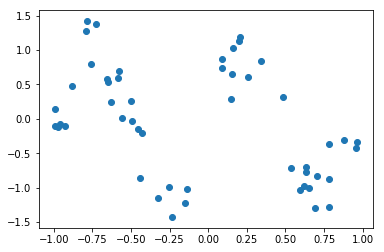

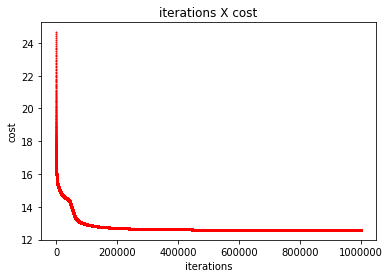

In [58]:
# Part - b Generate Dataset
plt.figure()
np.random.seed(100)
X = np.sort(2*np.random.rand(50,1)-1)
t = np.sin(2*(np.pi)*X) + 0.3*np.random.randn(50,1)
plt.figure()
plt.scatter(X, t)
hidden_layers = [20,20]
iterations = 100_0000
rho = .001
normalize_data = 1
print_cost = 1
seed = 100
plt.figure()
train_pkg_all_gates = train(X, t, hidden_layers = hidden_layers, \
                               epochs=iterations, rho=rho, \
                                       normalize_data=normalize_data, \
                                       show_cost=print_cost, seed=100, epsilon = 0.55)


## match_pkg for second part

    match_pkg is a list:
            prediction[0] == boolean (converged or not, True or False)
            prediction[1] == idx_done, no. of iterations to converge
            prediction[2] == total iterations (epochs)
            prediction[3] == learning rate used(rho)
            prediction[4] == predicted Y

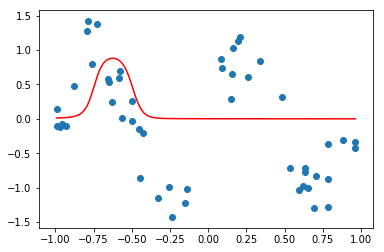

In [56]:
x_mesh = np.linspace(np.min(X),np.max(X),500).reshape(500,1)
match_pkg = match_regress(x_mesh, t, train_pkg_all_gates)
plt.plot(x_mesh, match_pkg[4],'r')
plt.scatter(X, t)

In [ ]:
plt.scatter(x_mesh, match_pkg[4])

In [19]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)

1.13.1
2.2.4-tf


In [20]:
tf.keras

<module 'tensorflow.keras' from 'B:\\code\\Anaconda3\\lib\\site-packages\\tensorflow\\_api\\v1\\keras\\__init__.py'>

In [37]:
# model = tf.keras.Sequential()
# layers.Dense(64, activation='sigmoid')
from keras.layers import Dense, Input
from keras import Sequential
model = Sequential()
model.add(Dense(32, input_shape=(1,)))
# Adds a densely-connected layer with 64 units to the model:
model.add(Dense(20, activation='sigmoid'))
# Add a softmax layer with 10 output units:
model.add(Dense(1, activation='linear'))

model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X,t,epochs=10000,batch_size=32)

Epoch 1/10000
50/50 [==============================] - 0s 4ms/step - loss: 1.3873 - acc: 0.0000e+00
Epoch 2/10000
50/50 [==============================] - 0s 100us/step - loss: 1.2717 - acc: 0.0000e+00
Epoch 3/10000
50/50 [==============================] - 0s 120us/step - loss: 1.2012 - acc: 0.0000e+00
Epoch 4/10000
50/50 [==============================] - 0s 120us/step - loss: 1.1442 - acc: 0.0000e+00
Epoch 5/10000
50/50 [==============================] - 0s 100us/step - loss: 1.0922 - acc: 0.0000e+00
Epoch 6/10000
50/50 [==============================] - 0s 140us/step - loss: 1.0471 - acc: 0.0000e+00
Epoch 7/10000
50/50 [==============================] - 0s 120us/step - loss: 1.0070 - acc: 0.0000e+00
Epoch 8/10000
50/50 [==============================] - 0s 140us/step - loss: 0.9717 - acc: 0.0000e+00
Epoch 9/10000
50/50 [==============================] - 0s 120us/step - loss: 0.9374 - acc: 0.0000e+00
Epoch 10/10000
50/50 [==============================] - 0s 100us/step - loss: 0.9059

50/50 [==============================] - 0s 120us/step - loss: 0.5437 - acc: 0.0000e+00
Epoch 160/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5427 - acc: 0.0000e+00
Epoch 161/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5425 - acc: 0.0000e+00
Epoch 162/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5456 - acc: 0.0000e+00
Epoch 163/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5425 - acc: 0.0000e+00
Epoch 164/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5424 - acc: 0.0000e+00
Epoch 165/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5436 - acc: 0.0000e+00
Epoch 166/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5421 - acc: 0.0000e+00
Epoch 167/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5433 - acc: 0.0000e+00
Epoch 168/10000
50/50 [==============================] - 0s 140us/step - loss: 0

50/50 [==============================] - 0s 100us/step - loss: 0.5418 - acc: 0.0000e+00
Epoch 316/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5427 - acc: 0.0000e+00
Epoch 317/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5419 - acc: 0.0000e+00
Epoch 318/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5419 - acc: 0.0000e+00
Epoch 319/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5481 - acc: 0.0000e+00
Epoch 320/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5423 - acc: 0.0000e+00
Epoch 321/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5427 - acc: 0.0000e+00
Epoch 322/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5418 - acc: 0.0000e+00
Epoch 323/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5417 - acc: 0.0000e+00
Epoch 324/10000
50/50 [==============================] - 0s 120us/step - loss: 0

50/50 [==============================] - 0s 120us/step - loss: 0.5475 - acc: 0.0000e+00
Epoch 472/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5424 - acc: 0.0000e+00
Epoch 473/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5494 - acc: 0.0000e+00
Epoch 474/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5429 - acc: 0.0000e+00
Epoch 475/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5418 - acc: 0.0000e+00
Epoch 476/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5429 - acc: 0.0000e+00
Epoch 477/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5418 - acc: 0.0000e+00
Epoch 478/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5418 - acc: 0.0000e+00
Epoch 479/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5424 - acc: 0.0000e+00
Epoch 480/10000
50/50 [==============================] - 0s 120us/step - loss: 0

50/50 [==============================] - 0s 100us/step - loss: 0.5427 - acc: 0.0000e+00
Epoch 628/10000
50/50 [==============================] - 0s 160us/step - loss: 0.5417 - acc: 0.0000e+00
Epoch 629/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5427 - acc: 0.0000e+00
Epoch 630/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5415 - acc: 0.0000e+00
Epoch 631/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5470 - acc: 0.0000e+00
Epoch 632/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5427 - acc: 0.0000e+00
Epoch 633/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5434 - acc: 0.0000e+00
Epoch 634/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5417 - acc: 0.0000e+00
Epoch 635/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5417 - acc: 0.0000e+00
Epoch 636/10000
50/50 [==============================] - 0s 120us/step - loss: 0

50/50 [==============================] - 0s 100us/step - loss: 0.5416 - acc: 0.0000e+00
Epoch 784/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5426 - acc: 0.0000e+00
Epoch 785/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5436 - acc: 0.0000e+00
Epoch 786/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5438 - acc: 0.0000e+00
Epoch 787/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5417 - acc: 0.0000e+00
Epoch 788/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5421 - acc: 0.0000e+00
Epoch 789/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5414 - acc: 0.0000e+00
Epoch 790/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5438 - acc: 0.0000e+00
Epoch 791/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5416 - acc: 0.0000e+00
Epoch 792/10000
50/50 [==============================] - 0s 120us/step - loss: 0

50/50 [==============================] - 0s 120us/step - loss: 0.5413 - acc: 0.0000e+00
Epoch 940/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5436 - acc: 0.0000e+00
Epoch 941/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5444 - acc: 0.0000e+00
Epoch 942/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5444 - acc: 0.0000e+00
Epoch 943/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5418 - acc: 0.0000e+00
Epoch 944/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5414 - acc: 0.0000e+00
Epoch 945/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5413 - acc: 0.0000e+00
Epoch 946/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5420 - acc: 0.0000e+00
Epoch 947/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5415 - acc: 0.0000e+00
Epoch 948/10000
50/50 [==============================] - 0s 100us/step - loss: 0

50/50 [==============================] - 0s 100us/step - loss: 0.5417 - acc: 0.0000e+00
Epoch 1096/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5445 - acc: 0.0000e+00
Epoch 1097/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5414 - acc: 0.0000e+00
Epoch 1098/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5439 - acc: 0.0000e+00
Epoch 1099/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5420 - acc: 0.0000e+00
Epoch 1100/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5424 - acc: 0.0000e+00
Epoch 1101/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5437 - acc: 0.0000e+00
Epoch 1102/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5426 - acc: 0.0000e+00
Epoch 1103/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5417 - acc: 0.0000e+00
Epoch 1104/10000
50/50 [==============================] - 0s 100us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.5430 - acc: 0.0000e+00
Epoch 1252/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5417 - acc: 0.0000e+00
Epoch 1253/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5423 - acc: 0.0000e+00
Epoch 1254/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5413 - acc: 0.0000e+00
Epoch 1255/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5422 - acc: 0.0000e+00
Epoch 1256/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5427 - acc: 0.0000e+00
Epoch 1257/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5421 - acc: 0.0000e+00
Epoch 1258/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5434 - acc: 0.0000e+00
Epoch 1259/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5439 - acc: 0.0000e+00
Epoch 1260/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.5411 - acc: 0.0000e+00
Epoch 1408/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5422 - acc: 0.0000e+00
Epoch 1409/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5422 - acc: 0.0000e+00
Epoch 1410/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5418 - acc: 0.0000e+00
Epoch 1411/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5471 - acc: 0.0000e+00
Epoch 1412/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5417 - acc: 0.0000e+00
Epoch 1413/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5410 - acc: 0.0000e+00
Epoch 1414/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5418 - acc: 0.0000e+00
Epoch 1415/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5420 - acc: 0.0000e+00
Epoch 1416/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.5480 - acc: 0.0000e+00
Epoch 1564/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5410 - acc: 0.0000e+00
Epoch 1565/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5439 - acc: 0.0000e+00
Epoch 1566/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5416 - acc: 0.0000e+00
Epoch 1567/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5411 - acc: 0.0000e+00
Epoch 1568/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5417 - acc: 0.0000e+00
Epoch 1569/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5411 - acc: 0.0000e+00
Epoch 1570/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5404 - acc: 0.0000e+00
Epoch 1571/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5410 - acc: 0.0000e+00
Epoch 1572/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 140us/step - loss: 0.5404 - acc: 0.0000e+00
Epoch 1720/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5424 - acc: 0.0000e+00
Epoch 1721/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5398 - acc: 0.0000e+00
Epoch 1722/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5396 - acc: 0.0000e+00
Epoch 1723/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5397 - acc: 0.0000e+00
Epoch 1724/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5412 - acc: 0.0000e+00
Epoch 1725/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5400 - acc: 0.0000e+00
Epoch 1726/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5453 - acc: 0.0000e+00
Epoch 1727/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5400 - acc: 0.0000e+00
Epoch 1728/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.5396 - acc: 0.0000e+00
Epoch 1876/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5398 - acc: 0.0000e+00
Epoch 1877/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5391 - acc: 0.0000e+00
Epoch 1878/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5379 - acc: 0.0000e+00
Epoch 1879/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5376 - acc: 0.0000e+00
Epoch 1880/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5452 - acc: 0.0000e+00
Epoch 1881/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5409 - acc: 0.0000e+00
Epoch 1882/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5391 - acc: 0.0000e+00
Epoch 1883/10000
50/50 [==============================] - 0s 100us/step - loss: 0.5375 - acc: 0.0000e+00
Epoch 1884/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.5278 - acc: 0.0000e+00
Epoch 2032/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5283 - acc: 0.0000e+00
Epoch 2033/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5279 - acc: 0.0000e+00
Epoch 2034/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5297 - acc: 0.0000e+00
Epoch 2035/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5283 - acc: 0.0000e+00
Epoch 2036/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5278 - acc: 0.0000e+00
Epoch 2037/10000
50/50 [==============================] - 0s 120us/step - loss: 0.5274 - acc: 0.0000e+00
Epoch 2038/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5276 - acc: 0.0000e+00
Epoch 2039/10000
50/50 [==============================] - 0s 140us/step - loss: 0.5266 - acc: 0.0000e+00
Epoch 2040/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.4982 - acc: 0.0000e+00
Epoch 2188/10000
50/50 [==============================] - 0s 120us/step - loss: 0.4987 - acc: 0.0000e+00
Epoch 2189/10000
50/50 [==============================] - 0s 120us/step - loss: 0.4976 - acc: 0.0000e+00
Epoch 2190/10000
50/50 [==============================] - 0s 120us/step - loss: 0.4981 - acc: 0.0000e+00
Epoch 2191/10000
50/50 [==============================] - 0s 140us/step - loss: 0.4971 - acc: 0.0000e+00
Epoch 2192/10000
50/50 [==============================] - 0s 120us/step - loss: 0.4973 - acc: 0.0000e+00
Epoch 2193/10000
50/50 [==============================] - 0s 120us/step - loss: 0.4968 - acc: 0.0000e+00
Epoch 2194/10000
50/50 [==============================] - 0s 120us/step - loss: 0.4962 - acc: 0.0000e+00
Epoch 2195/10000
50/50 [==============================] - 0s 100us/step - loss: 0.4990 - acc: 0.0000e+00
Epoch 2196/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 140us/step - loss: 0.4634 - acc: 0.0000e+00
Epoch 2344/10000
50/50 [==============================] - 0s 100us/step - loss: 0.4683 - acc: 0.0000e+00
Epoch 2345/10000
50/50 [==============================] - 0s 100us/step - loss: 0.4657 - acc: 0.0000e+00
Epoch 2346/10000
50/50 [==============================] - 0s 140us/step - loss: 0.4634 - acc: 0.0000e+00
Epoch 2347/10000
50/50 [==============================] - 0s 120us/step - loss: 0.4634 - acc: 0.0000e+00
Epoch 2348/10000
50/50 [==============================] - 0s 140us/step - loss: 0.4663 - acc: 0.0000e+00
Epoch 2349/10000
50/50 [==============================] - 0s 140us/step - loss: 0.4623 - acc: 0.0000e+00
Epoch 2350/10000
50/50 [==============================] - 0s 120us/step - loss: 0.4631 - acc: 0.0000e+00
Epoch 2351/10000
50/50 [==============================] - 0s 100us/step - loss: 0.4618 - acc: 0.0000e+00
Epoch 2352/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.4380 - acc: 0.0000e+00
Epoch 2500/10000
50/50 [==============================] - 0s 100us/step - loss: 0.4386 - acc: 0.0000e+00
Epoch 2501/10000
50/50 [==============================] - 0s 120us/step - loss: 0.4377 - acc: 0.0000e+00
Epoch 2502/10000
50/50 [==============================] - 0s 120us/step - loss: 0.4392 - acc: 0.0000e+00
Epoch 2503/10000
50/50 [==============================] - 0s 100us/step - loss: 0.4384 - acc: 0.0000e+00
Epoch 2504/10000
50/50 [==============================] - 0s 140us/step - loss: 0.4377 - acc: 0.0000e+00
Epoch 2505/10000
50/50 [==============================] - 0s 140us/step - loss: 0.4379 - acc: 0.0000e+00
Epoch 2506/10000
50/50 [==============================] - 0s 120us/step - loss: 0.4366 - acc: 0.0000e+00
Epoch 2507/10000
50/50 [==============================] - 0s 120us/step - loss: 0.4367 - acc: 0.0000e+00
Epoch 2508/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.4121 - acc: 0.0000e+00
Epoch 2656/10000
50/50 [==============================] - 0s 140us/step - loss: 0.4121 - acc: 0.0000e+00
Epoch 2657/10000
50/50 [==============================] - 0s 120us/step - loss: 0.4123 - acc: 0.0000e+00
Epoch 2658/10000
50/50 [==============================] - 0s 120us/step - loss: 0.4119 - acc: 0.0000e+00
Epoch 2659/10000
50/50 [==============================] - 0s 140us/step - loss: 0.4143 - acc: 0.0000e+00
Epoch 2660/10000
50/50 [==============================] - 0s 120us/step - loss: 0.4110 - acc: 0.0000e+00
Epoch 2661/10000
50/50 [==============================] - 0s 100us/step - loss: 0.4110 - acc: 0.0000e+00
Epoch 2662/10000
50/50 [==============================] - 0s 120us/step - loss: 0.4114 - acc: 0.0000e+00
Epoch 2663/10000
50/50 [==============================] - 0s 140us/step - loss: 0.4208 - acc: 0.0000e+00
Epoch 2664/10000
50/50 [==============================] - 0s 100us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.3677 - acc: 0.0000e+00
Epoch 2812/10000
50/50 [==============================] - 0s 100us/step - loss: 0.3675 - acc: 0.0000e+00
Epoch 2813/10000
50/50 [==============================] - 0s 120us/step - loss: 0.3667 - acc: 0.0000e+00
Epoch 2814/10000
50/50 [==============================] - 0s 120us/step - loss: 0.3674 - acc: 0.0000e+00
Epoch 2815/10000
50/50 [==============================] - 0s 100us/step - loss: 0.3671 - acc: 0.0000e+00
Epoch 2816/10000
50/50 [==============================] - 0s 100us/step - loss: 0.3697 - acc: 0.0000e+00
Epoch 2817/10000
50/50 [==============================] - 0s 100us/step - loss: 0.3658 - acc: 0.0000e+00
Epoch 2818/10000
50/50 [==============================] - 0s 120us/step - loss: 0.3683 - acc: 0.0000e+00
Epoch 2819/10000
50/50 [==============================] - 0s 120us/step - loss: 0.3656 - acc: 0.0000e+00
Epoch 2820/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.2763 - acc: 0.0000e+00
Epoch 2968/10000
50/50 [==============================] - 0s 120us/step - loss: 0.2747 - acc: 0.0000e+00
Epoch 2969/10000
50/50 [==============================] - 0s 140us/step - loss: 0.2744 - acc: 0.0000e+00
Epoch 2970/10000
50/50 [==============================] - 0s 100us/step - loss: 0.2763 - acc: 0.0000e+00
Epoch 2971/10000
50/50 [==============================] - 0s 120us/step - loss: 0.2730 - acc: 0.0000e+00
Epoch 2972/10000
50/50 [==============================] - 0s 100us/step - loss: 0.2720 - acc: 0.0000e+00
Epoch 2973/10000
50/50 [==============================] - 0s 140us/step - loss: 0.2718 - acc: 0.0000e+00
Epoch 2974/10000
50/50 [==============================] - 0s 100us/step - loss: 0.2729 - acc: 0.0000e+00
Epoch 2975/10000
50/50 [==============================] - 0s 100us/step - loss: 0.2732 - acc: 0.0000e+00
Epoch 2976/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.1764 - acc: 0.0000e+00
Epoch 3124/10000
50/50 [==============================] - 0s 120us/step - loss: 0.1757 - acc: 0.0000e+00
Epoch 3125/10000
50/50 [==============================] - 0s 120us/step - loss: 0.1747 - acc: 0.0000e+00
Epoch 3126/10000
50/50 [==============================] - 0s 100us/step - loss: 0.1741 - acc: 0.0000e+00
Epoch 3127/10000
50/50 [==============================] - 0s 120us/step - loss: 0.1737 - acc: 0.0000e+00
Epoch 3128/10000
50/50 [==============================] - 0s 100us/step - loss: 0.1727 - acc: 0.0000e+00
Epoch 3129/10000
50/50 [==============================] - 0s 120us/step - loss: 0.1732 - acc: 0.0000e+00
Epoch 3130/10000
50/50 [==============================] - 0s 100us/step - loss: 0.1721 - acc: 0.0000e+00
Epoch 3131/10000
50/50 [==============================] - 0s 120us/step - loss: 0.1713 - acc: 0.0000e+00
Epoch 3132/10000
50/50 [==============================] - 0s 100us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.1352 - acc: 0.0000e+00
Epoch 3280/10000
50/50 [==============================] - 0s 100us/step - loss: 0.1324 - acc: 0.0000e+00
Epoch 3281/10000
50/50 [==============================] - 0s 100us/step - loss: 0.1319 - acc: 0.0000e+00
Epoch 3282/10000
50/50 [==============================] - 0s 120us/step - loss: 0.1323 - acc: 0.0000e+00
Epoch 3283/10000
50/50 [==============================] - 0s 120us/step - loss: 0.1318 - acc: 0.0000e+00
Epoch 3284/10000
50/50 [==============================] - 0s 120us/step - loss: 0.1322 - acc: 0.0000e+00
Epoch 3285/10000
50/50 [==============================] - 0s 140us/step - loss: 0.1337 - acc: 0.0000e+00
Epoch 3286/10000
50/50 [==============================] - 0s 120us/step - loss: 0.1333 - acc: 0.0000e+00
Epoch 3287/10000
50/50 [==============================] - 0s 120us/step - loss: 0.1316 - acc: 0.0000e+00
Epoch 3288/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.1186 - acc: 0.0000e+00
Epoch 3436/10000
50/50 [==============================] - 0s 100us/step - loss: 0.1188 - acc: 0.0000e+00
Epoch 3437/10000
50/50 [==============================] - 0s 120us/step - loss: 0.1183 - acc: 0.0000e+00
Epoch 3438/10000
50/50 [==============================] - 0s 100us/step - loss: 0.1194 - acc: 0.0000e+00
Epoch 3439/10000
50/50 [==============================] - 0s 100us/step - loss: 0.1184 - acc: 0.0000e+00
Epoch 3440/10000
50/50 [==============================] - 0s 140us/step - loss: 0.1183 - acc: 0.0000e+00
Epoch 3441/10000
50/50 [==============================] - 0s 120us/step - loss: 0.1177 - acc: 0.0000e+00
Epoch 3442/10000
50/50 [==============================] - 0s 120us/step - loss: 0.1190 - acc: 0.0000e+00
Epoch 3443/10000
50/50 [==============================] - 0s 140us/step - loss: 0.1185 - acc: 0.0000e+00
Epoch 3444/10000
50/50 [==============================] - 0s 100us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.1079 - acc: 0.0000e+00
Epoch 3592/10000
50/50 [==============================] - 0s 100us/step - loss: 0.1086 - acc: 0.0000e+00
Epoch 3593/10000
50/50 [==============================] - 0s 120us/step - loss: 0.1075 - acc: 0.0000e+00
Epoch 3594/10000
50/50 [==============================] - 0s 100us/step - loss: 0.1076 - acc: 0.0000e+00
Epoch 3595/10000
50/50 [==============================] - 0s 100us/step - loss: 0.1071 - acc: 0.0000e+00
Epoch 3596/10000
50/50 [==============================] - 0s 120us/step - loss: 0.1075 - acc: 0.0000e+00
Epoch 3597/10000
50/50 [==============================] - 0s 100us/step - loss: 0.1069 - acc: 0.0000e+00
Epoch 3598/10000
50/50 [==============================] - 0s 100us/step - loss: 0.1077 - acc: 0.0000e+00
Epoch 3599/10000
50/50 [==============================] - 0s 120us/step - loss: 0.1072 - acc: 0.0000e+00
Epoch 3600/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.0972 - acc: 0.0000e+00
Epoch 3748/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0981 - acc: 0.0000e+00
Epoch 3749/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0973 - acc: 0.0000e+00
Epoch 3750/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0973 - acc: 0.0000e+00
Epoch 3751/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0982 - acc: 0.0000e+00
Epoch 3752/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0961 - acc: 0.0000e+00
Epoch 3753/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0966 - acc: 0.0000e+00
Epoch 3754/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0968 - acc: 0.0000e+00
Epoch 3755/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0967 - acc: 0.0000e+00
Epoch 3756/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0872 - acc: 0.0000e+00
Epoch 3904/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0872 - acc: 0.0000e+00
Epoch 3905/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0881 - acc: 0.0000e+00
Epoch 3906/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0879 - acc: 0.0000e+00
Epoch 3907/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0867 - acc: 0.0000e+00
Epoch 3908/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0871 - acc: 0.0000e+00
Epoch 3909/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0871 - acc: 0.0000e+00
Epoch 3910/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0864 - acc: 0.0000e+00
Epoch 3911/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0871 - acc: 0.0000e+00
Epoch 3912/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0777 - acc: 0.0000e+00
Epoch 4060/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0778 - acc: 0.0000e+00
Epoch 4061/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0772 - acc: 0.0000e+00
Epoch 4062/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0782 - acc: 0.0000e+00
Epoch 4063/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0767 - acc: 0.0000e+00
Epoch 4064/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0764 - acc: 0.0000e+00
Epoch 4065/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0764 - acc: 0.0000e+00
Epoch 4066/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0767 - acc: 0.0000e+00
Epoch 4067/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0770 - acc: 0.0000e+00
Epoch 4068/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.0687 - acc: 0.0000e+00
Epoch 4216/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0688 - acc: 0.0000e+00
Epoch 4217/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0690 - acc: 0.0000e+00
Epoch 4218/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0690 - acc: 0.0000e+00
Epoch 4219/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0685 - acc: 0.0000e+00
Epoch 4220/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0686 - acc: 0.0000e+00
Epoch 4221/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0691 - acc: 0.0000e+00
Epoch 4222/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0693 - acc: 0.0000e+00
Epoch 4223/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0683 - acc: 0.0000e+00
Epoch 4224/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.0636 - acc: 0.0000e+00
Epoch 4372/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0631 - acc: 0.0000e+00
Epoch 4373/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0628 - acc: 0.0000e+00
Epoch 4374/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0653 - acc: 0.0000e+00
Epoch 4375/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0624 - acc: 0.0000e+00
Epoch 4376/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0625 - acc: 0.0000e+00
Epoch 4377/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0622 - acc: 0.0000e+00
Epoch 4378/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0628 - acc: 0.0000e+00
Epoch 4379/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0629 - acc: 0.0000e+00
Epoch 4380/10000
50/50 [==============================] - 0s 100us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.0593 - acc: 0.0000e+00
Epoch 4528/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0597 - acc: 0.0000e+00
Epoch 4529/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0589 - acc: 0.0000e+00
Epoch 4530/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0595 - acc: 0.0000e+00
Epoch 4531/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0589 - acc: 0.0000e+00
Epoch 4532/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0594 - acc: 0.0000e+00
Epoch 4533/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0589 - acc: 0.0000e+00
Epoch 4534/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0589 - acc: 0.0000e+00
Epoch 4535/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0590 - acc: 0.0000e+00
Epoch 4536/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0578 - acc: 0.0000e+00
Epoch 4684/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0567 - acc: 0.0000e+00
Epoch 4685/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0577 - acc: 0.0000e+00
Epoch 4686/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0568 - acc: 0.0000e+00
Epoch 4687/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0586 - acc: 0.0000e+00
Epoch 4688/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0569 - acc: 0.0000e+00
Epoch 4689/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0571 - acc: 0.0000e+00
Epoch 4690/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0571 - acc: 0.0000e+00
Epoch 4691/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0568 - acc: 0.0000e+00
Epoch 4692/10000
50/50 [==============================] - 0s 140us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0561 - acc: 0.0000e+00
Epoch 4840/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0559 - acc: 0.0000e+00
Epoch 4841/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0557 - acc: 0.0000e+00
Epoch 4842/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0554 - acc: 0.0000e+00
Epoch 4843/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0559 - acc: 0.0000e+00
Epoch 4844/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0563 - acc: 0.0000e+00
Epoch 4845/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0564 - acc: 0.0000e+00
Epoch 4846/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0556 - acc: 0.0000e+00
Epoch 4847/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0555 - acc: 0.0000e+00
Epoch 4848/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0549 - acc: 0.0000e+00
Epoch 4996/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0545 - acc: 0.0000e+00
Epoch 4997/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0552 - acc: 0.0000e+00
Epoch 4998/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0551 - acc: 0.0000e+00
Epoch 4999/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0550 - acc: 0.0000e+00
Epoch 5000/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0543 - acc: 0.0000e+00
Epoch 5001/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0552 - acc: 0.0000e+00
Epoch 5002/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0542 - acc: 0.0000e+00
Epoch 5003/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0548 - acc: 0.0000e+00
Epoch 5004/10000
50/50 [==============================] - 0s 100us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0534 - acc: 0.0000e+00
Epoch 5152/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0535 - acc: 0.0000e+00
Epoch 5153/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0538 - acc: 0.0000e+00
Epoch 5154/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0538 - acc: 0.0000e+00
Epoch 5155/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0542 - acc: 0.0000e+00
Epoch 5156/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0539 - acc: 0.0000e+00
Epoch 5157/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0545 - acc: 0.0000e+00
Epoch 5158/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0538 - acc: 0.0000e+00
Epoch 5159/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0537 - acc: 0.0000e+00
Epoch 5160/10000
50/50 [==============================] - 0s 100us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.0533 - acc: 0.0000e+00
Epoch 5308/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0549 - acc: 0.0000e+00
Epoch 5309/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0534 - acc: 0.0000e+00
Epoch 5310/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0530 - acc: 0.0000e+00
Epoch 5311/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0532 - acc: 0.0000e+00
Epoch 5312/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0533 - acc: 0.0000e+00
Epoch 5313/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0533 - acc: 0.0000e+00
Epoch 5314/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0535 - acc: 0.0000e+00
Epoch 5315/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0533 - acc: 0.0000e+00
Epoch 5316/10000
50/50 [==============================] - 0s 100us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.0533 - acc: 0.0000e+00
Epoch 5464/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0527 - acc: 0.0000e+00
Epoch 5465/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0532 - acc: 0.0000e+00
Epoch 5466/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0527 - acc: 0.0000e+00
Epoch 5467/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0536 - acc: 0.0000e+00
Epoch 5468/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0534 - acc: 0.0000e+00
Epoch 5469/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0527 - acc: 0.0000e+00
Epoch 5470/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0531 - acc: 0.0000e+00
Epoch 5471/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0535 - acc: 0.0000e+00
Epoch 5472/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.0534 - acc: 0.0000e+00
Epoch 5620/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0530 - acc: 0.0000e+00
Epoch 5621/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0527 - acc: 0.0000e+00
Epoch 5622/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0526 - acc: 0.0000e+00
Epoch 5623/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0527 - acc: 0.0000e+00
Epoch 5624/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0527 - acc: 0.0000e+00
Epoch 5625/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0525 - acc: 0.0000e+00
Epoch 5626/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0541 - acc: 0.0000e+00
Epoch 5627/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0527 - acc: 0.0000e+00
Epoch 5628/10000
50/50 [==============================] - 0s 100us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0523 - acc: 0.0000e+00
Epoch 5776/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0527 - acc: 0.0000e+00
Epoch 5777/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0527 - acc: 0.0000e+00
Epoch 5778/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0527 - acc: 0.0000e+00
Epoch 5779/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0528 - acc: 0.0000e+00
Epoch 5780/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0525 - acc: 0.0000e+00
Epoch 5781/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0528 - acc: 0.0000e+00
Epoch 5782/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0524 - acc: 0.0000e+00
Epoch 5783/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0532 - acc: 0.0000e+00
Epoch 5784/10000
50/50 [==============================] - 0s 100us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.0533 - acc: 0.0000e+00
Epoch 5932/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0526 - acc: 0.0000e+00
Epoch 5933/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0524 - acc: 0.0000e+00
Epoch 5934/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0523 - acc: 0.0000e+00
Epoch 5935/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0524 - acc: 0.0000e+00
Epoch 5936/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0524 - acc: 0.0000e+00
Epoch 5937/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0523 - acc: 0.0000e+00
Epoch 5938/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0533 - acc: 0.0000e+00
Epoch 5939/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0519 - acc: 0.0000e+00
Epoch 5940/10000
50/50 [==============================] - 0s 100us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0533 - acc: 0.0000e+00
Epoch 6088/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0525 - acc: 0.0000e+00
Epoch 6089/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0518 - acc: 0.0000e+00
Epoch 6090/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0520 - acc: 0.0000e+00
Epoch 6091/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0519 - acc: 0.0000e+00
Epoch 6092/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0522 - acc: 0.0000e+00
Epoch 6093/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0522 - acc: 0.0000e+00
Epoch 6094/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0533 - acc: 0.0000e+00
Epoch 6095/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0520 - acc: 0.0000e+00
Epoch 6096/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 140us/step - loss: 0.0520 - acc: 0.0000e+00
Epoch 6244/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0522 - acc: 0.0000e+00
Epoch 6245/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0519 - acc: 0.0000e+00
Epoch 6246/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0526 - acc: 0.0000e+00
Epoch 6247/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0521 - acc: 0.0000e+00
Epoch 6248/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0519 - acc: 0.0000e+00
Epoch 6249/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0518 - acc: 0.0000e+00
Epoch 6250/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0514 - acc: 0.0000e+00
Epoch 6251/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0528 - acc: 0.0000e+00
Epoch 6252/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0516 - acc: 0.0000e+00
Epoch 6400/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0519 - acc: 0.0000e+00
Epoch 6401/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0529 - acc: 0.0000e+00
Epoch 6402/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0519 - acc: 0.0000e+00
Epoch 6403/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0517 - acc: 0.0000e+00
Epoch 6404/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0529 - acc: 0.0000e+00
Epoch 6405/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0523 - acc: 0.0000e+00
Epoch 6406/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0517 - acc: 0.0000e+00
Epoch 6407/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0511 - acc: 0.0000e+00
Epoch 6408/10000
50/50 [==============================] - 0s 140us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.0514 - acc: 0.0000e+00
Epoch 6556/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0523 - acc: 0.0000e+00
Epoch 6557/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0514 - acc: 0.0000e+00
Epoch 6558/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0525 - acc: 0.0000e+00
Epoch 6559/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0512 - acc: 0.0000e+00
Epoch 6560/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0519 - acc: 0.0000e+00
Epoch 6561/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0516 - acc: 0.0000e+00
Epoch 6562/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0518 - acc: 0.0000e+00
Epoch 6563/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0527 - acc: 0.0000e+00
Epoch 6564/10000
50/50 [==============================] - 0s 100us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.0513 - acc: 0.0000e+00
Epoch 6712/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0511 - acc: 0.0000e+00
Epoch 6713/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0517 - acc: 0.0000e+00
Epoch 6714/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0512 - acc: 0.0000e+00
Epoch 6715/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0528 - acc: 0.0000e+00
Epoch 6716/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0515 - acc: 0.0000e+00
Epoch 6717/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0514 - acc: 0.0000e+00
Epoch 6718/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0514 - acc: 0.0000e+00
Epoch 6719/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0515 - acc: 0.0000e+00
Epoch 6720/10000
50/50 [==============================] - 0s 140us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0514 - acc: 0.0000e+00
Epoch 6867/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0523 - acc: 0.0000e+00
Epoch 6868/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0513 - acc: 0.0000e+00
Epoch 6869/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0510 - acc: 0.0000e+00
Epoch 6870/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0513 - acc: 0.0000e+00
Epoch 6871/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0513 - acc: 0.0000e+00
Epoch 6872/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0523 - acc: 0.0000e+00
Epoch 6873/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0513 - acc: 0.0000e+00
Epoch 6874/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0515 - acc: 0.0000e+00
Epoch 6875/10000
50/50 [==============================] - 0s 100us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0514 - acc: 0.0000e+00
Epoch 7023/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0510 - acc: 0.0000e+00
Epoch 7024/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0511 - acc: 0.0000e+00
Epoch 7025/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0513 - acc: 0.0000e+00
Epoch 7026/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0517 - acc: 0.0000e+00
Epoch 7027/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0510 - acc: 0.0000e+00
Epoch 7028/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0522 - acc: 0.0000e+00
Epoch 7029/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0510 - acc: 0.0000e+00
Epoch 7030/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0514 - acc: 0.0000e+00
Epoch 7031/10000
50/50 [==============================] - 0s 140us/step 

50/50 [==============================] - 0s 140us/step - loss: 0.0514 - acc: 0.0000e+00
Epoch 7179/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0516 - acc: 0.0000e+00
Epoch 7180/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0513 - acc: 0.0000e+00
Epoch 7181/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0507 - acc: 0.0000e+00
Epoch 7182/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0512 - acc: 0.0000e+00
Epoch 7183/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0509 - acc: 0.0000e+00
Epoch 7184/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0508 - acc: 0.0000e+00
Epoch 7185/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0512 - acc: 0.0000e+00
Epoch 7186/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0507 - acc: 0.0000e+00
Epoch 7187/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.0514 - acc: 0.0000e+00
Epoch 7335/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0511 - acc: 0.0000e+00
Epoch 7336/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0510 - acc: 0.0000e+00
Epoch 7337/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0512 - acc: 0.0000e+00
Epoch 7338/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0512 - acc: 0.0000e+00
Epoch 7339/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0524 - acc: 0.0000e+00
Epoch 7340/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0508 - acc: 0.0000e+00
Epoch 7341/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0519 - acc: 0.0000e+00
Epoch 7342/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0512 - acc: 0.0000e+00
Epoch 7343/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0509 - acc: 0.0000e+00
Epoch 7491/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0508 - acc: 0.0000e+00
Epoch 7492/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0515 - acc: 0.0000e+00
Epoch 7493/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0508 - acc: 0.0000e+00
Epoch 7494/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0513 - acc: 0.0000e+00
Epoch 7495/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0522 - acc: 0.0000e+00
Epoch 7496/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0509 - acc: 0.0000e+00
Epoch 7497/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0511 - acc: 0.0000e+00
Epoch 7498/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0505 - acc: 0.0000e+00
Epoch 7499/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.0507 - acc: 0.0000e+00
Epoch 7647/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0510 - acc: 0.0000e+00
Epoch 7648/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0517 - acc: 0.0000e+00
Epoch 7649/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0519 - acc: 0.0000e+00
Epoch 7650/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0507 - acc: 0.0000e+00
Epoch 7651/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0509 - acc: 0.0000e+00
Epoch 7652/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0508 - acc: 0.0000e+00
Epoch 7653/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0508 - acc: 0.0000e+00
Epoch 7654/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0513 - acc: 0.0000e+00
Epoch 7655/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0507 - acc: 0.0000e+00
Epoch 7803/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0513 - acc: 0.0000e+00
Epoch 7804/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0506 - acc: 0.0000e+00
Epoch 7805/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0511 - acc: 0.0000e+00
Epoch 7806/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0514 - acc: 0.0000e+00
Epoch 7807/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0509 - acc: 0.0000e+00
Epoch 7808/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0512 - acc: 0.0000e+00
Epoch 7809/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0505 - acc: 0.0000e+00
Epoch 7810/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0505 - acc: 0.0000e+00
Epoch 7811/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 140us/step - loss: 0.0507 - acc: 0.0000e+00
Epoch 7959/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0511 - acc: 0.0000e+00
Epoch 7960/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0503 - acc: 0.0000e+00
Epoch 7961/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0505 - acc: 0.0000e+00
Epoch 7962/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0509 - acc: 0.0000e+00
Epoch 7963/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0509 - acc: 0.0000e+00
Epoch 7964/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0508 - acc: 0.0000e+00
Epoch 7965/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0513 - acc: 0.0000e+00
Epoch 7966/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0507 - acc: 0.0000e+00
Epoch 7967/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.0507 - acc: 0.0000e+00
Epoch 8115/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0507 - acc: 0.0000e+00
Epoch 8116/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0506 - acc: 0.0000e+00
Epoch 8117/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0507 - acc: 0.0000e+00
Epoch 8118/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0501 - acc: 0.0000e+00
Epoch 8119/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0508 - acc: 0.0000e+00
Epoch 8120/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0504 - acc: 0.0000e+00
Epoch 8121/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0510 - acc: 0.0000e+00
Epoch 8122/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0510 - acc: 0.0000e+00
Epoch 8123/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 140us/step - loss: 0.0516 - acc: 0.0000e+00
Epoch 8271/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0507 - acc: 0.0000e+00
Epoch 8272/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0506 - acc: 0.0000e+00
Epoch 8273/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0509 - acc: 0.0000e+00
Epoch 8274/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0508 - acc: 0.0000e+00
Epoch 8275/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0510 - acc: 0.0000e+00
Epoch 8276/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0502 - acc: 0.0000e+00
Epoch 8277/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0502 - acc: 0.0000e+00
Epoch 8278/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0504 - acc: 0.0000e+00
Epoch 8279/10000
50/50 [==============================] - 0s 140us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0502 - acc: 0.0000e+00
Epoch 8427/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0500 - acc: 0.0000e+00
Epoch 8428/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0505 - acc: 0.0000e+00
Epoch 8429/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0507 - acc: 0.0000e+00
Epoch 8430/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0522 - acc: 0.0000e+00
Epoch 8431/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0504 - acc: 0.0000e+00
Epoch 8432/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0500 - acc: 0.0000e+00
Epoch 8433/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0500 - acc: 0.0000e+00
Epoch 8434/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0504 - acc: 0.0000e+00
Epoch 8435/10000
50/50 [==============================] - 0s 100us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.0505 - acc: 0.0000e+00
Epoch 8583/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0502 - acc: 0.0000e+00
Epoch 8584/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0501 - acc: 0.0000e+00
Epoch 8585/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0500 - acc: 0.0000e+00
Epoch 8586/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0504 - acc: 0.0000e+00
Epoch 8587/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0503 - acc: 0.0000e+00
Epoch 8588/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0507 - acc: 0.0000e+00
Epoch 8589/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0501 - acc: 0.0000e+00
Epoch 8590/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0504 - acc: 0.0000e+00
Epoch 8591/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.0507 - acc: 0.0000e+00
Epoch 8739/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0507 - acc: 0.0000e+00
Epoch 8740/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0498 - acc: 0.0000e+00
Epoch 8741/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0507 - acc: 0.0000e+00
Epoch 8742/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0502 - acc: 0.0000e+00
Epoch 8743/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0504 - acc: 0.0000e+00
Epoch 8744/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0505 - acc: 0.0000e+00
Epoch 8745/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0503 - acc: 0.0000e+00
Epoch 8746/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0500 - acc: 0.0000e+00
Epoch 8747/10000
50/50 [==============================] - 0s 140us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0499 - acc: 0.0000e+00
Epoch 8895/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0514 - acc: 0.0000e+00
Epoch 8896/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0500 - acc: 0.0000e+00
Epoch 8897/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0498 - acc: 0.0000e+00
Epoch 8898/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0502 - acc: 0.0000e+00
Epoch 8899/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0512 - acc: 0.0000e+00
Epoch 8900/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0503 - acc: 0.0000e+00
Epoch 8901/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0503 - acc: 0.0000e+00
Epoch 8902/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0501 - acc: 0.0000e+00
Epoch 8903/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0502 - acc: 0.0000e+00
Epoch 9051/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0498 - acc: 0.0000e+00
Epoch 9052/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0499 - acc: 0.0000e+00
Epoch 9053/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0498 - acc: 0.0000e+00
Epoch 9054/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0499 - acc: 0.0000e+00
Epoch 9055/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0502 - acc: 0.0000e+00
Epoch 9056/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0505 - acc: 0.0000e+00
Epoch 9057/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0498 - acc: 0.0000e+00
Epoch 9058/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0500 - acc: 0.0000e+00
Epoch 9059/10000
50/50 [==============================] - 0s 100us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0496 - acc: 0.0000e+00
Epoch 9207/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0499 - acc: 0.0000e+00
Epoch 9208/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0500 - acc: 0.0000e+00
Epoch 9209/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0499 - acc: 0.0000e+00
Epoch 9210/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0498 - acc: 0.0000e+00
Epoch 9211/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0500 - acc: 0.0000e+00
Epoch 9212/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0500 - acc: 0.0000e+00
Epoch 9213/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0497 - acc: 0.0000e+00
Epoch 9214/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0500 - acc: 0.0000e+00
Epoch 9215/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0495 - acc: 0.0000e+00
Epoch 9363/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0504 - acc: 0.0000e+00
Epoch 9364/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0497 - acc: 0.0000e+00
Epoch 9365/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0501 - acc: 0.0000e+00
Epoch 9366/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0499 - acc: 0.0000e+00
Epoch 9367/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0493 - acc: 0.0000e+00
Epoch 9368/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0495 - acc: 0.0000e+00
Epoch 9369/10000
50/50 [==============================] - 0s 180us/step - loss: 0.0497 - acc: 0.0000e+00
Epoch 9370/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0498 - acc: 0.0000e+00
Epoch 9371/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 100us/step - loss: 0.0495 - acc: 0.0000e+00
Epoch 9519/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0498 - acc: 0.0000e+00
Epoch 9520/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0498 - acc: 0.0000e+00
Epoch 9521/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0497 - acc: 0.0000e+00
Epoch 9522/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0494 - acc: 0.0000e+00
Epoch 9523/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0496 - acc: 0.0000e+00
Epoch 9524/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0495 - acc: 0.0000e+00
Epoch 9525/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0492 - acc: 0.0000e+00
Epoch 9526/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0497 - acc: 0.0000e+00
Epoch 9527/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0492 - acc: 0.0000e+00
Epoch 9674/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0494 - acc: 0.0000e+00
Epoch 9675/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0494 - acc: 0.0000e+00
Epoch 9676/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0493 - acc: 0.0000e+00
Epoch 9677/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0501 - acc: 0.0000e+00
Epoch 9678/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0497 - acc: 0.0000e+00
Epoch 9679/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0497 - acc: 0.0000e+00
Epoch 9680/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0498 - acc: 0.0000e+00
Epoch 9681/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0495 - acc: 0.0000e+00
Epoch 9682/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0498 - acc: 0.0000e+00
Epoch 9830/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0499 - acc: 0.0000e+00
Epoch 9831/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0495 - acc: 0.0000e+00
Epoch 9832/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0498 - acc: 0.0000e+00
Epoch 9833/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0490 - acc: 0.0000e+00
Epoch 9834/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0496 - acc: 0.0000e+00
Epoch 9835/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0491 - acc: 0.0000e+00
Epoch 9836/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0491 - acc: 0.0000e+00
Epoch 9837/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0498 - acc: 0.0000e+00
Epoch 9838/10000
50/50 [==============================] - 0s 120us/step 

50/50 [==============================] - 0s 120us/step - loss: 0.0492 - acc: 0.0000e+00
Epoch 9986/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0497 - acc: 0.0000e+00
Epoch 9987/10000
50/50 [==============================] - 0s 140us/step - loss: 0.0491 - acc: 0.0000e+00
Epoch 9988/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0490 - acc: 0.0000e+00
Epoch 9989/10000
50/50 [==============================] - 0s 100us/step - loss: 0.0492 - acc: 0.0000e+00
Epoch 9990/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0487 - acc: 0.0000e+00
Epoch 9991/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0488 - acc: 0.0000e+00
Epoch 9992/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0497 - acc: 0.0000e+00
Epoch 9993/10000
50/50 [==============================] - 0s 120us/step - loss: 0.0496 - acc: 0.0000e+00
Epoch 9994/10000
50/50 [==============================] - 0s 120us/step 

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_11 (Dense)             (None, 20)                660       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 21        
Total params: 745
Trainable params: 745
Non-trainable params: 0
_________________________________________________________________


In [39]:
y_hat = model.predict(x_mesh)

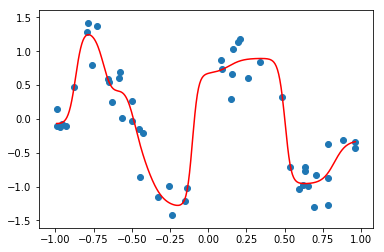

In [40]:
plt.plot(x_mesh,y_hat,'r')
plt.scatter(X,t)